In [2]:
import os
os.chdir(r"C:\Users\lizie\OneDrive\Desktop\CMU\25spring\ML\group project\90803ML-FinalProject\Data")

In [4]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt

In [5]:
train_losses = []
val_rmses = []

df = pd.read_csv("ridership.csv")
y = df['avg_riders']
# drop _id and avg_riders columns
X = df.drop(['_id', 'avg_riders'], axis=1)

In [6]:
# numeric columns: int + float
# categorical columns: object
int_cols = X.select_dtypes(include='int').columns.tolist()
float_cols = X.select_dtypes(include='float').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

# fill missing values(int + float)
for col in int_cols + float_cols:
    X[col].fillna(X[col].mean(), inplace=True)
X_num = X[int_cols + float_cols]
X_num_scaler = StandardScaler()
X_num_scaled = X_num_scaler.fit_transform(X_num)

# transform categorical columns to numerical indexes(for embedding later)
for col in cat_cols:
    X[col] = X[col].astype('category')
    X[col] = X[col].cat.add_categories(['missing'])
    X[col].fillna('missing', inplace=True)
    X[col] = X[col].cat.codes
X_cat = X[cat_cols].copy()
cat_cardinalities = [X[col].nunique() for col in cat_cols]
    
# standardize the y data (to make predictions easier)
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

C:\Users\lizie\AppData\Local\Temp\ipykernel_23656\2382065399.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mean(), inplace=True)
C:\Users\lizie\AppData\Local\Temp\ipykernel_23656\2382065399.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

In [7]:
# convert to PyTorch tensors
X_num_train, X_num_val, X_cat_train, X_cat_val, y_train, y_val = train_test_split(
    X_num_scaled, X_cat.values, y_scaled, test_size=0.2, random_state=42
)
X_num_train = torch.tensor(X_num_train, dtype=torch.float32)
X_num_val = torch.tensor(X_num_val, dtype=torch.float32)
X_cat_train = torch.tensor(X_cat_train, dtype=torch.long)
X_cat_val = torch.tensor(X_cat_val, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_cat_train, X_num_train, y_train)
val_dataset = TensorDataset(X_cat_val, X_num_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

In [8]:
# Define the model
class MLPRegressor(nn.Module):
    def __init__(self, cat_cardinalities, num_numeric_features, embedding_dim=8):
        super().__init__()
        
        
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=card, 
                         embedding_dim=min(embedding_dim, (card + 1) // 2))
            for card in cat_cardinalities
        ])
        total_embed_dim = sum([emb.embedding_dim for emb in self.embeddings])
        
        self.net = nn.Sequential(
            nn.Linear(total_embed_dim+num_numeric_features, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x_cat, x_num):
        # Embedding layers for categorical features
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(embedded + [x_num], dim=1)
        return self.net(x)


In [9]:
# initialize the model, loss function and optimizer
model = MLPRegressor(cat_cardinalities, num_numeric_features=X_num_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoches = 2500
scheduler = CosineAnnealingLR(optimizer, T_max=epoches, eta_min=0.00001)

# training loop
train_losses = []
val_rmses = []

for epoch in tqdm(range(epoches)):
    model.train()
    epoch_loss = 0

    for x_cat_batch, x_num_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_cat_batch, x_num_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for x_cat_batch, x_num_batch, y_batch in val_loader:
            pred = model(x_cat_batch, x_num_batch)
            preds.append(pred.numpy())
            true.append(y_batch.numpy())

    # Convert predictions and true values to numpy arrays
    preds = np.concatenate(preds, axis=0)
    true = np.concatenate(true, axis=0)
    # denormalize the predictions and true values
    preds = y_scaler.inverse_transform(preds)
    true = y_scaler.inverse_transform(true)
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(true, preds))
    print(f"Epoch {epoch+1}/{epoches}, Loss: {epoch_loss/len(train_loader)}, RMSE: {rmse:.4f}")
    train_losses.append(epoch_loss/len(train_loader))
    val_rmses.append(rmse)
    scheduler.step()
    
# save the model
torch.save(model.state_dict(), 'mlp_regressor.pth')

  0%|          | 1/2500 [00:00<10:24,  4.00it/s]

Epoch 1/2500, Loss: 0.6210016650812966, RMSE: 783.9620


  0%|          | 2/2500 [00:00<10:14,  4.06it/s]

Epoch 2/2500, Loss: 0.2496050979409899, RMSE: 570.4883


  0%|          | 3/2500 [00:00<10:25,  3.99it/s]

Epoch 3/2500, Loss: 0.1662869229912758, RMSE: 487.5623


  0%|          | 4/2500 [00:00<10:24,  4.00it/s]

Epoch 4/2500, Loss: 0.1334067298897675, RMSE: 443.7397


  0%|          | 5/2500 [00:01<10:29,  3.96it/s]

Epoch 5/2500, Loss: 0.1100925057062081, RMSE: 409.7366


  0%|          | 6/2500 [00:01<10:37,  3.91it/s]

Epoch 6/2500, Loss: 0.09335831382444927, RMSE: 422.1198


  0%|          | 7/2500 [00:01<10:38,  3.91it/s]

Epoch 7/2500, Loss: 0.0845938365906477, RMSE: 363.6414


  0%|          | 8/2500 [00:02<11:13,  3.70it/s]

Epoch 8/2500, Loss: 0.0769158700214965, RMSE: 340.8416


  0%|          | 9/2500 [00:02<11:43,  3.54it/s]

Epoch 9/2500, Loss: 0.06831658189850194, RMSE: 316.7250


  0%|          | 10/2500 [00:02<13:56,  2.98it/s]

Epoch 10/2500, Loss: 0.06375878235059125, RMSE: 314.4886


  0%|          | 11/2500 [00:03<13:23,  3.10it/s]

Epoch 11/2500, Loss: 0.06092843748629093, RMSE: 301.9855


  0%|          | 12/2500 [00:03<13:06,  3.16it/s]

Epoch 12/2500, Loss: 0.057391565825257986, RMSE: 286.5724


  1%|          | 13/2500 [00:03<12:36,  3.29it/s]

Epoch 13/2500, Loss: 0.0565156885023628, RMSE: 304.9007


  1%|          | 14/2500 [00:04<12:30,  3.31it/s]

Epoch 14/2500, Loss: 0.05661701735641275, RMSE: 280.3172


  1%|          | 15/2500 [00:04<12:11,  3.40it/s]

Epoch 15/2500, Loss: 0.05046377485351903, RMSE: 274.3137


  1%|          | 16/2500 [00:04<11:42,  3.54it/s]

Epoch 16/2500, Loss: 0.04783472514578274, RMSE: 282.0853


  1%|          | 17/2500 [00:04<11:10,  3.70it/s]

Epoch 17/2500, Loss: 0.04570145830512047, RMSE: 306.0568


  1%|          | 18/2500 [00:05<11:01,  3.75it/s]

Epoch 18/2500, Loss: 0.0474861356828894, RMSE: 263.9470


  1%|          | 19/2500 [00:05<10:49,  3.82it/s]

Epoch 19/2500, Loss: 0.04450289330312184, RMSE: 259.4902


  1%|          | 20/2500 [00:05<10:52,  3.80it/s]

Epoch 20/2500, Loss: 0.041238733593906673, RMSE: 259.7440


  1%|          | 21/2500 [00:05<10:44,  3.85it/s]

Epoch 21/2500, Loss: 0.04067953048007829, RMSE: 261.9379


  1%|          | 22/2500 [00:06<10:46,  3.83it/s]

Epoch 22/2500, Loss: 0.039189410768449305, RMSE: 246.4373


  1%|          | 23/2500 [00:06<10:40,  3.87it/s]

Epoch 23/2500, Loss: 0.040090832327093394, RMSE: 243.6266


  1%|          | 24/2500 [00:06<10:25,  3.96it/s]

Epoch 24/2500, Loss: 0.03889418723327773, RMSE: 254.7376


  1%|          | 25/2500 [00:06<10:18,  4.00it/s]

Epoch 25/2500, Loss: 0.0368815254420042, RMSE: 247.5652


  1%|          | 26/2500 [00:07<10:15,  4.02it/s]

Epoch 26/2500, Loss: 0.036829535024506706, RMSE: 243.0349


  1%|          | 27/2500 [00:07<10:14,  4.03it/s]

Epoch 27/2500, Loss: 0.03712903513972248, RMSE: 249.2324


  1%|          | 28/2500 [00:07<10:07,  4.07it/s]

Epoch 28/2500, Loss: 0.035122794338635036, RMSE: 246.8190


  1%|          | 29/2500 [00:07<10:07,  4.07it/s]

Epoch 29/2500, Loss: 0.03358063136360475, RMSE: 237.9695


  1%|          | 30/2500 [00:08<10:22,  3.97it/s]

Epoch 30/2500, Loss: 0.034966877289116384, RMSE: 234.7999


  1%|          | 31/2500 [00:08<12:20,  3.33it/s]

Epoch 31/2500, Loss: 0.03222371108297791, RMSE: 234.9542


  1%|▏         | 32/2500 [00:08<11:33,  3.56it/s]

Epoch 32/2500, Loss: 0.03327924625149795, RMSE: 231.0544


  1%|▏         | 33/2500 [00:08<10:59,  3.74it/s]

Epoch 33/2500, Loss: 0.031955289521387646, RMSE: 229.0450


  1%|▏         | 34/2500 [00:09<10:42,  3.84it/s]

Epoch 34/2500, Loss: 0.033852399007550306, RMSE: 229.5929


  1%|▏         | 35/2500 [00:09<10:35,  3.88it/s]

Epoch 35/2500, Loss: 0.03235891786004816, RMSE: 236.1759


  1%|▏         | 36/2500 [00:09<10:26,  3.93it/s]

Epoch 36/2500, Loss: 0.030888755592916692, RMSE: 230.1373


  1%|▏         | 37/2500 [00:09<10:33,  3.89it/s]

Epoch 37/2500, Loss: 0.02994370660079377, RMSE: 221.8763


  2%|▏         | 38/2500 [00:10<10:27,  3.92it/s]

Epoch 38/2500, Loss: 0.030962818515087878, RMSE: 220.1834


  2%|▏         | 39/2500 [00:10<10:26,  3.93it/s]

Epoch 39/2500, Loss: 0.028776890012834754, RMSE: 223.5690


  2%|▏         | 40/2500 [00:10<10:14,  4.00it/s]

Epoch 40/2500, Loss: 0.028790907614997457, RMSE: 233.2346


  2%|▏         | 41/2500 [00:10<10:10,  4.03it/s]

Epoch 41/2500, Loss: 0.028759997497711864, RMSE: 220.4623


  2%|▏         | 42/2500 [00:11<10:20,  3.96it/s]

Epoch 42/2500, Loss: 0.028267009955431733, RMSE: 225.1901


  2%|▏         | 43/2500 [00:11<10:25,  3.93it/s]

Epoch 43/2500, Loss: 0.028001109031694275, RMSE: 216.9860


  2%|▏         | 44/2500 [00:11<10:20,  3.96it/s]

Epoch 44/2500, Loss: 0.027883405424654485, RMSE: 216.1366


  2%|▏         | 45/2500 [00:11<10:17,  3.97it/s]

Epoch 45/2500, Loss: 0.027319662672068392, RMSE: 217.4504


  2%|▏         | 46/2500 [00:12<10:58,  3.73it/s]

Epoch 46/2500, Loss: 0.02809772552656276, RMSE: 221.0026


  2%|▏         | 47/2500 [00:12<11:09,  3.66it/s]

Epoch 47/2500, Loss: 0.027781214298946515, RMSE: 235.8038


  2%|▏         | 48/2500 [00:12<10:52,  3.76it/s]

Epoch 48/2500, Loss: 0.02806382028918181, RMSE: 217.2436


  2%|▏         | 49/2500 [00:13<10:34,  3.86it/s]

Epoch 49/2500, Loss: 0.027568999438413552, RMSE: 248.8949


  2%|▏         | 50/2500 [00:13<10:21,  3.94it/s]

Epoch 50/2500, Loss: 0.02729812723451427, RMSE: 218.6058


  2%|▏         | 51/2500 [00:13<12:07,  3.36it/s]

Epoch 51/2500, Loss: 0.024724667984992267, RMSE: 211.6711


  2%|▏         | 52/2500 [00:13<11:45,  3.47it/s]

Epoch 52/2500, Loss: 0.027237067983618805, RMSE: 220.3498


  2%|▏         | 53/2500 [00:14<11:25,  3.57it/s]

Epoch 53/2500, Loss: 0.025042938999831676, RMSE: 209.0946


  2%|▏         | 54/2500 [00:14<11:10,  3.65it/s]

Epoch 54/2500, Loss: 0.025578834794993913, RMSE: 228.3777


  2%|▏         | 55/2500 [00:14<10:57,  3.72it/s]

Epoch 55/2500, Loss: 0.02507986349186727, RMSE: 214.7592


  2%|▏         | 56/2500 [00:14<10:40,  3.81it/s]

Epoch 56/2500, Loss: 0.024001929509852613, RMSE: 209.3999


  2%|▏         | 57/2500 [00:15<10:29,  3.88it/s]

Epoch 57/2500, Loss: 0.025252332698021615, RMSE: 212.1347


  2%|▏         | 58/2500 [00:15<10:16,  3.96it/s]

Epoch 58/2500, Loss: 0.02471088178988014, RMSE: 219.2391


  2%|▏         | 59/2500 [00:15<10:20,  3.93it/s]

Epoch 59/2500, Loss: 0.026653439378631967, RMSE: 230.3106


  2%|▏         | 60/2500 [00:15<10:24,  3.91it/s]

Epoch 60/2500, Loss: 0.02388802696285503, RMSE: 206.5760


  2%|▏         | 61/2500 [00:16<10:28,  3.88it/s]

Epoch 61/2500, Loss: 0.0254945040547422, RMSE: 213.6318


  2%|▏         | 62/2500 [00:16<10:24,  3.90it/s]

Epoch 62/2500, Loss: 0.02450167289269822, RMSE: 210.2911


  3%|▎         | 63/2500 [00:16<10:02,  4.04it/s]

Epoch 63/2500, Loss: 0.024077802377619913, RMSE: 207.7232


  3%|▎         | 64/2500 [00:16<10:14,  3.97it/s]

Epoch 64/2500, Loss: 0.024223423030759608, RMSE: 212.8896


  3%|▎         | 65/2500 [00:17<10:06,  4.01it/s]

Epoch 65/2500, Loss: 0.022306998193796192, RMSE: 209.0887


  3%|▎         | 66/2500 [00:17<09:59,  4.06it/s]

Epoch 66/2500, Loss: 0.022903713597250835, RMSE: 213.8768


  3%|▎         | 67/2500 [00:17<10:00,  4.05it/s]

Epoch 67/2500, Loss: 0.021649601283882346, RMSE: 201.2901


  3%|▎         | 68/2500 [00:17<10:10,  3.98it/s]

Epoch 68/2500, Loss: 0.02084257592047964, RMSE: 205.1676


  3%|▎         | 69/2500 [00:18<10:33,  3.84it/s]

Epoch 69/2500, Loss: 0.02342218779293554, RMSE: 213.3481


  3%|▎         | 70/2500 [00:18<10:57,  3.70it/s]

Epoch 70/2500, Loss: 0.023163926109139407, RMSE: 209.4785


  3%|▎         | 71/2500 [00:18<11:25,  3.55it/s]

Epoch 71/2500, Loss: 0.022521018290093966, RMSE: 206.7885


  3%|▎         | 72/2500 [00:19<13:23,  3.02it/s]

Epoch 72/2500, Loss: 0.021909340151718686, RMSE: 207.0435


  3%|▎         | 73/2500 [00:19<13:01,  3.11it/s]

Epoch 73/2500, Loss: 0.022197865149272338, RMSE: 221.3298


  3%|▎         | 74/2500 [00:19<12:21,  3.27it/s]

Epoch 74/2500, Loss: 0.022473752751414264, RMSE: 205.0507


  3%|▎         | 75/2500 [00:20<11:44,  3.44it/s]

Epoch 75/2500, Loss: 0.02072820950831686, RMSE: 200.4219


  3%|▎         | 76/2500 [00:20<11:35,  3.48it/s]

Epoch 76/2500, Loss: 0.022670771753681557, RMSE: 241.9755


  3%|▎         | 77/2500 [00:20<11:10,  3.62it/s]

Epoch 77/2500, Loss: 0.02098417565492647, RMSE: 202.5877


  3%|▎         | 78/2500 [00:20<10:47,  3.74it/s]

Epoch 78/2500, Loss: 0.02023228013089725, RMSE: 204.0371


  3%|▎         | 79/2500 [00:21<10:38,  3.79it/s]

Epoch 79/2500, Loss: 0.021350173519126006, RMSE: 205.6194


  3%|▎         | 80/2500 [00:21<10:34,  3.81it/s]

Epoch 80/2500, Loss: 0.021081101894378663, RMSE: 197.5401


  3%|▎         | 81/2500 [00:21<10:39,  3.78it/s]

Epoch 81/2500, Loss: 0.020335076975503137, RMSE: 197.7918


  3%|▎         | 82/2500 [00:21<10:37,  3.80it/s]

Epoch 82/2500, Loss: 0.020419378698404347, RMSE: 198.6886


  3%|▎         | 83/2500 [00:22<10:25,  3.86it/s]

Epoch 83/2500, Loss: 0.020526104087808302, RMSE: 200.8520


  3%|▎         | 84/2500 [00:22<10:11,  3.95it/s]

Epoch 84/2500, Loss: 0.019588950994823662, RMSE: 202.4435


  3%|▎         | 85/2500 [00:22<10:18,  3.91it/s]

Epoch 85/2500, Loss: 0.02005277852128659, RMSE: 197.7842


  3%|▎         | 86/2500 [00:22<10:23,  3.87it/s]

Epoch 86/2500, Loss: 0.02046248312773449, RMSE: 206.1409


  3%|▎         | 87/2500 [00:23<10:12,  3.94it/s]

Epoch 87/2500, Loss: 0.021475958611283985, RMSE: 196.6829


  4%|▎         | 88/2500 [00:23<09:57,  4.04it/s]

Epoch 88/2500, Loss: 0.020596433484128544, RMSE: 197.4017


  4%|▎         | 89/2500 [00:23<10:11,  3.94it/s]

Epoch 89/2500, Loss: 0.020060082684670175, RMSE: 201.5341


  4%|▎         | 90/2500 [00:23<10:24,  3.86it/s]

Epoch 90/2500, Loss: 0.019694699213973113, RMSE: 203.2453


  4%|▎         | 91/2500 [00:24<10:22,  3.87it/s]

Epoch 91/2500, Loss: 0.02071958439690726, RMSE: 199.0720


  4%|▎         | 92/2500 [00:24<10:40,  3.76it/s]

Epoch 92/2500, Loss: 0.019200607668608427, RMSE: 196.1001


  4%|▎         | 93/2500 [00:24<12:08,  3.31it/s]

Epoch 93/2500, Loss: 0.019182571955025197, RMSE: 203.3894


  4%|▍         | 94/2500 [00:25<11:28,  3.49it/s]

Epoch 94/2500, Loss: 0.01913569907524756, RMSE: 201.3090


  4%|▍         | 95/2500 [00:25<10:52,  3.69it/s]

Epoch 95/2500, Loss: 0.019829758003886255, RMSE: 212.0444


  4%|▍         | 96/2500 [00:25<10:37,  3.77it/s]

Epoch 96/2500, Loss: 0.021034927839147195, RMSE: 198.3803


  4%|▍         | 97/2500 [00:25<10:17,  3.89it/s]

Epoch 97/2500, Loss: 0.020656133097197327, RMSE: 215.4724


  4%|▍         | 98/2500 [00:26<10:09,  3.94it/s]

Epoch 98/2500, Loss: 0.018317914794066123, RMSE: 199.5714


  4%|▍         | 99/2500 [00:26<10:00,  4.00it/s]

Epoch 99/2500, Loss: 0.018874459700392827, RMSE: 193.5462


  4%|▍         | 100/2500 [00:26<09:55,  4.03it/s]

Epoch 100/2500, Loss: 0.018821523032550302, RMSE: 201.1885


  4%|▍         | 101/2500 [00:26<09:59,  4.00it/s]

Epoch 101/2500, Loss: 0.01871921197910394, RMSE: 197.7206


  4%|▍         | 102/2500 [00:27<09:51,  4.06it/s]

Epoch 102/2500, Loss: 0.01719524281631623, RMSE: 198.7786


  4%|▍         | 103/2500 [00:27<09:59,  4.00it/s]

Epoch 103/2500, Loss: 0.01829049742913672, RMSE: 196.9680


  4%|▍         | 104/2500 [00:27<09:47,  4.08it/s]

Epoch 104/2500, Loss: 0.01801898404955864, RMSE: 195.4535


  4%|▍         | 105/2500 [00:27<09:58,  4.00it/s]

Epoch 105/2500, Loss: 0.01718236883836133, RMSE: 194.0355


  4%|▍         | 106/2500 [00:28<09:49,  4.06it/s]

Epoch 106/2500, Loss: 0.018568178372723714, RMSE: 190.1541


  4%|▍         | 107/2500 [00:28<09:32,  4.18it/s]

Epoch 107/2500, Loss: 0.018042705793465886, RMSE: 197.2884


  4%|▍         | 108/2500 [00:28<09:38,  4.13it/s]

Epoch 108/2500, Loss: 0.017808008074228252, RMSE: 193.0020


  4%|▍         | 109/2500 [00:28<09:50,  4.05it/s]

Epoch 109/2500, Loss: 0.018679606302508287, RMSE: 195.5711


  4%|▍         | 110/2500 [00:29<09:44,  4.09it/s]

Epoch 110/2500, Loss: 0.02023812001571059, RMSE: 204.5571


  4%|▍         | 111/2500 [00:29<09:45,  4.08it/s]

Epoch 111/2500, Loss: 0.017770186798380955, RMSE: 195.5091


  4%|▍         | 112/2500 [00:29<09:42,  4.10it/s]

Epoch 112/2500, Loss: 0.01847421212920121, RMSE: 200.7413


  5%|▍         | 113/2500 [00:29<11:49,  3.37it/s]

Epoch 113/2500, Loss: 0.017181371418493133, RMSE: 187.7195


  5%|▍         | 114/2500 [00:30<11:02,  3.60it/s]

Epoch 114/2500, Loss: 0.016047681655202595, RMSE: 189.6280


  5%|▍         | 115/2500 [00:30<10:35,  3.75it/s]

Epoch 115/2500, Loss: 0.017637557616191252, RMSE: 189.5926


  5%|▍         | 116/2500 [00:30<10:12,  3.89it/s]

Epoch 116/2500, Loss: 0.0165731804578432, RMSE: 190.4988


  5%|▍         | 117/2500 [00:30<10:05,  3.93it/s]

Epoch 117/2500, Loss: 0.016606826042490346, RMSE: 194.0009


  5%|▍         | 118/2500 [00:31<09:53,  4.01it/s]

Epoch 118/2500, Loss: 0.017125369448746954, RMSE: 191.3142


  5%|▍         | 119/2500 [00:31<09:54,  4.01it/s]

Epoch 119/2500, Loss: 0.017244118585118224, RMSE: 192.2726


  5%|▍         | 120/2500 [00:31<09:43,  4.08it/s]

Epoch 120/2500, Loss: 0.018329798243939877, RMSE: 185.6803


  5%|▍         | 121/2500 [00:31<09:49,  4.04it/s]

Epoch 121/2500, Loss: 0.016688674102936472, RMSE: 186.6948


  5%|▍         | 122/2500 [00:32<09:38,  4.11it/s]

Epoch 122/2500, Loss: 0.017212768045387097, RMSE: 208.2044


  5%|▍         | 123/2500 [00:32<09:39,  4.10it/s]

Epoch 123/2500, Loss: 0.016551933477499656, RMSE: 186.2461


  5%|▍         | 124/2500 [00:32<09:53,  4.00it/s]

Epoch 124/2500, Loss: 0.017181930877268315, RMSE: 188.2800


  5%|▌         | 125/2500 [00:32<10:00,  3.95it/s]

Epoch 125/2500, Loss: 0.016177150420844555, RMSE: 182.2245


  5%|▌         | 126/2500 [00:33<10:04,  3.93it/s]

Epoch 126/2500, Loss: 0.016776009542601448, RMSE: 182.8789


  5%|▌         | 127/2500 [00:33<09:56,  3.98it/s]

Epoch 127/2500, Loss: 0.015765237089778696, RMSE: 188.2982


  5%|▌         | 128/2500 [00:33<09:54,  3.99it/s]

Epoch 128/2500, Loss: 0.016467734053730965, RMSE: 186.4905


  5%|▌         | 129/2500 [00:33<10:15,  3.85it/s]

Epoch 129/2500, Loss: 0.016410503443330525, RMSE: 188.2811


  5%|▌         | 130/2500 [00:34<10:15,  3.85it/s]

Epoch 130/2500, Loss: 0.015751957414405687, RMSE: 190.1999


  5%|▌         | 131/2500 [00:34<10:19,  3.82it/s]

Epoch 131/2500, Loss: 0.01585015734391553, RMSE: 186.1932


  5%|▌         | 132/2500 [00:34<10:37,  3.71it/s]

Epoch 132/2500, Loss: 0.015670522714832, RMSE: 185.2305


  5%|▌         | 133/2500 [00:34<10:24,  3.79it/s]

Epoch 133/2500, Loss: 0.015817820693233182, RMSE: 184.9610


  5%|▌         | 134/2500 [00:35<12:27,  3.17it/s]

Epoch 134/2500, Loss: 0.015632044723523513, RMSE: 185.9330


  5%|▌         | 135/2500 [00:35<11:32,  3.42it/s]

Epoch 135/2500, Loss: 0.01709020333364606, RMSE: 187.9761


  5%|▌         | 136/2500 [00:35<11:10,  3.53it/s]

Epoch 136/2500, Loss: 0.016294213304562228, RMSE: 187.8503


  5%|▌         | 137/2500 [00:36<10:38,  3.70it/s]

Epoch 137/2500, Loss: 0.015535708503531559, RMSE: 195.3701


  6%|▌         | 138/2500 [00:36<10:05,  3.90it/s]

Epoch 138/2500, Loss: 0.014975046486194644, RMSE: 186.7080


  6%|▌         | 139/2500 [00:36<10:22,  3.79it/s]

Epoch 139/2500, Loss: 0.01619620816782117, RMSE: 185.8271


  6%|▌         | 140/2500 [00:36<10:36,  3.71it/s]

Epoch 140/2500, Loss: 0.014809509393359933, RMSE: 188.1315


  6%|▌         | 141/2500 [00:37<10:28,  3.75it/s]

Epoch 141/2500, Loss: 0.01510462663801653, RMSE: 186.0984


  6%|▌         | 142/2500 [00:37<10:22,  3.79it/s]

Epoch 142/2500, Loss: 0.014815024073634829, RMSE: 182.2256


  6%|▌         | 143/2500 [00:37<10:32,  3.73it/s]

Epoch 143/2500, Loss: 0.014942056180111, RMSE: 184.4186


  6%|▌         | 144/2500 [00:37<10:07,  3.88it/s]

Epoch 144/2500, Loss: 0.015843569819948503, RMSE: 190.0587


  6%|▌         | 145/2500 [00:38<10:19,  3.80it/s]

Epoch 145/2500, Loss: 0.015367793198674918, RMSE: 185.8125


  6%|▌         | 146/2500 [00:38<10:21,  3.79it/s]

Epoch 146/2500, Loss: 0.015219189652374813, RMSE: 187.4942


  6%|▌         | 147/2500 [00:38<10:14,  3.83it/s]

Epoch 147/2500, Loss: 0.01552865533158183, RMSE: 184.5631


  6%|▌         | 148/2500 [00:39<09:50,  3.98it/s]

Epoch 148/2500, Loss: 0.015295351522841625, RMSE: 182.5882


  6%|▌         | 149/2500 [00:39<09:48,  3.99it/s]

Epoch 149/2500, Loss: 0.015798608918807338, RMSE: 182.6015


  6%|▌         | 150/2500 [00:39<09:36,  4.07it/s]

Epoch 150/2500, Loss: 0.015524346793868712, RMSE: 183.2245


  6%|▌         | 151/2500 [00:39<09:31,  4.11it/s]

Epoch 151/2500, Loss: 0.015462238368179117, RMSE: 190.4285


  6%|▌         | 152/2500 [00:39<09:34,  4.09it/s]

Epoch 152/2500, Loss: 0.015223400707223585, RMSE: 178.6291


  6%|▌         | 153/2500 [00:40<09:25,  4.15it/s]

Epoch 153/2500, Loss: 0.014389656031770365, RMSE: 180.3748


  6%|▌         | 154/2500 [00:40<11:10,  3.50it/s]

Epoch 154/2500, Loss: 0.014040576187627656, RMSE: 180.8494


  6%|▌         | 155/2500 [00:40<10:52,  3.60it/s]

Epoch 155/2500, Loss: 0.014995860893811499, RMSE: 188.3510


  6%|▌         | 156/2500 [00:41<10:14,  3.81it/s]

Epoch 156/2500, Loss: 0.014854592271149158, RMSE: 185.5626


  6%|▋         | 157/2500 [00:41<09:57,  3.92it/s]

Epoch 157/2500, Loss: 0.014661471665437733, RMSE: 182.5653


  6%|▋         | 158/2500 [00:41<09:50,  3.97it/s]

Epoch 158/2500, Loss: 0.014074508619627783, RMSE: 183.1484


  6%|▋         | 159/2500 [00:41<09:41,  4.03it/s]

Epoch 159/2500, Loss: 0.014442013496799128, RMSE: 188.3134


  6%|▋         | 160/2500 [00:42<09:42,  4.02it/s]

Epoch 160/2500, Loss: 0.013834193282361542, RMSE: 184.3129


  6%|▋         | 161/2500 [00:42<09:43,  4.01it/s]

Epoch 161/2500, Loss: 0.014489437333707299, RMSE: 181.4730


  6%|▋         | 162/2500 [00:42<09:37,  4.05it/s]

Epoch 162/2500, Loss: 0.013732407760939428, RMSE: 179.5752


  7%|▋         | 163/2500 [00:42<09:26,  4.13it/s]

Epoch 163/2500, Loss: 0.013296199683099984, RMSE: 183.0898


  7%|▋         | 164/2500 [00:43<09:28,  4.11it/s]

Epoch 164/2500, Loss: 0.015683073217847517, RMSE: 182.9230


  7%|▋         | 165/2500 [00:43<09:25,  4.13it/s]

Epoch 165/2500, Loss: 0.014210086322522589, RMSE: 188.0576


  7%|▋         | 166/2500 [00:43<09:24,  4.13it/s]

Epoch 166/2500, Loss: 0.0142498324492148, RMSE: 174.5313


  7%|▋         | 167/2500 [00:43<09:15,  4.20it/s]

Epoch 167/2500, Loss: 0.014564868741269622, RMSE: 183.7706


  7%|▋         | 168/2500 [00:43<09:23,  4.14it/s]

Epoch 168/2500, Loss: 0.014976212994328567, RMSE: 178.6200


  7%|▋         | 169/2500 [00:44<09:25,  4.12it/s]

Epoch 169/2500, Loss: 0.012859233136155775, RMSE: 178.9917


  7%|▋         | 170/2500 [00:44<09:26,  4.11it/s]

Epoch 170/2500, Loss: 0.013442957707281624, RMSE: 172.2576


  7%|▋         | 171/2500 [00:44<09:19,  4.17it/s]

Epoch 171/2500, Loss: 0.01366592865171177, RMSE: 177.9680


  7%|▋         | 172/2500 [00:44<09:39,  4.02it/s]

Epoch 172/2500, Loss: 0.012803506265793527, RMSE: 187.6871


  7%|▋         | 173/2500 [00:45<09:30,  4.08it/s]

Epoch 173/2500, Loss: 0.013067061068224056, RMSE: 180.7565


  7%|▋         | 174/2500 [00:45<09:21,  4.14it/s]

Epoch 174/2500, Loss: 0.014186503698251076, RMSE: 179.3905


  7%|▋         | 175/2500 [00:45<11:07,  3.48it/s]

Epoch 175/2500, Loss: 0.013791568444243498, RMSE: 192.6687


  7%|▋         | 176/2500 [00:46<10:35,  3.66it/s]

Epoch 176/2500, Loss: 0.01446228688582778, RMSE: 176.6845


  7%|▋         | 177/2500 [00:46<10:20,  3.74it/s]

Epoch 177/2500, Loss: 0.014183961001357862, RMSE: 174.9626


  7%|▋         | 178/2500 [00:46<10:09,  3.81it/s]

Epoch 178/2500, Loss: 0.014064922769154822, RMSE: 185.1989


  7%|▋         | 179/2500 [00:46<09:59,  3.87it/s]

Epoch 179/2500, Loss: 0.013951181367571865, RMSE: 178.0948


  7%|▋         | 180/2500 [00:47<09:58,  3.87it/s]

Epoch 180/2500, Loss: 0.013982114807835648, RMSE: 176.4310


  7%|▋         | 181/2500 [00:47<09:59,  3.87it/s]

Epoch 181/2500, Loss: 0.012974196326519761, RMSE: 171.9998


  7%|▋         | 182/2500 [00:47<10:10,  3.80it/s]

Epoch 182/2500, Loss: 0.013175548706203698, RMSE: 174.3173


  7%|▋         | 183/2500 [00:47<10:22,  3.72it/s]

Epoch 183/2500, Loss: 0.013477495572130595, RMSE: 178.1096


  7%|▋         | 184/2500 [00:48<10:03,  3.84it/s]

Epoch 184/2500, Loss: 0.013237560500523873, RMSE: 176.6687


  7%|▋         | 185/2500 [00:48<09:39,  3.99it/s]

Epoch 185/2500, Loss: 0.013407458052305239, RMSE: 175.6251


  7%|▋         | 186/2500 [00:48<09:28,  4.07it/s]

Epoch 186/2500, Loss: 0.013274745603225061, RMSE: 176.0366


  7%|▋         | 187/2500 [00:48<09:24,  4.10it/s]

Epoch 187/2500, Loss: 0.013178696164063045, RMSE: 171.4241


  8%|▊         | 188/2500 [00:49<09:39,  3.99it/s]

Epoch 188/2500, Loss: 0.013715412241539784, RMSE: 180.7981


  8%|▊         | 189/2500 [00:49<09:28,  4.07it/s]

Epoch 189/2500, Loss: 0.01276546675445778, RMSE: 173.8809


  8%|▊         | 190/2500 [00:49<09:17,  4.14it/s]

Epoch 190/2500, Loss: 0.012424912010984761, RMSE: 175.6163


  8%|▊         | 191/2500 [00:49<09:40,  3.98it/s]

Epoch 191/2500, Loss: 0.013955572872821774, RMSE: 177.8026


  8%|▊         | 192/2500 [00:50<09:59,  3.85it/s]

Epoch 192/2500, Loss: 0.012592668711606945, RMSE: 172.1608


  8%|▊         | 193/2500 [00:50<10:08,  3.79it/s]

Epoch 193/2500, Loss: 0.012559984544558185, RMSE: 175.4864


  8%|▊         | 194/2500 [00:50<10:19,  3.72it/s]

Epoch 194/2500, Loss: 0.012501992857349771, RMSE: 177.6945


  8%|▊         | 195/2500 [00:50<10:34,  3.63it/s]

Epoch 195/2500, Loss: 0.013289234600961208, RMSE: 173.8139


  8%|▊         | 196/2500 [00:51<12:08,  3.16it/s]

Epoch 196/2500, Loss: 0.013530881077583348, RMSE: 173.3593


  8%|▊         | 197/2500 [00:51<11:13,  3.42it/s]

Epoch 197/2500, Loss: 0.012191495286034686, RMSE: 173.5245


  8%|▊         | 198/2500 [00:51<10:42,  3.58it/s]

Epoch 198/2500, Loss: 0.012261100499225514, RMSE: 175.4464


  8%|▊         | 199/2500 [00:52<10:20,  3.71it/s]

Epoch 199/2500, Loss: 0.013084197084286384, RMSE: 177.7846


  8%|▊         | 200/2500 [00:52<10:05,  3.80it/s]

Epoch 200/2500, Loss: 0.0130688144958445, RMSE: 178.8089


  8%|▊         | 201/2500 [00:52<09:50,  3.89it/s]

Epoch 201/2500, Loss: 0.012356453894504479, RMSE: 172.3127


  8%|▊         | 202/2500 [00:52<09:32,  4.01it/s]

Epoch 202/2500, Loss: 0.012540147959121636, RMSE: 175.1412


  8%|▊         | 203/2500 [00:53<09:39,  3.96it/s]

Epoch 203/2500, Loss: 0.01291973654047719, RMSE: 174.1692


  8%|▊         | 204/2500 [00:53<09:40,  3.95it/s]

Epoch 204/2500, Loss: 0.012747838255017995, RMSE: 179.9887


  8%|▊         | 205/2500 [00:53<09:33,  4.00it/s]

Epoch 205/2500, Loss: 0.012972878904214927, RMSE: 172.0063


  8%|▊         | 206/2500 [00:53<09:22,  4.08it/s]

Epoch 206/2500, Loss: 0.012230072928858655, RMSE: 174.1528


  8%|▊         | 207/2500 [00:54<09:23,  4.07it/s]

Epoch 207/2500, Loss: 0.012574321976197617, RMSE: 176.0908


  8%|▊         | 208/2500 [00:54<09:18,  4.11it/s]

Epoch 208/2500, Loss: 0.011884563229978084, RMSE: 172.8550


  8%|▊         | 209/2500 [00:54<09:18,  4.10it/s]

Epoch 209/2500, Loss: 0.012399270412112985, RMSE: 177.1257


  8%|▊         | 210/2500 [00:54<09:19,  4.09it/s]

Epoch 210/2500, Loss: 0.012529801723680326, RMSE: 170.8895


  8%|▊         | 211/2500 [00:55<09:18,  4.10it/s]

Epoch 211/2500, Loss: 0.012395816815218756, RMSE: 171.9523


  8%|▊         | 212/2500 [00:55<09:44,  3.91it/s]

Epoch 212/2500, Loss: 0.01202459454403392, RMSE: 170.0745


  9%|▊         | 213/2500 [00:55<09:42,  3.93it/s]

Epoch 213/2500, Loss: 0.011960157951606171, RMSE: 173.7681


  9%|▊         | 214/2500 [00:55<09:41,  3.93it/s]

Epoch 214/2500, Loss: 0.013175816900495971, RMSE: 176.1763


  9%|▊         | 215/2500 [00:56<09:33,  3.98it/s]

Epoch 215/2500, Loss: 0.011768399644643069, RMSE: 178.7227


  9%|▊         | 216/2500 [00:56<11:15,  3.38it/s]

Epoch 216/2500, Loss: 0.012475888803601265, RMSE: 175.1843


  9%|▊         | 217/2500 [00:56<10:35,  3.59it/s]

Epoch 217/2500, Loss: 0.012100102499659572, RMSE: 176.7248


  9%|▊         | 218/2500 [00:56<10:10,  3.74it/s]

Epoch 218/2500, Loss: 0.01225942208298615, RMSE: 177.8270


  9%|▉         | 219/2500 [00:57<10:15,  3.71it/s]

Epoch 219/2500, Loss: 0.01160107868324433, RMSE: 172.1971


  9%|▉         | 220/2500 [00:57<09:53,  3.84it/s]

Epoch 220/2500, Loss: 0.012556123048333185, RMSE: 173.1358


  9%|▉         | 221/2500 [00:57<09:34,  3.97it/s]

Epoch 221/2500, Loss: 0.011868626950308681, RMSE: 170.7305


  9%|▉         | 222/2500 [00:57<09:37,  3.95it/s]

Epoch 222/2500, Loss: 0.01164537158661655, RMSE: 171.2576


  9%|▉         | 223/2500 [00:58<09:36,  3.95it/s]

Epoch 223/2500, Loss: 0.01225328399533672, RMSE: 173.0626


  9%|▉         | 224/2500 [00:58<09:31,  3.98it/s]

Epoch 224/2500, Loss: 0.011402073948244964, RMSE: 175.5248


  9%|▉         | 225/2500 [00:58<09:18,  4.07it/s]

Epoch 225/2500, Loss: 0.011818195719804083, RMSE: 176.7194


  9%|▉         | 226/2500 [00:58<09:33,  3.96it/s]

Epoch 226/2500, Loss: 0.01222284722940198, RMSE: 173.8162


  9%|▉         | 227/2500 [00:59<09:28,  4.00it/s]

Epoch 227/2500, Loss: 0.011759126938081213, RMSE: 167.5502


  9%|▉         | 228/2500 [00:59<09:22,  4.04it/s]

Epoch 228/2500, Loss: 0.011557951848953963, RMSE: 169.1650


  9%|▉         | 229/2500 [00:59<09:27,  4.00it/s]

Epoch 229/2500, Loss: 0.011803485067295177, RMSE: 167.2662


  9%|▉         | 230/2500 [00:59<09:25,  4.02it/s]

Epoch 230/2500, Loss: 0.011695082798334104, RMSE: 167.4308


  9%|▉         | 231/2500 [01:00<09:34,  3.95it/s]

Epoch 231/2500, Loss: 0.01202185076794454, RMSE: 168.0516


  9%|▉         | 232/2500 [01:00<09:23,  4.02it/s]

Epoch 232/2500, Loss: 0.011635148618370294, RMSE: 167.3584


  9%|▉         | 233/2500 [01:00<09:15,  4.08it/s]

Epoch 233/2500, Loss: 0.012054527950073992, RMSE: 167.9014


  9%|▉         | 234/2500 [01:00<09:02,  4.18it/s]

Epoch 234/2500, Loss: 0.011662845679425767, RMSE: 170.9779


  9%|▉         | 235/2500 [01:01<09:18,  4.05it/s]

Epoch 235/2500, Loss: 0.011816336986209664, RMSE: 169.8617


  9%|▉         | 236/2500 [01:01<09:25,  4.01it/s]

Epoch 236/2500, Loss: 0.010991681752992527, RMSE: 168.0738


  9%|▉         | 237/2500 [01:01<11:10,  3.38it/s]

Epoch 237/2500, Loss: 0.012273868911766581, RMSE: 169.5591


 10%|▉         | 238/2500 [01:02<10:38,  3.54it/s]

Epoch 238/2500, Loss: 0.010927083516227348, RMSE: 167.3237


 10%|▉         | 239/2500 [01:02<10:06,  3.73it/s]

Epoch 239/2500, Loss: 0.010914448336032884, RMSE: 170.5147


 10%|▉         | 240/2500 [01:02<09:55,  3.80it/s]

Epoch 240/2500, Loss: 0.011344009378392781, RMSE: 170.9948


 10%|▉         | 241/2500 [01:02<09:37,  3.91it/s]

Epoch 241/2500, Loss: 0.011324302912024515, RMSE: 167.6497


 10%|▉         | 242/2500 [01:03<09:35,  3.92it/s]

Epoch 242/2500, Loss: 0.011884944267304881, RMSE: 166.3807


 10%|▉         | 243/2500 [01:03<09:19,  4.03it/s]

Epoch 243/2500, Loss: 0.01082842287474445, RMSE: 165.2670


 10%|▉         | 244/2500 [01:03<09:25,  3.99it/s]

Epoch 244/2500, Loss: 0.011241536208295396, RMSE: 170.2259


 10%|▉         | 245/2500 [01:03<09:18,  4.04it/s]

Epoch 245/2500, Loss: 0.010995205791134919, RMSE: 167.0634


 10%|▉         | 246/2500 [01:04<09:28,  3.96it/s]

Epoch 246/2500, Loss: 0.011384714235152518, RMSE: 169.8897


 10%|▉         | 247/2500 [01:04<09:26,  3.98it/s]

Epoch 247/2500, Loss: 0.01171491714194417, RMSE: 173.4540


 10%|▉         | 248/2500 [01:04<09:25,  3.98it/s]

Epoch 248/2500, Loss: 0.01159009348734149, RMSE: 163.7756


 10%|▉         | 249/2500 [01:04<09:21,  4.01it/s]

Epoch 249/2500, Loss: 0.010391159581818752, RMSE: 168.3091


 10%|█         | 250/2500 [01:05<09:21,  4.01it/s]

Epoch 250/2500, Loss: 0.011022396598543439, RMSE: 172.4353


 10%|█         | 251/2500 [01:05<09:20,  4.01it/s]

Epoch 251/2500, Loss: 0.011689893575385213, RMSE: 174.7497


 10%|█         | 252/2500 [01:05<09:17,  4.04it/s]

Epoch 252/2500, Loss: 0.011388957859682185, RMSE: 171.6630


 10%|█         | 253/2500 [01:05<09:23,  3.99it/s]

Epoch 253/2500, Loss: 0.010927064264459269, RMSE: 172.6166


 10%|█         | 254/2500 [01:06<09:27,  3.96it/s]

Epoch 254/2500, Loss: 0.01053467001100736, RMSE: 166.7545


 10%|█         | 255/2500 [01:06<09:29,  3.94it/s]

Epoch 255/2500, Loss: 0.011020390556326934, RMSE: 174.3385


 10%|█         | 256/2500 [01:06<09:52,  3.79it/s]

Epoch 256/2500, Loss: 0.011339824706582086, RMSE: 167.0880


 10%|█         | 257/2500 [01:07<11:42,  3.19it/s]

Epoch 257/2500, Loss: 0.011069637896226985, RMSE: 166.4269


 10%|█         | 258/2500 [01:07<11:22,  3.29it/s]

Epoch 258/2500, Loss: 0.010463871248066425, RMSE: 165.9344


 10%|█         | 259/2500 [01:07<10:34,  3.53it/s]

Epoch 259/2500, Loss: 0.010454010178468058, RMSE: 171.0990


 10%|█         | 260/2500 [01:07<10:16,  3.64it/s]

Epoch 260/2500, Loss: 0.010939268674701453, RMSE: 168.5132


 10%|█         | 261/2500 [01:08<09:59,  3.73it/s]

Epoch 261/2500, Loss: 0.010778787106807743, RMSE: 170.6453


 10%|█         | 262/2500 [01:08<09:33,  3.90it/s]

Epoch 262/2500, Loss: 0.011088482403595532, RMSE: 171.2153


 11%|█         | 263/2500 [01:08<09:24,  3.96it/s]

Epoch 263/2500, Loss: 0.01101295141769307, RMSE: 168.2213


 11%|█         | 264/2500 [01:08<09:27,  3.94it/s]

Epoch 264/2500, Loss: 0.011210116923653654, RMSE: 166.5717


 11%|█         | 265/2500 [01:09<09:19,  3.99it/s]

Epoch 265/2500, Loss: 0.011986830258475883, RMSE: 174.9066


 11%|█         | 266/2500 [01:09<09:20,  3.98it/s]

Epoch 266/2500, Loss: 0.011328765563666821, RMSE: 168.8420


 11%|█         | 267/2500 [01:09<09:30,  3.91it/s]

Epoch 267/2500, Loss: 0.010912427931491818, RMSE: 166.8510


 11%|█         | 268/2500 [01:09<09:31,  3.90it/s]

Epoch 268/2500, Loss: 0.010674681128667934, RMSE: 164.8010


 11%|█         | 269/2500 [01:10<09:35,  3.88it/s]

Epoch 269/2500, Loss: 0.010624520646940385, RMSE: 168.0079


 11%|█         | 270/2500 [01:10<09:25,  3.94it/s]

Epoch 270/2500, Loss: 0.010400651648108447, RMSE: 169.4576


 11%|█         | 271/2500 [01:10<09:18,  3.99it/s]

Epoch 271/2500, Loss: 0.010496754931019885, RMSE: 168.3399


 11%|█         | 272/2500 [01:10<09:04,  4.09it/s]

Epoch 272/2500, Loss: 0.010886561165430715, RMSE: 167.2446


 11%|█         | 273/2500 [01:11<09:09,  4.05it/s]

Epoch 273/2500, Loss: 0.010776003929121154, RMSE: 173.1179


 11%|█         | 274/2500 [01:11<09:00,  4.12it/s]

Epoch 274/2500, Loss: 0.0106906632161034, RMSE: 162.1051


 11%|█         | 275/2500 [01:11<09:00,  4.11it/s]

Epoch 275/2500, Loss: 0.010657356699396457, RMSE: 170.6314


 11%|█         | 276/2500 [01:11<08:51,  4.18it/s]

Epoch 276/2500, Loss: 0.010766940929793885, RMSE: 161.4796


 11%|█         | 277/2500 [01:12<08:53,  4.16it/s]

Epoch 277/2500, Loss: 0.010989636355744941, RMSE: 160.8642


 11%|█         | 278/2500 [01:12<10:37,  3.48it/s]

Epoch 278/2500, Loss: 0.010983569447749428, RMSE: 160.3678


 11%|█         | 279/2500 [01:12<10:02,  3.69it/s]

Epoch 279/2500, Loss: 0.010518698820046015, RMSE: 163.1823


 11%|█         | 280/2500 [01:12<09:47,  3.78it/s]

Epoch 280/2500, Loss: 0.010369520082271525, RMSE: 166.4966


 11%|█         | 281/2500 [01:13<09:27,  3.91it/s]

Epoch 281/2500, Loss: 0.009686797518017036, RMSE: 162.4786


 11%|█▏        | 282/2500 [01:13<09:17,  3.98it/s]

Epoch 282/2500, Loss: 0.010198232491633721, RMSE: 164.3825


 11%|█▏        | 283/2500 [01:13<09:28,  3.90it/s]

Epoch 283/2500, Loss: 0.010331601270341448, RMSE: 168.6223


 11%|█▏        | 284/2500 [01:13<09:20,  3.96it/s]

Epoch 284/2500, Loss: 0.010089252470061183, RMSE: 165.1859


 11%|█▏        | 285/2500 [01:14<09:10,  4.02it/s]

Epoch 285/2500, Loss: 0.010214808669739535, RMSE: 164.7086


 11%|█▏        | 286/2500 [01:14<08:59,  4.10it/s]

Epoch 286/2500, Loss: 0.010013136088049837, RMSE: 164.0502


 11%|█▏        | 287/2500 [01:14<08:55,  4.13it/s]

Epoch 287/2500, Loss: 0.010788608382322958, RMSE: 168.8793


 12%|█▏        | 288/2500 [01:14<08:46,  4.20it/s]

Epoch 288/2500, Loss: 0.010310608820457543, RMSE: 162.6853


 12%|█▏        | 289/2500 [01:15<08:54,  4.14it/s]

Epoch 289/2500, Loss: 0.010072976350784302, RMSE: 167.6572


 12%|█▏        | 290/2500 [01:15<08:47,  4.19it/s]

Epoch 290/2500, Loss: 0.009747865643086178, RMSE: 161.2427


 12%|█▏        | 291/2500 [01:15<08:34,  4.29it/s]

Epoch 291/2500, Loss: 0.010077220574021339, RMSE: 160.6758


 12%|█▏        | 292/2500 [01:15<08:33,  4.30it/s]

Epoch 292/2500, Loss: 0.010466893675870129, RMSE: 163.4765


 12%|█▏        | 293/2500 [01:15<08:40,  4.24it/s]

Epoch 293/2500, Loss: 0.010216045838647655, RMSE: 159.6919


 12%|█▏        | 294/2500 [01:16<08:42,  4.22it/s]

Epoch 294/2500, Loss: 0.009921261109411716, RMSE: 156.6216


 12%|█▏        | 295/2500 [01:16<08:42,  4.22it/s]

Epoch 295/2500, Loss: 0.0100732635507094, RMSE: 164.6443


 12%|█▏        | 296/2500 [01:16<08:49,  4.16it/s]

Epoch 296/2500, Loss: 0.01005572653375566, RMSE: 164.6787


 12%|█▏        | 297/2500 [01:16<09:00,  4.08it/s]

Epoch 297/2500, Loss: 0.01042257373753403, RMSE: 158.3479


 12%|█▏        | 298/2500 [01:17<10:39,  3.45it/s]

Epoch 298/2500, Loss: 0.009619323563362871, RMSE: 159.7976


 12%|█▏        | 299/2500 [01:17<10:26,  3.51it/s]

Epoch 299/2500, Loss: 0.01078156428411603, RMSE: 162.9029


 12%|█▏        | 300/2500 [01:17<09:56,  3.69it/s]

Epoch 300/2500, Loss: 0.010084080017570938, RMSE: 163.8507


 12%|█▏        | 301/2500 [01:18<09:32,  3.84it/s]

Epoch 301/2500, Loss: 0.010260327359927553, RMSE: 163.1829


 12%|█▏        | 302/2500 [01:18<09:11,  3.99it/s]

Epoch 302/2500, Loss: 0.009997650561854244, RMSE: 163.8598


 12%|█▏        | 303/2500 [01:18<09:06,  4.02it/s]

Epoch 303/2500, Loss: 0.009556234468306814, RMSE: 164.4716


 12%|█▏        | 304/2500 [01:18<08:56,  4.10it/s]

Epoch 304/2500, Loss: 0.009323276206851005, RMSE: 161.0719


 12%|█▏        | 305/2500 [01:19<08:53,  4.11it/s]

Epoch 305/2500, Loss: 0.009541796713269183, RMSE: 164.5549


 12%|█▏        | 306/2500 [01:19<08:53,  4.11it/s]

Epoch 306/2500, Loss: 0.00962921838009996, RMSE: 163.3901


 12%|█▏        | 307/2500 [01:19<08:52,  4.12it/s]

Epoch 307/2500, Loss: 0.010024931275152735, RMSE: 159.6826


 12%|█▏        | 308/2500 [01:19<08:45,  4.17it/s]

Epoch 308/2500, Loss: 0.00974527222902647, RMSE: 164.1559


 12%|█▏        | 309/2500 [01:20<08:45,  4.17it/s]

Epoch 309/2500, Loss: 0.009610453879992877, RMSE: 164.9968


 12%|█▏        | 310/2500 [01:20<08:44,  4.17it/s]

Epoch 310/2500, Loss: 0.01025309446933014, RMSE: 159.7811


 12%|█▏        | 311/2500 [01:20<09:04,  4.02it/s]

Epoch 311/2500, Loss: 0.009663666818024857, RMSE: 160.2979


 12%|█▏        | 312/2500 [01:20<08:59,  4.06it/s]

Epoch 312/2500, Loss: 0.010407656311456646, RMSE: 165.0408


 13%|█▎        | 313/2500 [01:21<08:54,  4.09it/s]

Epoch 313/2500, Loss: 0.009440940186115248, RMSE: 162.2662


 13%|█▎        | 314/2500 [01:21<08:50,  4.12it/s]

Epoch 314/2500, Loss: 0.009563656723392861, RMSE: 160.5721


 13%|█▎        | 315/2500 [01:21<08:49,  4.13it/s]

Epoch 315/2500, Loss: 0.009816899736012732, RMSE: 163.7795


 13%|█▎        | 316/2500 [01:21<09:07,  3.99it/s]

Epoch 316/2500, Loss: 0.00931857089245958, RMSE: 162.9738


 13%|█▎        | 317/2500 [01:22<09:10,  3.96it/s]

Epoch 317/2500, Loss: 0.010168224978925926, RMSE: 170.1266


 13%|█▎        | 318/2500 [01:22<09:23,  3.87it/s]

Epoch 318/2500, Loss: 0.009628244409603732, RMSE: 165.2386


 13%|█▎        | 319/2500 [01:22<11:12,  3.24it/s]

Epoch 319/2500, Loss: 0.009724382231278078, RMSE: 162.3095


 13%|█▎        | 320/2500 [01:22<10:43,  3.39it/s]

Epoch 320/2500, Loss: 0.009795037450801049, RMSE: 159.7336


 13%|█▎        | 321/2500 [01:23<10:26,  3.48it/s]

Epoch 321/2500, Loss: 0.00994268961117736, RMSE: 158.3593


 13%|█▎        | 322/2500 [01:23<10:06,  3.59it/s]

Epoch 322/2500, Loss: 0.009415886637621692, RMSE: 161.3636


 13%|█▎        | 323/2500 [01:23<09:47,  3.70it/s]

Epoch 323/2500, Loss: 0.009359320778665798, RMSE: 172.2439


 13%|█▎        | 324/2500 [01:23<09:31,  3.81it/s]

Epoch 324/2500, Loss: 0.009408973529934883, RMSE: 160.7737


 13%|█▎        | 325/2500 [01:24<09:12,  3.94it/s]

Epoch 325/2500, Loss: 0.009440905347998654, RMSE: 160.4763


 13%|█▎        | 326/2500 [01:24<09:13,  3.93it/s]

Epoch 326/2500, Loss: 0.009267947909289172, RMSE: 161.3124


 13%|█▎        | 327/2500 [01:24<09:11,  3.94it/s]

Epoch 327/2500, Loss: 0.009573114942759276, RMSE: 159.4404


 13%|█▎        | 328/2500 [01:24<09:03,  4.00it/s]

Epoch 328/2500, Loss: 0.010016262870548027, RMSE: 164.2413


 13%|█▎        | 329/2500 [01:25<08:57,  4.04it/s]

Epoch 329/2500, Loss: 0.009444881223940424, RMSE: 158.2395


 13%|█▎        | 330/2500 [01:25<08:48,  4.10it/s]

Epoch 330/2500, Loss: 0.009727232517408473, RMSE: 162.0241


 13%|█▎        | 331/2500 [01:25<08:51,  4.08it/s]

Epoch 331/2500, Loss: 0.009619403111615351, RMSE: 166.0567


 13%|█▎        | 332/2500 [01:25<08:54,  4.06it/s]

Epoch 332/2500, Loss: 0.009319042786955833, RMSE: 164.0683


 13%|█▎        | 333/2500 [01:26<09:01,  4.00it/s]

Epoch 333/2500, Loss: 0.009161932926092829, RMSE: 161.5373


 13%|█▎        | 334/2500 [01:26<08:51,  4.07it/s]

Epoch 334/2500, Loss: 0.008722428039514592, RMSE: 163.3549


 13%|█▎        | 335/2500 [01:26<08:40,  4.16it/s]

Epoch 335/2500, Loss: 0.008954143251425453, RMSE: 160.3414


 13%|█▎        | 336/2500 [01:26<08:31,  4.23it/s]

Epoch 336/2500, Loss: 0.0093109584679561, RMSE: 165.3720


 13%|█▎        | 337/2500 [01:27<08:32,  4.22it/s]

Epoch 337/2500, Loss: 0.009290802438876459, RMSE: 160.4218


 14%|█▎        | 338/2500 [01:27<08:37,  4.18it/s]

Epoch 338/2500, Loss: 0.009233119844325951, RMSE: 164.1956


 14%|█▎        | 339/2500 [01:27<08:38,  4.16it/s]

Epoch 339/2500, Loss: 0.009436819722343769, RMSE: 160.0439


 14%|█▎        | 340/2500 [01:28<10:17,  3.50it/s]

Epoch 340/2500, Loss: 0.009524104824023587, RMSE: 160.9599


 14%|█▎        | 341/2500 [01:28<09:51,  3.65it/s]

Epoch 341/2500, Loss: 0.009543848736211658, RMSE: 165.4033


 14%|█▎        | 342/2500 [01:28<09:27,  3.81it/s]

Epoch 342/2500, Loss: 0.009585290222561785, RMSE: 159.3522


 14%|█▎        | 343/2500 [01:28<09:09,  3.93it/s]

Epoch 343/2500, Loss: 0.008760785976690905, RMSE: 158.3793


 14%|█▍        | 344/2500 [01:28<09:00,  3.99it/s]

Epoch 344/2500, Loss: 0.009357382263988256, RMSE: 168.4221


 14%|█▍        | 345/2500 [01:29<08:51,  4.06it/s]

Epoch 345/2500, Loss: 0.00986989195724683, RMSE: 160.8627


 14%|█▍        | 346/2500 [01:29<08:45,  4.10it/s]

Epoch 346/2500, Loss: 0.009100497653707861, RMSE: 156.0085


 14%|█▍        | 347/2500 [01:29<08:53,  4.03it/s]

Epoch 347/2500, Loss: 0.009690150598596249, RMSE: 163.3285


 14%|█▍        | 348/2500 [01:29<08:58,  4.00it/s]

Epoch 348/2500, Loss: 0.009018663396792753, RMSE: 158.2204


 14%|█▍        | 349/2500 [01:30<08:56,  4.01it/s]

Epoch 349/2500, Loss: 0.009241027624479361, RMSE: 163.3931


 14%|█▍        | 350/2500 [01:30<09:05,  3.94it/s]

Epoch 350/2500, Loss: 0.009076740778982639, RMSE: 160.4722


 14%|█▍        | 351/2500 [01:30<09:02,  3.96it/s]

Epoch 351/2500, Loss: 0.008912723923900297, RMSE: 165.3679


 14%|█▍        | 352/2500 [01:30<09:05,  3.94it/s]

Epoch 352/2500, Loss: 0.009009853883513382, RMSE: 160.4373


 14%|█▍        | 353/2500 [01:31<08:49,  4.05it/s]

Epoch 353/2500, Loss: 0.009997161837028605, RMSE: 165.1550


 14%|█▍        | 354/2500 [01:31<08:45,  4.08it/s]

Epoch 354/2500, Loss: 0.009286562925470726, RMSE: 157.1607


 14%|█▍        | 355/2500 [01:31<08:52,  4.03it/s]

Epoch 355/2500, Loss: 0.009765210588063513, RMSE: 164.5544


 14%|█▍        | 356/2500 [01:31<08:55,  4.00it/s]

Epoch 356/2500, Loss: 0.009528575837612152, RMSE: 156.1879


 14%|█▍        | 357/2500 [01:32<08:59,  3.97it/s]

Epoch 357/2500, Loss: 0.009351737930306367, RMSE: 161.1958


 14%|█▍        | 358/2500 [01:32<08:52,  4.02it/s]

Epoch 358/2500, Loss: 0.008661782202709998, RMSE: 156.1689


 14%|█▍        | 359/2500 [01:32<08:42,  4.09it/s]

Epoch 359/2500, Loss: 0.00901358369072633, RMSE: 159.0832


 14%|█▍        | 360/2500 [01:33<10:22,  3.44it/s]

Epoch 360/2500, Loss: 0.009020216330619795, RMSE: 159.8997


 14%|█▍        | 361/2500 [01:33<09:52,  3.61it/s]

Epoch 361/2500, Loss: 0.0088889807063554, RMSE: 158.6882


 14%|█▍        | 362/2500 [01:33<09:22,  3.80it/s]

Epoch 362/2500, Loss: 0.008816731647987451, RMSE: 158.1482


 15%|█▍        | 363/2500 [01:33<09:01,  3.95it/s]

Epoch 363/2500, Loss: 0.008938061758609755, RMSE: 158.6405


 15%|█▍        | 364/2500 [01:34<09:04,  3.92it/s]

Epoch 364/2500, Loss: 0.008772490778937936, RMSE: 161.8580


 15%|█▍        | 365/2500 [01:34<09:04,  3.92it/s]

Epoch 365/2500, Loss: 0.009067848205034222, RMSE: 160.8172


 15%|█▍        | 366/2500 [01:34<08:54,  3.99it/s]

Epoch 366/2500, Loss: 0.008777356600122792, RMSE: 160.8439


 15%|█▍        | 367/2500 [01:34<08:51,  4.01it/s]

Epoch 367/2500, Loss: 0.00876597621079002, RMSE: 161.2285


 15%|█▍        | 368/2500 [01:35<08:41,  4.09it/s]

Epoch 368/2500, Loss: 0.00895890650738563, RMSE: 167.6482


 15%|█▍        | 369/2500 [01:35<08:42,  4.08it/s]

Epoch 369/2500, Loss: 0.009018811297469906, RMSE: 163.3325


 15%|█▍        | 370/2500 [01:35<08:37,  4.12it/s]

Epoch 370/2500, Loss: 0.009461437824315258, RMSE: 158.6680


 15%|█▍        | 371/2500 [01:35<08:37,  4.12it/s]

Epoch 371/2500, Loss: 0.008472727997494595, RMSE: 159.1619


 15%|█▍        | 372/2500 [01:36<08:36,  4.12it/s]

Epoch 372/2500, Loss: 0.008543915940182549, RMSE: 160.4875


 15%|█▍        | 373/2500 [01:36<08:37,  4.11it/s]

Epoch 373/2500, Loss: 0.008645666410614337, RMSE: 163.2210


 15%|█▍        | 374/2500 [01:36<08:44,  4.06it/s]

Epoch 374/2500, Loss: 0.00913999437221459, RMSE: 159.1115


 15%|█▌        | 375/2500 [01:36<09:00,  3.93it/s]

Epoch 375/2500, Loss: 0.008890455262735486, RMSE: 159.9778


 15%|█▌        | 376/2500 [01:37<09:05,  3.90it/s]

Epoch 376/2500, Loss: 0.008737504329266293, RMSE: 157.5358


 15%|█▌        | 377/2500 [01:37<09:11,  3.85it/s]

Epoch 377/2500, Loss: 0.008614157645830086, RMSE: 157.8162


 15%|█▌        | 378/2500 [01:37<09:14,  3.83it/s]

Epoch 378/2500, Loss: 0.008644089555101736, RMSE: 162.5233


 15%|█▌        | 379/2500 [01:37<09:40,  3.65it/s]

Epoch 379/2500, Loss: 0.008992518657552344, RMSE: 163.3003


 15%|█▌        | 380/2500 [01:38<10:24,  3.39it/s]

Epoch 380/2500, Loss: 0.008446755386622888, RMSE: 156.6569


 15%|█▌        | 381/2500 [01:38<12:07,  2.91it/s]

Epoch 381/2500, Loss: 0.008897583984902927, RMSE: 156.7093


 15%|█▌        | 382/2500 [01:38<11:17,  3.13it/s]

Epoch 382/2500, Loss: 0.008766519271635584, RMSE: 165.6382


 15%|█▌        | 383/2500 [01:39<10:35,  3.33it/s]

Epoch 383/2500, Loss: 0.008752865523898175, RMSE: 162.8595


 15%|█▌        | 384/2500 [01:39<10:16,  3.43it/s]

Epoch 384/2500, Loss: 0.008571963072089211, RMSE: 159.1790


 15%|█▌        | 385/2500 [01:39<09:53,  3.56it/s]

Epoch 385/2500, Loss: 0.008675862409706627, RMSE: 161.7567


 15%|█▌        | 386/2500 [01:39<09:33,  3.68it/s]

Epoch 386/2500, Loss: 0.008931909767644746, RMSE: 157.6179


 15%|█▌        | 387/2500 [01:40<09:17,  3.79it/s]

Epoch 387/2500, Loss: 0.008318497499983226, RMSE: 157.2349


 16%|█▌        | 388/2500 [01:40<09:03,  3.89it/s]

Epoch 388/2500, Loss: 0.008699641602912119, RMSE: 163.1202


 16%|█▌        | 389/2500 [01:40<08:44,  4.02it/s]

Epoch 389/2500, Loss: 0.008785047994128296, RMSE: 163.0203


 16%|█▌        | 390/2500 [01:40<08:46,  4.01it/s]

Epoch 390/2500, Loss: 0.008673677087894507, RMSE: 159.0274


 16%|█▌        | 391/2500 [01:41<08:42,  4.04it/s]

Epoch 391/2500, Loss: 0.008727072099489825, RMSE: 160.1216


 16%|█▌        | 392/2500 [01:41<08:40,  4.05it/s]

Epoch 392/2500, Loss: 0.008900717958541852, RMSE: 158.5596


 16%|█▌        | 393/2500 [01:41<08:42,  4.03it/s]

Epoch 393/2500, Loss: 0.008343876898288726, RMSE: 162.4342


 16%|█▌        | 394/2500 [01:41<08:32,  4.11it/s]

Epoch 394/2500, Loss: 0.008689570919211421, RMSE: 162.5440


 16%|█▌        | 395/2500 [01:42<08:34,  4.09it/s]

Epoch 395/2500, Loss: 0.008444444236478636, RMSE: 158.9812


 16%|█▌        | 396/2500 [01:42<08:43,  4.02it/s]

Epoch 396/2500, Loss: 0.008604880315916878, RMSE: 161.6653


 16%|█▌        | 397/2500 [01:42<08:51,  3.95it/s]

Epoch 397/2500, Loss: 0.008685026517403978, RMSE: 157.5539


 16%|█▌        | 398/2500 [01:42<08:43,  4.01it/s]

Epoch 398/2500, Loss: 0.008787531152899776, RMSE: 158.9981


 16%|█▌        | 399/2500 [01:43<08:44,  4.01it/s]

Epoch 399/2500, Loss: 0.008638140113492097, RMSE: 158.5211


 16%|█▌        | 400/2500 [01:43<08:46,  3.99it/s]

Epoch 400/2500, Loss: 0.008582446245210512, RMSE: 157.1754


 16%|█▌        | 401/2500 [01:43<10:26,  3.35it/s]

Epoch 401/2500, Loss: 0.00826550762036017, RMSE: 160.0647


 16%|█▌        | 402/2500 [01:44<09:52,  3.54it/s]

Epoch 402/2500, Loss: 0.008794523409700819, RMSE: 156.7667


 16%|█▌        | 403/2500 [01:44<09:20,  3.74it/s]

Epoch 403/2500, Loss: 0.008075777388044766, RMSE: 155.7920


 16%|█▌        | 404/2500 [01:44<09:26,  3.70it/s]

Epoch 404/2500, Loss: 0.008470857223229749, RMSE: 155.7240


 16%|█▌        | 405/2500 [01:44<09:05,  3.84it/s]

Epoch 405/2500, Loss: 0.0084002727043948, RMSE: 158.8771


 16%|█▌        | 406/2500 [01:45<08:48,  3.96it/s]

Epoch 406/2500, Loss: 0.008074144500174693, RMSE: 155.9271


 16%|█▋        | 407/2500 [01:45<08:36,  4.05it/s]

Epoch 407/2500, Loss: 0.008276150674958314, RMSE: 155.9237


 16%|█▋        | 408/2500 [01:45<08:30,  4.10it/s]

Epoch 408/2500, Loss: 0.008520883029060705, RMSE: 158.2543


 16%|█▋        | 409/2500 [01:45<08:28,  4.11it/s]

Epoch 409/2500, Loss: 0.0082289990569864, RMSE: 162.3372


 16%|█▋        | 410/2500 [01:45<08:12,  4.24it/s]

Epoch 410/2500, Loss: 0.008384330204821058, RMSE: 156.3048


 16%|█▋        | 411/2500 [01:46<08:12,  4.24it/s]

Epoch 411/2500, Loss: 0.008202036210734929, RMSE: 157.5558


 16%|█▋        | 412/2500 [01:46<08:20,  4.17it/s]

Epoch 412/2500, Loss: 0.008196896900023733, RMSE: 154.5682


 17%|█▋        | 413/2500 [01:46<08:20,  4.17it/s]

Epoch 413/2500, Loss: 0.00895149778308613, RMSE: 158.3519


 17%|█▋        | 414/2500 [01:46<08:27,  4.11it/s]

Epoch 414/2500, Loss: 0.008096067640664322, RMSE: 158.3247


 17%|█▋        | 415/2500 [01:47<08:27,  4.11it/s]

Epoch 415/2500, Loss: 0.008254977488624199, RMSE: 159.6901


 17%|█▋        | 416/2500 [01:47<08:27,  4.11it/s]

Epoch 416/2500, Loss: 0.008251917994182024, RMSE: 162.1733


 17%|█▋        | 417/2500 [01:47<08:34,  4.05it/s]

Epoch 417/2500, Loss: 0.008065402620871152, RMSE: 157.5333


 17%|█▋        | 418/2500 [01:47<08:46,  3.95it/s]

Epoch 418/2500, Loss: 0.008621086931920477, RMSE: 159.7034


 17%|█▋        | 419/2500 [01:48<08:42,  3.98it/s]

Epoch 419/2500, Loss: 0.008399363494079028, RMSE: 159.5148


 17%|█▋        | 420/2500 [01:48<08:30,  4.07it/s]

Epoch 420/2500, Loss: 0.007935779302247934, RMSE: 158.6544


 17%|█▋        | 421/2500 [01:48<08:22,  4.14it/s]

Epoch 421/2500, Loss: 0.008196641531373774, RMSE: 159.8931


 17%|█▋        | 422/2500 [01:49<09:53,  3.50it/s]

Epoch 422/2500, Loss: 0.008108141206737076, RMSE: 160.1165


 17%|█▋        | 423/2500 [01:49<09:32,  3.63it/s]

Epoch 423/2500, Loss: 0.007864523851977927, RMSE: 164.7144


 17%|█▋        | 424/2500 [01:49<09:11,  3.76it/s]

Epoch 424/2500, Loss: 0.008431586729628699, RMSE: 160.4683


 17%|█▋        | 425/2500 [01:49<08:51,  3.90it/s]

Epoch 425/2500, Loss: 0.008408023862700377, RMSE: 158.9569


 17%|█▋        | 426/2500 [01:50<08:40,  3.99it/s]

Epoch 426/2500, Loss: 0.008300307785559978, RMSE: 158.8161


 17%|█▋        | 427/2500 [01:50<08:45,  3.94it/s]

Epoch 427/2500, Loss: 0.008278009634731071, RMSE: 158.0243


 17%|█▋        | 428/2500 [01:50<08:46,  3.94it/s]

Epoch 428/2500, Loss: 0.00830276460785951, RMSE: 165.6356


 17%|█▋        | 429/2500 [01:50<08:34,  4.02it/s]

Epoch 429/2500, Loss: 0.008535743770854814, RMSE: 158.7935


 17%|█▋        | 430/2500 [01:51<08:31,  4.05it/s]

Epoch 430/2500, Loss: 0.008761301304080657, RMSE: 158.0800


 17%|█▋        | 431/2500 [01:51<08:33,  4.03it/s]

Epoch 431/2500, Loss: 0.00800777186772653, RMSE: 158.8842


 17%|█▋        | 432/2500 [01:51<08:33,  4.03it/s]

Epoch 432/2500, Loss: 0.00859742935613862, RMSE: 170.3375


 17%|█▋        | 433/2500 [01:51<08:32,  4.03it/s]

Epoch 433/2500, Loss: 0.008818822952785662, RMSE: 158.5655


 17%|█▋        | 434/2500 [01:52<08:31,  4.04it/s]

Epoch 434/2500, Loss: 0.008231052317257438, RMSE: 158.6864


 17%|█▋        | 435/2500 [01:52<08:35,  4.00it/s]

Epoch 435/2500, Loss: 0.008628779989002007, RMSE: 160.7606


 17%|█▋        | 436/2500 [01:52<08:29,  4.05it/s]

Epoch 436/2500, Loss: 0.00808803178369999, RMSE: 157.4135


 17%|█▋        | 437/2500 [01:52<08:26,  4.08it/s]

Epoch 437/2500, Loss: 0.007324918645567127, RMSE: 154.7767


 18%|█▊        | 438/2500 [01:53<08:28,  4.05it/s]

Epoch 438/2500, Loss: 0.008485033170187048, RMSE: 155.7875


 18%|█▊        | 439/2500 [01:53<08:32,  4.02it/s]

Epoch 439/2500, Loss: 0.007961592949660761, RMSE: 156.2480


 18%|█▊        | 440/2500 [01:53<08:26,  4.07it/s]

Epoch 440/2500, Loss: 0.008451205345668964, RMSE: 159.0609


 18%|█▊        | 441/2500 [01:53<08:25,  4.07it/s]

Epoch 441/2500, Loss: 0.007965424503864987, RMSE: 158.8149


 18%|█▊        | 442/2500 [01:54<08:33,  4.01it/s]

Epoch 442/2500, Loss: 0.008178914092215044, RMSE: 159.1967


 18%|█▊        | 443/2500 [01:54<10:37,  3.23it/s]

Epoch 443/2500, Loss: 0.007655109824346644, RMSE: 162.2484


 18%|█▊        | 444/2500 [01:54<10:21,  3.31it/s]

Epoch 444/2500, Loss: 0.008109475346282124, RMSE: 159.8160


 18%|█▊        | 445/2500 [01:55<10:03,  3.40it/s]

Epoch 445/2500, Loss: 0.007963597668068749, RMSE: 160.5980


 18%|█▊        | 446/2500 [01:55<09:57,  3.44it/s]

Epoch 446/2500, Loss: 0.008121500403753349, RMSE: 159.1915


 18%|█▊        | 447/2500 [01:55<09:30,  3.60it/s]

Epoch 447/2500, Loss: 0.0075789417406278, RMSE: 158.6761


 18%|█▊        | 448/2500 [01:55<09:09,  3.73it/s]

Epoch 448/2500, Loss: 0.008180666302463838, RMSE: 158.9609


 18%|█▊        | 449/2500 [01:56<08:57,  3.81it/s]

Epoch 449/2500, Loss: 0.007924621193004506, RMSE: 159.2852


 18%|█▊        | 450/2500 [01:56<08:43,  3.92it/s]

Epoch 450/2500, Loss: 0.008202383421095354, RMSE: 157.5679


 18%|█▊        | 451/2500 [01:56<08:39,  3.95it/s]

Epoch 451/2500, Loss: 0.007763091122199382, RMSE: 156.9403


 18%|█▊        | 452/2500 [01:56<08:23,  4.07it/s]

Epoch 452/2500, Loss: 0.00794880222529173, RMSE: 155.5916


 18%|█▊        | 453/2500 [01:57<08:28,  4.02it/s]

Epoch 453/2500, Loss: 0.00805881961381861, RMSE: 157.4440


 18%|█▊        | 454/2500 [01:57<08:27,  4.03it/s]

Epoch 454/2500, Loss: 0.007965909184089728, RMSE: 156.0934


 18%|█▊        | 455/2500 [01:57<08:29,  4.02it/s]

Epoch 455/2500, Loss: 0.008131735838417496, RMSE: 159.2990


 18%|█▊        | 456/2500 [01:57<08:21,  4.07it/s]

Epoch 456/2500, Loss: 0.008159474862207259, RMSE: 157.1898


 18%|█▊        | 457/2500 [01:58<08:24,  4.05it/s]

Epoch 457/2500, Loss: 0.00849091239007456, RMSE: 155.3815


 18%|█▊        | 458/2500 [01:58<08:19,  4.09it/s]

Epoch 458/2500, Loss: 0.00818515716652785, RMSE: 154.3871


 18%|█▊        | 459/2500 [01:58<08:40,  3.92it/s]

Epoch 459/2500, Loss: 0.008204217487946152, RMSE: 158.7308


 18%|█▊        | 460/2500 [01:58<08:30,  4.00it/s]

Epoch 460/2500, Loss: 0.00842739136756531, RMSE: 157.1823


 18%|█▊        | 461/2500 [01:59<08:25,  4.03it/s]

Epoch 461/2500, Loss: 0.0077942643913307364, RMSE: 156.0852


 18%|█▊        | 462/2500 [01:59<08:24,  4.04it/s]

Epoch 462/2500, Loss: 0.008009531022980809, RMSE: 155.4313


 19%|█▊        | 463/2500 [01:59<09:58,  3.40it/s]

Epoch 463/2500, Loss: 0.007880264494035925, RMSE: 157.6859


 19%|█▊        | 464/2500 [01:59<09:27,  3.59it/s]

Epoch 464/2500, Loss: 0.007821210660040379, RMSE: 158.7582


 19%|█▊        | 465/2500 [02:00<09:05,  3.73it/s]

Epoch 465/2500, Loss: 0.0073970368597656485, RMSE: 156.4806


 19%|█▊        | 466/2500 [02:00<08:50,  3.83it/s]

Epoch 466/2500, Loss: 0.007837769655244691, RMSE: 157.5917


 19%|█▊        | 467/2500 [02:00<08:37,  3.93it/s]

Epoch 467/2500, Loss: 0.00794027581411813, RMSE: 163.9736


 19%|█▊        | 468/2500 [02:00<08:22,  4.04it/s]

Epoch 468/2500, Loss: 0.00821033104855035, RMSE: 159.5618


 19%|█▉        | 469/2500 [02:01<08:10,  4.14it/s]

Epoch 469/2500, Loss: 0.007921900879591704, RMSE: 159.7063


 19%|█▉        | 470/2500 [02:01<08:05,  4.18it/s]

Epoch 470/2500, Loss: 0.007642099201413137, RMSE: 166.3321


 19%|█▉        | 471/2500 [02:01<08:10,  4.14it/s]

Epoch 471/2500, Loss: 0.007864424652819122, RMSE: 156.2893


 19%|█▉        | 472/2500 [02:01<08:06,  4.17it/s]

Epoch 472/2500, Loss: 0.0078069522444690976, RMSE: 154.2277


 19%|█▉        | 473/2500 [02:02<08:00,  4.22it/s]

Epoch 473/2500, Loss: 0.008002093361158456, RMSE: 154.8118


 19%|█▉        | 474/2500 [02:02<07:59,  4.22it/s]

Epoch 474/2500, Loss: 0.007975467407543744, RMSE: 153.8460


 19%|█▉        | 475/2500 [02:02<07:58,  4.23it/s]

Epoch 475/2500, Loss: 0.007851025136187673, RMSE: 153.6891


 19%|█▉        | 476/2500 [02:02<08:07,  4.15it/s]

Epoch 476/2500, Loss: 0.007675542183486479, RMSE: 160.0358


 19%|█▉        | 477/2500 [02:02<08:07,  4.15it/s]

Epoch 477/2500, Loss: 0.008110698399000934, RMSE: 159.0222


 19%|█▉        | 478/2500 [02:03<08:05,  4.16it/s]

Epoch 478/2500, Loss: 0.007946836336382797, RMSE: 155.6860


 19%|█▉        | 479/2500 [02:03<08:04,  4.17it/s]

Epoch 479/2500, Loss: 0.007741167802097542, RMSE: 155.4234


 19%|█▉        | 480/2500 [02:03<08:06,  4.15it/s]

Epoch 480/2500, Loss: 0.008153782379148261, RMSE: 155.1774


 19%|█▉        | 481/2500 [02:03<08:05,  4.16it/s]

Epoch 481/2500, Loss: 0.0073551669716835025, RMSE: 153.9546


 19%|█▉        | 482/2500 [02:04<08:07,  4.14it/s]

Epoch 482/2500, Loss: 0.007942007488704153, RMSE: 163.0056


 19%|█▉        | 483/2500 [02:04<08:17,  4.05it/s]

Epoch 483/2500, Loss: 0.007688206354422229, RMSE: 156.3452


 19%|█▉        | 484/2500 [02:04<09:51,  3.41it/s]

Epoch 484/2500, Loss: 0.007708514228995357, RMSE: 159.8840


 19%|█▉        | 485/2500 [02:05<09:21,  3.59it/s]

Epoch 485/2500, Loss: 0.007823348457791975, RMSE: 155.2337


 19%|█▉        | 486/2500 [02:05<08:59,  3.73it/s]

Epoch 486/2500, Loss: 0.0076133966645491975, RMSE: 154.4087


 19%|█▉        | 487/2500 [02:05<08:37,  3.89it/s]

Epoch 487/2500, Loss: 0.007433449470305017, RMSE: 157.2057


 20%|█▉        | 488/2500 [02:05<08:24,  3.99it/s]

Epoch 488/2500, Loss: 0.007467560124184404, RMSE: 156.1033


 20%|█▉        | 489/2500 [02:06<08:07,  4.12it/s]

Epoch 489/2500, Loss: 0.00750130582600832, RMSE: 155.3360


 20%|█▉        | 490/2500 [02:06<08:15,  4.06it/s]

Epoch 490/2500, Loss: 0.007952513745320695, RMSE: 153.8908


 20%|█▉        | 491/2500 [02:06<08:06,  4.13it/s]

Epoch 491/2500, Loss: 0.007362483701269541, RMSE: 158.2918


 20%|█▉        | 492/2500 [02:06<08:09,  4.10it/s]

Epoch 492/2500, Loss: 0.007758146783869181, RMSE: 156.8703


 20%|█▉        | 493/2500 [02:07<08:09,  4.10it/s]

Epoch 493/2500, Loss: 0.007706215418875217, RMSE: 155.8484


 20%|█▉        | 494/2500 [02:07<08:04,  4.14it/s]

Epoch 494/2500, Loss: 0.0074309691055012604, RMSE: 155.2030


 20%|█▉        | 495/2500 [02:07<08:08,  4.11it/s]

Epoch 495/2500, Loss: 0.007056060047554118, RMSE: 157.1714


 20%|█▉        | 496/2500 [02:07<08:15,  4.04it/s]

Epoch 496/2500, Loss: 0.007801684697291681, RMSE: 155.2041


 20%|█▉        | 497/2500 [02:07<08:06,  4.12it/s]

Epoch 497/2500, Loss: 0.007365743583068252, RMSE: 157.2651


 20%|█▉        | 498/2500 [02:08<08:07,  4.11it/s]

Epoch 498/2500, Loss: 0.007885154336690903, RMSE: 154.3352


 20%|█▉        | 499/2500 [02:08<08:06,  4.11it/s]

Epoch 499/2500, Loss: 0.007469491394502776, RMSE: 164.0945


 20%|██        | 500/2500 [02:08<08:04,  4.13it/s]

Epoch 500/2500, Loss: 0.007829255983233451, RMSE: 155.5465


 20%|██        | 501/2500 [02:08<07:56,  4.19it/s]

Epoch 501/2500, Loss: 0.0073169349692761895, RMSE: 154.2294


 20%|██        | 502/2500 [02:09<08:02,  4.14it/s]

Epoch 502/2500, Loss: 0.0073277064665619816, RMSE: 157.6564


 20%|██        | 503/2500 [02:09<07:54,  4.21it/s]

Epoch 503/2500, Loss: 0.007638708295832787, RMSE: 156.4379


 20%|██        | 504/2500 [02:09<09:44,  3.41it/s]

Epoch 504/2500, Loss: 0.007546965791178601, RMSE: 156.4634


 20%|██        | 505/2500 [02:10<09:20,  3.56it/s]

Epoch 505/2500, Loss: 0.00753831130319408, RMSE: 158.0976


 20%|██        | 506/2500 [02:10<09:12,  3.61it/s]

Epoch 506/2500, Loss: 0.007854373759723135, RMSE: 160.2368


 20%|██        | 507/2500 [02:10<09:00,  3.68it/s]

Epoch 507/2500, Loss: 0.008043834088104112, RMSE: 155.9874


 20%|██        | 508/2500 [02:10<09:09,  3.62it/s]

Epoch 508/2500, Loss: 0.008095169572957925, RMSE: 155.3780


 20%|██        | 509/2500 [02:11<08:56,  3.71it/s]

Epoch 509/2500, Loss: 0.007503712569762553, RMSE: 152.2858


 20%|██        | 510/2500 [02:11<09:02,  3.67it/s]

Epoch 510/2500, Loss: 0.00758746428016041, RMSE: 152.5790


 20%|██        | 511/2500 [02:11<08:36,  3.85it/s]

Epoch 511/2500, Loss: 0.008048407906400306, RMSE: 156.4230


 20%|██        | 512/2500 [02:11<08:43,  3.80it/s]

Epoch 512/2500, Loss: 0.007144658413848707, RMSE: 159.9859


 21%|██        | 513/2500 [02:12<08:31,  3.88it/s]

Epoch 513/2500, Loss: 0.007870100498465555, RMSE: 154.9146


 21%|██        | 514/2500 [02:12<08:17,  3.99it/s]

Epoch 514/2500, Loss: 0.007156639047233122, RMSE: 156.7826


 21%|██        | 515/2500 [02:12<08:21,  3.96it/s]

Epoch 515/2500, Loss: 0.007563490733238203, RMSE: 157.9682


 21%|██        | 516/2500 [02:12<08:20,  3.97it/s]

Epoch 516/2500, Loss: 0.0073893157565700154, RMSE: 155.9119


 21%|██        | 517/2500 [02:13<08:06,  4.08it/s]

Epoch 517/2500, Loss: 0.00729501153608518, RMSE: 156.0405


 21%|██        | 518/2500 [02:13<08:14,  4.01it/s]

Epoch 518/2500, Loss: 0.007327994451458965, RMSE: 156.0145


 21%|██        | 519/2500 [02:13<08:10,  4.04it/s]

Epoch 519/2500, Loss: 0.007391410487304841, RMSE: 155.1175


 21%|██        | 520/2500 [02:13<08:11,  4.02it/s]

Epoch 520/2500, Loss: 0.00725078785658947, RMSE: 157.0724


 21%|██        | 521/2500 [02:14<08:11,  4.03it/s]

Epoch 521/2500, Loss: 0.007585991213896445, RMSE: 155.2332


 21%|██        | 522/2500 [02:14<08:09,  4.04it/s]

Epoch 522/2500, Loss: 0.007102403523666518, RMSE: 152.7164


 21%|██        | 523/2500 [02:14<08:05,  4.07it/s]

Epoch 523/2500, Loss: 0.007261227922780173, RMSE: 158.6786


 21%|██        | 524/2500 [02:14<07:59,  4.12it/s]

Epoch 524/2500, Loss: 0.007837080117315053, RMSE: 153.7275


 21%|██        | 525/2500 [02:15<09:34,  3.44it/s]

Epoch 525/2500, Loss: 0.007701858578781996, RMSE: 152.7395


 21%|██        | 526/2500 [02:15<09:03,  3.63it/s]

Epoch 526/2500, Loss: 0.007546704435454948, RMSE: 154.9947


 21%|██        | 527/2500 [02:15<08:45,  3.76it/s]

Epoch 527/2500, Loss: 0.007151161726298077, RMSE: 158.7329


 21%|██        | 528/2500 [02:16<08:38,  3.80it/s]

Epoch 528/2500, Loss: 0.007340920756437949, RMSE: 157.2582


 21%|██        | 529/2500 [02:16<08:28,  3.87it/s]

Epoch 529/2500, Loss: 0.007506425891603742, RMSE: 156.9243


 21%|██        | 530/2500 [02:16<08:20,  3.94it/s]

Epoch 530/2500, Loss: 0.007378307996051652, RMSE: 158.3162


 21%|██        | 531/2500 [02:16<08:18,  3.95it/s]

Epoch 531/2500, Loss: 0.007576728964756642, RMSE: 157.3549


 21%|██▏       | 532/2500 [02:17<08:04,  4.06it/s]

Epoch 532/2500, Loss: 0.007579124539292284, RMSE: 155.3866


 21%|██▏       | 533/2500 [02:17<08:07,  4.03it/s]

Epoch 533/2500, Loss: 0.007021374987172229, RMSE: 153.0271


 21%|██▏       | 534/2500 [02:17<08:19,  3.93it/s]

Epoch 534/2500, Loss: 0.0072954729066363406, RMSE: 153.4965


 21%|██▏       | 535/2500 [02:17<08:08,  4.03it/s]

Epoch 535/2500, Loss: 0.007223545620217919, RMSE: 157.8428


 21%|██▏       | 536/2500 [02:17<07:55,  4.13it/s]

Epoch 536/2500, Loss: 0.007240372443837779, RMSE: 155.9705


 21%|██▏       | 537/2500 [02:18<08:04,  4.05it/s]

Epoch 537/2500, Loss: 0.0075527047938002, RMSE: 156.9801


 22%|██▏       | 538/2500 [02:18<08:01,  4.07it/s]

Epoch 538/2500, Loss: 0.007453655977068203, RMSE: 157.9128


 22%|██▏       | 539/2500 [02:18<07:58,  4.10it/s]

Epoch 539/2500, Loss: 0.007119894646374243, RMSE: 157.5408


 22%|██▏       | 540/2500 [02:18<08:01,  4.07it/s]

Epoch 540/2500, Loss: 0.007363917618723852, RMSE: 159.2708


 22%|██▏       | 541/2500 [02:19<08:08,  4.01it/s]

Epoch 541/2500, Loss: 0.007102337339892984, RMSE: 155.0557


 22%|██▏       | 542/2500 [02:19<08:09,  4.00it/s]

Epoch 542/2500, Loss: 0.007517235799293433, RMSE: 155.1181


 22%|██▏       | 543/2500 [02:19<08:12,  3.98it/s]

Epoch 543/2500, Loss: 0.007396462659484574, RMSE: 155.6415


 22%|██▏       | 544/2500 [02:19<07:55,  4.11it/s]

Epoch 544/2500, Loss: 0.007210032069789512, RMSE: 155.5548


 22%|██▏       | 545/2500 [02:20<07:46,  4.19it/s]

Epoch 545/2500, Loss: 0.0072835755135331835, RMSE: 154.9727


 22%|██▏       | 546/2500 [02:20<09:25,  3.45it/s]

Epoch 546/2500, Loss: 0.007646689504118902, RMSE: 153.6643


 22%|██▏       | 547/2500 [02:20<09:04,  3.58it/s]

Epoch 547/2500, Loss: 0.007672959300024169, RMSE: 159.5714


 22%|██▏       | 548/2500 [02:21<08:43,  3.73it/s]

Epoch 548/2500, Loss: 0.0070639239956757855, RMSE: 154.3222


 22%|██▏       | 549/2500 [02:21<08:27,  3.85it/s]

Epoch 549/2500, Loss: 0.007391116116195917, RMSE: 159.4373


 22%|██▏       | 550/2500 [02:21<08:15,  3.93it/s]

Epoch 550/2500, Loss: 0.007129208218040211, RMSE: 154.6658


 22%|██▏       | 551/2500 [02:21<08:10,  3.98it/s]

Epoch 551/2500, Loss: 0.0070687865705362386, RMSE: 154.0134


 22%|██▏       | 552/2500 [02:22<08:11,  3.96it/s]

Epoch 552/2500, Loss: 0.006990844157657453, RMSE: 157.4143


 22%|██▏       | 553/2500 [02:22<08:04,  4.02it/s]

Epoch 553/2500, Loss: 0.007420244560177837, RMSE: 156.7383


 22%|██▏       | 554/2500 [02:22<07:58,  4.06it/s]

Epoch 554/2500, Loss: 0.0074631698496107545, RMSE: 156.8195


 22%|██▏       | 555/2500 [02:22<07:50,  4.14it/s]

Epoch 555/2500, Loss: 0.007278222623946411, RMSE: 153.7581


 22%|██▏       | 556/2500 [02:23<07:44,  4.19it/s]

Epoch 556/2500, Loss: 0.007488999043458275, RMSE: 156.5911


 22%|██▏       | 557/2500 [02:23<07:55,  4.09it/s]

Epoch 557/2500, Loss: 0.007048801452453647, RMSE: 158.1936


 22%|██▏       | 558/2500 [02:23<07:55,  4.08it/s]

Epoch 558/2500, Loss: 0.007272116793319583, RMSE: 155.0833


 22%|██▏       | 559/2500 [02:23<07:49,  4.14it/s]

Epoch 559/2500, Loss: 0.0074644837661513265, RMSE: 156.6297


 22%|██▏       | 560/2500 [02:24<07:48,  4.14it/s]

Epoch 560/2500, Loss: 0.007004735864964979, RMSE: 152.5576


 22%|██▏       | 561/2500 [02:24<07:51,  4.12it/s]

Epoch 561/2500, Loss: 0.007414280885963568, RMSE: 151.2675


 22%|██▏       | 562/2500 [02:24<07:55,  4.07it/s]

Epoch 562/2500, Loss: 0.007247509055637888, RMSE: 154.2410


 23%|██▎       | 563/2500 [02:24<07:56,  4.06it/s]

Epoch 563/2500, Loss: 0.0071704837560121505, RMSE: 152.6659


 23%|██▎       | 564/2500 [02:24<07:55,  4.07it/s]

Epoch 564/2500, Loss: 0.007155746647289821, RMSE: 155.9508


 23%|██▎       | 565/2500 [02:25<07:55,  4.07it/s]

Epoch 565/2500, Loss: 0.007390544583488788, RMSE: 156.7029


 23%|██▎       | 566/2500 [02:25<09:19,  3.46it/s]

Epoch 566/2500, Loss: 0.007045597456661719, RMSE: 153.8544


 23%|██▎       | 567/2500 [02:25<09:01,  3.57it/s]

Epoch 567/2500, Loss: 0.007176633132621646, RMSE: 151.6861


 23%|██▎       | 568/2500 [02:26<08:43,  3.69it/s]

Epoch 568/2500, Loss: 0.0068323965250913585, RMSE: 155.1096


 23%|██▎       | 569/2500 [02:26<08:54,  3.61it/s]

Epoch 569/2500, Loss: 0.006945114702518497, RMSE: 156.3446


 23%|██▎       | 570/2500 [02:26<08:57,  3.59it/s]

Epoch 570/2500, Loss: 0.006797790128205504, RMSE: 152.3764


 23%|██▎       | 571/2500 [02:26<08:51,  3.63it/s]

Epoch 571/2500, Loss: 0.007029641985094973, RMSE: 153.5154


 23%|██▎       | 572/2500 [02:27<08:59,  3.57it/s]

Epoch 572/2500, Loss: 0.006946099509618112, RMSE: 156.9463


 23%|██▎       | 573/2500 [02:27<08:48,  3.65it/s]

Epoch 573/2500, Loss: 0.007207442334453975, RMSE: 154.5464


 23%|██▎       | 574/2500 [02:27<08:33,  3.75it/s]

Epoch 574/2500, Loss: 0.007279979005189879, RMSE: 154.2657


 23%|██▎       | 575/2500 [02:28<08:14,  3.90it/s]

Epoch 575/2500, Loss: 0.006876545991482479, RMSE: 154.6999


 23%|██▎       | 576/2500 [02:28<08:01,  3.99it/s]

Epoch 576/2500, Loss: 0.007409536140039563, RMSE: 158.4006


 23%|██▎       | 577/2500 [02:28<07:56,  4.04it/s]

Epoch 577/2500, Loss: 0.00707422711088189, RMSE: 155.7635


 23%|██▎       | 578/2500 [02:28<07:53,  4.06it/s]

Epoch 578/2500, Loss: 0.007235681491770915, RMSE: 152.4087


 23%|██▎       | 579/2500 [02:28<07:54,  4.05it/s]

Epoch 579/2500, Loss: 0.007168154837563634, RMSE: 153.3508


 23%|██▎       | 580/2500 [02:29<08:00,  3.99it/s]

Epoch 580/2500, Loss: 0.0069977355588759695, RMSE: 155.9034


 23%|██▎       | 581/2500 [02:29<07:59,  4.00it/s]

Epoch 581/2500, Loss: 0.007123912445136479, RMSE: 151.7760


 23%|██▎       | 582/2500 [02:29<07:49,  4.08it/s]

Epoch 582/2500, Loss: 0.007061991102195212, RMSE: 152.3146


 23%|██▎       | 583/2500 [02:29<07:50,  4.07it/s]

Epoch 583/2500, Loss: 0.007430250916097845, RMSE: 153.4832


 23%|██▎       | 584/2500 [02:30<07:47,  4.10it/s]

Epoch 584/2500, Loss: 0.007088839821517467, RMSE: 156.4360


 23%|██▎       | 585/2500 [02:30<07:40,  4.16it/s]

Epoch 585/2500, Loss: 0.007050687986026917, RMSE: 154.8802


 23%|██▎       | 586/2500 [02:30<07:45,  4.12it/s]

Epoch 586/2500, Loss: 0.006961557136050293, RMSE: 159.1741


 23%|██▎       | 587/2500 [02:31<09:12,  3.46it/s]

Epoch 587/2500, Loss: 0.007282407488673925, RMSE: 157.6948


 24%|██▎       | 588/2500 [02:31<09:04,  3.51it/s]

Epoch 588/2500, Loss: 0.007530258422983545, RMSE: 152.8393


 24%|██▎       | 589/2500 [02:31<08:39,  3.68it/s]

Epoch 589/2500, Loss: 0.006967573978805116, RMSE: 152.2080


 24%|██▎       | 590/2500 [02:31<08:18,  3.83it/s]

Epoch 590/2500, Loss: 0.006729049089231661, RMSE: 150.2322


 24%|██▎       | 591/2500 [02:32<08:06,  3.92it/s]

Epoch 591/2500, Loss: 0.0070426228389676125, RMSE: 150.6393


 24%|██▎       | 592/2500 [02:32<08:07,  3.91it/s]

Epoch 592/2500, Loss: 0.0070730941569698705, RMSE: 153.6847


 24%|██▎       | 593/2500 [02:32<07:51,  4.05it/s]

Epoch 593/2500, Loss: 0.006829785848302501, RMSE: 160.5205


 24%|██▍       | 594/2500 [02:32<07:36,  4.18it/s]

Epoch 594/2500, Loss: 0.006929155818319746, RMSE: 152.8079


 24%|██▍       | 595/2500 [02:33<07:33,  4.20it/s]

Epoch 595/2500, Loss: 0.006732278869354299, RMSE: 152.8246


 24%|██▍       | 596/2500 [02:33<07:36,  4.17it/s]

Epoch 596/2500, Loss: 0.007080124817522509, RMSE: 154.0282


 24%|██▍       | 597/2500 [02:33<07:34,  4.18it/s]

Epoch 597/2500, Loss: 0.006822990835644305, RMSE: 153.9803


 24%|██▍       | 598/2500 [02:33<07:34,  4.18it/s]

Epoch 598/2500, Loss: 0.007152184597881777, RMSE: 151.8669


 24%|██▍       | 599/2500 [02:33<07:36,  4.16it/s]

Epoch 599/2500, Loss: 0.006791743050728526, RMSE: 153.0268


 24%|██▍       | 600/2500 [02:34<07:39,  4.13it/s]

Epoch 600/2500, Loss: 0.007097924673663718, RMSE: 158.4353


 24%|██▍       | 601/2500 [02:34<07:35,  4.16it/s]

Epoch 601/2500, Loss: 0.007125485615272607, RMSE: 155.8958


 24%|██▍       | 602/2500 [02:34<07:41,  4.11it/s]

Epoch 602/2500, Loss: 0.006706079720918621, RMSE: 155.3918


 24%|██▍       | 603/2500 [02:34<07:52,  4.01it/s]

Epoch 603/2500, Loss: 0.007037168927490711, RMSE: 155.5224


 24%|██▍       | 604/2500 [02:35<07:45,  4.07it/s]

Epoch 604/2500, Loss: 0.006857433163427881, RMSE: 154.7975


 24%|██▍       | 605/2500 [02:35<07:54,  3.99it/s]

Epoch 605/2500, Loss: 0.006832907794575606, RMSE: 152.1927


 24%|██▍       | 606/2500 [02:35<07:40,  4.11it/s]

Epoch 606/2500, Loss: 0.006922338996082545, RMSE: 154.0223


 24%|██▍       | 607/2500 [02:36<09:08,  3.45it/s]

Epoch 607/2500, Loss: 0.007007222931965121, RMSE: 151.6421


 24%|██▍       | 608/2500 [02:36<08:53,  3.55it/s]

Epoch 608/2500, Loss: 0.007290000475144812, RMSE: 151.1749


 24%|██▍       | 609/2500 [02:36<08:36,  3.66it/s]

Epoch 609/2500, Loss: 0.0067005641558872805, RMSE: 151.8174


 24%|██▍       | 610/2500 [02:36<08:34,  3.67it/s]

Epoch 610/2500, Loss: 0.006424620202077287, RMSE: 150.4612


 24%|██▍       | 611/2500 [02:37<08:33,  3.68it/s]

Epoch 611/2500, Loss: 0.007126147100435836, RMSE: 151.9481


 24%|██▍       | 612/2500 [02:37<08:31,  3.69it/s]

Epoch 612/2500, Loss: 0.007153459259175828, RMSE: 152.6240


 25%|██▍       | 613/2500 [02:37<08:31,  3.69it/s]

Epoch 613/2500, Loss: 0.006908608314448169, RMSE: 153.8999


 25%|██▍       | 614/2500 [02:37<08:36,  3.65it/s]

Epoch 614/2500, Loss: 0.006838001550308295, RMSE: 154.3234


 25%|██▍       | 615/2500 [02:38<08:42,  3.61it/s]

Epoch 615/2500, Loss: 0.006396605160885624, RMSE: 154.2515


 25%|██▍       | 616/2500 [02:38<08:22,  3.75it/s]

Epoch 616/2500, Loss: 0.00667823940249426, RMSE: 152.7987


 25%|██▍       | 617/2500 [02:38<08:06,  3.87it/s]

Epoch 617/2500, Loss: 0.006630777221705232, RMSE: 152.6452


 25%|██▍       | 618/2500 [02:39<08:05,  3.88it/s]

Epoch 618/2500, Loss: 0.006943742737972311, RMSE: 153.7898


 25%|██▍       | 619/2500 [02:39<07:52,  3.98it/s]

Epoch 619/2500, Loss: 0.00681561923452786, RMSE: 152.7081


 25%|██▍       | 620/2500 [02:39<08:05,  3.87it/s]

Epoch 620/2500, Loss: 0.006875192899523037, RMSE: 151.6477


 25%|██▍       | 621/2500 [02:39<07:59,  3.92it/s]

Epoch 621/2500, Loss: 0.006790117227605411, RMSE: 153.7746


 25%|██▍       | 622/2500 [02:40<07:51,  3.98it/s]

Epoch 622/2500, Loss: 0.006975902716762253, RMSE: 152.6592


 25%|██▍       | 623/2500 [02:40<07:44,  4.04it/s]

Epoch 623/2500, Loss: 0.0068283078127673695, RMSE: 153.2231


 25%|██▍       | 624/2500 [02:40<07:52,  3.97it/s]

Epoch 624/2500, Loss: 0.006908018441338625, RMSE: 154.8625


 25%|██▌       | 625/2500 [02:40<07:48,  4.00it/s]

Epoch 625/2500, Loss: 0.006562019831367901, RMSE: 154.8527


 25%|██▌       | 626/2500 [02:40<07:47,  4.01it/s]

Epoch 626/2500, Loss: 0.006802962154948286, RMSE: 152.3643


 25%|██▌       | 627/2500 [02:41<07:46,  4.02it/s]

Epoch 627/2500, Loss: 0.006781738577410578, RMSE: 150.9425


 25%|██▌       | 628/2500 [02:41<09:11,  3.40it/s]

Epoch 628/2500, Loss: 0.006508662488444575, RMSE: 157.1443


 25%|██▌       | 629/2500 [02:41<08:55,  3.49it/s]

Epoch 629/2500, Loss: 0.006917913790260043, RMSE: 153.4302


 25%|██▌       | 630/2500 [02:42<08:40,  3.59it/s]

Epoch 630/2500, Loss: 0.006683279946446419, RMSE: 154.1596


 25%|██▌       | 631/2500 [02:42<08:39,  3.60it/s]

Epoch 631/2500, Loss: 0.007177221834925669, RMSE: 152.4578


 25%|██▌       | 632/2500 [02:42<08:35,  3.62it/s]

Epoch 632/2500, Loss: 0.0067113203262644154, RMSE: 152.1606


 25%|██▌       | 633/2500 [02:42<08:32,  3.64it/s]

Epoch 633/2500, Loss: 0.006502299330064229, RMSE: 154.5620


 25%|██▌       | 634/2500 [02:43<08:38,  3.60it/s]

Epoch 634/2500, Loss: 0.006756634172052145, RMSE: 154.5120


 25%|██▌       | 635/2500 [02:43<08:32,  3.64it/s]

Epoch 635/2500, Loss: 0.006787964535344924, RMSE: 153.2441


 25%|██▌       | 636/2500 [02:43<08:27,  3.67it/s]

Epoch 636/2500, Loss: 0.00694791349316282, RMSE: 150.8834


 25%|██▌       | 637/2500 [02:44<08:13,  3.77it/s]

Epoch 637/2500, Loss: 0.006699440182585802, RMSE: 155.7696


 26%|██▌       | 638/2500 [02:44<08:02,  3.86it/s]

Epoch 638/2500, Loss: 0.006861373230016657, RMSE: 150.5658


 26%|██▌       | 639/2500 [02:44<07:57,  3.90it/s]

Epoch 639/2500, Loss: 0.006468929077631661, RMSE: 149.1415


 26%|██▌       | 640/2500 [02:44<07:55,  3.91it/s]

Epoch 640/2500, Loss: 0.007034687917413456, RMSE: 152.8881


 26%|██▌       | 641/2500 [02:45<07:42,  4.02it/s]

Epoch 641/2500, Loss: 0.007068805449775287, RMSE: 158.9787


 26%|██▌       | 642/2500 [02:45<07:32,  4.11it/s]

Epoch 642/2500, Loss: 0.006869561311655811, RMSE: 151.7037


 26%|██▌       | 643/2500 [02:45<07:28,  4.14it/s]

Epoch 643/2500, Loss: 0.0068001151417515105, RMSE: 151.6868


 26%|██▌       | 644/2500 [02:45<07:27,  4.14it/s]

Epoch 644/2500, Loss: 0.00683722223953477, RMSE: 152.1697


 26%|██▌       | 645/2500 [02:45<07:15,  4.26it/s]

Epoch 645/2500, Loss: 0.006386279747156161, RMSE: 151.4904


 26%|██▌       | 646/2500 [02:46<07:19,  4.22it/s]

Epoch 646/2500, Loss: 0.006588132752637778, RMSE: 152.5767


 26%|██▌       | 647/2500 [02:46<07:26,  4.15it/s]

Epoch 647/2500, Loss: 0.0064703119985227075, RMSE: 151.5036


 26%|██▌       | 648/2500 [02:46<08:58,  3.44it/s]

Epoch 648/2500, Loss: 0.006531232595443725, RMSE: 152.2249


 26%|██▌       | 649/2500 [02:47<08:39,  3.56it/s]

Epoch 649/2500, Loss: 0.006923215137794614, RMSE: 153.0853


 26%|██▌       | 650/2500 [02:47<08:24,  3.67it/s]

Epoch 650/2500, Loss: 0.006795693375170231, RMSE: 153.1747


 26%|██▌       | 651/2500 [02:47<08:10,  3.77it/s]

Epoch 651/2500, Loss: 0.006917476101911494, RMSE: 154.5258


 26%|██▌       | 652/2500 [02:47<08:03,  3.82it/s]

Epoch 652/2500, Loss: 0.006642074497150523, RMSE: 153.2999


 26%|██▌       | 653/2500 [02:48<07:56,  3.88it/s]

Epoch 653/2500, Loss: 0.006379272948418345, RMSE: 153.5993


 26%|██▌       | 654/2500 [02:48<07:53,  3.89it/s]

Epoch 654/2500, Loss: 0.006719370931386947, RMSE: 153.9699


 26%|██▌       | 655/2500 [02:48<07:47,  3.95it/s]

Epoch 655/2500, Loss: 0.006755144322024924, RMSE: 154.6206


 26%|██▌       | 656/2500 [02:48<07:39,  4.01it/s]

Epoch 656/2500, Loss: 0.006480359904734152, RMSE: 151.7544


 26%|██▋       | 657/2500 [02:49<07:33,  4.06it/s]

Epoch 657/2500, Loss: 0.006768058599638087, RMSE: 151.4480


 26%|██▋       | 658/2500 [02:49<07:33,  4.07it/s]

Epoch 658/2500, Loss: 0.006751574296504259, RMSE: 150.7772


 26%|██▋       | 659/2500 [02:49<07:37,  4.02it/s]

Epoch 659/2500, Loss: 0.006762980170814055, RMSE: 149.3282


 26%|██▋       | 660/2500 [02:49<07:34,  4.05it/s]

Epoch 660/2500, Loss: 0.006590842568714704, RMSE: 152.8529


 26%|██▋       | 661/2500 [02:50<07:31,  4.08it/s]

Epoch 661/2500, Loss: 0.006642048646296773, RMSE: 150.8916


 26%|██▋       | 662/2500 [02:50<07:44,  3.95it/s]

Epoch 662/2500, Loss: 0.006925558012777141, RMSE: 151.7163


 27%|██▋       | 663/2500 [02:50<07:34,  4.05it/s]

Epoch 663/2500, Loss: 0.00644023895396718, RMSE: 153.9117


 27%|██▋       | 664/2500 [02:50<07:32,  4.05it/s]

Epoch 664/2500, Loss: 0.006583243122856532, RMSE: 152.0707


 27%|██▋       | 665/2500 [02:51<07:34,  4.04it/s]

Epoch 665/2500, Loss: 0.006915044278970786, RMSE: 152.6173


 27%|██▋       | 666/2500 [02:51<07:23,  4.14it/s]

Epoch 666/2500, Loss: 0.0066253896403525555, RMSE: 153.4030


 27%|██▋       | 667/2500 [02:51<07:30,  4.06it/s]

Epoch 667/2500, Loss: 0.006726780394092202, RMSE: 152.1560


 27%|██▋       | 668/2500 [02:51<07:52,  3.88it/s]

Epoch 668/2500, Loss: 0.00672168911301664, RMSE: 154.7238


 27%|██▋       | 669/2500 [02:52<09:13,  3.31it/s]

Epoch 669/2500, Loss: 0.006928437462608729, RMSE: 154.0236


 27%|██▋       | 670/2500 [02:52<08:41,  3.51it/s]

Epoch 670/2500, Loss: 0.006612932688689658, RMSE: 152.7417


 27%|██▋       | 671/2500 [02:52<08:18,  3.67it/s]

Epoch 671/2500, Loss: 0.00671202232395964, RMSE: 150.6486


 27%|██▋       | 672/2500 [02:53<08:01,  3.80it/s]

Epoch 672/2500, Loss: 0.006371008598112634, RMSE: 150.0007


 27%|██▋       | 673/2500 [02:53<07:42,  3.95it/s]

Epoch 673/2500, Loss: 0.006640327176345246, RMSE: 150.3290


 27%|██▋       | 674/2500 [02:53<07:34,  4.02it/s]

Epoch 674/2500, Loss: 0.006657622548352395, RMSE: 152.5124


 27%|██▋       | 675/2500 [02:53<07:32,  4.03it/s]

Epoch 675/2500, Loss: 0.006621938298589417, RMSE: 151.0301


 27%|██▋       | 676/2500 [02:53<07:38,  3.98it/s]

Epoch 676/2500, Loss: 0.006468336583514298, RMSE: 153.0080


 27%|██▋       | 677/2500 [02:54<07:25,  4.09it/s]

Epoch 677/2500, Loss: 0.006366469089074858, RMSE: 149.9356


 27%|██▋       | 678/2500 [02:54<07:16,  4.17it/s]

Epoch 678/2500, Loss: 0.006584936706349254, RMSE: 152.3219


 27%|██▋       | 679/2500 [02:54<07:22,  4.12it/s]

Epoch 679/2500, Loss: 0.006405390187033585, RMSE: 148.9594


 27%|██▋       | 680/2500 [02:54<07:22,  4.12it/s]

Epoch 680/2500, Loss: 0.006745270606396454, RMSE: 153.5858


 27%|██▋       | 681/2500 [02:55<07:12,  4.21it/s]

Epoch 681/2500, Loss: 0.006625420527000513, RMSE: 150.7930


 27%|██▋       | 682/2500 [02:55<07:17,  4.16it/s]

Epoch 682/2500, Loss: 0.006410421387824629, RMSE: 151.1256


 27%|██▋       | 683/2500 [02:55<07:19,  4.13it/s]

Epoch 683/2500, Loss: 0.006435316734548126, RMSE: 150.0137


 27%|██▋       | 684/2500 [02:55<07:28,  4.05it/s]

Epoch 684/2500, Loss: 0.006615648924240044, RMSE: 154.1251


 27%|██▋       | 685/2500 [02:56<07:26,  4.07it/s]

Epoch 685/2500, Loss: 0.006463751383125782, RMSE: 150.6705


 27%|██▋       | 686/2500 [02:56<07:12,  4.19it/s]

Epoch 686/2500, Loss: 0.006521979566397411, RMSE: 156.2413


 27%|██▋       | 687/2500 [02:56<07:15,  4.16it/s]

Epoch 687/2500, Loss: 0.006548629933968186, RMSE: 152.4938


 28%|██▊       | 688/2500 [02:56<07:18,  4.13it/s]

Epoch 688/2500, Loss: 0.0064127260419939245, RMSE: 151.3097


 28%|██▊       | 689/2500 [02:57<07:22,  4.09it/s]

Epoch 689/2500, Loss: 0.006516554273132767, RMSE: 153.2347


 28%|██▊       | 690/2500 [02:57<08:47,  3.43it/s]

Epoch 690/2500, Loss: 0.006671203899064234, RMSE: 153.8401


 28%|██▊       | 691/2500 [02:57<08:35,  3.51it/s]

Epoch 691/2500, Loss: 0.006571623689628073, RMSE: 152.0134


 28%|██▊       | 692/2500 [02:58<08:18,  3.63it/s]

Epoch 692/2500, Loss: 0.006566074982817684, RMSE: 160.5899


 28%|██▊       | 693/2500 [02:58<08:10,  3.68it/s]

Epoch 693/2500, Loss: 0.007063771438385759, RMSE: 152.1959


 28%|██▊       | 694/2500 [02:58<08:23,  3.59it/s]

Epoch 694/2500, Loss: 0.006530056448121156, RMSE: 151.5668


 28%|██▊       | 695/2500 [02:58<08:20,  3.61it/s]

Epoch 695/2500, Loss: 0.006387891054951719, RMSE: 154.9904


 28%|██▊       | 696/2500 [02:59<08:14,  3.64it/s]

Epoch 696/2500, Loss: 0.006607551087758371, RMSE: 156.0735


 28%|██▊       | 697/2500 [02:59<08:19,  3.61it/s]

Epoch 697/2500, Loss: 0.00636199868417212, RMSE: 152.5988


 28%|██▊       | 698/2500 [02:59<08:05,  3.71it/s]

Epoch 698/2500, Loss: 0.0062942977196403915, RMSE: 152.6069


 28%|██▊       | 699/2500 [02:59<08:07,  3.69it/s]

Epoch 699/2500, Loss: 0.006700947880744934, RMSE: 152.2283


 28%|██▊       | 700/2500 [03:00<07:55,  3.79it/s]

Epoch 700/2500, Loss: 0.006231350511578577, RMSE: 152.9305


 28%|██▊       | 701/2500 [03:00<07:45,  3.87it/s]

Epoch 701/2500, Loss: 0.006314188188740185, RMSE: 151.1777


 28%|██▊       | 702/2500 [03:00<07:33,  3.97it/s]

Epoch 702/2500, Loss: 0.006584358082285949, RMSE: 150.4752


 28%|██▊       | 703/2500 [03:00<07:24,  4.04it/s]

Epoch 703/2500, Loss: 0.006667603918218187, RMSE: 154.7917


 28%|██▊       | 704/2500 [03:01<07:22,  4.06it/s]

Epoch 704/2500, Loss: 0.0062277811612667785, RMSE: 152.9322


 28%|██▊       | 705/2500 [03:01<07:22,  4.06it/s]

Epoch 705/2500, Loss: 0.006294695287942886, RMSE: 151.8413


 28%|██▊       | 706/2500 [03:01<07:25,  4.02it/s]

Epoch 706/2500, Loss: 0.006266021681949496, RMSE: 149.9879


 28%|██▊       | 707/2500 [03:01<07:27,  4.00it/s]

Epoch 707/2500, Loss: 0.006544149959725993, RMSE: 149.7914


 28%|██▊       | 708/2500 [03:02<07:18,  4.08it/s]

Epoch 708/2500, Loss: 0.006401367758267692, RMSE: 151.4442


 28%|██▊       | 709/2500 [03:02<07:14,  4.13it/s]

Epoch 709/2500, Loss: 0.006230703059450856, RMSE: 152.9889


 28%|██▊       | 710/2500 [03:02<08:34,  3.48it/s]

Epoch 710/2500, Loss: 0.006410954247361847, RMSE: 153.5312


 28%|██▊       | 711/2500 [03:03<08:10,  3.64it/s]

Epoch 711/2500, Loss: 0.006086195313504764, RMSE: 151.9939


 28%|██▊       | 712/2500 [03:03<08:00,  3.72it/s]

Epoch 712/2500, Loss: 0.006433530930163605, RMSE: 151.9365


 29%|██▊       | 713/2500 [03:03<07:43,  3.85it/s]

Epoch 713/2500, Loss: 0.006447204598225653, RMSE: 152.0376


 29%|██▊       | 714/2500 [03:03<07:29,  3.97it/s]

Epoch 714/2500, Loss: 0.006379621475934983, RMSE: 148.4866


 29%|██▊       | 715/2500 [03:03<07:23,  4.02it/s]

Epoch 715/2500, Loss: 0.0065340944565832615, RMSE: 149.8928


 29%|██▊       | 716/2500 [03:04<07:32,  3.94it/s]

Epoch 716/2500, Loss: 0.006433108841468181, RMSE: 150.9164


 29%|██▊       | 717/2500 [03:04<07:28,  3.98it/s]

Epoch 717/2500, Loss: 0.006442933702575309, RMSE: 149.9904


 29%|██▊       | 718/2500 [03:04<07:31,  3.94it/s]

Epoch 718/2500, Loss: 0.006244971889204212, RMSE: 149.5205


 29%|██▉       | 719/2500 [03:04<07:23,  4.02it/s]

Epoch 719/2500, Loss: 0.006393820975374963, RMSE: 151.2095


 29%|██▉       | 720/2500 [03:05<07:12,  4.11it/s]

Epoch 720/2500, Loss: 0.006609525285395128, RMSE: 153.3322


 29%|██▉       | 721/2500 [03:05<07:12,  4.12it/s]

Epoch 721/2500, Loss: 0.006266672929216709, RMSE: 151.1728


 29%|██▉       | 722/2500 [03:05<07:16,  4.08it/s]

Epoch 722/2500, Loss: 0.006555925475965653, RMSE: 152.5707


 29%|██▉       | 723/2500 [03:05<07:17,  4.06it/s]

Epoch 723/2500, Loss: 0.006405884473185454, RMSE: 150.6219


 29%|██▉       | 724/2500 [03:06<07:18,  4.05it/s]

Epoch 724/2500, Loss: 0.006332842267251441, RMSE: 150.2778


 29%|██▉       | 725/2500 [03:06<07:23,  4.00it/s]

Epoch 725/2500, Loss: 0.0062729899239327225, RMSE: 150.8215


 29%|██▉       | 726/2500 [03:06<07:23,  4.00it/s]

Epoch 726/2500, Loss: 0.006250392186588474, RMSE: 150.9871


 29%|██▉       | 727/2500 [03:06<07:23,  4.00it/s]

Epoch 727/2500, Loss: 0.006667350674979389, RMSE: 152.2735


 29%|██▉       | 728/2500 [03:07<07:25,  3.98it/s]

Epoch 728/2500, Loss: 0.0064800097474030085, RMSE: 151.5491


 29%|██▉       | 729/2500 [03:07<07:17,  4.05it/s]

Epoch 729/2500, Loss: 0.0063916299724951385, RMSE: 155.3371


 29%|██▉       | 730/2500 [03:07<07:17,  4.04it/s]

Epoch 730/2500, Loss: 0.00634573859694813, RMSE: 150.2951


 29%|██▉       | 731/2500 [03:08<08:46,  3.36it/s]

Epoch 731/2500, Loss: 0.0063721256629963, RMSE: 155.3544


 29%|██▉       | 732/2500 [03:08<08:23,  3.51it/s]

Epoch 732/2500, Loss: 0.006618874792807868, RMSE: 150.8013


 29%|██▉       | 733/2500 [03:08<07:58,  3.70it/s]

Epoch 733/2500, Loss: 0.006587746110744775, RMSE: 151.8431


 29%|██▉       | 734/2500 [03:08<07:43,  3.81it/s]

Epoch 734/2500, Loss: 0.006217266000541193, RMSE: 153.2003


 29%|██▉       | 735/2500 [03:09<07:30,  3.92it/s]

Epoch 735/2500, Loss: 0.006208202528900334, RMSE: 149.3469


 29%|██▉       | 736/2500 [03:09<07:20,  4.00it/s]

Epoch 736/2500, Loss: 0.00630769130241658, RMSE: 152.1155


 29%|██▉       | 737/2500 [03:09<07:15,  4.04it/s]

Epoch 737/2500, Loss: 0.00644983350565391, RMSE: 153.7470


 30%|██▉       | 738/2500 [03:09<07:17,  4.03it/s]

Epoch 738/2500, Loss: 0.006627539578559143, RMSE: 152.4227


 30%|██▉       | 739/2500 [03:10<07:21,  3.98it/s]

Epoch 739/2500, Loss: 0.006135691403012191, RMSE: 150.9103


 30%|██▉       | 740/2500 [03:10<07:27,  3.93it/s]

Epoch 740/2500, Loss: 0.006448101584932634, RMSE: 148.6398


 30%|██▉       | 741/2500 [03:10<07:28,  3.92it/s]

Epoch 741/2500, Loss: 0.006280196990285601, RMSE: 150.1129


 30%|██▉       | 742/2500 [03:10<07:26,  3.94it/s]

Epoch 742/2500, Loss: 0.006186648132279515, RMSE: 150.3525


 30%|██▉       | 743/2500 [03:11<07:21,  3.98it/s]

Epoch 743/2500, Loss: 0.006753824571413654, RMSE: 157.7860


 30%|██▉       | 744/2500 [03:11<07:20,  3.99it/s]

Epoch 744/2500, Loss: 0.006340291490778327, RMSE: 151.9393


 30%|██▉       | 745/2500 [03:11<07:15,  4.03it/s]

Epoch 745/2500, Loss: 0.006551517426435436, RMSE: 154.1163


 30%|██▉       | 746/2500 [03:11<07:19,  3.99it/s]

Epoch 746/2500, Loss: 0.006736852421558329, RMSE: 151.1270


 30%|██▉       | 747/2500 [03:12<07:23,  3.95it/s]

Epoch 747/2500, Loss: 0.006266385676073177, RMSE: 151.9395


 30%|██▉       | 748/2500 [03:12<07:33,  3.87it/s]

Epoch 748/2500, Loss: 0.006187174063442009, RMSE: 151.3954


 30%|██▉       | 749/2500 [03:12<07:22,  3.96it/s]

Epoch 749/2500, Loss: 0.006395321958033102, RMSE: 157.0361


 30%|███       | 750/2500 [03:12<07:22,  3.95it/s]

Epoch 750/2500, Loss: 0.006365329778886267, RMSE: 151.3809


 30%|███       | 751/2500 [03:13<08:51,  3.29it/s]

Epoch 751/2500, Loss: 0.006042354686983994, RMSE: 153.9156


 30%|███       | 752/2500 [03:13<08:35,  3.39it/s]

Epoch 752/2500, Loss: 0.006365628746737327, RMSE: 151.1726


 30%|███       | 753/2500 [03:13<08:37,  3.37it/s]

Epoch 753/2500, Loss: 0.006214648904278875, RMSE: 151.6698


 30%|███       | 754/2500 [03:14<08:39,  3.36it/s]

Epoch 754/2500, Loss: 0.006164387480488845, RMSE: 151.4910


 30%|███       | 755/2500 [03:14<08:38,  3.37it/s]

Epoch 755/2500, Loss: 0.006242258520796895, RMSE: 158.6867


 30%|███       | 756/2500 [03:14<08:43,  3.33it/s]

Epoch 756/2500, Loss: 0.006808849816609707, RMSE: 152.0218


 30%|███       | 757/2500 [03:15<08:36,  3.37it/s]

Epoch 757/2500, Loss: 0.006117324092026268, RMSE: 150.8699


 30%|███       | 758/2500 [03:15<08:41,  3.34it/s]

Epoch 758/2500, Loss: 0.006083187394376312, RMSE: 153.4375


 30%|███       | 759/2500 [03:15<08:48,  3.29it/s]

Epoch 759/2500, Loss: 0.006268690546442355, RMSE: 149.8887


 30%|███       | 760/2500 [03:15<08:18,  3.49it/s]

Epoch 760/2500, Loss: 0.006181688646652869, RMSE: 150.9349


 30%|███       | 761/2500 [03:16<08:14,  3.52it/s]

Epoch 761/2500, Loss: 0.006313373946717807, RMSE: 155.2940


 30%|███       | 762/2500 [03:16<08:06,  3.57it/s]

Epoch 762/2500, Loss: 0.006238988174923829, RMSE: 150.8881


 31%|███       | 763/2500 [03:16<07:58,  3.63it/s]

Epoch 763/2500, Loss: 0.0057450880163482255, RMSE: 150.9088


 31%|███       | 764/2500 [03:17<08:21,  3.46it/s]

Epoch 764/2500, Loss: 0.006045446910762361, RMSE: 155.2702


 31%|███       | 765/2500 [03:17<08:20,  3.46it/s]

Epoch 765/2500, Loss: 0.00623103324989123, RMSE: 151.3962


 31%|███       | 766/2500 [03:17<08:07,  3.56it/s]

Epoch 766/2500, Loss: 0.006262669013813138, RMSE: 152.2409


 31%|███       | 767/2500 [03:17<07:58,  3.62it/s]

Epoch 767/2500, Loss: 0.006194865723539676, RMSE: 155.9580


 31%|███       | 768/2500 [03:18<07:59,  3.61it/s]

Epoch 768/2500, Loss: 0.0063178372037197865, RMSE: 152.7264


 31%|███       | 769/2500 [03:18<07:39,  3.77it/s]

Epoch 769/2500, Loss: 0.006473553819315774, RMSE: 151.7007


 31%|███       | 770/2500 [03:18<07:40,  3.76it/s]

Epoch 770/2500, Loss: 0.006120862951502204, RMSE: 152.6679


 31%|███       | 771/2500 [03:18<07:42,  3.74it/s]

Epoch 771/2500, Loss: 0.0060433285111295325, RMSE: 154.7714


 31%|███       | 772/2500 [03:19<08:57,  3.22it/s]

Epoch 772/2500, Loss: 0.006125444998698575, RMSE: 158.3603


 31%|███       | 773/2500 [03:19<08:25,  3.42it/s]

Epoch 773/2500, Loss: 0.006363047865618553, RMSE: 149.3996


 31%|███       | 774/2500 [03:19<08:11,  3.51it/s]

Epoch 774/2500, Loss: 0.006189861494515623, RMSE: 151.5893


 31%|███       | 775/2500 [03:20<07:57,  3.62it/s]

Epoch 775/2500, Loss: 0.006263167391132031, RMSE: 151.4270


 31%|███       | 776/2500 [03:20<08:00,  3.59it/s]

Epoch 776/2500, Loss: 0.0061402830827449045, RMSE: 150.7762


 31%|███       | 777/2500 [03:20<08:00,  3.59it/s]

Epoch 777/2500, Loss: 0.00623711715452373, RMSE: 150.5730


 31%|███       | 778/2500 [03:20<07:42,  3.72it/s]

Epoch 778/2500, Loss: 0.006054109301684158, RMSE: 151.9591


 31%|███       | 779/2500 [03:21<07:36,  3.77it/s]

Epoch 779/2500, Loss: 0.00639207761601678, RMSE: 153.9748


 31%|███       | 780/2500 [03:21<07:28,  3.84it/s]

Epoch 780/2500, Loss: 0.00601159714694534, RMSE: 151.9989


 31%|███       | 781/2500 [03:21<07:27,  3.84it/s]

Epoch 781/2500, Loss: 0.006191479610944433, RMSE: 152.2643


 31%|███▏      | 782/2500 [03:21<07:23,  3.88it/s]

Epoch 782/2500, Loss: 0.006251212046481669, RMSE: 150.9233


 31%|███▏      | 783/2500 [03:22<07:23,  3.87it/s]

Epoch 783/2500, Loss: 0.006312996368589146, RMSE: 151.3701


 31%|███▏      | 784/2500 [03:22<07:16,  3.93it/s]

Epoch 784/2500, Loss: 0.006017934797065598, RMSE: 152.7326


 31%|███▏      | 785/2500 [03:22<07:23,  3.87it/s]

Epoch 785/2500, Loss: 0.006136629031971097, RMSE: 149.2594


 31%|███▏      | 786/2500 [03:22<07:29,  3.81it/s]

Epoch 786/2500, Loss: 0.006114216069025653, RMSE: 149.5349


 31%|███▏      | 787/2500 [03:23<07:22,  3.87it/s]

Epoch 787/2500, Loss: 0.006056024366989732, RMSE: 155.1599


 32%|███▏      | 788/2500 [03:23<07:25,  3.84it/s]

Epoch 788/2500, Loss: 0.006335112040064164, RMSE: 154.6729


 32%|███▏      | 789/2500 [03:23<07:14,  3.94it/s]

Epoch 789/2500, Loss: 0.005861663169759725, RMSE: 154.6198


 32%|███▏      | 790/2500 [03:23<07:18,  3.90it/s]

Epoch 790/2500, Loss: 0.006178225157782435, RMSE: 150.9893


 32%|███▏      | 791/2500 [03:24<07:16,  3.91it/s]

Epoch 791/2500, Loss: 0.006259585052196468, RMSE: 153.1839


 32%|███▏      | 792/2500 [03:24<07:24,  3.85it/s]

Epoch 792/2500, Loss: 0.006370743932867688, RMSE: 151.9790


 32%|███▏      | 793/2500 [03:24<08:46,  3.24it/s]

Epoch 793/2500, Loss: 0.006150819374514478, RMSE: 154.6637


 32%|███▏      | 794/2500 [03:25<08:16,  3.44it/s]

Epoch 794/2500, Loss: 0.006366981486124652, RMSE: 151.0773


 32%|███▏      | 795/2500 [03:25<08:03,  3.53it/s]

Epoch 795/2500, Loss: 0.005893389734306506, RMSE: 150.6064


 32%|███▏      | 796/2500 [03:25<07:50,  3.62it/s]

Epoch 796/2500, Loss: 0.005930422718769738, RMSE: 150.1288


 32%|███▏      | 797/2500 [03:25<07:40,  3.70it/s]

Epoch 797/2500, Loss: 0.005860459984147123, RMSE: 151.9891


 32%|███▏      | 798/2500 [03:26<07:29,  3.78it/s]

Epoch 798/2500, Loss: 0.006446082850119897, RMSE: 154.0551


 32%|███▏      | 799/2500 [03:26<07:22,  3.85it/s]

Epoch 799/2500, Loss: 0.006135511484795383, RMSE: 151.5046


 32%|███▏      | 800/2500 [03:26<07:18,  3.87it/s]

Epoch 800/2500, Loss: 0.005907519896780806, RMSE: 151.8559


 32%|███▏      | 801/2500 [03:26<07:12,  3.93it/s]

Epoch 801/2500, Loss: 0.006336546895493354, RMSE: 154.5264


 32%|███▏      | 802/2500 [03:27<07:10,  3.94it/s]

Epoch 802/2500, Loss: 0.005881176496456776, RMSE: 154.7249


 32%|███▏      | 803/2500 [03:27<07:10,  3.95it/s]

Epoch 803/2500, Loss: 0.006016227270343474, RMSE: 151.3279


 32%|███▏      | 804/2500 [03:27<07:04,  4.00it/s]

Epoch 804/2500, Loss: 0.005960502295887896, RMSE: 153.4270


 32%|███▏      | 805/2500 [03:27<06:57,  4.06it/s]

Epoch 805/2500, Loss: 0.006194952496194414, RMSE: 152.7095


 32%|███▏      | 806/2500 [03:28<06:57,  4.06it/s]

Epoch 806/2500, Loss: 0.00630219102438007, RMSE: 152.1721


 32%|███▏      | 807/2500 [03:28<06:48,  4.15it/s]

Epoch 807/2500, Loss: 0.0058589848822781015, RMSE: 151.1361


 32%|███▏      | 808/2500 [03:28<07:10,  3.93it/s]

Epoch 808/2500, Loss: 0.006022247532382607, RMSE: 150.9166


 32%|███▏      | 809/2500 [03:28<07:14,  3.90it/s]

Epoch 809/2500, Loss: 0.0060038296040147545, RMSE: 151.4787


 32%|███▏      | 810/2500 [03:29<07:08,  3.94it/s]

Epoch 810/2500, Loss: 0.006267581351234445, RMSE: 151.4651


 32%|███▏      | 811/2500 [03:29<07:01,  4.01it/s]

Epoch 811/2500, Loss: 0.0059007912508345075, RMSE: 148.9180


 32%|███▏      | 812/2500 [03:29<07:01,  4.00it/s]

Epoch 812/2500, Loss: 0.006385265636656965, RMSE: 153.1589


 33%|███▎      | 813/2500 [03:30<08:36,  3.27it/s]

Epoch 813/2500, Loss: 0.005938120179676584, RMSE: 147.5504


 33%|███▎      | 814/2500 [03:30<08:23,  3.35it/s]

Epoch 814/2500, Loss: 0.005935451491469784, RMSE: 153.4244


 33%|███▎      | 815/2500 [03:30<08:24,  3.34it/s]

Epoch 815/2500, Loss: 0.00617599962944431, RMSE: 152.4283


 33%|███▎      | 816/2500 [03:31<08:13,  3.41it/s]

Epoch 816/2500, Loss: 0.006284139478313072, RMSE: 156.6364


 33%|███▎      | 817/2500 [03:31<08:22,  3.35it/s]

Epoch 817/2500, Loss: 0.006673358786585076, RMSE: 150.6294


 33%|███▎      | 818/2500 [03:31<08:10,  3.43it/s]

Epoch 818/2500, Loss: 0.005832924660561341, RMSE: 151.0047


 33%|███▎      | 819/2500 [03:31<08:05,  3.46it/s]

Epoch 819/2500, Loss: 0.00598894841636398, RMSE: 148.8494


 33%|███▎      | 820/2500 [03:32<07:48,  3.58it/s]

Epoch 820/2500, Loss: 0.0062844139324235064, RMSE: 150.8244


 33%|███▎      | 821/2500 [03:32<07:32,  3.71it/s]

Epoch 821/2500, Loss: 0.005844833389190691, RMSE: 153.1067


 33%|███▎      | 822/2500 [03:32<07:39,  3.65it/s]

Epoch 822/2500, Loss: 0.00604506729037634, RMSE: 148.2161


 33%|███▎      | 823/2500 [03:32<07:38,  3.66it/s]

Epoch 823/2500, Loss: 0.00578499473631382, RMSE: 149.2177


 33%|███▎      | 824/2500 [03:33<07:28,  3.73it/s]

Epoch 824/2500, Loss: 0.0059789277945778195, RMSE: 149.5654


 33%|███▎      | 825/2500 [03:33<07:21,  3.79it/s]

Epoch 825/2500, Loss: 0.006175865978002548, RMSE: 150.9781


 33%|███▎      | 826/2500 [03:33<07:19,  3.81it/s]

Epoch 826/2500, Loss: 0.006024136600483741, RMSE: 152.1872


 33%|███▎      | 827/2500 [03:33<07:10,  3.89it/s]

Epoch 827/2500, Loss: 0.006067933388320463, RMSE: 152.0444


 33%|███▎      | 828/2500 [03:34<07:10,  3.89it/s]

Epoch 828/2500, Loss: 0.0060016765392252374, RMSE: 149.2437


 33%|███▎      | 829/2500 [03:34<07:08,  3.90it/s]

Epoch 829/2500, Loss: 0.006171782274863549, RMSE: 150.9869


 33%|███▎      | 830/2500 [03:34<07:08,  3.90it/s]

Epoch 830/2500, Loss: 0.005804604864014047, RMSE: 151.7929


 33%|███▎      | 831/2500 [03:34<07:11,  3.86it/s]

Epoch 831/2500, Loss: 0.005815317687977638, RMSE: 152.9364


 33%|███▎      | 832/2500 [03:35<07:10,  3.88it/s]

Epoch 832/2500, Loss: 0.00599026704606201, RMSE: 151.4587


 33%|███▎      | 833/2500 [03:35<07:09,  3.88it/s]

Epoch 833/2500, Loss: 0.005788907375452774, RMSE: 151.7915


 33%|███▎      | 834/2500 [03:35<08:24,  3.30it/s]

Epoch 834/2500, Loss: 0.0062619675483022415, RMSE: 151.5249


 33%|███▎      | 835/2500 [03:36<08:03,  3.44it/s]

Epoch 835/2500, Loss: 0.006037561994578157, RMSE: 150.3269


 33%|███▎      | 836/2500 [03:36<07:47,  3.56it/s]

Epoch 836/2500, Loss: 0.006534027261659503, RMSE: 150.2014


 33%|███▎      | 837/2500 [03:36<07:48,  3.55it/s]

Epoch 837/2500, Loss: 0.006109905768451946, RMSE: 151.0465


 34%|███▎      | 838/2500 [03:37<08:05,  3.42it/s]

Epoch 838/2500, Loss: 0.006100486904116614, RMSE: 148.8655


 34%|███▎      | 839/2500 [03:37<08:06,  3.41it/s]

Epoch 839/2500, Loss: 0.005730275184448276, RMSE: 148.2343


 34%|███▎      | 840/2500 [03:37<07:57,  3.48it/s]

Epoch 840/2500, Loss: 0.006211407386165644, RMSE: 148.8228


 34%|███▎      | 841/2500 [03:37<07:55,  3.49it/s]

Epoch 841/2500, Loss: 0.006172458301963551, RMSE: 147.4669


 34%|███▎      | 842/2500 [03:38<07:54,  3.49it/s]

Epoch 842/2500, Loss: 0.0059158644705478635, RMSE: 150.4559


 34%|███▎      | 843/2500 [03:38<07:51,  3.52it/s]

Epoch 843/2500, Loss: 0.00588525340094098, RMSE: 150.2272


 34%|███▍      | 844/2500 [03:38<07:33,  3.65it/s]

Epoch 844/2500, Loss: 0.006421887844667903, RMSE: 151.1620


 34%|███▍      | 845/2500 [03:38<07:14,  3.81it/s]

Epoch 845/2500, Loss: 0.005951892318470138, RMSE: 147.9798


 34%|███▍      | 846/2500 [03:39<07:11,  3.83it/s]

Epoch 846/2500, Loss: 0.00584739913964378, RMSE: 150.3679


 34%|███▍      | 847/2500 [03:39<06:58,  3.95it/s]

Epoch 847/2500, Loss: 0.006032478337043098, RMSE: 148.9021


 34%|███▍      | 848/2500 [03:39<06:57,  3.95it/s]

Epoch 848/2500, Loss: 0.005793810143534626, RMSE: 150.8449


 34%|███▍      | 849/2500 [03:39<06:51,  4.02it/s]

Epoch 849/2500, Loss: 0.005751417211389967, RMSE: 150.5351


 34%|███▍      | 850/2500 [03:40<06:58,  3.94it/s]

Epoch 850/2500, Loss: 0.006087481120734342, RMSE: 150.8531


 34%|███▍      | 851/2500 [03:40<07:06,  3.87it/s]

Epoch 851/2500, Loss: 0.005962331513209003, RMSE: 151.2518


 34%|███▍      | 852/2500 [03:40<07:13,  3.81it/s]

Epoch 852/2500, Loss: 0.005879472542021956, RMSE: 149.3260


 34%|███▍      | 853/2500 [03:41<07:24,  3.70it/s]

Epoch 853/2500, Loss: 0.005908549730000752, RMSE: 149.6563


 34%|███▍      | 854/2500 [03:41<08:44,  3.14it/s]

Epoch 854/2500, Loss: 0.005717400727527482, RMSE: 148.1588


 34%|███▍      | 855/2500 [03:41<08:18,  3.30it/s]

Epoch 855/2500, Loss: 0.005882359076557415, RMSE: 149.9950


 34%|███▍      | 856/2500 [03:41<07:53,  3.47it/s]

Epoch 856/2500, Loss: 0.0058920394695763075, RMSE: 150.4175


 34%|███▍      | 857/2500 [03:42<07:38,  3.58it/s]

Epoch 857/2500, Loss: 0.00578788399496781, RMSE: 151.2927


 34%|███▍      | 858/2500 [03:42<07:27,  3.67it/s]

Epoch 858/2500, Loss: 0.005935873872866588, RMSE: 149.5264


 34%|███▍      | 859/2500 [03:42<07:27,  3.67it/s]

Epoch 859/2500, Loss: 0.005909389097775732, RMSE: 152.6062


 34%|███▍      | 860/2500 [03:42<07:08,  3.83it/s]

Epoch 860/2500, Loss: 0.00582137097870665, RMSE: 150.1645


 34%|███▍      | 861/2500 [03:43<07:07,  3.83it/s]

Epoch 861/2500, Loss: 0.005813878056194101, RMSE: 150.1238


 34%|███▍      | 862/2500 [03:43<07:05,  3.85it/s]

Epoch 862/2500, Loss: 0.005891791877469846, RMSE: 148.6339


 35%|███▍      | 863/2500 [03:43<07:05,  3.85it/s]

Epoch 863/2500, Loss: 0.005627967680006155, RMSE: 148.9883


 35%|███▍      | 864/2500 [03:44<06:58,  3.91it/s]

Epoch 864/2500, Loss: 0.005791847940002169, RMSE: 148.4404


 35%|███▍      | 865/2500 [03:44<06:55,  3.93it/s]

Epoch 865/2500, Loss: 0.005862232241114335, RMSE: 149.7002


 35%|███▍      | 866/2500 [03:44<07:00,  3.89it/s]

Epoch 866/2500, Loss: 0.006523067810173546, RMSE: 149.5571


 35%|███▍      | 867/2500 [03:44<06:56,  3.92it/s]

Epoch 867/2500, Loss: 0.005998245453728097, RMSE: 152.3958


 35%|███▍      | 868/2500 [03:45<07:01,  3.87it/s]

Epoch 868/2500, Loss: 0.005966014049148986, RMSE: 148.7579


 35%|███▍      | 869/2500 [03:45<06:51,  3.96it/s]

Epoch 869/2500, Loss: 0.005639792606234551, RMSE: 147.9061


 35%|███▍      | 870/2500 [03:45<06:44,  4.03it/s]

Epoch 870/2500, Loss: 0.00557792840658554, RMSE: 148.7154


 35%|███▍      | 871/2500 [03:45<06:50,  3.97it/s]

Epoch 871/2500, Loss: 0.0059643390322370185, RMSE: 149.2939


 35%|███▍      | 872/2500 [03:46<07:05,  3.83it/s]

Epoch 872/2500, Loss: 0.006279602437280119, RMSE: 149.2880


 35%|███▍      | 873/2500 [03:46<07:15,  3.73it/s]

Epoch 873/2500, Loss: 0.005735566493655954, RMSE: 146.9614


 35%|███▍      | 874/2500 [03:46<07:27,  3.63it/s]

Epoch 874/2500, Loss: 0.005604886649442571, RMSE: 148.1829


 35%|███▌      | 875/2500 [03:47<08:55,  3.03it/s]

Epoch 875/2500, Loss: 0.005806727793865971, RMSE: 149.8255


 35%|███▌      | 876/2500 [03:47<08:34,  3.16it/s]

Epoch 876/2500, Loss: 0.005834296578541398, RMSE: 147.8090


 35%|███▌      | 877/2500 [03:47<07:58,  3.39it/s]

Epoch 877/2500, Loss: 0.0058496468999822224, RMSE: 148.0259


 35%|███▌      | 878/2500 [03:47<07:39,  3.53it/s]

Epoch 878/2500, Loss: 0.005909286053585154, RMSE: 147.7084


 35%|███▌      | 879/2500 [03:48<07:26,  3.63it/s]

Epoch 879/2500, Loss: 0.005710611818358302, RMSE: 147.8730


 35%|███▌      | 880/2500 [03:48<07:22,  3.66it/s]

Epoch 880/2500, Loss: 0.005705728355262961, RMSE: 148.2238


 35%|███▌      | 881/2500 [03:48<07:04,  3.82it/s]

Epoch 881/2500, Loss: 0.005899894590090428, RMSE: 148.7933


 35%|███▌      | 882/2500 [03:48<06:57,  3.87it/s]

Epoch 882/2500, Loss: 0.0059791516645678455, RMSE: 148.3561


 35%|███▌      | 883/2500 [03:49<07:02,  3.83it/s]

Epoch 883/2500, Loss: 0.005719925962122423, RMSE: 146.1694


 35%|███▌      | 884/2500 [03:49<06:56,  3.88it/s]

Epoch 884/2500, Loss: 0.0059598089927541354, RMSE: 147.3550


 35%|███▌      | 885/2500 [03:49<06:56,  3.87it/s]

Epoch 885/2500, Loss: 0.005720147264323064, RMSE: 148.0044


 35%|███▌      | 886/2500 [03:49<06:43,  4.00it/s]

Epoch 886/2500, Loss: 0.005681542606492128, RMSE: 148.8674


 35%|███▌      | 887/2500 [03:50<06:46,  3.96it/s]

Epoch 887/2500, Loss: 0.005799662275239825, RMSE: 145.6802


 36%|███▌      | 888/2500 [03:50<06:42,  4.01it/s]

Epoch 888/2500, Loss: 0.0057661360129714016, RMSE: 149.6338


 36%|███▌      | 889/2500 [03:50<06:35,  4.07it/s]

Epoch 889/2500, Loss: 0.005577527209451156, RMSE: 147.5676


 36%|███▌      | 890/2500 [03:50<06:35,  4.07it/s]

Epoch 890/2500, Loss: 0.006199650559574365, RMSE: 151.3751


 36%|███▌      | 891/2500 [03:51<06:40,  4.02it/s]

Epoch 891/2500, Loss: 0.006160302536695131, RMSE: 148.0338


 36%|███▌      | 892/2500 [03:51<06:37,  4.04it/s]

Epoch 892/2500, Loss: 0.005780834105930158, RMSE: 149.7243


 36%|███▌      | 893/2500 [03:51<06:44,  3.97it/s]

Epoch 893/2500, Loss: 0.005740305595099926, RMSE: 148.9020


 36%|███▌      | 894/2500 [03:51<06:48,  3.93it/s]

Epoch 894/2500, Loss: 0.005825521763680236, RMSE: 147.0206


 36%|███▌      | 895/2500 [03:52<06:40,  4.01it/s]

Epoch 895/2500, Loss: 0.005836727473485683, RMSE: 147.3389


 36%|███▌      | 896/2500 [03:52<07:50,  3.41it/s]

Epoch 896/2500, Loss: 0.005980150035715529, RMSE: 148.5338


 36%|███▌      | 897/2500 [03:52<07:32,  3.54it/s]

Epoch 897/2500, Loss: 0.005805466377309391, RMSE: 147.6712


 36%|███▌      | 898/2500 [03:53<07:24,  3.61it/s]

Epoch 898/2500, Loss: 0.0056655765111957275, RMSE: 148.5611


 36%|███▌      | 899/2500 [03:53<07:15,  3.68it/s]

Epoch 899/2500, Loss: 0.006166224168347461, RMSE: 147.6565


 36%|███▌      | 900/2500 [03:53<06:58,  3.82it/s]

Epoch 900/2500, Loss: 0.005578474011937422, RMSE: 148.5191


 36%|███▌      | 901/2500 [03:53<06:58,  3.82it/s]

Epoch 901/2500, Loss: 0.005815124525023359, RMSE: 149.1712


 36%|███▌      | 902/2500 [03:54<06:52,  3.88it/s]

Epoch 902/2500, Loss: 0.00559344716769244, RMSE: 149.4845


 36%|███▌      | 903/2500 [03:54<06:56,  3.83it/s]

Epoch 903/2500, Loss: 0.005700841333184923, RMSE: 149.9050


 36%|███▌      | 904/2500 [03:54<06:47,  3.92it/s]

Epoch 904/2500, Loss: 0.005787615305078881, RMSE: 150.6771


 36%|███▌      | 905/2500 [03:54<06:46,  3.92it/s]

Epoch 905/2500, Loss: 0.005887982681659716, RMSE: 154.8441


 36%|███▌      | 906/2500 [03:55<06:46,  3.92it/s]

Epoch 906/2500, Loss: 0.0056889228822131245, RMSE: 151.0721


 36%|███▋      | 907/2500 [03:55<06:39,  3.99it/s]

Epoch 907/2500, Loss: 0.005821350037253328, RMSE: 149.4182


 36%|███▋      | 908/2500 [03:55<06:37,  4.00it/s]

Epoch 908/2500, Loss: 0.0058578206758414, RMSE: 149.2491


 36%|███▋      | 909/2500 [03:55<06:40,  3.97it/s]

Epoch 909/2500, Loss: 0.00561131895519793, RMSE: 150.9594


 36%|███▋      | 910/2500 [03:56<06:43,  3.94it/s]

Epoch 910/2500, Loss: 0.005738872944909547, RMSE: 148.3957


 36%|███▋      | 911/2500 [03:56<06:40,  3.97it/s]

Epoch 911/2500, Loss: 0.00586012337755944, RMSE: 149.3840


 36%|███▋      | 912/2500 [03:56<06:34,  4.03it/s]

Epoch 912/2500, Loss: 0.005679693685046264, RMSE: 148.4292


 37%|███▋      | 913/2500 [03:56<06:31,  4.06it/s]

Epoch 913/2500, Loss: 0.005598777253180742, RMSE: 148.6173


 37%|███▋      | 914/2500 [03:57<06:37,  3.99it/s]

Epoch 914/2500, Loss: 0.005683840445375868, RMSE: 151.1961


 37%|███▋      | 915/2500 [03:57<06:51,  3.85it/s]

Epoch 915/2500, Loss: 0.0056122061097994445, RMSE: 148.5194


 37%|███▋      | 916/2500 [03:57<08:03,  3.27it/s]

Epoch 916/2500, Loss: 0.00568990467581898, RMSE: 147.3991


 37%|███▋      | 917/2500 [03:58<07:40,  3.44it/s]

Epoch 917/2500, Loss: 0.005498206169743623, RMSE: 149.6979


 37%|███▋      | 918/2500 [03:58<07:27,  3.53it/s]

Epoch 918/2500, Loss: 0.005971558185826455, RMSE: 148.4063


 37%|███▋      | 919/2500 [03:58<07:12,  3.66it/s]

Epoch 919/2500, Loss: 0.005965451264221753, RMSE: 150.7577


 37%|███▋      | 920/2500 [03:58<07:02,  3.74it/s]

Epoch 920/2500, Loss: 0.005824583233334124, RMSE: 150.0871


 37%|███▋      | 921/2500 [03:59<07:03,  3.73it/s]

Epoch 921/2500, Loss: 0.0057118431465434175, RMSE: 151.0555


 37%|███▋      | 922/2500 [03:59<06:52,  3.83it/s]

Epoch 922/2500, Loss: 0.005846741143614054, RMSE: 148.8098


 37%|███▋      | 923/2500 [03:59<06:57,  3.78it/s]

Epoch 923/2500, Loss: 0.0056769719679972954, RMSE: 151.3916


 37%|███▋      | 924/2500 [03:59<06:46,  3.88it/s]

Epoch 924/2500, Loss: 0.005588441305527729, RMSE: 148.4126


 37%|███▋      | 925/2500 [04:00<06:38,  3.95it/s]

Epoch 925/2500, Loss: 0.0059588647979710785, RMSE: 149.0810


 37%|███▋      | 926/2500 [04:00<06:41,  3.92it/s]

Epoch 926/2500, Loss: 0.005699196108616888, RMSE: 149.4385


 37%|███▋      | 927/2500 [04:00<06:34,  3.99it/s]

Epoch 927/2500, Loss: 0.005712689998160515, RMSE: 148.5143


 37%|███▋      | 928/2500 [04:00<06:39,  3.93it/s]

Epoch 928/2500, Loss: 0.005873589803065573, RMSE: 151.3242


 37%|███▋      | 929/2500 [04:01<06:40,  3.93it/s]

Epoch 929/2500, Loss: 0.00572517208222832, RMSE: 145.5316


 37%|███▋      | 930/2500 [04:01<06:48,  3.84it/s]

Epoch 930/2500, Loss: 0.005943924927019647, RMSE: 148.4111


 37%|███▋      | 931/2500 [04:01<06:52,  3.80it/s]

Epoch 931/2500, Loss: 0.0056927506479301625, RMSE: 147.0415


 37%|███▋      | 932/2500 [04:01<06:58,  3.74it/s]

Epoch 932/2500, Loss: 0.005573998494738979, RMSE: 148.8045


 37%|███▋      | 933/2500 [04:02<07:06,  3.68it/s]

Epoch 933/2500, Loss: 0.005546394060365856, RMSE: 149.4190


 37%|███▋      | 934/2500 [04:02<07:14,  3.60it/s]

Epoch 934/2500, Loss: 0.005870794864105327, RMSE: 150.5884


 37%|███▋      | 935/2500 [04:02<07:22,  3.54it/s]

Epoch 935/2500, Loss: 0.005757141339459589, RMSE: 148.8562


 37%|███▋      | 936/2500 [04:03<07:24,  3.51it/s]

Epoch 936/2500, Loss: 0.005583839477705104, RMSE: 146.2733


 37%|███▋      | 937/2500 [04:03<08:40,  3.00it/s]

Epoch 937/2500, Loss: 0.0054200124028804045, RMSE: 146.5015


 38%|███▊      | 938/2500 [04:03<08:05,  3.22it/s]

Epoch 938/2500, Loss: 0.005535769036837987, RMSE: 147.7406


 38%|███▊      | 939/2500 [04:04<07:35,  3.43it/s]

Epoch 939/2500, Loss: 0.0054344014331166235, RMSE: 148.8993


 38%|███▊      | 940/2500 [04:04<07:15,  3.58it/s]

Epoch 940/2500, Loss: 0.0058897636897329774, RMSE: 148.8149


 38%|███▊      | 941/2500 [04:04<07:07,  3.65it/s]

Epoch 941/2500, Loss: 0.005572748762954559, RMSE: 150.0084


 38%|███▊      | 942/2500 [04:04<06:58,  3.72it/s]

Epoch 942/2500, Loss: 0.005645969001177166, RMSE: 149.4625


 38%|███▊      | 943/2500 [04:05<06:53,  3.77it/s]

Epoch 943/2500, Loss: 0.005576109081240637, RMSE: 150.4428


 38%|███▊      | 944/2500 [04:05<06:44,  3.85it/s]

Epoch 944/2500, Loss: 0.005638081799926502, RMSE: 150.9936


 38%|███▊      | 945/2500 [04:05<06:51,  3.78it/s]

Epoch 945/2500, Loss: 0.005506327329203487, RMSE: 151.1005


 38%|███▊      | 946/2500 [04:05<06:41,  3.87it/s]

Epoch 946/2500, Loss: 0.005772626396667744, RMSE: 146.7414


 38%|███▊      | 947/2500 [04:06<06:37,  3.91it/s]

Epoch 947/2500, Loss: 0.005410300354872431, RMSE: 147.7369


 38%|███▊      | 948/2500 [04:06<06:29,  3.99it/s]

Epoch 948/2500, Loss: 0.005691088596358895, RMSE: 148.5531


 38%|███▊      | 949/2500 [04:06<06:28,  3.99it/s]

Epoch 949/2500, Loss: 0.005589443518381034, RMSE: 149.3190


 38%|███▊      | 950/2500 [04:06<06:29,  3.98it/s]

Epoch 950/2500, Loss: 0.005696949336145605, RMSE: 148.6571


 38%|███▊      | 951/2500 [04:07<06:30,  3.97it/s]

Epoch 951/2500, Loss: 0.00557941543603582, RMSE: 150.0132


 38%|███▊      | 952/2500 [04:07<06:27,  3.99it/s]

Epoch 952/2500, Loss: 0.005611191490398986, RMSE: 148.9293


 38%|███▊      | 953/2500 [04:07<06:27,  3.99it/s]

Epoch 953/2500, Loss: 0.0057328922374706185, RMSE: 150.7661


 38%|███▊      | 954/2500 [04:07<06:33,  3.93it/s]

Epoch 954/2500, Loss: 0.005820607839684401, RMSE: 149.0038


 38%|███▊      | 955/2500 [04:08<06:23,  4.03it/s]

Epoch 955/2500, Loss: 0.005874142506425934, RMSE: 148.5172


 38%|███▊      | 956/2500 [04:08<06:21,  4.05it/s]

Epoch 956/2500, Loss: 0.005921557306178979, RMSE: 148.0911


 38%|███▊      | 957/2500 [04:08<07:31,  3.42it/s]

Epoch 957/2500, Loss: 0.005501233397184738, RMSE: 146.1862


 38%|███▊      | 958/2500 [04:08<07:24,  3.47it/s]

Epoch 958/2500, Loss: 0.0055797678418457505, RMSE: 148.4680


 38%|███▊      | 959/2500 [04:09<07:15,  3.54it/s]

Epoch 959/2500, Loss: 0.00561025608330965, RMSE: 146.6883


 38%|███▊      | 960/2500 [04:09<07:07,  3.61it/s]

Epoch 960/2500, Loss: 0.005569207901135087, RMSE: 148.2777


 38%|███▊      | 961/2500 [04:09<06:52,  3.73it/s]

Epoch 961/2500, Loss: 0.005500966802771602, RMSE: 147.1280


 38%|███▊      | 962/2500 [04:10<06:44,  3.80it/s]

Epoch 962/2500, Loss: 0.005406980206524688, RMSE: 146.5905


 39%|███▊      | 963/2500 [04:10<06:35,  3.88it/s]

Epoch 963/2500, Loss: 0.005565437524845558, RMSE: 147.4987


 39%|███▊      | 964/2500 [04:10<06:39,  3.84it/s]

Epoch 964/2500, Loss: 0.005719982500055006, RMSE: 151.4247


 39%|███▊      | 965/2500 [04:10<06:32,  3.91it/s]

Epoch 965/2500, Loss: 0.005858380513797913, RMSE: 149.5890


 39%|███▊      | 966/2500 [04:11<06:32,  3.91it/s]

Epoch 966/2500, Loss: 0.005706302183015006, RMSE: 148.8302


 39%|███▊      | 967/2500 [04:11<06:42,  3.81it/s]

Epoch 967/2500, Loss: 0.005743230430276266, RMSE: 149.5834


 39%|███▊      | 968/2500 [04:11<06:41,  3.81it/s]

Epoch 968/2500, Loss: 0.0058673532114231165, RMSE: 151.0819


 39%|███▉      | 969/2500 [04:11<06:35,  3.87it/s]

Epoch 969/2500, Loss: 0.0055355212817500745, RMSE: 148.0282


 39%|███▉      | 970/2500 [04:12<06:27,  3.95it/s]

Epoch 970/2500, Loss: 0.005629219194608075, RMSE: 149.3092


 39%|███▉      | 971/2500 [04:12<06:32,  3.90it/s]

Epoch 971/2500, Loss: 0.005670661060139537, RMSE: 155.3353


 39%|███▉      | 972/2500 [04:12<06:25,  3.96it/s]

Epoch 972/2500, Loss: 0.005614580453506538, RMSE: 148.7791


 39%|███▉      | 973/2500 [04:12<06:22,  3.99it/s]

Epoch 973/2500, Loss: 0.005906957181702767, RMSE: 147.7648


 39%|███▉      | 974/2500 [04:13<06:29,  3.91it/s]

Epoch 974/2500, Loss: 0.00585032601707748, RMSE: 149.9293


 39%|███▉      | 975/2500 [04:13<06:20,  4.00it/s]

Epoch 975/2500, Loss: 0.005445233755744993, RMSE: 149.8797


 39%|███▉      | 976/2500 [04:13<06:25,  3.95it/s]

Epoch 976/2500, Loss: 0.005328096891753375, RMSE: 148.3112


 39%|███▉      | 977/2500 [04:13<06:31,  3.90it/s]

Epoch 977/2500, Loss: 0.005560193350538612, RMSE: 148.7597


 39%|███▉      | 978/2500 [04:14<07:41,  3.30it/s]

Epoch 978/2500, Loss: 0.005675449894208993, RMSE: 150.9345


 39%|███▉      | 979/2500 [04:14<07:17,  3.48it/s]

Epoch 979/2500, Loss: 0.00568707647201206, RMSE: 149.5158


 39%|███▉      | 980/2500 [04:14<07:00,  3.61it/s]

Epoch 980/2500, Loss: 0.005631674463594598, RMSE: 147.4302


 39%|███▉      | 981/2500 [04:15<06:45,  3.74it/s]

Epoch 981/2500, Loss: 0.0056240810613547056, RMSE: 148.6708


 39%|███▉      | 982/2500 [04:15<06:38,  3.81it/s]

Epoch 982/2500, Loss: 0.005638923535921744, RMSE: 148.2175


 39%|███▉      | 983/2500 [04:15<06:37,  3.82it/s]

Epoch 983/2500, Loss: 0.005541123429845487, RMSE: 148.1241


 39%|███▉      | 984/2500 [04:15<06:39,  3.79it/s]

Epoch 984/2500, Loss: 0.0056328560425234694, RMSE: 150.3444


 39%|███▉      | 985/2500 [04:16<06:28,  3.90it/s]

Epoch 985/2500, Loss: 0.005207974284089038, RMSE: 147.7474


 39%|███▉      | 986/2500 [04:16<06:26,  3.91it/s]

Epoch 986/2500, Loss: 0.0056787149581526, RMSE: 148.4092


 39%|███▉      | 987/2500 [04:16<06:19,  3.98it/s]

Epoch 987/2500, Loss: 0.005686907280635621, RMSE: 147.6050


 40%|███▉      | 988/2500 [04:16<06:20,  3.97it/s]

Epoch 988/2500, Loss: 0.005401685657644911, RMSE: 147.2025


 40%|███▉      | 989/2500 [04:17<06:17,  4.00it/s]

Epoch 989/2500, Loss: 0.005471474205010703, RMSE: 147.2599


 40%|███▉      | 990/2500 [04:17<06:16,  4.01it/s]

Epoch 990/2500, Loss: 0.005603768004636679, RMSE: 146.9887


 40%|███▉      | 991/2500 [04:17<06:18,  3.99it/s]

Epoch 991/2500, Loss: 0.005699452022755785, RMSE: 148.5592


 40%|███▉      | 992/2500 [04:17<06:34,  3.83it/s]

Epoch 992/2500, Loss: 0.005386292159424297, RMSE: 147.7206


 40%|███▉      | 993/2500 [04:18<06:40,  3.77it/s]

Epoch 993/2500, Loss: 0.005596148944459855, RMSE: 147.6360


 40%|███▉      | 994/2500 [04:18<06:42,  3.74it/s]

Epoch 994/2500, Loss: 0.0055759452416428495, RMSE: 148.9757


 40%|███▉      | 995/2500 [04:18<06:55,  3.63it/s]

Epoch 995/2500, Loss: 0.005421105891998325, RMSE: 148.1635


 40%|███▉      | 996/2500 [04:18<07:00,  3.58it/s]

Epoch 996/2500, Loss: 0.005649778183682688, RMSE: 148.1746


 40%|███▉      | 997/2500 [04:19<06:53,  3.63it/s]

Epoch 997/2500, Loss: 0.005363980813750199, RMSE: 149.9461


 40%|███▉      | 998/2500 [04:19<06:58,  3.59it/s]

Epoch 998/2500, Loss: 0.00557902682173465, RMSE: 147.7345


 40%|███▉      | 999/2500 [04:19<07:52,  3.18it/s]

Epoch 999/2500, Loss: 0.005555871348561985, RMSE: 149.7877


 40%|████      | 1000/2500 [04:20<07:27,  3.35it/s]

Epoch 1000/2500, Loss: 0.005557270358050508, RMSE: 149.4817


 40%|████      | 1001/2500 [04:20<06:58,  3.58it/s]

Epoch 1001/2500, Loss: 0.005435136482784791, RMSE: 148.1022


 40%|████      | 1002/2500 [04:20<06:43,  3.71it/s]

Epoch 1002/2500, Loss: 0.005561239764626537, RMSE: 148.8909


 40%|████      | 1003/2500 [04:20<06:34,  3.79it/s]

Epoch 1003/2500, Loss: 0.005690699712639409, RMSE: 150.5303


 40%|████      | 1004/2500 [04:21<06:32,  3.81it/s]

Epoch 1004/2500, Loss: 0.005747128068469465, RMSE: 148.2549


 40%|████      | 1005/2500 [04:21<06:23,  3.90it/s]

Epoch 1005/2500, Loss: 0.005597477073648147, RMSE: 149.1411


 40%|████      | 1006/2500 [04:21<06:28,  3.85it/s]

Epoch 1006/2500, Loss: 0.005282333257075931, RMSE: 149.0849


 40%|████      | 1007/2500 [04:21<06:33,  3.80it/s]

Epoch 1007/2500, Loss: 0.005673180460663779, RMSE: 151.7023


 40%|████      | 1008/2500 [04:22<06:25,  3.87it/s]

Epoch 1008/2500, Loss: 0.005430271130587374, RMSE: 147.9674


 40%|████      | 1009/2500 [04:22<06:13,  3.99it/s]

Epoch 1009/2500, Loss: 0.005555531711849783, RMSE: 147.8229


 40%|████      | 1010/2500 [04:22<06:19,  3.93it/s]

Epoch 1010/2500, Loss: 0.00561468741257808, RMSE: 147.2872


 40%|████      | 1011/2500 [04:22<06:16,  3.95it/s]

Epoch 1011/2500, Loss: 0.005454548657871783, RMSE: 146.6390


 40%|████      | 1012/2500 [04:23<06:18,  3.93it/s]

Epoch 1012/2500, Loss: 0.0054998150827097044, RMSE: 148.6728


 41%|████      | 1013/2500 [04:23<06:15,  3.96it/s]

Epoch 1013/2500, Loss: 0.005337244002813739, RMSE: 146.9224


 41%|████      | 1014/2500 [04:23<06:10,  4.01it/s]

Epoch 1014/2500, Loss: 0.005373540204683585, RMSE: 149.3902


 41%|████      | 1015/2500 [04:23<06:15,  3.96it/s]

Epoch 1015/2500, Loss: 0.005577146481456501, RMSE: 145.8975


 41%|████      | 1016/2500 [04:24<06:16,  3.95it/s]

Epoch 1016/2500, Loss: 0.005535003609423127, RMSE: 149.2516


 41%|████      | 1017/2500 [04:24<06:22,  3.88it/s]

Epoch 1017/2500, Loss: 0.005757216111357723, RMSE: 147.3461


 41%|████      | 1018/2500 [04:24<06:23,  3.87it/s]

Epoch 1018/2500, Loss: 0.005450265059646751, RMSE: 149.8570


 41%|████      | 1019/2500 [04:25<07:31,  3.28it/s]

Epoch 1019/2500, Loss: 0.005302532725701374, RMSE: 149.6832


 41%|████      | 1020/2500 [04:25<07:04,  3.49it/s]

Epoch 1020/2500, Loss: 0.005675678600424103, RMSE: 148.7589


 41%|████      | 1021/2500 [04:25<06:45,  3.64it/s]

Epoch 1021/2500, Loss: 0.0051750416401773695, RMSE: 148.0125


 41%|████      | 1022/2500 [04:25<06:43,  3.66it/s]

Epoch 1022/2500, Loss: 0.005257306114903518, RMSE: 149.0598


 41%|████      | 1023/2500 [04:26<06:38,  3.71it/s]

Epoch 1023/2500, Loss: 0.005639449127816728, RMSE: 147.5091


 41%|████      | 1024/2500 [04:26<06:23,  3.85it/s]

Epoch 1024/2500, Loss: 0.005885412587252046, RMSE: 148.4576


 41%|████      | 1025/2500 [04:26<06:23,  3.84it/s]

Epoch 1025/2500, Loss: 0.005523463312004294, RMSE: 148.1480


 41%|████      | 1026/2500 [04:26<06:19,  3.88it/s]

Epoch 1026/2500, Loss: 0.005687929516924279, RMSE: 147.2290


 41%|████      | 1027/2500 [04:27<06:21,  3.86it/s]

Epoch 1027/2500, Loss: 0.00566454589633005, RMSE: 148.7251


 41%|████      | 1028/2500 [04:27<06:20,  3.86it/s]

Epoch 1028/2500, Loss: 0.005401664297096431, RMSE: 146.5190


 41%|████      | 1029/2500 [04:27<06:13,  3.93it/s]

Epoch 1029/2500, Loss: 0.005454332245114659, RMSE: 145.9325


 41%|████      | 1030/2500 [04:27<06:17,  3.90it/s]

Epoch 1030/2500, Loss: 0.005903003437976752, RMSE: 154.6199


 41%|████      | 1031/2500 [04:28<06:12,  3.94it/s]

Epoch 1031/2500, Loss: 0.005592402267003698, RMSE: 148.6350


 41%|████▏     | 1032/2500 [04:28<06:04,  4.02it/s]

Epoch 1032/2500, Loss: 0.0054909210718636, RMSE: 148.2072


 41%|████▏     | 1033/2500 [04:28<06:10,  3.96it/s]

Epoch 1033/2500, Loss: 0.005325712978706828, RMSE: 146.5812


 41%|████▏     | 1034/2500 [04:28<06:16,  3.90it/s]

Epoch 1034/2500, Loss: 0.00537257272351001, RMSE: 150.2457


 41%|████▏     | 1035/2500 [04:29<06:16,  3.89it/s]

Epoch 1035/2500, Loss: 0.005403075792959758, RMSE: 147.0664


 41%|████▏     | 1036/2500 [04:29<06:04,  4.02it/s]

Epoch 1036/2500, Loss: 0.0056005253057394705, RMSE: 151.6986


 41%|████▏     | 1037/2500 [04:29<06:04,  4.01it/s]

Epoch 1037/2500, Loss: 0.005328140876788114, RMSE: 150.3087


 42%|████▏     | 1038/2500 [04:29<06:09,  3.96it/s]

Epoch 1038/2500, Loss: 0.005314696503670088, RMSE: 148.1212


 42%|████▏     | 1039/2500 [04:30<06:05,  4.00it/s]

Epoch 1039/2500, Loss: 0.005363658509616341, RMSE: 148.7373


 42%|████▏     | 1040/2500 [04:30<07:14,  3.36it/s]

Epoch 1040/2500, Loss: 0.0054233944675486, RMSE: 149.0120


 42%|████▏     | 1041/2500 [04:30<06:59,  3.48it/s]

Epoch 1041/2500, Loss: 0.005396145359346909, RMSE: 149.7113


 42%|████▏     | 1042/2500 [04:31<06:47,  3.58it/s]

Epoch 1042/2500, Loss: 0.005530353735334107, RMSE: 149.0820


 42%|████▏     | 1043/2500 [04:31<06:36,  3.67it/s]

Epoch 1043/2500, Loss: 0.005844161885657481, RMSE: 150.3577


 42%|████▏     | 1044/2500 [04:31<06:37,  3.66it/s]

Epoch 1044/2500, Loss: 0.005448589264415204, RMSE: 149.2709


 42%|████▏     | 1045/2500 [04:31<06:29,  3.74it/s]

Epoch 1045/2500, Loss: 0.005284005310386419, RMSE: 146.9133


 42%|████▏     | 1046/2500 [04:32<06:24,  3.78it/s]

Epoch 1046/2500, Loss: 0.00531263851028468, RMSE: 148.4481


 42%|████▏     | 1047/2500 [04:32<06:21,  3.81it/s]

Epoch 1047/2500, Loss: 0.005275659199937114, RMSE: 150.5548


 42%|████▏     | 1048/2500 [04:32<06:14,  3.88it/s]

Epoch 1048/2500, Loss: 0.00549995909844126, RMSE: 150.3077


 42%|████▏     | 1049/2500 [04:32<06:07,  3.94it/s]

Epoch 1049/2500, Loss: 0.005211166415496596, RMSE: 147.6171


 42%|████▏     | 1050/2500 [04:33<06:15,  3.86it/s]

Epoch 1050/2500, Loss: 0.005519244766661099, RMSE: 147.4368


 42%|████▏     | 1051/2500 [04:33<06:10,  3.91it/s]

Epoch 1051/2500, Loss: 0.005324493960610458, RMSE: 148.3728


 42%|████▏     | 1052/2500 [04:33<06:21,  3.79it/s]

Epoch 1052/2500, Loss: 0.005357447073661856, RMSE: 147.3698


 42%|████▏     | 1053/2500 [04:34<06:55,  3.48it/s]

Epoch 1053/2500, Loss: 0.00573154808288174, RMSE: 147.5938


 42%|████▏     | 1054/2500 [04:34<07:08,  3.38it/s]

Epoch 1054/2500, Loss: 0.005462264692011688, RMSE: 145.4372


 42%|████▏     | 1055/2500 [04:34<07:21,  3.27it/s]

Epoch 1055/2500, Loss: 0.0055976406205445525, RMSE: 147.5359


 42%|████▏     | 1056/2500 [04:34<07:26,  3.23it/s]

Epoch 1056/2500, Loss: 0.00529158595350704, RMSE: 146.3283


 42%|████▏     | 1057/2500 [04:35<07:32,  3.19it/s]

Epoch 1057/2500, Loss: 0.00548625242829855, RMSE: 148.3386


 42%|████▏     | 1058/2500 [04:35<07:29,  3.21it/s]

Epoch 1058/2500, Loss: 0.005683773479956601, RMSE: 147.1052


 42%|████▏     | 1059/2500 [04:35<07:02,  3.41it/s]

Epoch 1059/2500, Loss: 0.005266595565314803, RMSE: 149.5388


 42%|████▏     | 1060/2500 [04:36<07:45,  3.09it/s]

Epoch 1060/2500, Loss: 0.005541326814065022, RMSE: 147.4150


 42%|████▏     | 1061/2500 [04:36<07:18,  3.29it/s]

Epoch 1061/2500, Loss: 0.0053957151781235425, RMSE: 147.2479


 42%|████▏     | 1062/2500 [04:36<07:04,  3.39it/s]

Epoch 1062/2500, Loss: 0.00538111656039421, RMSE: 147.8462


 43%|████▎     | 1063/2500 [04:37<06:52,  3.48it/s]

Epoch 1063/2500, Loss: 0.005363104050047696, RMSE: 148.8524


 43%|████▎     | 1064/2500 [04:37<06:53,  3.47it/s]

Epoch 1064/2500, Loss: 0.005829652934335172, RMSE: 148.9442


 43%|████▎     | 1065/2500 [04:37<06:52,  3.48it/s]

Epoch 1065/2500, Loss: 0.005350018997809717, RMSE: 147.7102


 43%|████▎     | 1066/2500 [04:37<06:41,  3.57it/s]

Epoch 1066/2500, Loss: 0.005364171099582953, RMSE: 147.5961


 43%|████▎     | 1067/2500 [04:38<06:52,  3.47it/s]

Epoch 1067/2500, Loss: 0.005319333764990526, RMSE: 148.8986


 43%|████▎     | 1068/2500 [04:38<06:43,  3.55it/s]

Epoch 1068/2500, Loss: 0.00542901063204876, RMSE: 148.5414


 43%|████▎     | 1069/2500 [04:38<06:29,  3.68it/s]

Epoch 1069/2500, Loss: 0.005451770246561085, RMSE: 146.5025


 43%|████▎     | 1070/2500 [04:38<06:17,  3.79it/s]

Epoch 1070/2500, Loss: 0.005702028456809265, RMSE: 148.6712


 43%|████▎     | 1071/2500 [04:39<06:20,  3.76it/s]

Epoch 1071/2500, Loss: 0.005377063451201788, RMSE: 149.0812


 43%|████▎     | 1072/2500 [04:39<06:10,  3.85it/s]

Epoch 1072/2500, Loss: 0.005659474545557584, RMSE: 149.2301


 43%|████▎     | 1073/2500 [04:39<06:09,  3.86it/s]

Epoch 1073/2500, Loss: 0.005309744385470237, RMSE: 147.2049


 43%|████▎     | 1074/2500 [04:40<06:09,  3.85it/s]

Epoch 1074/2500, Loss: 0.005324290855787695, RMSE: 149.1201


 43%|████▎     | 1075/2500 [04:40<05:59,  3.96it/s]

Epoch 1075/2500, Loss: 0.005307587252796761, RMSE: 148.2349


 43%|████▎     | 1076/2500 [04:40<06:05,  3.90it/s]

Epoch 1076/2500, Loss: 0.005473604924710733, RMSE: 148.4627


 43%|████▎     | 1077/2500 [04:40<06:04,  3.90it/s]

Epoch 1077/2500, Loss: 0.005246196284757129, RMSE: 148.7686


 43%|████▎     | 1078/2500 [04:41<06:09,  3.85it/s]

Epoch 1078/2500, Loss: 0.005337907546865088, RMSE: 148.4133


 43%|████▎     | 1079/2500 [04:41<06:02,  3.92it/s]

Epoch 1079/2500, Loss: 0.005299448009048189, RMSE: 147.0451


 43%|████▎     | 1080/2500 [04:41<05:59,  3.95it/s]

Epoch 1080/2500, Loss: 0.005339517444372177, RMSE: 148.2040


 43%|████▎     | 1081/2500 [04:41<07:00,  3.37it/s]

Epoch 1081/2500, Loss: 0.0052156233128958516, RMSE: 149.4072


 43%|████▎     | 1082/2500 [04:42<06:40,  3.54it/s]

Epoch 1082/2500, Loss: 0.005442153399677149, RMSE: 152.1098


 43%|████▎     | 1083/2500 [04:42<06:38,  3.55it/s]

Epoch 1083/2500, Loss: 0.00533144892126854, RMSE: 149.7139


 43%|████▎     | 1084/2500 [04:42<06:50,  3.45it/s]

Epoch 1084/2500, Loss: 0.00545270130969584, RMSE: 149.4171


 43%|████▎     | 1085/2500 [04:43<06:37,  3.56it/s]

Epoch 1085/2500, Loss: 0.005274575070611068, RMSE: 149.8765


 43%|████▎     | 1086/2500 [04:43<06:34,  3.59it/s]

Epoch 1086/2500, Loss: 0.005285566672682762, RMSE: 148.6924


 43%|████▎     | 1087/2500 [04:43<06:26,  3.65it/s]

Epoch 1087/2500, Loss: 0.005474836003434445, RMSE: 148.8368


 44%|████▎     | 1088/2500 [04:43<06:26,  3.66it/s]

Epoch 1088/2500, Loss: 0.005249917390756309, RMSE: 147.0656


 44%|████▎     | 1089/2500 [04:44<06:18,  3.73it/s]

Epoch 1089/2500, Loss: 0.005650336973901306, RMSE: 148.9563


 44%|████▎     | 1090/2500 [04:44<06:20,  3.70it/s]

Epoch 1090/2500, Loss: 0.005567002116835543, RMSE: 148.6407


 44%|████▎     | 1091/2500 [04:44<06:11,  3.79it/s]

Epoch 1091/2500, Loss: 0.005344140636069434, RMSE: 146.9167


 44%|████▎     | 1092/2500 [04:44<06:18,  3.72it/s]

Epoch 1092/2500, Loss: 0.0055364855598392234, RMSE: 151.5288


 44%|████▎     | 1093/2500 [04:45<06:22,  3.68it/s]

Epoch 1093/2500, Loss: 0.00534604743921331, RMSE: 148.4662


 44%|████▍     | 1094/2500 [04:45<06:25,  3.65it/s]

Epoch 1094/2500, Loss: 0.0052213289641908234, RMSE: 146.4630


 44%|████▍     | 1095/2500 [04:45<06:34,  3.56it/s]

Epoch 1095/2500, Loss: 0.005109311457324241, RMSE: 147.8215


 44%|████▍     | 1096/2500 [04:46<06:32,  3.57it/s]

Epoch 1096/2500, Loss: 0.005276850940260504, RMSE: 148.3178


 44%|████▍     | 1097/2500 [04:46<06:35,  3.55it/s]

Epoch 1097/2500, Loss: 0.005246607067861727, RMSE: 147.8076


 44%|████▍     | 1098/2500 [04:46<06:33,  3.56it/s]

Epoch 1098/2500, Loss: 0.005189189833721944, RMSE: 148.4079


 44%|████▍     | 1099/2500 [04:46<06:30,  3.59it/s]

Epoch 1099/2500, Loss: 0.0057349897654993195, RMSE: 148.2424


 44%|████▍     | 1100/2500 [04:47<06:22,  3.66it/s]

Epoch 1100/2500, Loss: 0.0054648368053936535, RMSE: 147.5682


 44%|████▍     | 1101/2500 [04:47<06:13,  3.75it/s]

Epoch 1101/2500, Loss: 0.0056003162969968144, RMSE: 148.9879


 44%|████▍     | 1102/2500 [04:47<07:24,  3.14it/s]

Epoch 1102/2500, Loss: 0.005316998696486865, RMSE: 146.2695


 44%|████▍     | 1103/2500 [04:48<06:59,  3.33it/s]

Epoch 1103/2500, Loss: 0.005576467181422881, RMSE: 149.2301


 44%|████▍     | 1104/2500 [04:48<06:49,  3.41it/s]

Epoch 1104/2500, Loss: 0.005303912998975388, RMSE: 150.9247


 44%|████▍     | 1105/2500 [04:48<06:37,  3.51it/s]

Epoch 1105/2500, Loss: 0.0053364178631454704, RMSE: 149.5010


 44%|████▍     | 1106/2500 [04:48<06:42,  3.46it/s]

Epoch 1106/2500, Loss: 0.005389279622717628, RMSE: 147.6793


 44%|████▍     | 1107/2500 [04:49<06:31,  3.56it/s]

Epoch 1107/2500, Loss: 0.005373354399177645, RMSE: 148.3974


 44%|████▍     | 1108/2500 [04:49<06:44,  3.44it/s]

Epoch 1108/2500, Loss: 0.005234764612812017, RMSE: 150.9011


 44%|████▍     | 1109/2500 [04:49<06:47,  3.41it/s]

Epoch 1109/2500, Loss: 0.005368801775122328, RMSE: 147.2367


 44%|████▍     | 1110/2500 [04:50<06:47,  3.41it/s]

Epoch 1110/2500, Loss: 0.0052957583019243816, RMSE: 147.9719


 44%|████▍     | 1111/2500 [04:50<06:57,  3.33it/s]

Epoch 1111/2500, Loss: 0.005309691892138549, RMSE: 150.3969


 44%|████▍     | 1112/2500 [04:50<07:25,  3.12it/s]

Epoch 1112/2500, Loss: 0.00520563995066498, RMSE: 147.8001


 45%|████▍     | 1113/2500 [04:51<07:17,  3.17it/s]

Epoch 1113/2500, Loss: 0.005192213961189347, RMSE: 147.9297


 45%|████▍     | 1114/2500 [04:51<07:14,  3.19it/s]

Epoch 1114/2500, Loss: 0.005340674073834505, RMSE: 147.1648


 45%|████▍     | 1115/2500 [04:51<07:10,  3.22it/s]

Epoch 1115/2500, Loss: 0.005150882962958089, RMSE: 146.2315


 45%|████▍     | 1116/2500 [04:51<06:55,  3.33it/s]

Epoch 1116/2500, Loss: 0.005050179684933807, RMSE: 146.8990


 45%|████▍     | 1117/2500 [04:52<06:43,  3.43it/s]

Epoch 1117/2500, Loss: 0.0053152348513581926, RMSE: 149.2585


 45%|████▍     | 1118/2500 [04:52<06:33,  3.51it/s]

Epoch 1118/2500, Loss: 0.005276065379647272, RMSE: 147.7565


 45%|████▍     | 1119/2500 [04:52<06:31,  3.53it/s]

Epoch 1119/2500, Loss: 0.005391776405407914, RMSE: 147.0963


 45%|████▍     | 1120/2500 [04:53<06:13,  3.69it/s]

Epoch 1120/2500, Loss: 0.005379917928283768, RMSE: 148.0835


 45%|████▍     | 1121/2500 [04:53<06:10,  3.72it/s]

Epoch 1121/2500, Loss: 0.0052673095704189364, RMSE: 145.8360


 45%|████▍     | 1122/2500 [04:53<07:10,  3.20it/s]

Epoch 1122/2500, Loss: 0.005254976774033691, RMSE: 146.8765


 45%|████▍     | 1123/2500 [04:53<06:51,  3.34it/s]

Epoch 1123/2500, Loss: 0.00510613144641476, RMSE: 147.1471


 45%|████▍     | 1124/2500 [04:54<06:53,  3.33it/s]

Epoch 1124/2500, Loss: 0.005157805034624679, RMSE: 147.6306


 45%|████▌     | 1125/2500 [04:54<06:43,  3.41it/s]

Epoch 1125/2500, Loss: 0.005152730550616979, RMSE: 145.5181


 45%|████▌     | 1126/2500 [04:54<06:50,  3.35it/s]

Epoch 1126/2500, Loss: 0.005590426951779851, RMSE: 149.0221


 45%|████▌     | 1127/2500 [04:55<06:36,  3.47it/s]

Epoch 1127/2500, Loss: 0.005402159461352442, RMSE: 145.3164


 45%|████▌     | 1128/2500 [04:55<06:28,  3.53it/s]

Epoch 1128/2500, Loss: 0.005373024893924594, RMSE: 146.3406


 45%|████▌     | 1129/2500 [04:55<06:17,  3.63it/s]

Epoch 1129/2500, Loss: 0.005324763279142124, RMSE: 145.6498


 45%|████▌     | 1130/2500 [04:55<06:10,  3.69it/s]

Epoch 1130/2500, Loss: 0.0052128574378522375, RMSE: 147.2695


 45%|████▌     | 1131/2500 [04:56<06:03,  3.76it/s]

Epoch 1131/2500, Loss: 0.00544445101238255, RMSE: 146.4529


 45%|████▌     | 1132/2500 [04:56<05:50,  3.90it/s]

Epoch 1132/2500, Loss: 0.005430752730795315, RMSE: 147.2690


 45%|████▌     | 1133/2500 [04:56<05:51,  3.89it/s]

Epoch 1133/2500, Loss: 0.005266063510706382, RMSE: 145.9819


 45%|████▌     | 1134/2500 [04:56<05:49,  3.91it/s]

Epoch 1134/2500, Loss: 0.0055712783808952995, RMSE: 148.5911


 45%|████▌     | 1135/2500 [04:57<05:51,  3.88it/s]

Epoch 1135/2500, Loss: 0.005342484571571861, RMSE: 148.6224


 45%|████▌     | 1136/2500 [04:57<05:53,  3.86it/s]

Epoch 1136/2500, Loss: 0.005233235321273761, RMSE: 149.3502


 45%|████▌     | 1137/2500 [04:57<05:53,  3.86it/s]

Epoch 1137/2500, Loss: 0.00519921096773552, RMSE: 146.8780


 46%|████▌     | 1138/2500 [04:57<05:44,  3.96it/s]

Epoch 1138/2500, Loss: 0.005263250547328166, RMSE: 146.4157


 46%|████▌     | 1139/2500 [04:58<05:37,  4.04it/s]

Epoch 1139/2500, Loss: 0.005418726249731012, RMSE: 146.3681


 46%|████▌     | 1140/2500 [04:58<05:40,  3.99it/s]

Epoch 1140/2500, Loss: 0.005097427698118346, RMSE: 148.7932


 46%|████▌     | 1141/2500 [04:58<05:49,  3.89it/s]

Epoch 1141/2500, Loss: 0.005009872659242579, RMSE: 150.7129


 46%|████▌     | 1142/2500 [04:58<05:45,  3.94it/s]

Epoch 1142/2500, Loss: 0.0052263074820595124, RMSE: 147.4439


 46%|████▌     | 1143/2500 [04:59<06:55,  3.27it/s]

Epoch 1143/2500, Loss: 0.005363409760008965, RMSE: 146.5721


 46%|████▌     | 1144/2500 [04:59<06:31,  3.46it/s]

Epoch 1144/2500, Loss: 0.005321544142706054, RMSE: 147.2270


 46%|████▌     | 1145/2500 [04:59<06:17,  3.59it/s]

Epoch 1145/2500, Loss: 0.005438188460123326, RMSE: 148.4968


 46%|████▌     | 1146/2500 [05:00<06:04,  3.71it/s]

Epoch 1146/2500, Loss: 0.005028684550364103, RMSE: 153.1304


 46%|████▌     | 1147/2500 [05:00<05:53,  3.83it/s]

Epoch 1147/2500, Loss: 0.00526412360237113, RMSE: 148.8272


 46%|████▌     | 1148/2500 [05:00<05:52,  3.84it/s]

Epoch 1148/2500, Loss: 0.005323576321825385, RMSE: 147.8165


 46%|████▌     | 1149/2500 [05:00<05:48,  3.88it/s]

Epoch 1149/2500, Loss: 0.005170245029564415, RMSE: 149.3417


 46%|████▌     | 1150/2500 [05:01<05:41,  3.95it/s]

Epoch 1150/2500, Loss: 0.005246918761570539, RMSE: 148.1339


 46%|████▌     | 1151/2500 [05:01<05:34,  4.04it/s]

Epoch 1151/2500, Loss: 0.00497756594060255, RMSE: 148.7909


 46%|████▌     | 1152/2500 [05:01<05:40,  3.95it/s]

Epoch 1152/2500, Loss: 0.005558946289654289, RMSE: 149.1740


 46%|████▌     | 1153/2500 [05:01<05:46,  3.89it/s]

Epoch 1153/2500, Loss: 0.005092253642422813, RMSE: 148.0142


 46%|████▌     | 1154/2500 [05:02<05:51,  3.83it/s]

Epoch 1154/2500, Loss: 0.00524289752356708, RMSE: 147.9061


 46%|████▌     | 1155/2500 [05:02<05:46,  3.88it/s]

Epoch 1155/2500, Loss: 0.00508317556232214, RMSE: 148.5121


 46%|████▌     | 1156/2500 [05:02<05:54,  3.79it/s]

Epoch 1156/2500, Loss: 0.0052506385337827465, RMSE: 148.3236


 46%|████▋     | 1157/2500 [05:02<05:56,  3.77it/s]

Epoch 1157/2500, Loss: 0.005455255471835179, RMSE: 146.8368


 46%|████▋     | 1158/2500 [05:03<05:49,  3.84it/s]

Epoch 1158/2500, Loss: 0.005438434535504452, RMSE: 147.8343


 46%|████▋     | 1159/2500 [05:03<05:57,  3.75it/s]

Epoch 1159/2500, Loss: 0.005335515278524586, RMSE: 148.6983


 46%|████▋     | 1160/2500 [05:03<05:52,  3.80it/s]

Epoch 1160/2500, Loss: 0.005001988375027265, RMSE: 149.5116


 46%|████▋     | 1161/2500 [05:03<05:40,  3.93it/s]

Epoch 1161/2500, Loss: 0.005234796520588654, RMSE: 148.8231


 46%|████▋     | 1162/2500 [05:04<05:38,  3.96it/s]

Epoch 1162/2500, Loss: 0.005254335086127477, RMSE: 145.3415


 47%|████▋     | 1163/2500 [05:04<06:34,  3.39it/s]

Epoch 1163/2500, Loss: 0.005041131699856903, RMSE: 146.4905


 47%|████▋     | 1164/2500 [05:04<06:20,  3.52it/s]

Epoch 1164/2500, Loss: 0.005158716859295964, RMSE: 149.7809


 47%|████▋     | 1165/2500 [05:05<06:01,  3.69it/s]

Epoch 1165/2500, Loss: 0.005259867258636015, RMSE: 147.4635


 47%|████▋     | 1166/2500 [05:05<05:53,  3.78it/s]

Epoch 1166/2500, Loss: 0.0053450085355767184, RMSE: 147.9789


 47%|████▋     | 1167/2500 [05:05<05:46,  3.85it/s]

Epoch 1167/2500, Loss: 0.005367128876969218, RMSE: 149.1967


 47%|████▋     | 1168/2500 [05:05<06:03,  3.67it/s]

Epoch 1168/2500, Loss: 0.005114773158649249, RMSE: 146.1543


 47%|████▋     | 1169/2500 [05:06<05:58,  3.71it/s]

Epoch 1169/2500, Loss: 0.005321445961349777, RMSE: 147.4831


 47%|████▋     | 1170/2500 [05:06<06:03,  3.66it/s]

Epoch 1170/2500, Loss: 0.005106956598215869, RMSE: 146.6030


 47%|████▋     | 1171/2500 [05:06<06:14,  3.55it/s]

Epoch 1171/2500, Loss: 0.0050365016862217865, RMSE: 146.4985


 47%|████▋     | 1172/2500 [05:07<06:19,  3.50it/s]

Epoch 1172/2500, Loss: 0.005181853416641908, RMSE: 146.1109


 47%|████▋     | 1173/2500 [05:07<06:09,  3.59it/s]

Epoch 1173/2500, Loss: 0.0049162177335737006, RMSE: 146.5909


 47%|████▋     | 1174/2500 [05:07<06:01,  3.67it/s]

Epoch 1174/2500, Loss: 0.0052876257770029566, RMSE: 147.1643


 47%|████▋     | 1175/2500 [05:07<05:52,  3.76it/s]

Epoch 1175/2500, Loss: 0.005273839495410877, RMSE: 147.0188


 47%|████▋     | 1176/2500 [05:08<05:43,  3.86it/s]

Epoch 1176/2500, Loss: 0.005175676556038005, RMSE: 145.3458


 47%|████▋     | 1177/2500 [05:08<05:45,  3.83it/s]

Epoch 1177/2500, Loss: 0.005307278329772609, RMSE: 146.1552


 47%|████▋     | 1178/2500 [05:08<05:43,  3.85it/s]

Epoch 1178/2500, Loss: 0.0053859362079362785, RMSE: 150.8532


 47%|████▋     | 1179/2500 [05:08<05:38,  3.90it/s]

Epoch 1179/2500, Loss: 0.005270707031844982, RMSE: 147.4089


 47%|████▋     | 1180/2500 [05:09<05:36,  3.92it/s]

Epoch 1180/2500, Loss: 0.005338137430538024, RMSE: 148.2949


 47%|████▋     | 1181/2500 [05:09<05:38,  3.90it/s]

Epoch 1181/2500, Loss: 0.005199153957489345, RMSE: 149.1430


 47%|████▋     | 1182/2500 [05:09<05:33,  3.95it/s]

Epoch 1182/2500, Loss: 0.004918917544585254, RMSE: 147.0059


 47%|████▋     | 1183/2500 [05:09<05:26,  4.04it/s]

Epoch 1183/2500, Loss: 0.0049617406912148, RMSE: 146.0711


 47%|████▋     | 1184/2500 [05:10<06:33,  3.34it/s]

Epoch 1184/2500, Loss: 0.005173698935790786, RMSE: 149.3085


 47%|████▋     | 1185/2500 [05:10<06:15,  3.50it/s]

Epoch 1185/2500, Loss: 0.005120805567795677, RMSE: 146.4862


 47%|████▋     | 1186/2500 [05:10<06:04,  3.61it/s]

Epoch 1186/2500, Loss: 0.005563468143476972, RMSE: 147.7634


 47%|████▋     | 1187/2500 [05:11<06:00,  3.64it/s]

Epoch 1187/2500, Loss: 0.005137509160808154, RMSE: 145.6720


 48%|████▊     | 1188/2500 [05:11<05:48,  3.77it/s]

Epoch 1188/2500, Loss: 0.0052958879120914, RMSE: 147.5891


 48%|████▊     | 1189/2500 [05:11<05:43,  3.82it/s]

Epoch 1189/2500, Loss: 0.005292256136557885, RMSE: 148.4436


 48%|████▊     | 1190/2500 [05:11<05:43,  3.82it/s]

Epoch 1190/2500, Loss: 0.005352145183964499, RMSE: 146.2158


 48%|████▊     | 1191/2500 [05:12<05:34,  3.91it/s]

Epoch 1191/2500, Loss: 0.0050095009517722895, RMSE: 148.2065


 48%|████▊     | 1192/2500 [05:12<05:30,  3.96it/s]

Epoch 1192/2500, Loss: 0.005455077269912831, RMSE: 147.5705


 48%|████▊     | 1193/2500 [05:12<05:33,  3.92it/s]

Epoch 1193/2500, Loss: 0.005161626783332655, RMSE: 147.3191


 48%|████▊     | 1194/2500 [05:12<05:39,  3.85it/s]

Epoch 1194/2500, Loss: 0.005503431601183755, RMSE: 144.3707


 48%|████▊     | 1195/2500 [05:13<05:37,  3.86it/s]

Epoch 1195/2500, Loss: 0.005190322637957122, RMSE: 145.3926


 48%|████▊     | 1196/2500 [05:13<05:33,  3.91it/s]

Epoch 1196/2500, Loss: 0.005166140581215066, RMSE: 145.7008


 48%|████▊     | 1197/2500 [05:13<05:30,  3.94it/s]

Epoch 1197/2500, Loss: 0.005099160011325564, RMSE: 145.1583


 48%|████▊     | 1198/2500 [05:13<05:36,  3.86it/s]

Epoch 1198/2500, Loss: 0.005092758063359984, RMSE: 146.0739


 48%|████▊     | 1199/2500 [05:14<05:40,  3.82it/s]

Epoch 1199/2500, Loss: 0.005044942888032112, RMSE: 146.4208


 48%|████▊     | 1200/2500 [05:14<05:39,  3.83it/s]

Epoch 1200/2500, Loss: 0.004942788749134966, RMSE: 146.1671


 48%|████▊     | 1201/2500 [05:14<05:39,  3.83it/s]

Epoch 1201/2500, Loss: 0.005154937296174467, RMSE: 147.7153


 48%|████▊     | 1202/2500 [05:14<05:37,  3.84it/s]

Epoch 1202/2500, Loss: 0.0051918584487534, RMSE: 147.8924


 48%|████▊     | 1203/2500 [05:15<05:38,  3.83it/s]

Epoch 1203/2500, Loss: 0.004959663798633431, RMSE: 145.7272


 48%|████▊     | 1204/2500 [05:15<06:35,  3.28it/s]

Epoch 1204/2500, Loss: 0.005582725519447454, RMSE: 145.0005


 48%|████▊     | 1205/2500 [05:15<06:15,  3.45it/s]

Epoch 1205/2500, Loss: 0.005133627917218421, RMSE: 144.6262


 48%|████▊     | 1206/2500 [05:16<06:06,  3.53it/s]

Epoch 1206/2500, Loss: 0.005390147565464888, RMSE: 147.7073


 48%|████▊     | 1207/2500 [05:16<05:53,  3.65it/s]

Epoch 1207/2500, Loss: 0.005256990562858326, RMSE: 146.4099


 48%|████▊     | 1208/2500 [05:16<05:41,  3.78it/s]

Epoch 1208/2500, Loss: 0.005029110261239112, RMSE: 145.3980


 48%|████▊     | 1209/2500 [05:16<05:37,  3.83it/s]

Epoch 1209/2500, Loss: 0.005261762204047824, RMSE: 145.0650


 48%|████▊     | 1210/2500 [05:17<05:35,  3.85it/s]

Epoch 1210/2500, Loss: 0.005002197184200798, RMSE: 144.7438


 48%|████▊     | 1211/2500 [05:17<05:35,  3.84it/s]

Epoch 1211/2500, Loss: 0.00508793689909258, RMSE: 145.9820


 48%|████▊     | 1212/2500 [05:17<05:25,  3.96it/s]

Epoch 1212/2500, Loss: 0.005259816797583231, RMSE: 143.5042


 49%|████▊     | 1213/2500 [05:17<05:28,  3.92it/s]

Epoch 1213/2500, Loss: 0.005247596494986542, RMSE: 144.8542


 49%|████▊     | 1214/2500 [05:18<05:35,  3.83it/s]

Epoch 1214/2500, Loss: 0.005209773103706539, RMSE: 144.6601


 49%|████▊     | 1215/2500 [05:18<05:35,  3.83it/s]

Epoch 1215/2500, Loss: 0.004975633981770703, RMSE: 143.1380


 49%|████▊     | 1216/2500 [05:18<05:32,  3.86it/s]

Epoch 1216/2500, Loss: 0.0051791855267116, RMSE: 144.4094


 49%|████▊     | 1217/2500 [05:18<05:26,  3.94it/s]

Epoch 1217/2500, Loss: 0.0050042470784059595, RMSE: 143.5613


 49%|████▊     | 1218/2500 [05:19<05:23,  3.97it/s]

Epoch 1218/2500, Loss: 0.00489622106043888, RMSE: 145.8728


 49%|████▉     | 1219/2500 [05:19<05:22,  3.98it/s]

Epoch 1219/2500, Loss: 0.004997261251056833, RMSE: 147.3327


 49%|████▉     | 1220/2500 [05:19<05:15,  4.06it/s]

Epoch 1220/2500, Loss: 0.005072929177965437, RMSE: 145.9393


 49%|████▉     | 1221/2500 [05:19<05:24,  3.94it/s]

Epoch 1221/2500, Loss: 0.005179521727508732, RMSE: 145.9570


 49%|████▉     | 1222/2500 [05:20<05:33,  3.83it/s]

Epoch 1222/2500, Loss: 0.004917978136134999, RMSE: 144.8431


 49%|████▉     | 1223/2500 [05:20<05:33,  3.83it/s]

Epoch 1223/2500, Loss: 0.005216727774989392, RMSE: 146.0128


 49%|████▉     | 1224/2500 [05:20<05:26,  3.90it/s]

Epoch 1224/2500, Loss: 0.005282877987649824, RMSE: 145.8257


 49%|████▉     | 1225/2500 [05:21<06:16,  3.39it/s]

Epoch 1225/2500, Loss: 0.005261763744056225, RMSE: 145.5956


 49%|████▉     | 1226/2500 [05:21<06:00,  3.54it/s]

Epoch 1226/2500, Loss: 0.005030049879236945, RMSE: 145.0094


 49%|████▉     | 1227/2500 [05:21<05:44,  3.69it/s]

Epoch 1227/2500, Loss: 0.005100004012430353, RMSE: 146.3018


 49%|████▉     | 1228/2500 [05:21<05:40,  3.73it/s]

Epoch 1228/2500, Loss: 0.005549000449744718, RMSE: 147.3556


 49%|████▉     | 1229/2500 [05:22<05:43,  3.70it/s]

Epoch 1229/2500, Loss: 0.005193503952718207, RMSE: 145.0127


 49%|████▉     | 1230/2500 [05:22<05:44,  3.69it/s]

Epoch 1230/2500, Loss: 0.005034406266973487, RMSE: 145.1294


 49%|████▉     | 1231/2500 [05:22<05:49,  3.63it/s]

Epoch 1231/2500, Loss: 0.005105490550132734, RMSE: 145.4219


 49%|████▉     | 1232/2500 [05:22<05:54,  3.58it/s]

Epoch 1232/2500, Loss: 0.004911863667491291, RMSE: 148.9225


 49%|████▉     | 1233/2500 [05:23<05:55,  3.56it/s]

Epoch 1233/2500, Loss: 0.0051931107183918355, RMSE: 148.1220


 49%|████▉     | 1234/2500 [05:23<05:56,  3.55it/s]

Epoch 1234/2500, Loss: 0.005370502729367997, RMSE: 145.3835


 49%|████▉     | 1235/2500 [05:23<05:34,  3.78it/s]

Epoch 1235/2500, Loss: 0.005104382851693247, RMSE: 146.1368


 49%|████▉     | 1236/2500 [05:23<05:24,  3.90it/s]

Epoch 1236/2500, Loss: 0.004908548578220819, RMSE: 146.1594


 49%|████▉     | 1237/2500 [05:24<05:25,  3.88it/s]

Epoch 1237/2500, Loss: 0.005169961142486759, RMSE: 148.5141


 50%|████▉     | 1238/2500 [05:24<05:19,  3.95it/s]

Epoch 1238/2500, Loss: 0.005104562317553375, RMSE: 147.0115


 50%|████▉     | 1239/2500 [05:24<05:17,  3.97it/s]

Epoch 1239/2500, Loss: 0.00501349429999079, RMSE: 146.6537


 50%|████▉     | 1240/2500 [05:24<05:13,  4.02it/s]

Epoch 1240/2500, Loss: 0.00546481445032571, RMSE: 146.6156


 50%|████▉     | 1241/2500 [05:25<05:14,  4.01it/s]

Epoch 1241/2500, Loss: 0.005009649211673864, RMSE: 146.2118


 50%|████▉     | 1242/2500 [05:25<05:12,  4.03it/s]

Epoch 1242/2500, Loss: 0.005111594341828354, RMSE: 145.5273


 50%|████▉     | 1243/2500 [05:25<05:18,  3.95it/s]

Epoch 1243/2500, Loss: 0.005003854213282466, RMSE: 146.5818


 50%|████▉     | 1244/2500 [05:25<05:22,  3.90it/s]

Epoch 1244/2500, Loss: 0.005056463132080223, RMSE: 146.4538


 50%|████▉     | 1245/2500 [05:26<05:17,  3.95it/s]

Epoch 1245/2500, Loss: 0.005059637874364853, RMSE: 146.9678


 50%|████▉     | 1246/2500 [05:26<06:12,  3.36it/s]

Epoch 1246/2500, Loss: 0.005080952921083995, RMSE: 146.4399


 50%|████▉     | 1247/2500 [05:26<05:56,  3.52it/s]

Epoch 1247/2500, Loss: 0.005209011078945228, RMSE: 147.5953


 50%|████▉     | 1248/2500 [05:27<05:38,  3.70it/s]

Epoch 1248/2500, Loss: 0.005090538571987833, RMSE: 146.8690


 50%|████▉     | 1249/2500 [05:27<05:27,  3.82it/s]

Epoch 1249/2500, Loss: 0.004916336720011064, RMSE: 146.2093


 50%|█████     | 1250/2500 [05:27<05:23,  3.86it/s]

Epoch 1250/2500, Loss: 0.005054606570463096, RMSE: 145.9053


 50%|█████     | 1251/2500 [05:27<05:16,  3.95it/s]

Epoch 1251/2500, Loss: 0.004913896694779396, RMSE: 145.5324


 50%|█████     | 1252/2500 [05:28<05:10,  4.02it/s]

Epoch 1252/2500, Loss: 0.005004060584386545, RMSE: 146.6432


 50%|█████     | 1253/2500 [05:28<05:10,  4.01it/s]

Epoch 1253/2500, Loss: 0.004957280231506697, RMSE: 145.9233


 50%|█████     | 1254/2500 [05:28<05:08,  4.04it/s]

Epoch 1254/2500, Loss: 0.005378361292449492, RMSE: 146.3304


 50%|█████     | 1255/2500 [05:28<05:07,  4.05it/s]

Epoch 1255/2500, Loss: 0.005051336257851549, RMSE: 146.4785


 50%|█████     | 1256/2500 [05:29<05:05,  4.08it/s]

Epoch 1256/2500, Loss: 0.005097909328261656, RMSE: 145.9501


 50%|█████     | 1257/2500 [05:29<05:07,  4.05it/s]

Epoch 1257/2500, Loss: 0.005072480154090694, RMSE: 145.6959


 50%|█████     | 1258/2500 [05:29<05:04,  4.08it/s]

Epoch 1258/2500, Loss: 0.005300844207938228, RMSE: 146.4002


 50%|█████     | 1259/2500 [05:29<04:57,  4.17it/s]

Epoch 1259/2500, Loss: 0.005206738405727915, RMSE: 144.4548


 50%|█████     | 1260/2500 [05:30<04:57,  4.17it/s]

Epoch 1260/2500, Loss: 0.005190322075837425, RMSE: 149.4679


 50%|█████     | 1261/2500 [05:30<04:57,  4.16it/s]

Epoch 1261/2500, Loss: 0.00523600460894938, RMSE: 144.2229


 50%|█████     | 1262/2500 [05:30<05:01,  4.11it/s]

Epoch 1262/2500, Loss: 0.0053421722591987676, RMSE: 147.3483


 51%|█████     | 1263/2500 [05:30<05:06,  4.04it/s]

Epoch 1263/2500, Loss: 0.005059253460993725, RMSE: 145.5166


 51%|█████     | 1264/2500 [05:31<05:08,  4.01it/s]

Epoch 1264/2500, Loss: 0.005009155786995377, RMSE: 147.5032


 51%|█████     | 1265/2500 [05:31<05:12,  3.95it/s]

Epoch 1265/2500, Loss: 0.004888222991888012, RMSE: 145.3596


 51%|█████     | 1266/2500 [05:31<06:10,  3.33it/s]

Epoch 1266/2500, Loss: 0.005080936632917396, RMSE: 146.5092


 51%|█████     | 1267/2500 [05:31<05:49,  3.52it/s]

Epoch 1267/2500, Loss: 0.0049887700804642264, RMSE: 147.3347


 51%|█████     | 1268/2500 [05:32<05:35,  3.67it/s]

Epoch 1268/2500, Loss: 0.004801634692453913, RMSE: 146.8332


 51%|█████     | 1269/2500 [05:32<05:38,  3.63it/s]

Epoch 1269/2500, Loss: 0.005017886207705098, RMSE: 147.0239


 51%|█████     | 1270/2500 [05:32<05:29,  3.73it/s]

Epoch 1270/2500, Loss: 0.004996844344506307, RMSE: 148.8919


 51%|█████     | 1271/2500 [05:32<05:24,  3.78it/s]

Epoch 1271/2500, Loss: 0.004952172070209469, RMSE: 145.1935


 51%|█████     | 1272/2500 [05:33<05:18,  3.85it/s]

Epoch 1272/2500, Loss: 0.005027171576927815, RMSE: 146.4171


 51%|█████     | 1273/2500 [05:33<05:07,  3.99it/s]

Epoch 1273/2500, Loss: 0.005105858143152935, RMSE: 144.6946


 51%|█████     | 1274/2500 [05:33<05:07,  3.99it/s]

Epoch 1274/2500, Loss: 0.0051358914668006555, RMSE: 149.6668


 51%|█████     | 1275/2500 [05:33<05:09,  3.95it/s]

Epoch 1275/2500, Loss: 0.005016136684987162, RMSE: 145.9503


 51%|█████     | 1276/2500 [05:34<05:05,  4.00it/s]

Epoch 1276/2500, Loss: 0.004872198708887611, RMSE: 144.7744


 51%|█████     | 1277/2500 [05:34<05:09,  3.95it/s]

Epoch 1277/2500, Loss: 0.005147183846150126, RMSE: 146.9279


 51%|█████     | 1278/2500 [05:34<05:06,  3.99it/s]

Epoch 1278/2500, Loss: 0.0051084529475442, RMSE: 145.8559


 51%|█████     | 1279/2500 [05:34<05:15,  3.87it/s]

Epoch 1279/2500, Loss: 0.0050486092222854495, RMSE: 146.4216


 51%|█████     | 1280/2500 [05:35<05:06,  3.99it/s]

Epoch 1280/2500, Loss: 0.005003897110665483, RMSE: 144.7989


 51%|█████     | 1281/2500 [05:35<05:11,  3.92it/s]

Epoch 1281/2500, Loss: 0.004905355282660041, RMSE: 145.3469


 51%|█████▏    | 1282/2500 [05:35<05:14,  3.88it/s]

Epoch 1282/2500, Loss: 0.00502717137403254, RMSE: 147.3821


 51%|█████▏    | 1283/2500 [05:35<05:08,  3.95it/s]

Epoch 1283/2500, Loss: 0.0053414182737469675, RMSE: 145.7563


 51%|█████▏    | 1284/2500 [05:36<05:00,  4.05it/s]

Epoch 1284/2500, Loss: 0.005039097182452679, RMSE: 146.8769


 51%|█████▏    | 1285/2500 [05:36<04:59,  4.06it/s]

Epoch 1285/2500, Loss: 0.004819415642746857, RMSE: 145.7543


 51%|█████▏    | 1286/2500 [05:36<05:13,  3.87it/s]

Epoch 1286/2500, Loss: 0.004959755979611406, RMSE: 145.4722


 51%|█████▏    | 1287/2500 [05:37<06:06,  3.31it/s]

Epoch 1287/2500, Loss: 0.005046777287498116, RMSE: 145.9188


 52%|█████▏    | 1288/2500 [05:37<05:54,  3.42it/s]

Epoch 1288/2500, Loss: 0.005036586363400731, RMSE: 145.7196


 52%|█████▏    | 1289/2500 [05:37<05:52,  3.44it/s]

Epoch 1289/2500, Loss: 0.005122275490845952, RMSE: 148.0615


 52%|█████▏    | 1290/2500 [05:38<05:59,  3.37it/s]

Epoch 1290/2500, Loss: 0.005164715501346759, RMSE: 147.6138


 52%|█████▏    | 1291/2500 [05:38<06:04,  3.31it/s]

Epoch 1291/2500, Loss: 0.00503477950447372, RMSE: 145.6618


 52%|█████▏    | 1292/2500 [05:38<05:56,  3.38it/s]

Epoch 1292/2500, Loss: 0.005078256096956986, RMSE: 145.6841


 52%|█████▏    | 1293/2500 [05:38<05:54,  3.40it/s]

Epoch 1293/2500, Loss: 0.004994591239041515, RMSE: 145.8248


 52%|█████▏    | 1294/2500 [05:39<05:47,  3.47it/s]

Epoch 1294/2500, Loss: 0.005032819529463138, RMSE: 145.8370


 52%|█████▏    | 1295/2500 [05:39<05:45,  3.49it/s]

Epoch 1295/2500, Loss: 0.004806359997019172, RMSE: 145.6098


 52%|█████▏    | 1296/2500 [05:39<05:36,  3.58it/s]

Epoch 1296/2500, Loss: 0.005165429689389254, RMSE: 147.2789


 52%|█████▏    | 1297/2500 [05:39<05:20,  3.75it/s]

Epoch 1297/2500, Loss: 0.005109243178074914, RMSE: 146.2582


 52%|█████▏    | 1298/2500 [05:40<05:13,  3.83it/s]

Epoch 1298/2500, Loss: 0.005079028000389891, RMSE: 147.2870


 52%|█████▏    | 1299/2500 [05:40<05:06,  3.92it/s]

Epoch 1299/2500, Loss: 0.00491565308600132, RMSE: 146.8037


 52%|█████▏    | 1300/2500 [05:40<05:00,  3.99it/s]

Epoch 1300/2500, Loss: 0.0049246757756918665, RMSE: 145.8756


 52%|█████▏    | 1301/2500 [05:40<05:00,  3.98it/s]

Epoch 1301/2500, Loss: 0.005088095323714827, RMSE: 147.3368


 52%|█████▏    | 1302/2500 [05:41<05:00,  3.99it/s]

Epoch 1302/2500, Loss: 0.0050463846452268105, RMSE: 146.8385


 52%|█████▏    | 1303/2500 [05:41<05:04,  3.93it/s]

Epoch 1303/2500, Loss: 0.004765779847678329, RMSE: 146.5476


 52%|█████▏    | 1304/2500 [05:41<05:02,  3.96it/s]

Epoch 1304/2500, Loss: 0.004974592061314199, RMSE: 147.2679


 52%|█████▏    | 1305/2500 [05:41<04:56,  4.03it/s]

Epoch 1305/2500, Loss: 0.005003868675391589, RMSE: 146.6730


 52%|█████▏    | 1306/2500 [05:42<04:56,  4.02it/s]

Epoch 1306/2500, Loss: 0.005031408106775156, RMSE: 148.9174


 52%|█████▏    | 1307/2500 [05:42<05:48,  3.42it/s]

Epoch 1307/2500, Loss: 0.005055484734475613, RMSE: 147.0403


 52%|█████▏    | 1308/2500 [05:42<05:34,  3.57it/s]

Epoch 1308/2500, Loss: 0.004807390319183469, RMSE: 146.5149


 52%|█████▏    | 1309/2500 [05:43<05:25,  3.66it/s]

Epoch 1309/2500, Loss: 0.005060149250285966, RMSE: 145.1090


 52%|█████▏    | 1310/2500 [05:43<05:16,  3.76it/s]

Epoch 1310/2500, Loss: 0.005051467983451273, RMSE: 147.8132


 52%|█████▏    | 1311/2500 [05:43<05:14,  3.78it/s]

Epoch 1311/2500, Loss: 0.00493928988996361, RMSE: 147.3992


 52%|█████▏    | 1312/2500 [05:43<05:10,  3.83it/s]

Epoch 1312/2500, Loss: 0.004847665862845523, RMSE: 146.8923


 53%|█████▎    | 1313/2500 [05:44<05:06,  3.87it/s]

Epoch 1313/2500, Loss: 0.004961072427353688, RMSE: 146.7185


 53%|█████▎    | 1314/2500 [05:44<05:03,  3.91it/s]

Epoch 1314/2500, Loss: 0.004777139491800751, RMSE: 146.3215


 53%|█████▎    | 1315/2500 [05:44<05:07,  3.85it/s]

Epoch 1315/2500, Loss: 0.005052196041547826, RMSE: 147.7304


 53%|█████▎    | 1316/2500 [05:44<04:57,  3.98it/s]

Epoch 1316/2500, Loss: 0.004995628203531461, RMSE: 145.3507


 53%|█████▎    | 1317/2500 [05:45<04:56,  3.99it/s]

Epoch 1317/2500, Loss: 0.004987717785739473, RMSE: 147.5632


 53%|█████▎    | 1318/2500 [05:45<04:59,  3.94it/s]

Epoch 1318/2500, Loss: 0.004839939644028034, RMSE: 145.6357


 53%|█████▎    | 1319/2500 [05:45<05:03,  3.89it/s]

Epoch 1319/2500, Loss: 0.0048724950490785495, RMSE: 146.0534


 53%|█████▎    | 1320/2500 [05:45<04:54,  4.00it/s]

Epoch 1320/2500, Loss: 0.004911457101947495, RMSE: 147.2986


 53%|█████▎    | 1321/2500 [05:46<04:54,  4.01it/s]

Epoch 1321/2500, Loss: 0.0049478881925876655, RMSE: 145.2371


 53%|█████▎    | 1322/2500 [05:46<04:59,  3.93it/s]

Epoch 1322/2500, Loss: 0.004910346985395465, RMSE: 146.3388


 53%|█████▎    | 1323/2500 [05:46<04:51,  4.04it/s]

Epoch 1323/2500, Loss: 0.0049372619616666015, RMSE: 145.5763


 53%|█████▎    | 1324/2500 [05:46<05:01,  3.91it/s]

Epoch 1324/2500, Loss: 0.004896207552935396, RMSE: 145.5705


 53%|█████▎    | 1325/2500 [05:47<05:00,  3.91it/s]

Epoch 1325/2500, Loss: 0.004922230634838343, RMSE: 145.6198


 53%|█████▎    | 1326/2500 [05:47<04:56,  3.95it/s]

Epoch 1326/2500, Loss: 0.004726175388454327, RMSE: 145.9554


 53%|█████▎    | 1327/2500 [05:47<04:57,  3.95it/s]

Epoch 1327/2500, Loss: 0.00499717083959175, RMSE: 146.0919


 53%|█████▎    | 1328/2500 [05:48<05:56,  3.29it/s]

Epoch 1328/2500, Loss: 0.005102950361158167, RMSE: 145.1813


 53%|█████▎    | 1329/2500 [05:48<05:36,  3.48it/s]

Epoch 1329/2500, Loss: 0.005012797391308206, RMSE: 145.9731


 53%|█████▎    | 1330/2500 [05:48<05:24,  3.60it/s]

Epoch 1330/2500, Loss: 0.005052647995762527, RMSE: 144.7703


 53%|█████▎    | 1331/2500 [05:48<05:11,  3.76it/s]

Epoch 1331/2500, Loss: 0.0049647731972592216, RMSE: 143.7417


 53%|█████▎    | 1332/2500 [05:49<05:08,  3.79it/s]

Epoch 1332/2500, Loss: 0.005013709292480988, RMSE: 144.7606


 53%|█████▎    | 1333/2500 [05:49<04:59,  3.90it/s]

Epoch 1333/2500, Loss: 0.0050150108091267095, RMSE: 145.4664


 53%|█████▎    | 1334/2500 [05:49<05:01,  3.86it/s]

Epoch 1334/2500, Loss: 0.004848579234177513, RMSE: 146.4003


 53%|█████▎    | 1335/2500 [05:49<05:02,  3.85it/s]

Epoch 1335/2500, Loss: 0.004829950258135795, RMSE: 145.4880


 53%|█████▎    | 1336/2500 [05:50<05:03,  3.84it/s]

Epoch 1336/2500, Loss: 0.004887748276814818, RMSE: 144.2091


 53%|█████▎    | 1337/2500 [05:50<04:56,  3.92it/s]

Epoch 1337/2500, Loss: 0.004924002652322608, RMSE: 144.3396


 54%|█████▎    | 1338/2500 [05:50<04:53,  3.95it/s]

Epoch 1338/2500, Loss: 0.004665521382620292, RMSE: 144.4321


 54%|█████▎    | 1339/2500 [05:50<04:56,  3.92it/s]

Epoch 1339/2500, Loss: 0.004889969866988915, RMSE: 144.0286


 54%|█████▎    | 1340/2500 [05:51<04:53,  3.95it/s]

Epoch 1340/2500, Loss: 0.0048760205607063, RMSE: 144.5334


 54%|█████▎    | 1341/2500 [05:51<04:51,  3.98it/s]

Epoch 1341/2500, Loss: 0.005184013097147856, RMSE: 146.4865


 54%|█████▎    | 1342/2500 [05:51<04:49,  4.00it/s]

Epoch 1342/2500, Loss: 0.0048625682613679345, RMSE: 144.0968


 54%|█████▎    | 1343/2500 [05:51<04:56,  3.90it/s]

Epoch 1343/2500, Loss: 0.004986939911863633, RMSE: 147.6078


 54%|█████▍    | 1344/2500 [05:52<04:58,  3.88it/s]

Epoch 1344/2500, Loss: 0.004950896610638925, RMSE: 144.3985


 54%|█████▍    | 1345/2500 [05:52<04:54,  3.93it/s]

Epoch 1345/2500, Loss: 0.004928859602659941, RMSE: 145.9328


 54%|█████▍    | 1346/2500 [05:52<04:54,  3.93it/s]

Epoch 1346/2500, Loss: 0.004891517468994217, RMSE: 144.4300


 54%|█████▍    | 1347/2500 [05:52<04:46,  4.02it/s]

Epoch 1347/2500, Loss: 0.004908707688030388, RMSE: 146.9447


 54%|█████▍    | 1348/2500 [05:53<04:42,  4.08it/s]

Epoch 1348/2500, Loss: 0.004777780384756625, RMSE: 145.0295


 54%|█████▍    | 1349/2500 [05:53<05:35,  3.43it/s]

Epoch 1349/2500, Loss: 0.004963418116260852, RMSE: 146.6698


 54%|█████▍    | 1350/2500 [05:53<05:21,  3.57it/s]

Epoch 1350/2500, Loss: 0.004897050499649985, RMSE: 146.6748


 54%|█████▍    | 1351/2500 [05:54<05:15,  3.64it/s]

Epoch 1351/2500, Loss: 0.005245781247504055, RMSE: 145.0882


 54%|█████▍    | 1352/2500 [05:54<05:19,  3.60it/s]

Epoch 1352/2500, Loss: 0.005168288816431803, RMSE: 145.6751


 54%|█████▍    | 1353/2500 [05:54<05:17,  3.62it/s]

Epoch 1353/2500, Loss: 0.0048678327518116155, RMSE: 145.4100


 54%|█████▍    | 1354/2500 [05:54<05:19,  3.59it/s]

Epoch 1354/2500, Loss: 0.004671217388074313, RMSE: 145.2863


 54%|█████▍    | 1355/2500 [05:55<05:09,  3.70it/s]

Epoch 1355/2500, Loss: 0.0048835173116198605, RMSE: 145.8637


 54%|█████▍    | 1356/2500 [05:55<05:22,  3.55it/s]

Epoch 1356/2500, Loss: 0.004646893297987325, RMSE: 145.1376


 54%|█████▍    | 1357/2500 [05:55<05:10,  3.68it/s]

Epoch 1357/2500, Loss: 0.0047401993468936, RMSE: 144.9222


 54%|█████▍    | 1358/2500 [05:55<05:09,  3.69it/s]

Epoch 1358/2500, Loss: 0.004939282209878521, RMSE: 144.8094


 54%|█████▍    | 1359/2500 [05:56<05:02,  3.77it/s]

Epoch 1359/2500, Loss: 0.005036805600060948, RMSE: 145.3415


 54%|█████▍    | 1360/2500 [05:56<05:05,  3.73it/s]

Epoch 1360/2500, Loss: 0.00484736619317638, RMSE: 144.4020


 54%|█████▍    | 1361/2500 [05:56<05:01,  3.77it/s]

Epoch 1361/2500, Loss: 0.004938002269981163, RMSE: 144.5528


 54%|█████▍    | 1362/2500 [05:56<04:54,  3.86it/s]

Epoch 1362/2500, Loss: 0.0049683027900755405, RMSE: 146.3692


 55%|█████▍    | 1363/2500 [05:57<04:55,  3.84it/s]

Epoch 1363/2500, Loss: 0.004961606617351728, RMSE: 144.2212


 55%|█████▍    | 1364/2500 [05:57<04:58,  3.80it/s]

Epoch 1364/2500, Loss: 0.004900561043593501, RMSE: 145.4883


 55%|█████▍    | 1365/2500 [05:57<05:00,  3.77it/s]

Epoch 1365/2500, Loss: 0.004816365242004394, RMSE: 144.4106


 55%|█████▍    | 1366/2500 [05:58<04:58,  3.80it/s]

Epoch 1366/2500, Loss: 0.004614580914910351, RMSE: 145.7293


 55%|█████▍    | 1367/2500 [05:58<04:55,  3.83it/s]

Epoch 1367/2500, Loss: 0.00503071772732905, RMSE: 144.3965


 55%|█████▍    | 1368/2500 [05:58<04:50,  3.90it/s]

Epoch 1368/2500, Loss: 0.00476667910282101, RMSE: 144.4289


 55%|█████▍    | 1369/2500 [05:58<05:41,  3.31it/s]

Epoch 1369/2500, Loss: 0.005021494384189802, RMSE: 143.1801


 55%|█████▍    | 1370/2500 [05:59<05:30,  3.41it/s]

Epoch 1370/2500, Loss: 0.004980671602035207, RMSE: 145.8009


 55%|█████▍    | 1371/2500 [05:59<05:14,  3.58it/s]

Epoch 1371/2500, Loss: 0.004928614721367402, RMSE: 144.6333


 55%|█████▍    | 1372/2500 [05:59<05:01,  3.75it/s]

Epoch 1372/2500, Loss: 0.004719451352554772, RMSE: 145.5946


 55%|█████▍    | 1373/2500 [05:59<04:50,  3.88it/s]

Epoch 1373/2500, Loss: 0.005077859576392387, RMSE: 145.2771


 55%|█████▍    | 1374/2500 [06:00<04:58,  3.77it/s]

Epoch 1374/2500, Loss: 0.0048985166275607684, RMSE: 145.9392


 55%|█████▌    | 1375/2500 [06:00<04:54,  3.81it/s]

Epoch 1375/2500, Loss: 0.004976085107773543, RMSE: 146.0831


 55%|█████▌    | 1376/2500 [06:00<04:54,  3.82it/s]

Epoch 1376/2500, Loss: 0.0050240495441747565, RMSE: 146.7608


 55%|█████▌    | 1377/2500 [06:00<04:50,  3.86it/s]

Epoch 1377/2500, Loss: 0.0050115975750876325, RMSE: 145.6708


 55%|█████▌    | 1378/2500 [06:01<04:55,  3.79it/s]

Epoch 1378/2500, Loss: 0.005078193994372019, RMSE: 143.7805


 55%|█████▌    | 1379/2500 [06:01<04:59,  3.74it/s]

Epoch 1379/2500, Loss: 0.004997020274666804, RMSE: 143.9845


 55%|█████▌    | 1380/2500 [06:01<05:02,  3.70it/s]

Epoch 1380/2500, Loss: 0.004977642990914839, RMSE: 145.0192


 55%|█████▌    | 1381/2500 [06:02<05:00,  3.73it/s]

Epoch 1381/2500, Loss: 0.004709936102985271, RMSE: 145.9593


 55%|█████▌    | 1382/2500 [06:02<05:02,  3.69it/s]

Epoch 1382/2500, Loss: 0.004886618785427085, RMSE: 144.8148


 55%|█████▌    | 1383/2500 [06:02<05:15,  3.54it/s]

Epoch 1383/2500, Loss: 0.005053768503213567, RMSE: 145.2367


 55%|█████▌    | 1384/2500 [06:02<05:04,  3.66it/s]

Epoch 1384/2500, Loss: 0.004834663828036614, RMSE: 144.9288


 55%|█████▌    | 1385/2500 [06:03<05:05,  3.65it/s]

Epoch 1385/2500, Loss: 0.004971588236678924, RMSE: 145.0147


 55%|█████▌    | 1386/2500 [06:03<05:00,  3.70it/s]

Epoch 1386/2500, Loss: 0.004956745259862926, RMSE: 145.5824


 55%|█████▌    | 1387/2500 [06:03<05:06,  3.63it/s]

Epoch 1387/2500, Loss: 0.004813150958424168, RMSE: 145.1100


 56%|█████▌    | 1388/2500 [06:04<05:05,  3.64it/s]

Epoch 1388/2500, Loss: 0.004923743771256081, RMSE: 143.5343


 56%|█████▌    | 1389/2500 [06:04<05:04,  3.64it/s]

Epoch 1389/2500, Loss: 0.004945252689399889, RMSE: 145.3110


 56%|█████▌    | 1390/2500 [06:04<06:05,  3.03it/s]

Epoch 1390/2500, Loss: 0.004847375376682196, RMSE: 144.7007


 56%|█████▌    | 1391/2500 [06:05<05:43,  3.23it/s]

Epoch 1391/2500, Loss: 0.00483309915621898, RMSE: 143.6028


 56%|█████▌    | 1392/2500 [06:05<05:24,  3.42it/s]

Epoch 1392/2500, Loss: 0.004742345832554357, RMSE: 144.7941


 56%|█████▌    | 1393/2500 [06:05<05:15,  3.51it/s]

Epoch 1393/2500, Loss: 0.004829129849427512, RMSE: 143.0299


 56%|█████▌    | 1394/2500 [06:05<05:07,  3.59it/s]

Epoch 1394/2500, Loss: 0.004712934382925076, RMSE: 145.3363


 56%|█████▌    | 1395/2500 [06:06<05:16,  3.49it/s]

Epoch 1395/2500, Loss: 0.004971599775100393, RMSE: 145.6729


 56%|█████▌    | 1396/2500 [06:06<05:03,  3.63it/s]

Epoch 1396/2500, Loss: 0.00480867373158357, RMSE: 143.7358


 56%|█████▌    | 1397/2500 [06:06<05:01,  3.66it/s]

Epoch 1397/2500, Loss: 0.00479048028521772, RMSE: 143.8011


 56%|█████▌    | 1398/2500 [06:06<05:07,  3.58it/s]

Epoch 1398/2500, Loss: 0.004765425682333963, RMSE: 143.3120


 56%|█████▌    | 1399/2500 [06:07<05:00,  3.66it/s]

Epoch 1399/2500, Loss: 0.004839637905492314, RMSE: 143.5126


 56%|█████▌    | 1400/2500 [06:07<04:52,  3.77it/s]

Epoch 1400/2500, Loss: 0.004710230284503528, RMSE: 143.2493


 56%|█████▌    | 1401/2500 [06:07<04:53,  3.75it/s]

Epoch 1401/2500, Loss: 0.004772073389696223, RMSE: 143.9134


 56%|█████▌    | 1402/2500 [06:07<04:54,  3.72it/s]

Epoch 1402/2500, Loss: 0.004736686783975788, RMSE: 143.1854


 56%|█████▌    | 1403/2500 [06:08<05:07,  3.57it/s]

Epoch 1403/2500, Loss: 0.004752800736709365, RMSE: 144.0679


 56%|█████▌    | 1404/2500 [06:08<04:54,  3.73it/s]

Epoch 1404/2500, Loss: 0.004744698396617813, RMSE: 143.6104


 56%|█████▌    | 1405/2500 [06:08<04:44,  3.85it/s]

Epoch 1405/2500, Loss: 0.004812274760167513, RMSE: 144.4432


 56%|█████▌    | 1406/2500 [06:09<04:42,  3.88it/s]

Epoch 1406/2500, Loss: 0.004652987167771373, RMSE: 143.9132


 56%|█████▋    | 1407/2500 [06:09<04:42,  3.87it/s]

Epoch 1407/2500, Loss: 0.0047560205516804545, RMSE: 146.4230


 56%|█████▋    | 1408/2500 [06:09<04:42,  3.86it/s]

Epoch 1408/2500, Loss: 0.004867445185248341, RMSE: 143.9906


 56%|█████▋    | 1409/2500 [06:09<04:45,  3.83it/s]

Epoch 1409/2500, Loss: 0.004733135804001774, RMSE: 143.1438


 56%|█████▋    | 1410/2500 [06:10<05:55,  3.07it/s]

Epoch 1410/2500, Loss: 0.004693954953524683, RMSE: 143.3540


 56%|█████▋    | 1411/2500 [06:10<05:42,  3.18it/s]

Epoch 1411/2500, Loss: 0.004737715097144246, RMSE: 142.3172


 56%|█████▋    | 1412/2500 [06:10<05:34,  3.25it/s]

Epoch 1412/2500, Loss: 0.004669552010350994, RMSE: 142.5102


 57%|█████▋    | 1413/2500 [06:11<05:33,  3.26it/s]

Epoch 1413/2500, Loss: 0.004797814962720233, RMSE: 144.1207


 57%|█████▋    | 1414/2500 [06:11<05:28,  3.31it/s]

Epoch 1414/2500, Loss: 0.004948326283400612, RMSE: 144.2281


 57%|█████▋    | 1415/2500 [06:11<05:17,  3.42it/s]

Epoch 1415/2500, Loss: 0.004683282259585602, RMSE: 144.0286


 57%|█████▋    | 1416/2500 [06:11<05:06,  3.54it/s]

Epoch 1416/2500, Loss: 0.004740608174220792, RMSE: 143.5966


 57%|█████▋    | 1417/2500 [06:12<05:03,  3.57it/s]

Epoch 1417/2500, Loss: 0.00477131682315043, RMSE: 144.3300


 57%|█████▋    | 1418/2500 [06:12<05:00,  3.61it/s]

Epoch 1418/2500, Loss: 0.0047368406451174195, RMSE: 144.6135


 57%|█████▋    | 1419/2500 [06:12<04:57,  3.64it/s]

Epoch 1419/2500, Loss: 0.004708640190905758, RMSE: 144.7216


 57%|█████▋    | 1420/2500 [06:13<04:56,  3.64it/s]

Epoch 1420/2500, Loss: 0.004726265364193491, RMSE: 144.5427


 57%|█████▋    | 1421/2500 [06:13<04:56,  3.64it/s]

Epoch 1421/2500, Loss: 0.004561834070565445, RMSE: 143.8983


 57%|█████▋    | 1422/2500 [06:13<04:53,  3.68it/s]

Epoch 1422/2500, Loss: 0.004688496032862791, RMSE: 144.9344


 57%|█████▋    | 1423/2500 [06:13<04:55,  3.65it/s]

Epoch 1423/2500, Loss: 0.004682242384712611, RMSE: 148.2386


 57%|█████▋    | 1424/2500 [06:14<04:50,  3.70it/s]

Epoch 1424/2500, Loss: 0.004658781174969461, RMSE: 145.3783


 57%|█████▋    | 1425/2500 [06:14<04:45,  3.76it/s]

Epoch 1425/2500, Loss: 0.004643733533365386, RMSE: 144.5047


 57%|█████▋    | 1426/2500 [06:14<04:42,  3.80it/s]

Epoch 1426/2500, Loss: 0.004691849309684974, RMSE: 143.6223


 57%|█████▋    | 1427/2500 [06:14<04:43,  3.78it/s]

Epoch 1427/2500, Loss: 0.00471146317930626, RMSE: 143.7115


 57%|█████▋    | 1428/2500 [06:15<04:38,  3.85it/s]

Epoch 1428/2500, Loss: 0.004800862426470433, RMSE: 144.8771


 57%|█████▋    | 1429/2500 [06:15<04:50,  3.69it/s]

Epoch 1429/2500, Loss: 0.004822955240628549, RMSE: 144.4492


 57%|█████▋    | 1430/2500 [06:15<04:47,  3.72it/s]

Epoch 1430/2500, Loss: 0.004774334833824209, RMSE: 143.6903


 57%|█████▋    | 1431/2500 [06:16<05:32,  3.22it/s]

Epoch 1431/2500, Loss: 0.004736991329783839, RMSE: 143.4535


 57%|█████▋    | 1432/2500 [06:16<05:38,  3.15it/s]

Epoch 1432/2500, Loss: 0.004521900960909469, RMSE: 143.5761


 57%|█████▋    | 1433/2500 [06:16<05:23,  3.30it/s]

Epoch 1433/2500, Loss: 0.004795620261159326, RMSE: 144.1473


 57%|█████▋    | 1434/2500 [06:16<05:08,  3.46it/s]

Epoch 1434/2500, Loss: 0.004856031517764287, RMSE: 144.7387


 57%|█████▋    | 1435/2500 [06:17<04:56,  3.60it/s]

Epoch 1435/2500, Loss: 0.004696295127671744, RMSE: 145.6731


 57%|█████▋    | 1436/2500 [06:17<04:58,  3.57it/s]

Epoch 1436/2500, Loss: 0.004978781413020832, RMSE: 145.7471


 57%|█████▋    | 1437/2500 [06:17<05:03,  3.50it/s]

Epoch 1437/2500, Loss: 0.004963343956374697, RMSE: 145.2449


 58%|█████▊    | 1438/2500 [06:18<04:57,  3.57it/s]

Epoch 1438/2500, Loss: 0.004885890547718321, RMSE: 143.8169


 58%|█████▊    | 1439/2500 [06:18<04:52,  3.62it/s]

Epoch 1439/2500, Loss: 0.004773705436049828, RMSE: 143.4483


 58%|█████▊    | 1440/2500 [06:18<04:54,  3.59it/s]

Epoch 1440/2500, Loss: 0.004823020273553473, RMSE: 143.6256


 58%|█████▊    | 1441/2500 [06:18<04:53,  3.61it/s]

Epoch 1441/2500, Loss: 0.004869143491876977, RMSE: 144.5560


 58%|█████▊    | 1442/2500 [06:19<04:51,  3.63it/s]

Epoch 1442/2500, Loss: 0.0046780884931130065, RMSE: 144.4994


 58%|█████▊    | 1443/2500 [06:19<04:45,  3.70it/s]

Epoch 1443/2500, Loss: 0.004685907564791186, RMSE: 145.2227


 58%|█████▊    | 1444/2500 [06:19<04:40,  3.77it/s]

Epoch 1444/2500, Loss: 0.004731601752739932, RMSE: 143.0960


 58%|█████▊    | 1445/2500 [06:19<04:36,  3.82it/s]

Epoch 1445/2500, Loss: 0.00477799853376512, RMSE: 143.4258


 58%|█████▊    | 1446/2500 [06:20<04:40,  3.75it/s]

Epoch 1446/2500, Loss: 0.004628361056425742, RMSE: 143.8637


 58%|█████▊    | 1447/2500 [06:20<04:46,  3.67it/s]

Epoch 1447/2500, Loss: 0.004813628803406443, RMSE: 143.4198


 58%|█████▊    | 1448/2500 [06:20<04:47,  3.66it/s]

Epoch 1448/2500, Loss: 0.004713285262031215, RMSE: 143.6433


 58%|█████▊    | 1449/2500 [06:21<04:39,  3.76it/s]

Epoch 1449/2500, Loss: 0.004760741469051157, RMSE: 143.5690


 58%|█████▊    | 1450/2500 [06:21<04:39,  3.76it/s]

Epoch 1450/2500, Loss: 0.0046953110456732765, RMSE: 143.3002


 58%|█████▊    | 1451/2500 [06:21<05:22,  3.26it/s]

Epoch 1451/2500, Loss: 0.00486058816978974, RMSE: 144.0225


 58%|█████▊    | 1452/2500 [06:21<05:09,  3.38it/s]

Epoch 1452/2500, Loss: 0.004715880951178925, RMSE: 142.3905


 58%|█████▊    | 1453/2500 [06:22<05:00,  3.48it/s]

Epoch 1453/2500, Loss: 0.004843099601566791, RMSE: 143.0016


 58%|█████▊    | 1454/2500 [06:22<04:50,  3.59it/s]

Epoch 1454/2500, Loss: 0.004931631335057318, RMSE: 144.0506


 58%|█████▊    | 1455/2500 [06:22<04:46,  3.65it/s]

Epoch 1455/2500, Loss: 0.004657449915872088, RMSE: 144.3508


 58%|█████▊    | 1456/2500 [06:23<04:36,  3.78it/s]

Epoch 1456/2500, Loss: 0.0047171049418726135, RMSE: 143.7821


 58%|█████▊    | 1457/2500 [06:23<04:31,  3.84it/s]

Epoch 1457/2500, Loss: 0.004677978686855308, RMSE: 145.0952


 58%|█████▊    | 1458/2500 [06:23<04:25,  3.93it/s]

Epoch 1458/2500, Loss: 0.004909989078130041, RMSE: 144.5846


 58%|█████▊    | 1459/2500 [06:23<04:29,  3.86it/s]

Epoch 1459/2500, Loss: 0.004567219812556037, RMSE: 144.0807


 58%|█████▊    | 1460/2500 [06:24<04:35,  3.77it/s]

Epoch 1460/2500, Loss: 0.004813977377489209, RMSE: 145.4201


 58%|█████▊    | 1461/2500 [06:24<04:40,  3.70it/s]

Epoch 1461/2500, Loss: 0.004917978442140988, RMSE: 144.0412


 58%|█████▊    | 1462/2500 [06:24<04:41,  3.68it/s]

Epoch 1462/2500, Loss: 0.0046136759886784215, RMSE: 144.1271


 59%|█████▊    | 1463/2500 [06:24<04:45,  3.64it/s]

Epoch 1463/2500, Loss: 0.0047798081400937265, RMSE: 144.4253


 59%|█████▊    | 1464/2500 [06:25<04:44,  3.64it/s]

Epoch 1464/2500, Loss: 0.005061973548228187, RMSE: 143.8236


 59%|█████▊    | 1465/2500 [06:25<04:46,  3.61it/s]

Epoch 1465/2500, Loss: 0.005201967067218253, RMSE: 142.8366


 59%|█████▊    | 1466/2500 [06:25<04:53,  3.53it/s]

Epoch 1466/2500, Loss: 0.004836586267421288, RMSE: 142.7871


 59%|█████▊    | 1467/2500 [06:26<05:01,  3.42it/s]

Epoch 1467/2500, Loss: 0.0045830720769507545, RMSE: 142.5733


 59%|█████▊    | 1468/2500 [06:26<04:58,  3.45it/s]

Epoch 1468/2500, Loss: 0.004566619052950825, RMSE: 143.1145


 59%|█████▉    | 1469/2500 [06:26<05:04,  3.38it/s]

Epoch 1469/2500, Loss: 0.004792462229462607, RMSE: 144.8215


 59%|█████▉    | 1470/2500 [06:26<05:04,  3.38it/s]

Epoch 1470/2500, Loss: 0.004985887587203511, RMSE: 142.9920


 59%|█████▉    | 1471/2500 [06:27<04:54,  3.49it/s]

Epoch 1471/2500, Loss: 0.004723943520470389, RMSE: 142.5540


 59%|█████▉    | 1472/2500 [06:27<05:36,  3.05it/s]

Epoch 1472/2500, Loss: 0.004673989393216158, RMSE: 144.5849


 59%|█████▉    | 1473/2500 [06:27<05:11,  3.29it/s]

Epoch 1473/2500, Loss: 0.004944582755810448, RMSE: 143.9457


 59%|█████▉    | 1474/2500 [06:28<04:55,  3.48it/s]

Epoch 1474/2500, Loss: 0.00474700039651777, RMSE: 142.9549


 59%|█████▉    | 1475/2500 [06:28<04:40,  3.65it/s]

Epoch 1475/2500, Loss: 0.004686212722611214, RMSE: 144.5713


 59%|█████▉    | 1476/2500 [06:28<04:37,  3.69it/s]

Epoch 1476/2500, Loss: 0.004902895197405346, RMSE: 143.1219


 59%|█████▉    | 1477/2500 [06:28<04:36,  3.70it/s]

Epoch 1477/2500, Loss: 0.004785926234243172, RMSE: 144.2422


 59%|█████▉    | 1478/2500 [06:29<04:33,  3.74it/s]

Epoch 1478/2500, Loss: 0.0048388312171612465, RMSE: 143.0882


 59%|█████▉    | 1479/2500 [06:29<04:30,  3.77it/s]

Epoch 1479/2500, Loss: 0.004628855482275997, RMSE: 143.1646


 59%|█████▉    | 1480/2500 [06:29<04:29,  3.78it/s]

Epoch 1480/2500, Loss: 0.004779099862623428, RMSE: 142.3887


 59%|█████▉    | 1481/2500 [06:29<04:31,  3.76it/s]

Epoch 1481/2500, Loss: 0.00488905935614769, RMSE: 142.4178


 59%|█████▉    | 1482/2500 [06:30<04:29,  3.77it/s]

Epoch 1482/2500, Loss: 0.004774907863299762, RMSE: 143.1020


 59%|█████▉    | 1483/2500 [06:30<04:50,  3.50it/s]

Epoch 1483/2500, Loss: 0.004697827662208251, RMSE: 143.4911


 59%|█████▉    | 1484/2500 [06:30<04:55,  3.43it/s]

Epoch 1484/2500, Loss: 0.004717817949131131, RMSE: 144.6855


 59%|█████▉    | 1485/2500 [06:31<04:51,  3.48it/s]

Epoch 1485/2500, Loss: 0.004743212641083769, RMSE: 143.8102


 59%|█████▉    | 1486/2500 [06:31<04:50,  3.49it/s]

Epoch 1486/2500, Loss: 0.004515044168303056, RMSE: 143.2151


 59%|█████▉    | 1487/2500 [06:31<04:40,  3.61it/s]

Epoch 1487/2500, Loss: 0.004638768040708133, RMSE: 143.9064


 60%|█████▉    | 1488/2500 [06:31<04:43,  3.57it/s]

Epoch 1488/2500, Loss: 0.0047924021890919126, RMSE: 144.0513


 60%|█████▉    | 1489/2500 [06:32<04:45,  3.54it/s]

Epoch 1489/2500, Loss: 0.004549393127672374, RMSE: 143.3868


 60%|█████▉    | 1490/2500 [06:32<04:38,  3.63it/s]

Epoch 1490/2500, Loss: 0.00477022745180875, RMSE: 142.6361


 60%|█████▉    | 1491/2500 [06:32<04:41,  3.58it/s]

Epoch 1491/2500, Loss: 0.004782106973496931, RMSE: 144.3124


 60%|█████▉    | 1492/2500 [06:33<04:36,  3.64it/s]

Epoch 1492/2500, Loss: 0.004785900054100368, RMSE: 144.5033


 60%|█████▉    | 1493/2500 [06:33<05:14,  3.20it/s]

Epoch 1493/2500, Loss: 0.004733713277216468, RMSE: 142.9095


 60%|█████▉    | 1494/2500 [06:33<05:01,  3.34it/s]

Epoch 1494/2500, Loss: 0.004695308793868337, RMSE: 143.5049


 60%|█████▉    | 1495/2500 [06:34<04:51,  3.45it/s]

Epoch 1495/2500, Loss: 0.0045785091451502275, RMSE: 143.0694


 60%|█████▉    | 1496/2500 [06:34<04:40,  3.59it/s]

Epoch 1496/2500, Loss: 0.004630082972081644, RMSE: 144.8059


 60%|█████▉    | 1497/2500 [06:34<04:31,  3.69it/s]

Epoch 1497/2500, Loss: 0.00470774157105812, RMSE: 143.9551


 60%|█████▉    | 1498/2500 [06:34<04:22,  3.82it/s]

Epoch 1498/2500, Loss: 0.0047520574947286925, RMSE: 144.5713


 60%|█████▉    | 1499/2500 [06:35<04:16,  3.91it/s]

Epoch 1499/2500, Loss: 0.004854256210715643, RMSE: 143.8179


 60%|██████    | 1500/2500 [06:35<04:19,  3.86it/s]

Epoch 1500/2500, Loss: 0.004655962773332638, RMSE: 144.7076


 60%|██████    | 1501/2500 [06:35<04:13,  3.93it/s]

Epoch 1501/2500, Loss: 0.004838703739057694, RMSE: 144.0578


 60%|██████    | 1502/2500 [06:35<04:16,  3.89it/s]

Epoch 1502/2500, Loss: 0.004917561888162579, RMSE: 145.2736


 60%|██████    | 1503/2500 [06:36<04:12,  3.94it/s]

Epoch 1503/2500, Loss: 0.004709205959391381, RMSE: 144.1779


 60%|██████    | 1504/2500 [06:36<04:10,  3.98it/s]

Epoch 1504/2500, Loss: 0.005298537448314684, RMSE: 144.6474


 60%|██████    | 1505/2500 [06:36<04:05,  4.05it/s]

Epoch 1505/2500, Loss: 0.004917590689313199, RMSE: 144.7388


 60%|██████    | 1506/2500 [06:36<04:18,  3.85it/s]

Epoch 1506/2500, Loss: 0.004529884391065155, RMSE: 144.4163


 60%|██████    | 1507/2500 [06:37<04:23,  3.77it/s]

Epoch 1507/2500, Loss: 0.00454400772162314, RMSE: 143.6056


 60%|██████    | 1508/2500 [06:37<04:27,  3.71it/s]

Epoch 1508/2500, Loss: 0.004801886778191797, RMSE: 143.8370


 60%|██████    | 1509/2500 [06:37<04:31,  3.66it/s]

Epoch 1509/2500, Loss: 0.0045691493632537975, RMSE: 144.1313


 60%|██████    | 1510/2500 [06:37<04:38,  3.55it/s]

Epoch 1510/2500, Loss: 0.004686521692201495, RMSE: 144.4058


 60%|██████    | 1511/2500 [06:38<04:40,  3.53it/s]

Epoch 1511/2500, Loss: 0.0046435596920283775, RMSE: 143.9907


 60%|██████    | 1512/2500 [06:38<04:33,  3.61it/s]

Epoch 1512/2500, Loss: 0.00460818560927042, RMSE: 145.6523


 61%|██████    | 1513/2500 [06:38<05:08,  3.20it/s]

Epoch 1513/2500, Loss: 0.0046119460204084, RMSE: 146.6866


 61%|██████    | 1514/2500 [06:39<04:52,  3.37it/s]

Epoch 1514/2500, Loss: 0.004684839763545564, RMSE: 146.2869


 61%|██████    | 1515/2500 [06:39<04:39,  3.53it/s]

Epoch 1515/2500, Loss: 0.004626159569514649, RMSE: 146.7356


 61%|██████    | 1516/2500 [06:39<04:33,  3.59it/s]

Epoch 1516/2500, Loss: 0.004787138500250876, RMSE: 144.4813


 61%|██████    | 1517/2500 [06:39<04:23,  3.73it/s]

Epoch 1517/2500, Loss: 0.0046916056357856305, RMSE: 143.9283


 61%|██████    | 1518/2500 [06:40<04:22,  3.74it/s]

Epoch 1518/2500, Loss: 0.004519626142324082, RMSE: 144.9645


 61%|██████    | 1519/2500 [06:40<04:20,  3.77it/s]

Epoch 1519/2500, Loss: 0.004707007835220013, RMSE: 143.4621


 61%|██████    | 1520/2500 [06:40<04:18,  3.80it/s]

Epoch 1520/2500, Loss: 0.00455780066549778, RMSE: 144.4078


 61%|██████    | 1521/2500 [06:40<04:15,  3.83it/s]

Epoch 1521/2500, Loss: 0.004691546410322189, RMSE: 143.1368


 61%|██████    | 1522/2500 [06:41<04:16,  3.82it/s]

Epoch 1522/2500, Loss: 0.004829570521334452, RMSE: 143.6922


 61%|██████    | 1523/2500 [06:41<04:10,  3.90it/s]

Epoch 1523/2500, Loss: 0.004825193165535373, RMSE: 144.4939


 61%|██████    | 1524/2500 [06:41<04:17,  3.79it/s]

Epoch 1524/2500, Loss: 0.004745529472295727, RMSE: 143.2626


 61%|██████    | 1525/2500 [06:42<04:31,  3.59it/s]

Epoch 1525/2500, Loss: 0.004590894537977874, RMSE: 144.9602


 61%|██████    | 1526/2500 [06:42<04:29,  3.62it/s]

Epoch 1526/2500, Loss: 0.004632963316648134, RMSE: 144.3064


 61%|██████    | 1527/2500 [06:42<04:32,  3.57it/s]

Epoch 1527/2500, Loss: 0.004574485824975584, RMSE: 144.3780


 61%|██████    | 1528/2500 [06:42<04:36,  3.51it/s]

Epoch 1528/2500, Loss: 0.004799326665566436, RMSE: 144.7293


 61%|██████    | 1529/2500 [06:43<04:36,  3.51it/s]

Epoch 1529/2500, Loss: 0.004643114982172847, RMSE: 144.2383


 61%|██████    | 1530/2500 [06:43<04:34,  3.53it/s]

Epoch 1530/2500, Loss: 0.004735305459637727, RMSE: 145.0657


 61%|██████    | 1531/2500 [06:43<04:25,  3.65it/s]

Epoch 1531/2500, Loss: 0.004738317815853017, RMSE: 144.5951


 61%|██████▏   | 1532/2500 [06:43<04:18,  3.74it/s]

Epoch 1532/2500, Loss: 0.004580194938794843, RMSE: 144.4397


 61%|██████▏   | 1533/2500 [06:44<04:16,  3.77it/s]

Epoch 1533/2500, Loss: 0.004587704339064658, RMSE: 145.3822


 61%|██████▏   | 1534/2500 [06:44<05:03,  3.19it/s]

Epoch 1534/2500, Loss: 0.004486114155900265, RMSE: 145.3316


 61%|██████▏   | 1535/2500 [06:44<04:48,  3.34it/s]

Epoch 1535/2500, Loss: 0.004757629534495728, RMSE: 144.9899


 61%|██████▏   | 1536/2500 [06:45<04:47,  3.36it/s]

Epoch 1536/2500, Loss: 0.004716846020892262, RMSE: 144.7854


 61%|██████▏   | 1537/2500 [06:45<04:28,  3.58it/s]

Epoch 1537/2500, Loss: 0.004777427257171699, RMSE: 145.9581


 62%|██████▏   | 1538/2500 [06:45<04:23,  3.65it/s]

Epoch 1538/2500, Loss: 0.004682264829586659, RMSE: 143.6126


 62%|██████▏   | 1539/2500 [06:45<04:13,  3.78it/s]

Epoch 1539/2500, Loss: 0.004478151065164379, RMSE: 143.9120


 62%|██████▏   | 1540/2500 [06:46<04:09,  3.85it/s]

Epoch 1540/2500, Loss: 0.004739164348159517, RMSE: 143.6641


 62%|██████▏   | 1541/2500 [06:46<04:01,  3.97it/s]

Epoch 1541/2500, Loss: 0.004626545536198786, RMSE: 142.9096


 62%|██████▏   | 1542/2500 [06:46<03:59,  4.00it/s]

Epoch 1542/2500, Loss: 0.00466305169143847, RMSE: 143.6921


 62%|██████▏   | 1543/2500 [06:46<04:01,  3.96it/s]

Epoch 1543/2500, Loss: 0.004677730050337101, RMSE: 144.9890


 62%|██████▏   | 1544/2500 [06:47<04:02,  3.95it/s]

Epoch 1544/2500, Loss: 0.004697897491444434, RMSE: 144.2333


 62%|██████▏   | 1545/2500 [06:47<04:07,  3.85it/s]

Epoch 1545/2500, Loss: 0.0047649211117199485, RMSE: 144.2273


 62%|██████▏   | 1546/2500 [06:47<04:04,  3.90it/s]

Epoch 1546/2500, Loss: 0.004739743577582496, RMSE: 142.9122


 62%|██████▏   | 1547/2500 [06:47<04:04,  3.90it/s]

Epoch 1547/2500, Loss: 0.004746564068565411, RMSE: 143.6495


 62%|██████▏   | 1548/2500 [06:48<04:02,  3.92it/s]

Epoch 1548/2500, Loss: 0.004751927282528153, RMSE: 143.9126


 62%|██████▏   | 1549/2500 [06:48<04:04,  3.90it/s]

Epoch 1549/2500, Loss: 0.004642400577930468, RMSE: 145.3120


 62%|██████▏   | 1550/2500 [06:48<04:06,  3.86it/s]

Epoch 1550/2500, Loss: 0.004639143862628511, RMSE: 145.5863


 62%|██████▏   | 1551/2500 [06:49<04:01,  3.92it/s]

Epoch 1551/2500, Loss: 0.004599704111127981, RMSE: 143.9288


 62%|██████▏   | 1552/2500 [06:49<04:06,  3.85it/s]

Epoch 1552/2500, Loss: 0.004607896919229201, RMSE: 144.4794


 62%|██████▏   | 1553/2500 [06:49<04:09,  3.79it/s]

Epoch 1553/2500, Loss: 0.004597908324961151, RMSE: 144.2708


 62%|██████▏   | 1554/2500 [06:49<04:57,  3.18it/s]

Epoch 1554/2500, Loss: 0.004567663371562958, RMSE: 143.8042


 62%|██████▏   | 1555/2500 [06:50<04:39,  3.38it/s]

Epoch 1555/2500, Loss: 0.004623320153249162, RMSE: 144.7482


 62%|██████▏   | 1556/2500 [06:50<04:32,  3.46it/s]

Epoch 1556/2500, Loss: 0.00462097599104579, RMSE: 145.4592


 62%|██████▏   | 1557/2500 [06:50<04:23,  3.58it/s]

Epoch 1557/2500, Loss: 0.00453492193150201, RMSE: 142.8380


 62%|██████▏   | 1558/2500 [06:51<04:15,  3.68it/s]

Epoch 1558/2500, Loss: 0.0047678183365081036, RMSE: 143.6004


 62%|██████▏   | 1559/2500 [06:51<04:14,  3.69it/s]

Epoch 1559/2500, Loss: 0.0046027627673798375, RMSE: 142.8462


 62%|██████▏   | 1560/2500 [06:51<04:09,  3.77it/s]

Epoch 1560/2500, Loss: 0.004567928163201681, RMSE: 143.4203


 62%|██████▏   | 1561/2500 [06:51<04:01,  3.89it/s]

Epoch 1561/2500, Loss: 0.004772430418857506, RMSE: 144.9946


 62%|██████▏   | 1562/2500 [06:52<04:00,  3.91it/s]

Epoch 1562/2500, Loss: 0.004518721858039499, RMSE: 143.2482


 63%|██████▎   | 1563/2500 [06:52<04:02,  3.86it/s]

Epoch 1563/2500, Loss: 0.004653157130815089, RMSE: 144.5835


 63%|██████▎   | 1564/2500 [06:52<03:57,  3.94it/s]

Epoch 1564/2500, Loss: 0.004476202236089323, RMSE: 143.1790


 63%|██████▎   | 1565/2500 [06:52<04:03,  3.85it/s]

Epoch 1565/2500, Loss: 0.004644188171784793, RMSE: 143.6439


 63%|██████▎   | 1566/2500 [06:53<04:02,  3.85it/s]

Epoch 1566/2500, Loss: 0.004717766486906579, RMSE: 145.3326


 63%|██████▎   | 1567/2500 [06:53<04:03,  3.83it/s]

Epoch 1567/2500, Loss: 0.004563929263635406, RMSE: 145.2703


 63%|██████▎   | 1568/2500 [06:53<04:03,  3.82it/s]

Epoch 1568/2500, Loss: 0.004636871635115572, RMSE: 143.9358


 63%|██████▎   | 1569/2500 [06:53<04:03,  3.82it/s]

Epoch 1569/2500, Loss: 0.004617394939331072, RMSE: 143.6983


 63%|██████▎   | 1570/2500 [06:54<04:00,  3.87it/s]

Epoch 1570/2500, Loss: 0.004606433984424387, RMSE: 144.0851


 63%|██████▎   | 1571/2500 [06:54<04:02,  3.83it/s]

Epoch 1571/2500, Loss: 0.004455668465899569, RMSE: 142.9872


 63%|██████▎   | 1572/2500 [06:54<04:01,  3.84it/s]

Epoch 1572/2500, Loss: 0.004606915617893849, RMSE: 143.7519


 63%|██████▎   | 1573/2500 [06:54<03:57,  3.90it/s]

Epoch 1573/2500, Loss: 0.004410767748153636, RMSE: 143.5389


 63%|██████▎   | 1574/2500 [06:55<03:57,  3.89it/s]

Epoch 1574/2500, Loss: 0.004635506133282823, RMSE: 143.7443


 63%|██████▎   | 1575/2500 [06:55<04:36,  3.35it/s]

Epoch 1575/2500, Loss: 0.004839138520349349, RMSE: 142.7565


 63%|██████▎   | 1576/2500 [06:55<04:27,  3.45it/s]

Epoch 1576/2500, Loss: 0.004559143985222493, RMSE: 142.7263


 63%|██████▎   | 1577/2500 [06:56<04:17,  3.59it/s]

Epoch 1577/2500, Loss: 0.004605796450882086, RMSE: 144.3364


 63%|██████▎   | 1578/2500 [06:56<04:05,  3.75it/s]

Epoch 1578/2500, Loss: 0.004590991841230009, RMSE: 144.5926


 63%|██████▎   | 1579/2500 [06:56<04:01,  3.82it/s]

Epoch 1579/2500, Loss: 0.004665952774563006, RMSE: 144.0270


 63%|██████▎   | 1580/2500 [06:56<03:56,  3.89it/s]

Epoch 1580/2500, Loss: 0.004602631141564676, RMSE: 144.9025


 63%|██████▎   | 1581/2500 [06:57<03:59,  3.83it/s]

Epoch 1581/2500, Loss: 0.004600597755052149, RMSE: 144.4878


 63%|██████▎   | 1582/2500 [06:57<04:02,  3.79it/s]

Epoch 1582/2500, Loss: 0.004813489351155502, RMSE: 144.9116


 63%|██████▎   | 1583/2500 [06:57<03:57,  3.86it/s]

Epoch 1583/2500, Loss: 0.004729835087034319, RMSE: 145.5026


 63%|██████▎   | 1584/2500 [06:57<04:06,  3.71it/s]

Epoch 1584/2500, Loss: 0.004642394597509078, RMSE: 144.6889


 63%|██████▎   | 1585/2500 [06:58<04:10,  3.66it/s]

Epoch 1585/2500, Loss: 0.00456897771052484, RMSE: 143.4040


 63%|██████▎   | 1586/2500 [06:58<04:08,  3.68it/s]

Epoch 1586/2500, Loss: 0.00470622395763972, RMSE: 144.6884


 63%|██████▎   | 1587/2500 [06:58<04:14,  3.59it/s]

Epoch 1587/2500, Loss: 0.0046479175166626065, RMSE: 144.0815


 64%|██████▎   | 1588/2500 [06:59<04:16,  3.55it/s]

Epoch 1588/2500, Loss: 0.004488774525400784, RMSE: 143.9744


 64%|██████▎   | 1589/2500 [06:59<04:18,  3.53it/s]

Epoch 1589/2500, Loss: 0.004527656777229693, RMSE: 144.4132


 64%|██████▎   | 1590/2500 [06:59<04:09,  3.64it/s]

Epoch 1590/2500, Loss: 0.00462893112895212, RMSE: 145.3777


 64%|██████▎   | 1591/2500 [06:59<04:06,  3.69it/s]

Epoch 1591/2500, Loss: 0.004676980299076864, RMSE: 144.2552


 64%|██████▎   | 1592/2500 [07:00<04:00,  3.77it/s]

Epoch 1592/2500, Loss: 0.004556549270637334, RMSE: 144.4112


 64%|██████▎   | 1593/2500 [07:00<03:57,  3.82it/s]

Epoch 1593/2500, Loss: 0.00446818303982062, RMSE: 144.9370


 64%|██████▍   | 1594/2500 [07:00<03:52,  3.89it/s]

Epoch 1594/2500, Loss: 0.004663684917613864, RMSE: 144.6926


 64%|██████▍   | 1595/2500 [07:00<03:48,  3.96it/s]

Epoch 1595/2500, Loss: 0.00453463072688984, RMSE: 144.0471


 64%|██████▍   | 1596/2500 [07:01<04:29,  3.35it/s]

Epoch 1596/2500, Loss: 0.004537097181725715, RMSE: 143.9095


 64%|██████▍   | 1597/2500 [07:01<04:22,  3.44it/s]

Epoch 1597/2500, Loss: 0.004354729097602623, RMSE: 144.4120


 64%|██████▍   | 1598/2500 [07:01<04:15,  3.53it/s]

Epoch 1598/2500, Loss: 0.004548478040045926, RMSE: 144.0450


 64%|██████▍   | 1599/2500 [07:01<04:05,  3.67it/s]

Epoch 1599/2500, Loss: 0.004553823904799564, RMSE: 144.6111


 64%|██████▍   | 1600/2500 [07:02<04:01,  3.72it/s]

Epoch 1600/2500, Loss: 0.004741717489170177, RMSE: 144.9764


 64%|██████▍   | 1601/2500 [07:02<04:03,  3.69it/s]

Epoch 1601/2500, Loss: 0.004546775436028838, RMSE: 144.6013


 64%|██████▍   | 1602/2500 [07:02<04:15,  3.51it/s]

Epoch 1602/2500, Loss: 0.004627545291025724, RMSE: 144.6155


 64%|██████▍   | 1603/2500 [07:03<04:30,  3.32it/s]

Epoch 1603/2500, Loss: 0.004514790678929005, RMSE: 145.0107


 64%|██████▍   | 1604/2500 [07:03<04:24,  3.39it/s]

Epoch 1604/2500, Loss: 0.004703444488612669, RMSE: 144.2378


 64%|██████▍   | 1605/2500 [07:03<04:13,  3.53it/s]

Epoch 1605/2500, Loss: 0.004500769328192941, RMSE: 144.5491


 64%|██████▍   | 1606/2500 [07:04<04:13,  3.52it/s]

Epoch 1606/2500, Loss: 0.004647483364013689, RMSE: 144.9805


 64%|██████▍   | 1607/2500 [07:04<04:08,  3.60it/s]

Epoch 1607/2500, Loss: 0.004453183700596648, RMSE: 144.3450


 64%|██████▍   | 1608/2500 [07:04<03:55,  3.79it/s]

Epoch 1608/2500, Loss: 0.004445794394372829, RMSE: 144.0587


 64%|██████▍   | 1609/2500 [07:04<03:48,  3.89it/s]

Epoch 1609/2500, Loss: 0.004525973564679069, RMSE: 143.9036


 64%|██████▍   | 1610/2500 [07:05<03:49,  3.88it/s]

Epoch 1610/2500, Loss: 0.004509419628552028, RMSE: 144.3559


 64%|██████▍   | 1611/2500 [07:05<03:55,  3.78it/s]

Epoch 1611/2500, Loss: 0.004638421798257956, RMSE: 144.0804


 64%|██████▍   | 1612/2500 [07:05<04:01,  3.68it/s]

Epoch 1612/2500, Loss: 0.004483681714295276, RMSE: 144.2773


 65%|██████▍   | 1613/2500 [07:05<04:06,  3.60it/s]

Epoch 1613/2500, Loss: 0.004299210321291217, RMSE: 144.2640


 65%|██████▍   | 1614/2500 [07:06<03:58,  3.72it/s]

Epoch 1614/2500, Loss: 0.004684087534302047, RMSE: 143.5858


 65%|██████▍   | 1615/2500 [07:06<03:49,  3.86it/s]

Epoch 1615/2500, Loss: 0.0047068208422777905, RMSE: 143.1567


 65%|██████▍   | 1616/2500 [07:06<04:31,  3.26it/s]

Epoch 1616/2500, Loss: 0.004568568191358022, RMSE: 142.8746


 65%|██████▍   | 1617/2500 [07:07<04:24,  3.34it/s]

Epoch 1617/2500, Loss: 0.004493777314200998, RMSE: 144.0673


 65%|██████▍   | 1618/2500 [07:07<04:22,  3.36it/s]

Epoch 1618/2500, Loss: 0.004484394638399993, RMSE: 143.9774


 65%|██████▍   | 1619/2500 [07:07<04:18,  3.40it/s]

Epoch 1619/2500, Loss: 0.004451731762050518, RMSE: 144.9001


 65%|██████▍   | 1620/2500 [07:07<04:05,  3.58it/s]

Epoch 1620/2500, Loss: 0.004641897390995707, RMSE: 143.7795


 65%|██████▍   | 1621/2500 [07:08<03:57,  3.70it/s]

Epoch 1621/2500, Loss: 0.004644667476947819, RMSE: 142.7052


 65%|██████▍   | 1622/2500 [07:08<03:53,  3.76it/s]

Epoch 1622/2500, Loss: 0.004645131072694702, RMSE: 143.2587


 65%|██████▍   | 1623/2500 [07:08<03:57,  3.70it/s]

Epoch 1623/2500, Loss: 0.00448576782031783, RMSE: 142.7614


 65%|██████▍   | 1624/2500 [07:08<03:55,  3.71it/s]

Epoch 1624/2500, Loss: 0.004513242558043982, RMSE: 145.7802


 65%|██████▌   | 1625/2500 [07:09<03:56,  3.70it/s]

Epoch 1625/2500, Loss: 0.004697028401174716, RMSE: 143.7860


 65%|██████▌   | 1626/2500 [07:09<03:56,  3.70it/s]

Epoch 1626/2500, Loss: 0.004573316556135459, RMSE: 143.4294


 65%|██████▌   | 1627/2500 [07:09<04:00,  3.63it/s]

Epoch 1627/2500, Loss: 0.004383212816901505, RMSE: 143.8148


 65%|██████▌   | 1628/2500 [07:10<03:53,  3.73it/s]

Epoch 1628/2500, Loss: 0.004594624202166285, RMSE: 144.4615


 65%|██████▌   | 1629/2500 [07:10<03:50,  3.78it/s]

Epoch 1629/2500, Loss: 0.00453283884562552, RMSE: 144.6225


 65%|██████▌   | 1630/2500 [07:10<03:53,  3.73it/s]

Epoch 1630/2500, Loss: 0.004650657534200166, RMSE: 144.2191


 65%|██████▌   | 1631/2500 [07:10<03:55,  3.70it/s]

Epoch 1631/2500, Loss: 0.004541558516211808, RMSE: 143.4964


 65%|██████▌   | 1632/2500 [07:11<03:55,  3.69it/s]

Epoch 1632/2500, Loss: 0.004630848442736481, RMSE: 143.4472


 65%|██████▌   | 1633/2500 [07:11<03:56,  3.66it/s]

Epoch 1633/2500, Loss: 0.004646917509048113, RMSE: 144.2502


 65%|██████▌   | 1634/2500 [07:11<03:51,  3.75it/s]

Epoch 1634/2500, Loss: 0.004575978701801172, RMSE: 143.5688


 65%|██████▌   | 1635/2500 [07:11<03:48,  3.79it/s]

Epoch 1635/2500, Loss: 0.004630119386794311, RMSE: 145.0731


 65%|██████▌   | 1636/2500 [07:12<03:43,  3.86it/s]

Epoch 1636/2500, Loss: 0.004534538805351726, RMSE: 144.2078


 65%|██████▌   | 1637/2500 [07:12<04:23,  3.28it/s]

Epoch 1637/2500, Loss: 0.004732808364289147, RMSE: 143.8307


 66%|██████▌   | 1638/2500 [07:12<04:12,  3.41it/s]

Epoch 1638/2500, Loss: 0.004465776582115463, RMSE: 143.2044


 66%|██████▌   | 1639/2500 [07:13<03:59,  3.59it/s]

Epoch 1639/2500, Loss: 0.004473448062448629, RMSE: 143.5381


 66%|██████▌   | 1640/2500 [07:13<03:56,  3.64it/s]

Epoch 1640/2500, Loss: 0.004491690157114395, RMSE: 143.8544


 66%|██████▌   | 1641/2500 [07:13<03:47,  3.78it/s]

Epoch 1641/2500, Loss: 0.004528242439430739, RMSE: 143.8877


 66%|██████▌   | 1642/2500 [07:13<03:56,  3.63it/s]

Epoch 1642/2500, Loss: 0.004407743527553976, RMSE: 144.7740


 66%|██████▌   | 1643/2500 [07:14<04:06,  3.47it/s]

Epoch 1643/2500, Loss: 0.004550090631736176, RMSE: 145.4029


 66%|██████▌   | 1644/2500 [07:14<04:15,  3.34it/s]

Epoch 1644/2500, Loss: 0.004463901207782328, RMSE: 144.8076


 66%|██████▌   | 1645/2500 [07:14<04:19,  3.30it/s]

Epoch 1645/2500, Loss: 0.004421352116124971, RMSE: 144.2933


 66%|██████▌   | 1646/2500 [07:15<04:24,  3.23it/s]

Epoch 1646/2500, Loss: 0.004685141179444534, RMSE: 144.2177


 66%|██████▌   | 1647/2500 [07:15<04:30,  3.16it/s]

Epoch 1647/2500, Loss: 0.004605263391775745, RMSE: 143.8694


 66%|██████▌   | 1648/2500 [07:15<04:24,  3.22it/s]

Epoch 1648/2500, Loss: 0.004420669000994947, RMSE: 144.6210


 66%|██████▌   | 1649/2500 [07:16<04:19,  3.28it/s]

Epoch 1649/2500, Loss: 0.004557270676429782, RMSE: 144.1576


 66%|██████▌   | 1650/2500 [07:16<04:04,  3.48it/s]

Epoch 1650/2500, Loss: 0.004833474542413439, RMSE: 144.1545


 66%|██████▌   | 1651/2500 [07:16<04:11,  3.38it/s]

Epoch 1651/2500, Loss: 0.004489081525909049, RMSE: 142.8097


 66%|██████▌   | 1652/2500 [07:16<04:03,  3.49it/s]

Epoch 1652/2500, Loss: 0.004598555071944637, RMSE: 144.8240


 66%|██████▌   | 1653/2500 [07:17<03:58,  3.55it/s]

Epoch 1653/2500, Loss: 0.004441336422626461, RMSE: 143.6252


 66%|██████▌   | 1654/2500 [07:17<03:49,  3.69it/s]

Epoch 1654/2500, Loss: 0.004477496335415968, RMSE: 143.7190


 66%|██████▌   | 1655/2500 [07:17<03:46,  3.73it/s]

Epoch 1655/2500, Loss: 0.004699588710043047, RMSE: 143.3977


 66%|██████▌   | 1656/2500 [07:17<03:43,  3.77it/s]

Epoch 1656/2500, Loss: 0.004401760382045592, RMSE: 142.8526


 66%|██████▋   | 1657/2500 [07:18<04:23,  3.20it/s]

Epoch 1657/2500, Loss: 0.004465733737950879, RMSE: 143.2070


 66%|██████▋   | 1658/2500 [07:18<04:05,  3.43it/s]

Epoch 1658/2500, Loss: 0.0045142365918893895, RMSE: 143.1772


 66%|██████▋   | 1659/2500 [07:18<04:00,  3.49it/s]

Epoch 1659/2500, Loss: 0.004451850868229355, RMSE: 143.6121


 66%|██████▋   | 1660/2500 [07:19<03:56,  3.55it/s]

Epoch 1660/2500, Loss: 0.004449822820190873, RMSE: 143.1791


 66%|██████▋   | 1661/2500 [07:19<03:47,  3.69it/s]

Epoch 1661/2500, Loss: 0.004343569212194, RMSE: 142.8959


 66%|██████▋   | 1662/2500 [07:19<03:41,  3.79it/s]

Epoch 1662/2500, Loss: 0.004503692666600857, RMSE: 143.7919


 67%|██████▋   | 1663/2500 [07:19<03:39,  3.81it/s]

Epoch 1663/2500, Loss: 0.004286707638363753, RMSE: 144.7110


 67%|██████▋   | 1664/2500 [07:20<03:37,  3.84it/s]

Epoch 1664/2500, Loss: 0.004370805684344045, RMSE: 143.1444


 67%|██████▋   | 1665/2500 [07:20<03:35,  3.87it/s]

Epoch 1665/2500, Loss: 0.004697948754099863, RMSE: 143.5162


 67%|██████▋   | 1666/2500 [07:20<03:38,  3.82it/s]

Epoch 1666/2500, Loss: 0.004435912646087153, RMSE: 145.0162


 67%|██████▋   | 1667/2500 [07:20<03:35,  3.86it/s]

Epoch 1667/2500, Loss: 0.004672296055858689, RMSE: 144.8548


 67%|██████▋   | 1668/2500 [07:21<03:32,  3.92it/s]

Epoch 1668/2500, Loss: 0.004408378819269794, RMSE: 143.0501


 67%|██████▋   | 1669/2500 [07:21<03:34,  3.87it/s]

Epoch 1669/2500, Loss: 0.004628181693676327, RMSE: 143.8748


 67%|██████▋   | 1670/2500 [07:21<03:32,  3.90it/s]

Epoch 1670/2500, Loss: 0.004465537890791893, RMSE: 143.6830


 67%|██████▋   | 1671/2500 [07:21<03:33,  3.88it/s]

Epoch 1671/2500, Loss: 0.004474983976355621, RMSE: 142.5376


 67%|██████▋   | 1672/2500 [07:22<03:33,  3.87it/s]

Epoch 1672/2500, Loss: 0.004594884157579924, RMSE: 144.8286


 67%|██████▋   | 1673/2500 [07:22<03:36,  3.82it/s]

Epoch 1673/2500, Loss: 0.004673089396341571, RMSE: 143.6842


 67%|██████▋   | 1674/2500 [07:22<03:34,  3.86it/s]

Epoch 1674/2500, Loss: 0.0045703466549249635, RMSE: 143.6172


 67%|██████▋   | 1675/2500 [07:22<03:29,  3.94it/s]

Epoch 1675/2500, Loss: 0.004437912761100701, RMSE: 142.6015


 67%|██████▋   | 1676/2500 [07:23<03:25,  4.01it/s]

Epoch 1676/2500, Loss: 0.004466902680828103, RMSE: 143.2994


 67%|██████▋   | 1677/2500 [07:23<03:20,  4.11it/s]

Epoch 1677/2500, Loss: 0.0046536423631810715, RMSE: 143.1086


 67%|██████▋   | 1678/2500 [07:23<03:59,  3.43it/s]

Epoch 1678/2500, Loss: 0.004378489308458354, RMSE: 143.7645


 67%|██████▋   | 1679/2500 [07:24<03:47,  3.61it/s]

Epoch 1679/2500, Loss: 0.004441461768666549, RMSE: 143.2433


 67%|██████▋   | 1680/2500 [07:24<03:41,  3.70it/s]

Epoch 1680/2500, Loss: 0.00438297812028655, RMSE: 142.9725


 67%|██████▋   | 1681/2500 [07:24<03:35,  3.79it/s]

Epoch 1681/2500, Loss: 0.004726737162231334, RMSE: 143.9433


 67%|██████▋   | 1682/2500 [07:24<03:28,  3.93it/s]

Epoch 1682/2500, Loss: 0.004425829615710037, RMSE: 143.8645


 67%|██████▋   | 1683/2500 [07:25<03:26,  3.97it/s]

Epoch 1683/2500, Loss: 0.004489131907134184, RMSE: 144.7778


 67%|██████▋   | 1684/2500 [07:25<03:26,  3.95it/s]

Epoch 1684/2500, Loss: 0.004422975265021835, RMSE: 143.8498


 67%|██████▋   | 1685/2500 [07:25<03:26,  3.95it/s]

Epoch 1685/2500, Loss: 0.004506492062604853, RMSE: 144.0196


 67%|██████▋   | 1686/2500 [07:25<03:24,  3.97it/s]

Epoch 1686/2500, Loss: 0.004501482834374266, RMSE: 144.6717


 67%|██████▋   | 1687/2500 [07:26<03:29,  3.89it/s]

Epoch 1687/2500, Loss: 0.0044927668757736685, RMSE: 142.6465


 68%|██████▊   | 1688/2500 [07:26<03:32,  3.83it/s]

Epoch 1688/2500, Loss: 0.004591127169052405, RMSE: 143.9273


 68%|██████▊   | 1689/2500 [07:26<03:30,  3.84it/s]

Epoch 1689/2500, Loss: 0.004713168241349714, RMSE: 143.9072


 68%|██████▊   | 1690/2500 [07:26<03:25,  3.95it/s]

Epoch 1690/2500, Loss: 0.004466499674267002, RMSE: 144.0712


 68%|██████▊   | 1691/2500 [07:27<03:20,  4.03it/s]

Epoch 1691/2500, Loss: 0.004605230682396463, RMSE: 143.4398


 68%|██████▊   | 1692/2500 [07:27<03:16,  4.11it/s]

Epoch 1692/2500, Loss: 0.004416662112011441, RMSE: 143.7762


 68%|██████▊   | 1693/2500 [07:27<03:16,  4.10it/s]

Epoch 1693/2500, Loss: 0.004426337189839355, RMSE: 143.2167


 68%|██████▊   | 1694/2500 [07:27<03:16,  4.10it/s]

Epoch 1694/2500, Loss: 0.0044066557128514565, RMSE: 143.2722


 68%|██████▊   | 1695/2500 [07:28<03:14,  4.14it/s]

Epoch 1695/2500, Loss: 0.004456702752837113, RMSE: 143.4641


 68%|██████▊   | 1696/2500 [07:28<03:12,  4.17it/s]

Epoch 1696/2500, Loss: 0.004431697939123426, RMSE: 143.0728


 68%|██████▊   | 1697/2500 [07:28<03:14,  4.14it/s]

Epoch 1697/2500, Loss: 0.0045067205925339035, RMSE: 143.9007


 68%|██████▊   | 1698/2500 [07:28<03:23,  3.95it/s]

Epoch 1698/2500, Loss: 0.004547018151996391, RMSE: 143.3611


 68%|██████▊   | 1699/2500 [07:29<04:02,  3.31it/s]

Epoch 1699/2500, Loss: 0.004443427541160158, RMSE: 142.8883


 68%|██████▊   | 1700/2500 [07:29<03:51,  3.45it/s]

Epoch 1700/2500, Loss: 0.004564689592059169, RMSE: 142.7384


 68%|██████▊   | 1701/2500 [07:29<03:43,  3.57it/s]

Epoch 1701/2500, Loss: 0.004587842104956508, RMSE: 142.9006


 68%|██████▊   | 1702/2500 [07:30<03:49,  3.47it/s]

Epoch 1702/2500, Loss: 0.004334485959926886, RMSE: 143.0222


 68%|██████▊   | 1703/2500 [07:30<03:48,  3.50it/s]

Epoch 1703/2500, Loss: 0.0045840134977230005, RMSE: 143.9629


 68%|██████▊   | 1704/2500 [07:30<03:45,  3.53it/s]

Epoch 1704/2500, Loss: 0.0044542794481718115, RMSE: 144.0474


 68%|██████▊   | 1705/2500 [07:30<03:43,  3.56it/s]

Epoch 1705/2500, Loss: 0.004495247889177076, RMSE: 143.8413


 68%|██████▊   | 1706/2500 [07:31<03:39,  3.62it/s]

Epoch 1706/2500, Loss: 0.004594044580257365, RMSE: 143.3475


 68%|██████▊   | 1707/2500 [07:31<03:42,  3.56it/s]

Epoch 1707/2500, Loss: 0.004465285146475903, RMSE: 143.6915


 68%|██████▊   | 1708/2500 [07:31<03:35,  3.68it/s]

Epoch 1708/2500, Loss: 0.004527380663369383, RMSE: 143.4988


 68%|██████▊   | 1709/2500 [07:31<03:31,  3.74it/s]

Epoch 1709/2500, Loss: 0.004468565943118717, RMSE: 143.4607


 68%|██████▊   | 1710/2500 [07:32<03:25,  3.85it/s]

Epoch 1710/2500, Loss: 0.0044379251842786155, RMSE: 143.9939


 68%|██████▊   | 1711/2500 [07:32<03:20,  3.94it/s]

Epoch 1711/2500, Loss: 0.004504602452340935, RMSE: 143.9322


 68%|██████▊   | 1712/2500 [07:32<03:20,  3.94it/s]

Epoch 1712/2500, Loss: 0.004465978895314038, RMSE: 143.9919


 69%|██████▊   | 1713/2500 [07:32<03:19,  3.95it/s]

Epoch 1713/2500, Loss: 0.004349372659011611, RMSE: 143.9065


 69%|██████▊   | 1714/2500 [07:33<03:17,  3.99it/s]

Epoch 1714/2500, Loss: 0.004344210816946413, RMSE: 144.2783


 69%|██████▊   | 1715/2500 [07:33<03:16,  3.99it/s]

Epoch 1715/2500, Loss: 0.004445550910064152, RMSE: 144.0949


 69%|██████▊   | 1716/2500 [07:33<03:16,  3.99it/s]

Epoch 1716/2500, Loss: 0.004398647083767823, RMSE: 143.2397


 69%|██████▊   | 1717/2500 [07:33<03:14,  4.02it/s]

Epoch 1717/2500, Loss: 0.004669728978270931, RMSE: 144.0152


 69%|██████▊   | 1718/2500 [07:34<03:19,  3.92it/s]

Epoch 1718/2500, Loss: 0.004616383110572185, RMSE: 142.9010


 69%|██████▉   | 1719/2500 [07:34<03:56,  3.30it/s]

Epoch 1719/2500, Loss: 0.004667389668923404, RMSE: 142.9941


 69%|██████▉   | 1720/2500 [07:34<03:43,  3.48it/s]

Epoch 1720/2500, Loss: 0.004393399553373456, RMSE: 143.0321


 69%|██████▉   | 1721/2500 [07:35<03:34,  3.63it/s]

Epoch 1721/2500, Loss: 0.0043954469762476425, RMSE: 143.1135


 69%|██████▉   | 1722/2500 [07:35<03:27,  3.75it/s]

Epoch 1722/2500, Loss: 0.004417182229060147, RMSE: 143.2978


 69%|██████▉   | 1723/2500 [07:35<03:21,  3.86it/s]

Epoch 1723/2500, Loss: 0.004418054652134223, RMSE: 141.9819


 69%|██████▉   | 1724/2500 [07:35<03:17,  3.94it/s]

Epoch 1724/2500, Loss: 0.004575454047881067, RMSE: 142.2446


 69%|██████▉   | 1725/2500 [07:36<03:18,  3.90it/s]

Epoch 1725/2500, Loss: 0.004643768963537046, RMSE: 142.1216


 69%|██████▉   | 1726/2500 [07:36<03:20,  3.86it/s]

Epoch 1726/2500, Loss: 0.004406182986817189, RMSE: 142.9235


 69%|██████▉   | 1727/2500 [07:36<03:18,  3.89it/s]

Epoch 1727/2500, Loss: 0.004566405217961541, RMSE: 143.5460


 69%|██████▉   | 1728/2500 [07:36<03:21,  3.82it/s]

Epoch 1728/2500, Loss: 0.004469189766262259, RMSE: 143.6821


 69%|██████▉   | 1729/2500 [07:37<03:22,  3.80it/s]

Epoch 1729/2500, Loss: 0.004424105182157031, RMSE: 143.2066


 69%|██████▉   | 1730/2500 [07:37<03:26,  3.73it/s]

Epoch 1730/2500, Loss: 0.004330604599921831, RMSE: 143.4368


 69%|██████▉   | 1731/2500 [07:37<03:36,  3.56it/s]

Epoch 1731/2500, Loss: 0.00435033938514867, RMSE: 143.0413


 69%|██████▉   | 1732/2500 [07:38<03:29,  3.67it/s]

Epoch 1732/2500, Loss: 0.004350482785542097, RMSE: 143.1335


 69%|██████▉   | 1733/2500 [07:38<03:40,  3.48it/s]

Epoch 1733/2500, Loss: 0.0044681670875953775, RMSE: 143.4928


 69%|██████▉   | 1734/2500 [07:38<03:32,  3.60it/s]

Epoch 1734/2500, Loss: 0.004323235004475074, RMSE: 143.4135


 69%|██████▉   | 1735/2500 [07:38<03:29,  3.65it/s]

Epoch 1735/2500, Loss: 0.004319612908044032, RMSE: 143.4911


 69%|██████▉   | 1736/2500 [07:39<03:28,  3.67it/s]

Epoch 1736/2500, Loss: 0.004612316713402314, RMSE: 142.5402


 69%|██████▉   | 1737/2500 [07:39<03:20,  3.80it/s]

Epoch 1737/2500, Loss: 0.004465739941224456, RMSE: 142.6101


 70%|██████▉   | 1738/2500 [07:39<03:17,  3.85it/s]

Epoch 1738/2500, Loss: 0.004594439956625658, RMSE: 143.7619


 70%|██████▉   | 1739/2500 [07:39<03:17,  3.85it/s]

Epoch 1739/2500, Loss: 0.004482359186347042, RMSE: 142.9930


 70%|██████▉   | 1740/2500 [07:40<03:59,  3.18it/s]

Epoch 1740/2500, Loss: 0.004427257226780057, RMSE: 142.8859


 70%|██████▉   | 1741/2500 [07:40<03:48,  3.32it/s]

Epoch 1741/2500, Loss: 0.004355292414714183, RMSE: 143.2080


 70%|██████▉   | 1742/2500 [07:40<03:44,  3.37it/s]

Epoch 1742/2500, Loss: 0.004386615663367723, RMSE: 143.5798


 70%|██████▉   | 1743/2500 [07:41<03:35,  3.51it/s]

Epoch 1743/2500, Loss: 0.004545153817161918, RMSE: 143.3615


 70%|██████▉   | 1744/2500 [07:41<03:38,  3.46it/s]

Epoch 1744/2500, Loss: 0.004496229267013925, RMSE: 142.5427


 70%|██████▉   | 1745/2500 [07:41<03:34,  3.52it/s]

Epoch 1745/2500, Loss: 0.00432057193413909, RMSE: 144.1611


 70%|██████▉   | 1746/2500 [07:41<03:32,  3.55it/s]

Epoch 1746/2500, Loss: 0.00429212800892336, RMSE: 143.5685


 70%|██████▉   | 1747/2500 [07:42<03:32,  3.54it/s]

Epoch 1747/2500, Loss: 0.004290807486644813, RMSE: 143.6415


 70%|██████▉   | 1748/2500 [07:42<03:32,  3.54it/s]

Epoch 1748/2500, Loss: 0.004566897910886577, RMSE: 143.8263


 70%|██████▉   | 1749/2500 [07:42<03:34,  3.50it/s]

Epoch 1749/2500, Loss: 0.004534829777133252, RMSE: 144.2508


 70%|███████   | 1750/2500 [07:43<03:30,  3.57it/s]

Epoch 1750/2500, Loss: 0.004540260970991637, RMSE: 145.1658


 70%|███████   | 1751/2500 [07:43<03:27,  3.61it/s]

Epoch 1751/2500, Loss: 0.004559392382257751, RMSE: 144.0365


 70%|███████   | 1752/2500 [07:43<03:23,  3.68it/s]

Epoch 1752/2500, Loss: 0.004461019123638315, RMSE: 143.2923


 70%|███████   | 1753/2500 [07:43<03:23,  3.67it/s]

Epoch 1753/2500, Loss: 0.00445341223385185, RMSE: 142.8862


 70%|███████   | 1754/2500 [07:44<03:24,  3.65it/s]

Epoch 1754/2500, Loss: 0.004617556849760669, RMSE: 144.2366


 70%|███████   | 1755/2500 [07:44<03:28,  3.57it/s]

Epoch 1755/2500, Loss: 0.004415966114694519, RMSE: 142.9606


 70%|███████   | 1756/2500 [07:44<03:28,  3.57it/s]

Epoch 1756/2500, Loss: 0.004485222926762488, RMSE: 144.1288


 70%|███████   | 1757/2500 [07:45<03:27,  3.59it/s]

Epoch 1757/2500, Loss: 0.004524615333814706, RMSE: 143.5191


 70%|███████   | 1758/2500 [07:45<03:22,  3.66it/s]

Epoch 1758/2500, Loss: 0.004349496784353895, RMSE: 143.3083


 70%|███████   | 1759/2500 [07:45<03:17,  3.75it/s]

Epoch 1759/2500, Loss: 0.0045017948041536976, RMSE: 143.7631


 70%|███████   | 1760/2500 [07:45<03:57,  3.12it/s]

Epoch 1760/2500, Loss: 0.004374727650013353, RMSE: 143.9875


 70%|███████   | 1761/2500 [07:46<03:45,  3.28it/s]

Epoch 1761/2500, Loss: 0.004293940309435129, RMSE: 143.3845


 70%|███████   | 1762/2500 [07:46<03:53,  3.17it/s]

Epoch 1762/2500, Loss: 0.004361193580552936, RMSE: 143.2493


 71%|███████   | 1763/2500 [07:46<03:52,  3.17it/s]

Epoch 1763/2500, Loss: 0.0044228878138320785, RMSE: 143.7853


 71%|███████   | 1764/2500 [07:47<03:56,  3.11it/s]

Epoch 1764/2500, Loss: 0.004303666616656951, RMSE: 142.8342


 71%|███████   | 1765/2500 [07:47<03:55,  3.12it/s]

Epoch 1765/2500, Loss: 0.004357992624863982, RMSE: 143.0724


 71%|███████   | 1766/2500 [07:47<03:44,  3.27it/s]

Epoch 1766/2500, Loss: 0.004326184067342962, RMSE: 142.8854


 71%|███████   | 1767/2500 [07:48<03:34,  3.42it/s]

Epoch 1767/2500, Loss: 0.004319974081590771, RMSE: 143.5942


 71%|███████   | 1768/2500 [07:48<03:29,  3.49it/s]

Epoch 1768/2500, Loss: 0.004304602868588908, RMSE: 143.1828


 71%|███████   | 1769/2500 [07:48<03:28,  3.51it/s]

Epoch 1769/2500, Loss: 0.004510585571240101, RMSE: 143.0728


 71%|███████   | 1770/2500 [07:48<03:26,  3.54it/s]

Epoch 1770/2500, Loss: 0.004313691372850112, RMSE: 143.3052


 71%|███████   | 1771/2500 [07:49<03:19,  3.66it/s]

Epoch 1771/2500, Loss: 0.004463126224332622, RMSE: 142.9049


 71%|███████   | 1772/2500 [07:49<03:16,  3.70it/s]

Epoch 1772/2500, Loss: 0.004585072298401168, RMSE: 142.8655


 71%|███████   | 1773/2500 [07:49<03:13,  3.76it/s]

Epoch 1773/2500, Loss: 0.0044297265986512815, RMSE: 143.8860


 71%|███████   | 1774/2500 [07:49<03:09,  3.83it/s]

Epoch 1774/2500, Loss: 0.004304301093465516, RMSE: 144.4783


 71%|███████   | 1775/2500 [07:50<03:10,  3.80it/s]

Epoch 1775/2500, Loss: 0.004561765501940889, RMSE: 143.5381


 71%|███████   | 1776/2500 [07:50<03:12,  3.77it/s]

Epoch 1776/2500, Loss: 0.004370032497016447, RMSE: 143.2372


 71%|███████   | 1777/2500 [07:50<03:20,  3.61it/s]

Epoch 1777/2500, Loss: 0.004435312481863158, RMSE: 143.3192


 71%|███████   | 1778/2500 [07:51<03:19,  3.62it/s]

Epoch 1778/2500, Loss: 0.00444662966100233, RMSE: 143.4310


 71%|███████   | 1779/2500 [07:51<03:13,  3.72it/s]

Epoch 1779/2500, Loss: 0.004502787800239665, RMSE: 144.7073


 71%|███████   | 1780/2500 [07:51<03:10,  3.77it/s]

Epoch 1780/2500, Loss: 0.0044151152251288295, RMSE: 143.5364


 71%|███████   | 1781/2500 [07:51<03:39,  3.27it/s]

Epoch 1781/2500, Loss: 0.004465900072162705, RMSE: 143.2353


 71%|███████▏  | 1782/2500 [07:52<03:26,  3.48it/s]

Epoch 1782/2500, Loss: 0.004454504661927265, RMSE: 142.9502


 71%|███████▏  | 1783/2500 [07:52<03:18,  3.61it/s]

Epoch 1783/2500, Loss: 0.004540534473822585, RMSE: 143.0823


 71%|███████▏  | 1784/2500 [07:52<03:12,  3.72it/s]

Epoch 1784/2500, Loss: 0.004268519021570683, RMSE: 143.9211


 71%|███████▏  | 1785/2500 [07:52<03:14,  3.68it/s]

Epoch 1785/2500, Loss: 0.004593531105534307, RMSE: 142.2266


 71%|███████▏  | 1786/2500 [07:53<03:10,  3.75it/s]

Epoch 1786/2500, Loss: 0.004450485273264348, RMSE: 142.6442


 71%|███████▏  | 1787/2500 [07:53<03:05,  3.85it/s]

Epoch 1787/2500, Loss: 0.004430165610808347, RMSE: 142.7376


 72%|███████▏  | 1788/2500 [07:53<03:02,  3.90it/s]

Epoch 1788/2500, Loss: 0.004280299676715263, RMSE: 143.0581


 72%|███████▏  | 1789/2500 [07:53<03:01,  3.93it/s]

Epoch 1789/2500, Loss: 0.004391094034404627, RMSE: 142.8945


 72%|███████▏  | 1790/2500 [07:54<03:02,  3.90it/s]

Epoch 1790/2500, Loss: 0.004362856906040439, RMSE: 142.7918


 72%|███████▏  | 1791/2500 [07:54<03:08,  3.76it/s]

Epoch 1791/2500, Loss: 0.0044415611773729324, RMSE: 142.6732


 72%|███████▏  | 1792/2500 [07:54<03:11,  3.70it/s]

Epoch 1792/2500, Loss: 0.0044736217274995785, RMSE: 142.5768


 72%|███████▏  | 1793/2500 [07:55<03:13,  3.65it/s]

Epoch 1793/2500, Loss: 0.004460243820878011, RMSE: 142.0821


 72%|███████▏  | 1794/2500 [07:55<03:11,  3.68it/s]

Epoch 1794/2500, Loss: 0.004348713302585696, RMSE: 143.0494


 72%|███████▏  | 1795/2500 [07:55<03:08,  3.74it/s]

Epoch 1795/2500, Loss: 0.00439813215884247, RMSE: 142.7547


 72%|███████▏  | 1796/2500 [07:55<03:06,  3.77it/s]

Epoch 1796/2500, Loss: 0.004548018242764686, RMSE: 141.9956


 72%|███████▏  | 1797/2500 [07:56<03:09,  3.72it/s]

Epoch 1797/2500, Loss: 0.004564085359951215, RMSE: 142.5269


 72%|███████▏  | 1798/2500 [07:56<03:08,  3.72it/s]

Epoch 1798/2500, Loss: 0.0042532347807926795, RMSE: 143.1656


 72%|███████▏  | 1799/2500 [07:56<03:17,  3.55it/s]

Epoch 1799/2500, Loss: 0.004513814905658364, RMSE: 142.5028


 72%|███████▏  | 1800/2500 [07:57<03:11,  3.66it/s]

Epoch 1800/2500, Loss: 0.0045804021713723025, RMSE: 143.9741


 72%|███████▏  | 1801/2500 [07:57<03:46,  3.09it/s]

Epoch 1801/2500, Loss: 0.004425937722304037, RMSE: 143.4070


 72%|███████▏  | 1802/2500 [07:57<03:31,  3.29it/s]

Epoch 1802/2500, Loss: 0.004481918860359916, RMSE: 142.5762


 72%|███████▏  | 1803/2500 [07:57<03:23,  3.42it/s]

Epoch 1803/2500, Loss: 0.004289677130457546, RMSE: 143.2529


 72%|███████▏  | 1804/2500 [07:58<03:17,  3.53it/s]

Epoch 1804/2500, Loss: 0.004369065907251622, RMSE: 142.9198


 72%|███████▏  | 1805/2500 [07:58<03:06,  3.73it/s]

Epoch 1805/2500, Loss: 0.00457688824473215, RMSE: 143.2373


 72%|███████▏  | 1806/2500 [07:58<03:05,  3.73it/s]

Epoch 1806/2500, Loss: 0.004425640111523015, RMSE: 142.6999


 72%|███████▏  | 1807/2500 [07:59<03:07,  3.69it/s]

Epoch 1807/2500, Loss: 0.004385917507378118, RMSE: 142.4412


 72%|███████▏  | 1808/2500 [07:59<03:07,  3.70it/s]

Epoch 1808/2500, Loss: 0.004336901321741087, RMSE: 143.1366


 72%|███████▏  | 1809/2500 [07:59<03:05,  3.73it/s]

Epoch 1809/2500, Loss: 0.004491148459991174, RMSE: 142.7855


 72%|███████▏  | 1810/2500 [07:59<02:59,  3.84it/s]

Epoch 1810/2500, Loss: 0.004429128466706191, RMSE: 143.6702


 72%|███████▏  | 1811/2500 [08:00<03:01,  3.80it/s]

Epoch 1811/2500, Loss: 0.004418692478377904, RMSE: 143.8992


 72%|███████▏  | 1812/2500 [08:00<02:58,  3.86it/s]

Epoch 1812/2500, Loss: 0.0043696782817798, RMSE: 143.3143


 73%|███████▎  | 1813/2500 [08:00<02:59,  3.82it/s]

Epoch 1813/2500, Loss: 0.004498910355115575, RMSE: 142.9915


 73%|███████▎  | 1814/2500 [08:00<03:02,  3.76it/s]

Epoch 1814/2500, Loss: 0.004506727487647108, RMSE: 143.3069


 73%|███████▎  | 1815/2500 [08:01<03:01,  3.76it/s]

Epoch 1815/2500, Loss: 0.0044743745787335296, RMSE: 143.0118


 73%|███████▎  | 1816/2500 [08:01<03:05,  3.70it/s]

Epoch 1816/2500, Loss: 0.004359473710480545, RMSE: 142.3062


 73%|███████▎  | 1817/2500 [08:01<03:03,  3.73it/s]

Epoch 1817/2500, Loss: 0.004244347189420036, RMSE: 142.2885


 73%|███████▎  | 1818/2500 [08:01<03:09,  3.60it/s]

Epoch 1818/2500, Loss: 0.004280920130466776, RMSE: 142.6963


 73%|███████▎  | 1819/2500 [08:02<03:08,  3.61it/s]

Epoch 1819/2500, Loss: 0.004172358814893025, RMSE: 142.4881


 73%|███████▎  | 1820/2500 [08:02<03:07,  3.64it/s]

Epoch 1820/2500, Loss: 0.004385940873596285, RMSE: 142.7944


 73%|███████▎  | 1821/2500 [08:02<03:11,  3.54it/s]

Epoch 1821/2500, Loss: 0.004530633320765836, RMSE: 142.6482


 73%|███████▎  | 1822/2500 [08:03<03:46,  2.99it/s]

Epoch 1822/2500, Loss: 0.004587916045316628, RMSE: 143.5432


 73%|███████▎  | 1823/2500 [08:03<03:39,  3.08it/s]

Epoch 1823/2500, Loss: 0.004193853839699711, RMSE: 142.0291


 73%|███████▎  | 1824/2500 [08:03<03:25,  3.28it/s]

Epoch 1824/2500, Loss: 0.004289664836999561, RMSE: 142.0378


 73%|███████▎  | 1825/2500 [08:04<03:19,  3.38it/s]

Epoch 1825/2500, Loss: 0.004319164649184261, RMSE: 142.9607


 73%|███████▎  | 1826/2500 [08:04<03:11,  3.52it/s]

Epoch 1826/2500, Loss: 0.004365152360073158, RMSE: 142.3664


 73%|███████▎  | 1827/2500 [08:04<03:08,  3.57it/s]

Epoch 1827/2500, Loss: 0.0044170282016109145, RMSE: 142.3122


 73%|███████▎  | 1828/2500 [08:04<03:12,  3.49it/s]

Epoch 1828/2500, Loss: 0.004160182098192828, RMSE: 141.5168


 73%|███████▎  | 1829/2500 [08:05<03:05,  3.61it/s]

Epoch 1829/2500, Loss: 0.004306218596840544, RMSE: 141.6293


 73%|███████▎  | 1830/2500 [08:05<03:02,  3.68it/s]

Epoch 1830/2500, Loss: 0.004311071944955204, RMSE: 141.7746


 73%|███████▎  | 1831/2500 [08:05<02:58,  3.74it/s]

Epoch 1831/2500, Loss: 0.004297869852078812, RMSE: 142.2368


 73%|███████▎  | 1832/2500 [08:05<02:55,  3.80it/s]

Epoch 1832/2500, Loss: 0.004437100504791098, RMSE: 141.9012


 73%|███████▎  | 1833/2500 [08:06<02:53,  3.84it/s]

Epoch 1833/2500, Loss: 0.004369408896725093, RMSE: 141.8838


 73%|███████▎  | 1834/2500 [08:06<02:50,  3.91it/s]

Epoch 1834/2500, Loss: 0.004628215217962861, RMSE: 142.4871


 73%|███████▎  | 1835/2500 [08:06<02:49,  3.92it/s]

Epoch 1835/2500, Loss: 0.004121932503767312, RMSE: 142.2477


 73%|███████▎  | 1836/2500 [08:06<02:51,  3.87it/s]

Epoch 1836/2500, Loss: 0.0042167400109714695, RMSE: 142.1198


 73%|███████▎  | 1837/2500 [08:07<02:52,  3.84it/s]

Epoch 1837/2500, Loss: 0.004274189099669456, RMSE: 142.2800


 74%|███████▎  | 1838/2500 [08:07<02:48,  3.93it/s]

Epoch 1838/2500, Loss: 0.004436302377975413, RMSE: 142.7085


 74%|███████▎  | 1839/2500 [08:07<02:46,  3.96it/s]

Epoch 1839/2500, Loss: 0.004442593189222472, RMSE: 142.5765


 74%|███████▎  | 1840/2500 [08:07<02:46,  3.98it/s]

Epoch 1840/2500, Loss: 0.004424298375046679, RMSE: 142.5857


 74%|███████▎  | 1841/2500 [08:08<02:42,  4.06it/s]

Epoch 1841/2500, Loss: 0.004186479857058397, RMSE: 143.2367


 74%|███████▎  | 1842/2500 [08:08<02:41,  4.06it/s]

Epoch 1842/2500, Loss: 0.004374098112540585, RMSE: 143.3463


 74%|███████▎  | 1843/2500 [08:08<03:11,  3.44it/s]

Epoch 1843/2500, Loss: 0.004429179459943303, RMSE: 141.9546


 74%|███████▍  | 1844/2500 [08:09<03:02,  3.60it/s]

Epoch 1844/2500, Loss: 0.004405004827172629, RMSE: 142.1107


 74%|███████▍  | 1845/2500 [08:09<02:59,  3.64it/s]

Epoch 1845/2500, Loss: 0.004333388895195509, RMSE: 141.9431


 74%|███████▍  | 1846/2500 [08:09<02:53,  3.77it/s]

Epoch 1846/2500, Loss: 0.004277594221223678, RMSE: 142.3870


 74%|███████▍  | 1847/2500 [08:09<02:55,  3.72it/s]

Epoch 1847/2500, Loss: 0.004443400263387178, RMSE: 142.0131


 74%|███████▍  | 1848/2500 [08:10<02:55,  3.71it/s]

Epoch 1848/2500, Loss: 0.004335136166108506, RMSE: 142.3900


 74%|███████▍  | 1849/2500 [08:10<02:52,  3.78it/s]

Epoch 1849/2500, Loss: 0.00439101776573807, RMSE: 142.4650


 74%|███████▍  | 1850/2500 [08:10<02:52,  3.76it/s]

Epoch 1850/2500, Loss: 0.004165607504546642, RMSE: 142.1932


 74%|███████▍  | 1851/2500 [08:10<02:50,  3.81it/s]

Epoch 1851/2500, Loss: 0.00427742559861924, RMSE: 142.5074


 74%|███████▍  | 1852/2500 [08:11<02:51,  3.79it/s]

Epoch 1852/2500, Loss: 0.0043828164526660525, RMSE: 142.2828


 74%|███████▍  | 1853/2500 [08:11<02:49,  3.82it/s]

Epoch 1853/2500, Loss: 0.004250887774729303, RMSE: 142.0025


 74%|███████▍  | 1854/2500 [08:11<02:50,  3.79it/s]

Epoch 1854/2500, Loss: 0.004480618344885962, RMSE: 142.1815


 74%|███████▍  | 1855/2500 [08:11<02:49,  3.80it/s]

Epoch 1855/2500, Loss: 0.0042776763472439985, RMSE: 141.1087


 74%|███████▍  | 1856/2500 [08:12<02:48,  3.82it/s]

Epoch 1856/2500, Loss: 0.00445431717671454, RMSE: 141.5038


 74%|███████▍  | 1857/2500 [08:12<02:44,  3.91it/s]

Epoch 1857/2500, Loss: 0.00430144560190716, RMSE: 142.2075


 74%|███████▍  | 1858/2500 [08:12<02:40,  4.00it/s]

Epoch 1858/2500, Loss: 0.004308968200348318, RMSE: 142.0890


 74%|███████▍  | 1859/2500 [08:13<02:47,  3.83it/s]

Epoch 1859/2500, Loss: 0.004241140699014068, RMSE: 142.4624


 74%|███████▍  | 1860/2500 [08:13<02:46,  3.84it/s]

Epoch 1860/2500, Loss: 0.004426170070655644, RMSE: 143.2698


 74%|███████▍  | 1861/2500 [08:13<02:42,  3.93it/s]

Epoch 1861/2500, Loss: 0.004462523542211524, RMSE: 142.6088


 74%|███████▍  | 1862/2500 [08:13<02:44,  3.88it/s]

Epoch 1862/2500, Loss: 0.004387905069493821, RMSE: 142.2042


 75%|███████▍  | 1863/2500 [08:14<03:11,  3.33it/s]

Epoch 1863/2500, Loss: 0.0044477390823885795, RMSE: 142.2276


 75%|███████▍  | 1864/2500 [08:14<03:03,  3.48it/s]

Epoch 1864/2500, Loss: 0.004422899076182927, RMSE: 142.7110


 75%|███████▍  | 1865/2500 [08:14<02:55,  3.62it/s]

Epoch 1865/2500, Loss: 0.004381439093101238, RMSE: 142.4512


 75%|███████▍  | 1866/2500 [08:14<02:46,  3.81it/s]

Epoch 1866/2500, Loss: 0.004254076909273863, RMSE: 142.6958


 75%|███████▍  | 1867/2500 [08:15<02:45,  3.82it/s]

Epoch 1867/2500, Loss: 0.004302509504902576, RMSE: 142.2303


 75%|███████▍  | 1868/2500 [08:15<02:46,  3.79it/s]

Epoch 1868/2500, Loss: 0.004446851977679346, RMSE: 142.9753


 75%|███████▍  | 1869/2500 [08:15<02:42,  3.88it/s]

Epoch 1869/2500, Loss: 0.0041971906454169325, RMSE: 142.7206


 75%|███████▍  | 1870/2500 [08:15<02:40,  3.94it/s]

Epoch 1870/2500, Loss: 0.004187044694221445, RMSE: 142.8251


 75%|███████▍  | 1871/2500 [08:16<02:39,  3.95it/s]

Epoch 1871/2500, Loss: 0.004305829091130623, RMSE: 142.9528


 75%|███████▍  | 1872/2500 [08:16<02:39,  3.95it/s]

Epoch 1872/2500, Loss: 0.004374348156021109, RMSE: 142.7355


 75%|███████▍  | 1873/2500 [08:16<02:36,  4.01it/s]

Epoch 1873/2500, Loss: 0.004158109968661197, RMSE: 143.2985


 75%|███████▍  | 1874/2500 [08:16<02:33,  4.08it/s]

Epoch 1874/2500, Loss: 0.004218422225676477, RMSE: 142.8037


 75%|███████▌  | 1875/2500 [08:17<02:31,  4.12it/s]

Epoch 1875/2500, Loss: 0.0044677224941551685, RMSE: 142.4031


 75%|███████▌  | 1876/2500 [08:17<02:33,  4.07it/s]

Epoch 1876/2500, Loss: 0.004488693240896932, RMSE: 142.5589


 75%|███████▌  | 1877/2500 [08:17<02:35,  4.02it/s]

Epoch 1877/2500, Loss: 0.004230349041920688, RMSE: 142.8502


 75%|███████▌  | 1878/2500 [08:17<02:37,  3.94it/s]

Epoch 1878/2500, Loss: 0.004350357256563646, RMSE: 142.0165


 75%|███████▌  | 1879/2500 [08:18<02:39,  3.89it/s]

Epoch 1879/2500, Loss: 0.004154770302453211, RMSE: 142.7219


 75%|███████▌  | 1880/2500 [08:18<02:42,  3.81it/s]

Epoch 1880/2500, Loss: 0.004344549552271409, RMSE: 142.4148


 75%|███████▌  | 1881/2500 [08:18<02:47,  3.69it/s]

Epoch 1881/2500, Loss: 0.0042363398774926155, RMSE: 142.6968


 75%|███████▌  | 1882/2500 [08:19<02:48,  3.66it/s]

Epoch 1882/2500, Loss: 0.00438331704187606, RMSE: 143.4472


 75%|███████▌  | 1883/2500 [08:19<02:57,  3.47it/s]

Epoch 1883/2500, Loss: 0.0043710001278668646, RMSE: 142.0784


 75%|███████▌  | 1884/2500 [08:19<03:19,  3.09it/s]

Epoch 1884/2500, Loss: 0.00440135458484292, RMSE: 142.8643


 75%|███████▌  | 1885/2500 [08:20<03:08,  3.26it/s]

Epoch 1885/2500, Loss: 0.004436634204882596, RMSE: 142.8736


 75%|███████▌  | 1886/2500 [08:20<03:01,  3.39it/s]

Epoch 1886/2500, Loss: 0.00457447382421898, RMSE: 143.6221


 75%|███████▌  | 1887/2500 [08:20<02:54,  3.51it/s]

Epoch 1887/2500, Loss: 0.004418119502120784, RMSE: 142.5749


 76%|███████▌  | 1888/2500 [08:20<02:47,  3.65it/s]

Epoch 1888/2500, Loss: 0.004239742847026459, RMSE: 142.1969


 76%|███████▌  | 1889/2500 [08:21<02:41,  3.78it/s]

Epoch 1889/2500, Loss: 0.0042814965692481825, RMSE: 142.4856


 76%|███████▌  | 1890/2500 [08:21<02:36,  3.90it/s]

Epoch 1890/2500, Loss: 0.004448390898427793, RMSE: 142.8029


 76%|███████▌  | 1891/2500 [08:21<02:35,  3.91it/s]

Epoch 1891/2500, Loss: 0.004308922392582255, RMSE: 143.1433


 76%|███████▌  | 1892/2500 [08:21<02:36,  3.88it/s]

Epoch 1892/2500, Loss: 0.004264473865207817, RMSE: 143.1239


 76%|███████▌  | 1893/2500 [08:22<02:35,  3.89it/s]

Epoch 1893/2500, Loss: 0.004301392928963261, RMSE: 142.9025


 76%|███████▌  | 1894/2500 [08:22<02:32,  3.97it/s]

Epoch 1894/2500, Loss: 0.004319074676771249, RMSE: 143.5299


 76%|███████▌  | 1895/2500 [08:22<02:30,  4.02it/s]

Epoch 1895/2500, Loss: 0.0043038740454773815, RMSE: 142.3890


 76%|███████▌  | 1896/2500 [08:22<02:27,  4.09it/s]

Epoch 1896/2500, Loss: 0.004234443365463188, RMSE: 143.2855


 76%|███████▌  | 1897/2500 [08:23<02:33,  3.93it/s]

Epoch 1897/2500, Loss: 0.004342298239602574, RMSE: 144.1412


 76%|███████▌  | 1898/2500 [08:23<02:36,  3.85it/s]

Epoch 1898/2500, Loss: 0.004413192729199571, RMSE: 144.0644


 76%|███████▌  | 1899/2500 [08:23<02:34,  3.88it/s]

Epoch 1899/2500, Loss: 0.004270082339644432, RMSE: 143.6715


 76%|███████▌  | 1900/2500 [08:23<02:33,  3.91it/s]

Epoch 1900/2500, Loss: 0.004268146030205701, RMSE: 143.8997


 76%|███████▌  | 1901/2500 [08:24<02:29,  4.00it/s]

Epoch 1901/2500, Loss: 0.004329197763997529, RMSE: 143.7991


 76%|███████▌  | 1902/2500 [08:24<02:26,  4.08it/s]

Epoch 1902/2500, Loss: 0.004398535531280296, RMSE: 143.9148


 76%|███████▌  | 1903/2500 [08:24<02:27,  4.05it/s]

Epoch 1903/2500, Loss: 0.00433597881346941, RMSE: 143.5084


 76%|███████▌  | 1904/2500 [08:24<02:53,  3.43it/s]

Epoch 1904/2500, Loss: 0.004221170758163291, RMSE: 143.4153


 76%|███████▌  | 1905/2500 [08:25<02:43,  3.64it/s]

Epoch 1905/2500, Loss: 0.004179876098143203, RMSE: 142.6836


 76%|███████▌  | 1906/2500 [08:25<02:38,  3.76it/s]

Epoch 1906/2500, Loss: 0.0043109654016526685, RMSE: 143.6098


 76%|███████▋  | 1907/2500 [08:25<02:36,  3.79it/s]

Epoch 1907/2500, Loss: 0.004352465897266354, RMSE: 144.6962


 76%|███████▋  | 1908/2500 [08:25<02:36,  3.78it/s]

Epoch 1908/2500, Loss: 0.004299658071249724, RMSE: 143.6572


 76%|███████▋  | 1909/2500 [08:26<02:30,  3.91it/s]

Epoch 1909/2500, Loss: 0.004183855952162828, RMSE: 142.6715


 76%|███████▋  | 1910/2500 [08:26<02:28,  3.97it/s]

Epoch 1910/2500, Loss: 0.004175389564729163, RMSE: 143.7686


 76%|███████▋  | 1911/2500 [08:26<02:26,  4.03it/s]

Epoch 1911/2500, Loss: 0.004246832606648761, RMSE: 143.9779


 76%|███████▋  | 1912/2500 [08:26<02:26,  4.01it/s]

Epoch 1912/2500, Loss: 0.004514966369606554, RMSE: 143.7760


 77%|███████▋  | 1913/2500 [08:27<02:23,  4.08it/s]

Epoch 1913/2500, Loss: 0.00429341109536056, RMSE: 143.2940


 77%|███████▋  | 1914/2500 [08:27<02:28,  3.95it/s]

Epoch 1914/2500, Loss: 0.0042940805898979304, RMSE: 143.5202


 77%|███████▋  | 1915/2500 [08:27<02:27,  3.96it/s]

Epoch 1915/2500, Loss: 0.004406178982130119, RMSE: 143.3962


 77%|███████▋  | 1916/2500 [08:27<02:29,  3.91it/s]

Epoch 1916/2500, Loss: 0.004237944356698011, RMSE: 143.8447


 77%|███████▋  | 1917/2500 [08:28<02:27,  3.95it/s]

Epoch 1917/2500, Loss: 0.004526224745703595, RMSE: 143.8901


 77%|███████▋  | 1918/2500 [08:28<02:25,  4.00it/s]

Epoch 1918/2500, Loss: 0.004344974694374416, RMSE: 142.9156


 77%|███████▋  | 1919/2500 [08:28<02:28,  3.92it/s]

Epoch 1919/2500, Loss: 0.0042721286781930495, RMSE: 142.8934


 77%|███████▋  | 1920/2500 [08:28<02:29,  3.87it/s]

Epoch 1920/2500, Loss: 0.004275131441785821, RMSE: 143.0267


 77%|███████▋  | 1921/2500 [08:29<02:28,  3.91it/s]

Epoch 1921/2500, Loss: 0.004352743471307414, RMSE: 143.0359


 77%|███████▋  | 1922/2500 [08:29<02:28,  3.89it/s]

Epoch 1922/2500, Loss: 0.004328277208177107, RMSE: 143.1419


 77%|███████▋  | 1923/2500 [08:29<02:26,  3.95it/s]

Epoch 1923/2500, Loss: 0.004260116835523929, RMSE: 142.7945


 77%|███████▋  | 1924/2500 [08:29<02:24,  3.98it/s]

Epoch 1924/2500, Loss: 0.004223386959971062, RMSE: 142.4383


 77%|███████▋  | 1925/2500 [08:30<02:53,  3.31it/s]

Epoch 1925/2500, Loss: 0.004447858820536307, RMSE: 142.3314


 77%|███████▋  | 1926/2500 [08:30<02:45,  3.47it/s]

Epoch 1926/2500, Loss: 0.004101631813682616, RMSE: 142.1493


 77%|███████▋  | 1927/2500 [08:30<02:35,  3.67it/s]

Epoch 1927/2500, Loss: 0.0041922970309055275, RMSE: 142.6112


 77%|███████▋  | 1928/2500 [08:31<02:31,  3.78it/s]

Epoch 1928/2500, Loss: 0.004383188166788646, RMSE: 142.7697


 77%|███████▋  | 1929/2500 [08:31<02:28,  3.85it/s]

Epoch 1929/2500, Loss: 0.0045686491199636034, RMSE: 143.5645


 77%|███████▋  | 1930/2500 [08:31<02:28,  3.83it/s]

Epoch 1930/2500, Loss: 0.004341326181643776, RMSE: 142.8796


 77%|███████▋  | 1931/2500 [08:31<02:25,  3.90it/s]

Epoch 1931/2500, Loss: 0.004242599057033658, RMSE: 143.1067


 77%|███████▋  | 1932/2500 [08:32<02:25,  3.91it/s]

Epoch 1932/2500, Loss: 0.004261621131029512, RMSE: 142.9532


 77%|███████▋  | 1933/2500 [08:32<02:24,  3.93it/s]

Epoch 1933/2500, Loss: 0.0043857188828821695, RMSE: 142.8300


 77%|███████▋  | 1934/2500 [08:32<02:22,  3.97it/s]

Epoch 1934/2500, Loss: 0.004248097685298749, RMSE: 142.3651


 77%|███████▋  | 1935/2500 [08:32<02:21,  3.99it/s]

Epoch 1935/2500, Loss: 0.00412899225817195, RMSE: 142.4301


 77%|███████▋  | 1936/2500 [08:33<02:17,  4.10it/s]

Epoch 1936/2500, Loss: 0.0043000091632295935, RMSE: 142.5918


 77%|███████▋  | 1937/2500 [08:33<02:18,  4.07it/s]

Epoch 1937/2500, Loss: 0.004354891377235098, RMSE: 142.7713


 78%|███████▊  | 1938/2500 [08:33<02:21,  3.98it/s]

Epoch 1938/2500, Loss: 0.004140539770014584, RMSE: 142.8015


 78%|███████▊  | 1939/2500 [08:33<02:23,  3.92it/s]

Epoch 1939/2500, Loss: 0.004185660545980292, RMSE: 142.9980


 78%|███████▊  | 1940/2500 [08:34<02:24,  3.89it/s]

Epoch 1940/2500, Loss: 0.0042002719893519365, RMSE: 142.2977


 78%|███████▊  | 1941/2500 [08:34<02:24,  3.86it/s]

Epoch 1941/2500, Loss: 0.00435633712913841, RMSE: 143.1707


 78%|███████▊  | 1942/2500 [08:34<02:32,  3.67it/s]

Epoch 1942/2500, Loss: 0.004459665173531643, RMSE: 143.1827


 78%|███████▊  | 1943/2500 [08:35<02:34,  3.59it/s]

Epoch 1943/2500, Loss: 0.004312071164271661, RMSE: 143.2307


 78%|███████▊  | 1944/2500 [08:35<02:32,  3.64it/s]

Epoch 1944/2500, Loss: 0.004355116437987558, RMSE: 143.1915


 78%|███████▊  | 1945/2500 [08:35<02:32,  3.64it/s]

Epoch 1945/2500, Loss: 0.004328655225357839, RMSE: 143.3175


 78%|███████▊  | 1946/2500 [08:35<02:54,  3.18it/s]

Epoch 1946/2500, Loss: 0.004232299334502646, RMSE: 143.1629


 78%|███████▊  | 1947/2500 [08:36<02:43,  3.39it/s]

Epoch 1947/2500, Loss: 0.004332794365473092, RMSE: 143.6151


 78%|███████▊  | 1948/2500 [08:36<02:37,  3.51it/s]

Epoch 1948/2500, Loss: 0.004303120362705418, RMSE: 143.0255


 78%|███████▊  | 1949/2500 [08:36<02:34,  3.56it/s]

Epoch 1949/2500, Loss: 0.004376203616681908, RMSE: 142.4357


 78%|███████▊  | 1950/2500 [08:37<02:32,  3.60it/s]

Epoch 1950/2500, Loss: 0.004686436838736491, RMSE: 143.9030


 78%|███████▊  | 1951/2500 [08:37<02:35,  3.54it/s]

Epoch 1951/2500, Loss: 0.004267442492502076, RMSE: 142.3819


 78%|███████▊  | 1952/2500 [08:37<02:35,  3.53it/s]

Epoch 1952/2500, Loss: 0.004401166125067643, RMSE: 143.2250


 78%|███████▊  | 1953/2500 [08:37<02:34,  3.54it/s]

Epoch 1953/2500, Loss: 0.004346753829824073, RMSE: 143.1822


 78%|███████▊  | 1954/2500 [08:38<02:35,  3.50it/s]

Epoch 1954/2500, Loss: 0.004249774934058743, RMSE: 142.7351


 78%|███████▊  | 1955/2500 [08:38<02:34,  3.54it/s]

Epoch 1955/2500, Loss: 0.004220844509213098, RMSE: 142.4608


 78%|███████▊  | 1956/2500 [08:38<02:26,  3.71it/s]

Epoch 1956/2500, Loss: 0.004313125507906079, RMSE: 142.6003


 78%|███████▊  | 1957/2500 [08:38<02:22,  3.81it/s]

Epoch 1957/2500, Loss: 0.004251358531681555, RMSE: 142.3538


 78%|███████▊  | 1958/2500 [08:39<02:19,  3.87it/s]

Epoch 1958/2500, Loss: 0.004266470511044775, RMSE: 142.9224


 78%|███████▊  | 1959/2500 [08:39<02:18,  3.91it/s]

Epoch 1959/2500, Loss: 0.004357922958609249, RMSE: 142.7143


 78%|███████▊  | 1960/2500 [08:39<02:18,  3.91it/s]

Epoch 1960/2500, Loss: 0.004038657687072243, RMSE: 142.7991


 78%|███████▊  | 1961/2500 [08:39<02:18,  3.90it/s]

Epoch 1961/2500, Loss: 0.004331094419051494, RMSE: 141.7778


 78%|███████▊  | 1962/2500 [08:40<02:17,  3.91it/s]

Epoch 1962/2500, Loss: 0.004215605433897249, RMSE: 142.1557


 79%|███████▊  | 1963/2500 [08:40<02:13,  4.02it/s]

Epoch 1963/2500, Loss: 0.0041557607307497945, RMSE: 142.1450


 79%|███████▊  | 1964/2500 [08:40<02:13,  4.02it/s]

Epoch 1964/2500, Loss: 0.0042277616881100195, RMSE: 141.9204


 79%|███████▊  | 1965/2500 [08:40<02:10,  4.10it/s]

Epoch 1965/2500, Loss: 0.004263107052871159, RMSE: 142.4882


 79%|███████▊  | 1966/2500 [08:41<02:32,  3.50it/s]

Epoch 1966/2500, Loss: 0.004246874615949179, RMSE: 142.6427


 79%|███████▊  | 1967/2500 [08:41<02:27,  3.61it/s]

Epoch 1967/2500, Loss: 0.004083103014688407, RMSE: 142.3571


 79%|███████▊  | 1968/2500 [08:41<02:19,  3.80it/s]

Epoch 1968/2500, Loss: 0.004426541538642985, RMSE: 143.0187


 79%|███████▉  | 1969/2500 [08:42<02:18,  3.85it/s]

Epoch 1969/2500, Loss: 0.004246424550988844, RMSE: 143.2546


 79%|███████▉  | 1970/2500 [08:42<02:15,  3.92it/s]

Epoch 1970/2500, Loss: 0.004311265623463052, RMSE: 142.6917


 79%|███████▉  | 1971/2500 [08:42<02:16,  3.88it/s]

Epoch 1971/2500, Loss: 0.004469926788338593, RMSE: 142.4182


 79%|███████▉  | 1972/2500 [08:42<02:13,  3.97it/s]

Epoch 1972/2500, Loss: 0.004187265401040869, RMSE: 142.6104


 79%|███████▉  | 1973/2500 [08:43<02:12,  3.97it/s]

Epoch 1973/2500, Loss: 0.004132376328509833, RMSE: 142.4831


 79%|███████▉  | 1974/2500 [08:43<02:13,  3.95it/s]

Epoch 1974/2500, Loss: 0.0041805933296148266, RMSE: 142.6524


 79%|███████▉  | 1975/2500 [08:43<02:13,  3.93it/s]

Epoch 1975/2500, Loss: 0.0041197672985228044, RMSE: 142.2259


 79%|███████▉  | 1976/2500 [08:43<02:13,  3.91it/s]

Epoch 1976/2500, Loss: 0.004267579363659024, RMSE: 142.6416


 79%|███████▉  | 1977/2500 [08:44<02:15,  3.87it/s]

Epoch 1977/2500, Loss: 0.004301893671176263, RMSE: 142.6493


 79%|███████▉  | 1978/2500 [08:44<02:13,  3.90it/s]

Epoch 1978/2500, Loss: 0.004311260042179908, RMSE: 142.8926


 79%|███████▉  | 1979/2500 [08:44<02:15,  3.85it/s]

Epoch 1979/2500, Loss: 0.004306350219329553, RMSE: 142.3994


 79%|███████▉  | 1980/2500 [08:44<02:12,  3.93it/s]

Epoch 1980/2500, Loss: 0.004262808607225972, RMSE: 142.8716


 79%|███████▉  | 1981/2500 [08:45<02:10,  3.97it/s]

Epoch 1981/2500, Loss: 0.004276665060647896, RMSE: 142.6697


 79%|███████▉  | 1982/2500 [08:45<02:09,  4.01it/s]

Epoch 1982/2500, Loss: 0.004200458466740591, RMSE: 142.0893


 79%|███████▉  | 1983/2500 [08:45<02:06,  4.10it/s]

Epoch 1983/2500, Loss: 0.004270392639695534, RMSE: 142.6028


 79%|███████▉  | 1984/2500 [08:45<02:05,  4.11it/s]

Epoch 1984/2500, Loss: 0.004486272720220898, RMSE: 141.9472


 79%|███████▉  | 1985/2500 [08:46<02:05,  4.09it/s]

Epoch 1985/2500, Loss: 0.0043401058330865844, RMSE: 142.5626


 79%|███████▉  | 1986/2500 [08:46<02:04,  4.13it/s]

Epoch 1986/2500, Loss: 0.0044329483627474735, RMSE: 142.2785


 79%|███████▉  | 1987/2500 [08:46<02:29,  3.43it/s]

Epoch 1987/2500, Loss: 0.004261731353056218, RMSE: 142.3815


 80%|███████▉  | 1988/2500 [08:46<02:22,  3.59it/s]

Epoch 1988/2500, Loss: 0.004392380134335586, RMSE: 142.6813


 80%|███████▉  | 1989/2500 [08:47<02:18,  3.68it/s]

Epoch 1989/2500, Loss: 0.00418504626889314, RMSE: 142.4247


 80%|███████▉  | 1990/2500 [08:47<02:16,  3.72it/s]

Epoch 1990/2500, Loss: 0.004235027963295579, RMSE: 142.2474


 80%|███████▉  | 1991/2500 [08:47<02:12,  3.85it/s]

Epoch 1991/2500, Loss: 0.004360159779233592, RMSE: 142.3532


 80%|███████▉  | 1992/2500 [08:47<02:11,  3.86it/s]

Epoch 1992/2500, Loss: 0.004355724259013576, RMSE: 142.6732


 80%|███████▉  | 1993/2500 [08:48<02:12,  3.81it/s]

Epoch 1993/2500, Loss: 0.0041530886764771175, RMSE: 142.3352


 80%|███████▉  | 1994/2500 [08:48<02:11,  3.85it/s]

Epoch 1994/2500, Loss: 0.004263814122948263, RMSE: 142.5849


 80%|███████▉  | 1995/2500 [08:48<02:07,  3.95it/s]

Epoch 1995/2500, Loss: 0.004246522319902267, RMSE: 142.2063


 80%|███████▉  | 1996/2500 [08:48<02:06,  3.97it/s]

Epoch 1996/2500, Loss: 0.004341606300191155, RMSE: 143.1816


 80%|███████▉  | 1997/2500 [08:49<02:09,  3.89it/s]

Epoch 1997/2500, Loss: 0.004236968054569194, RMSE: 142.9149


 80%|███████▉  | 1998/2500 [08:49<02:07,  3.93it/s]

Epoch 1998/2500, Loss: 0.004283114526021693, RMSE: 142.6359


 80%|███████▉  | 1999/2500 [08:49<02:06,  3.95it/s]

Epoch 1999/2500, Loss: 0.004240795261492686, RMSE: 142.8071


 80%|████████  | 2000/2500 [08:49<02:10,  3.84it/s]

Epoch 2000/2500, Loss: 0.0043526051965143, RMSE: 143.3124


 80%|████████  | 2001/2500 [08:50<02:11,  3.80it/s]

Epoch 2001/2500, Loss: 0.004168039024807513, RMSE: 143.2363


 80%|████████  | 2002/2500 [08:50<02:10,  3.80it/s]

Epoch 2002/2500, Loss: 0.004216053290292621, RMSE: 142.7207


 80%|████████  | 2003/2500 [08:50<02:14,  3.71it/s]

Epoch 2003/2500, Loss: 0.004396626752402101, RMSE: 143.2023


 80%|████████  | 2004/2500 [08:51<02:12,  3.74it/s]

Epoch 2004/2500, Loss: 0.004185319705201047, RMSE: 142.7253


 80%|████████  | 2005/2500 [08:51<02:12,  3.74it/s]

Epoch 2005/2500, Loss: 0.004296957468613982, RMSE: 142.9134


 80%|████████  | 2006/2500 [08:51<02:08,  3.83it/s]

Epoch 2006/2500, Loss: 0.004204247825379883, RMSE: 142.2172


 80%|████████  | 2007/2500 [08:51<02:29,  3.30it/s]

Epoch 2007/2500, Loss: 0.004292818567981678, RMSE: 142.7412


 80%|████████  | 2008/2500 [08:52<02:23,  3.42it/s]

Epoch 2008/2500, Loss: 0.004279687970743648, RMSE: 142.5794


 80%|████████  | 2009/2500 [08:52<02:19,  3.53it/s]

Epoch 2009/2500, Loss: 0.004178168082476726, RMSE: 142.5677


 80%|████████  | 2010/2500 [08:52<02:12,  3.70it/s]

Epoch 2010/2500, Loss: 0.004405684190403138, RMSE: 142.5130


 80%|████████  | 2011/2500 [08:52<02:08,  3.80it/s]

Epoch 2011/2500, Loss: 0.004307421163788863, RMSE: 142.2143


 80%|████████  | 2012/2500 [08:53<02:06,  3.87it/s]

Epoch 2012/2500, Loss: 0.004570761934987136, RMSE: 142.7265


 81%|████████  | 2013/2500 [08:53<02:04,  3.90it/s]

Epoch 2013/2500, Loss: 0.004240782515678022, RMSE: 143.0108


 81%|████████  | 2014/2500 [08:53<02:03,  3.94it/s]

Epoch 2014/2500, Loss: 0.004309310281782278, RMSE: 143.1942


 81%|████████  | 2015/2500 [08:53<02:00,  4.04it/s]

Epoch 2015/2500, Loss: 0.004260741333876337, RMSE: 142.8111


 81%|████████  | 2016/2500 [08:54<02:00,  4.03it/s]

Epoch 2016/2500, Loss: 0.004265713838062116, RMSE: 143.0447


 81%|████████  | 2017/2500 [08:54<01:59,  4.03it/s]

Epoch 2017/2500, Loss: 0.004186757421121001, RMSE: 142.6097


 81%|████████  | 2018/2500 [08:54<01:59,  4.03it/s]

Epoch 2018/2500, Loss: 0.004146078132492091, RMSE: 142.4402


 81%|████████  | 2019/2500 [08:54<01:58,  4.04it/s]

Epoch 2019/2500, Loss: 0.00468470732282315, RMSE: 142.8985


 81%|████████  | 2020/2500 [08:55<01:57,  4.09it/s]

Epoch 2020/2500, Loss: 0.004225284446563039, RMSE: 143.0846


 81%|████████  | 2021/2500 [08:55<01:56,  4.10it/s]

Epoch 2021/2500, Loss: 0.004254187813161739, RMSE: 142.9895


 81%|████████  | 2022/2500 [08:55<01:55,  4.14it/s]

Epoch 2022/2500, Loss: 0.0043754542645599165, RMSE: 142.9766


 81%|████████  | 2023/2500 [08:55<01:59,  3.98it/s]

Epoch 2023/2500, Loss: 0.004260840849019587, RMSE: 143.5038


 81%|████████  | 2024/2500 [08:56<02:00,  3.96it/s]

Epoch 2024/2500, Loss: 0.004205394063943199, RMSE: 142.7707


 81%|████████  | 2025/2500 [08:56<01:58,  4.00it/s]

Epoch 2025/2500, Loss: 0.004103101174613195, RMSE: 143.7271


 81%|████████  | 2026/2500 [08:56<01:55,  4.09it/s]

Epoch 2026/2500, Loss: 0.004116498196630606, RMSE: 143.2632


 81%|████████  | 2027/2500 [08:56<01:56,  4.05it/s]

Epoch 2027/2500, Loss: 0.004204473724322659, RMSE: 143.0071


 81%|████████  | 2028/2500 [08:57<02:18,  3.41it/s]

Epoch 2028/2500, Loss: 0.004236562227431152, RMSE: 142.7626


 81%|████████  | 2029/2500 [08:57<02:14,  3.51it/s]

Epoch 2029/2500, Loss: 0.004202996071295015, RMSE: 142.8425


 81%|████████  | 2030/2500 [08:57<02:06,  3.70it/s]

Epoch 2030/2500, Loss: 0.0041582980791905096, RMSE: 142.7684


 81%|████████  | 2031/2500 [08:58<02:05,  3.74it/s]

Epoch 2031/2500, Loss: 0.004241645981424621, RMSE: 143.1279


 81%|████████▏ | 2032/2500 [08:58<02:04,  3.76it/s]

Epoch 2032/2500, Loss: 0.004162011215729373, RMSE: 142.9624


 81%|████████▏ | 2033/2500 [08:58<02:01,  3.86it/s]

Epoch 2033/2500, Loss: 0.004110106203838119, RMSE: 142.7907


 81%|████████▏ | 2034/2500 [08:58<02:00,  3.85it/s]

Epoch 2034/2500, Loss: 0.004407505401676255, RMSE: 142.4676


 81%|████████▏ | 2035/2500 [08:59<01:59,  3.90it/s]

Epoch 2035/2500, Loss: 0.004296733838106905, RMSE: 142.8752


 81%|████████▏ | 2036/2500 [08:59<01:59,  3.88it/s]

Epoch 2036/2500, Loss: 0.004161441652104259, RMSE: 143.1897


 81%|████████▏ | 2037/2500 [08:59<01:58,  3.91it/s]

Epoch 2037/2500, Loss: 0.004203321804691638, RMSE: 143.2060


 82%|████████▏ | 2038/2500 [08:59<01:56,  3.98it/s]

Epoch 2038/2500, Loss: 0.004185004565598709, RMSE: 142.5111


 82%|████████▏ | 2039/2500 [09:00<02:00,  3.81it/s]

Epoch 2039/2500, Loss: 0.004049977759963699, RMSE: 142.5037


 82%|████████▏ | 2040/2500 [09:00<01:59,  3.84it/s]

Epoch 2040/2500, Loss: 0.004072919561128531, RMSE: 142.2282


 82%|████████▏ | 2041/2500 [09:00<01:58,  3.86it/s]

Epoch 2041/2500, Loss: 0.004398169701120683, RMSE: 142.4140


 82%|████████▏ | 2042/2500 [09:00<01:57,  3.89it/s]

Epoch 2042/2500, Loss: 0.004252525315886098, RMSE: 142.4933


 82%|████████▏ | 2043/2500 [09:01<01:54,  3.98it/s]

Epoch 2043/2500, Loss: 0.00451547546378736, RMSE: 143.3860


 82%|████████▏ | 2044/2500 [09:01<01:55,  3.95it/s]

Epoch 2044/2500, Loss: 0.004161547277388828, RMSE: 142.7259


 82%|████████▏ | 2045/2500 [09:01<01:55,  3.95it/s]

Epoch 2045/2500, Loss: 0.004221521647247885, RMSE: 142.9722


 82%|████████▏ | 2046/2500 [09:01<01:54,  3.97it/s]

Epoch 2046/2500, Loss: 0.004180381407162973, RMSE: 142.5217


 82%|████████▏ | 2047/2500 [09:02<01:54,  3.95it/s]

Epoch 2047/2500, Loss: 0.004311741323077253, RMSE: 141.9573


 82%|████████▏ | 2048/2500 [09:02<02:14,  3.37it/s]

Epoch 2048/2500, Loss: 0.004295063294869448, RMSE: 143.0428


 82%|████████▏ | 2049/2500 [09:02<02:07,  3.55it/s]

Epoch 2049/2500, Loss: 0.004138620946157192, RMSE: 142.1712


 82%|████████▏ | 2050/2500 [09:03<02:00,  3.74it/s]

Epoch 2050/2500, Loss: 0.004362472688912281, RMSE: 142.6928


 82%|████████▏ | 2051/2500 [09:03<01:57,  3.82it/s]

Epoch 2051/2500, Loss: 0.00433343401777425, RMSE: 142.5227


 82%|████████▏ | 2052/2500 [09:03<01:54,  3.92it/s]

Epoch 2052/2500, Loss: 0.004351239777835352, RMSE: 142.1665


 82%|████████▏ | 2053/2500 [09:03<01:53,  3.95it/s]

Epoch 2053/2500, Loss: 0.004169515393940466, RMSE: 142.0786


 82%|████████▏ | 2054/2500 [09:04<01:50,  4.03it/s]

Epoch 2054/2500, Loss: 0.0043177161199439845, RMSE: 142.1902


 82%|████████▏ | 2055/2500 [09:04<01:53,  3.92it/s]

Epoch 2055/2500, Loss: 0.004135293220835072, RMSE: 141.9978


 82%|████████▏ | 2056/2500 [09:04<01:54,  3.88it/s]

Epoch 2056/2500, Loss: 0.004366093963783767, RMSE: 142.6384


 82%|████████▏ | 2057/2500 [09:04<01:51,  3.99it/s]

Epoch 2057/2500, Loss: 0.004248440465224641, RMSE: 142.3280


 82%|████████▏ | 2058/2500 [09:05<01:51,  3.97it/s]

Epoch 2058/2500, Loss: 0.004140559623816184, RMSE: 142.7357


 82%|████████▏ | 2059/2500 [09:05<01:47,  4.09it/s]

Epoch 2059/2500, Loss: 0.004251882806420327, RMSE: 142.3138


 82%|████████▏ | 2060/2500 [09:05<01:49,  4.02it/s]

Epoch 2060/2500, Loss: 0.004228156292811036, RMSE: 142.4350


 82%|████████▏ | 2061/2500 [09:05<01:50,  3.98it/s]

Epoch 2061/2500, Loss: 0.004317694120774312, RMSE: 142.0171


 82%|████████▏ | 2062/2500 [09:06<01:51,  3.94it/s]

Epoch 2062/2500, Loss: 0.004268809158488044, RMSE: 142.1769


 83%|████████▎ | 2063/2500 [09:06<01:52,  3.90it/s]

Epoch 2063/2500, Loss: 0.004322816384956241, RMSE: 142.6157


 83%|████████▎ | 2064/2500 [09:06<01:53,  3.85it/s]

Epoch 2064/2500, Loss: 0.004302206768521241, RMSE: 142.2151


 83%|████████▎ | 2065/2500 [09:06<01:54,  3.79it/s]

Epoch 2065/2500, Loss: 0.004198349759514843, RMSE: 142.4226


 83%|████████▎ | 2066/2500 [09:07<01:55,  3.76it/s]

Epoch 2066/2500, Loss: 0.004165097246212618, RMSE: 142.2247


 83%|████████▎ | 2067/2500 [09:07<01:57,  3.67it/s]

Epoch 2067/2500, Loss: 0.004241461845647012, RMSE: 143.0141


 83%|████████▎ | 2068/2500 [09:07<01:52,  3.83it/s]

Epoch 2068/2500, Loss: 0.0042220699933490586, RMSE: 142.3203


 83%|████████▎ | 2069/2500 [09:08<02:09,  3.33it/s]

Epoch 2069/2500, Loss: 0.004293006575400275, RMSE: 142.1522


 83%|████████▎ | 2070/2500 [09:08<02:02,  3.51it/s]

Epoch 2070/2500, Loss: 0.004217341735160776, RMSE: 142.3105


 83%|████████▎ | 2071/2500 [09:08<01:59,  3.59it/s]

Epoch 2071/2500, Loss: 0.0042236433131620284, RMSE: 142.0258


 83%|████████▎ | 2072/2500 [09:08<01:54,  3.75it/s]

Epoch 2072/2500, Loss: 0.004203986951948277, RMSE: 142.4022


 83%|████████▎ | 2073/2500 [09:09<01:53,  3.77it/s]

Epoch 2073/2500, Loss: 0.004130255896598101, RMSE: 142.8069


 83%|████████▎ | 2074/2500 [09:09<01:50,  3.86it/s]

Epoch 2074/2500, Loss: 0.00444940759002098, RMSE: 141.6432


 83%|████████▎ | 2075/2500 [09:09<01:48,  3.94it/s]

Epoch 2075/2500, Loss: 0.004039341783417123, RMSE: 142.6445


 83%|████████▎ | 2076/2500 [09:09<01:46,  3.97it/s]

Epoch 2076/2500, Loss: 0.004222542822494038, RMSE: 142.5886


 83%|████████▎ | 2077/2500 [09:10<01:45,  3.99it/s]

Epoch 2077/2500, Loss: 0.004269659778635417, RMSE: 142.3844


 83%|████████▎ | 2078/2500 [09:10<01:44,  4.05it/s]

Epoch 2078/2500, Loss: 0.004347406387595194, RMSE: 142.7090


 83%|████████▎ | 2079/2500 [09:10<01:45,  4.00it/s]

Epoch 2079/2500, Loss: 0.004375508051764752, RMSE: 141.8114


 83%|████████▎ | 2080/2500 [09:10<01:45,  3.99it/s]

Epoch 2080/2500, Loss: 0.004312842019966671, RMSE: 142.2536


 83%|████████▎ | 2081/2500 [09:11<01:43,  4.03it/s]

Epoch 2081/2500, Loss: 0.004243908297004444, RMSE: 142.0134


 83%|████████▎ | 2082/2500 [09:11<01:44,  3.98it/s]

Epoch 2082/2500, Loss: 0.004135235315853996, RMSE: 142.4492


 83%|████████▎ | 2083/2500 [09:11<01:44,  4.00it/s]

Epoch 2083/2500, Loss: 0.004217446479015052, RMSE: 142.7781


 83%|████████▎ | 2084/2500 [09:11<01:43,  4.00it/s]

Epoch 2084/2500, Loss: 0.004096947427439902, RMSE: 142.2887


 83%|████████▎ | 2085/2500 [09:12<01:41,  4.07it/s]

Epoch 2085/2500, Loss: 0.004114955803379417, RMSE: 142.6604


 83%|████████▎ | 2086/2500 [09:12<01:45,  3.94it/s]

Epoch 2086/2500, Loss: 0.0041256710554340055, RMSE: 142.0774


 83%|████████▎ | 2087/2500 [09:12<01:48,  3.79it/s]

Epoch 2087/2500, Loss: 0.00430826548420425, RMSE: 142.5006


 84%|████████▎ | 2088/2500 [09:12<01:48,  3.81it/s]

Epoch 2088/2500, Loss: 0.004166004773495453, RMSE: 142.8442


 84%|████████▎ | 2089/2500 [09:13<01:46,  3.86it/s]

Epoch 2089/2500, Loss: 0.004229163411738617, RMSE: 142.3823


 84%|████████▎ | 2090/2500 [09:13<02:02,  3.36it/s]

Epoch 2090/2500, Loss: 0.004186447360552847, RMSE: 142.7535


 84%|████████▎ | 2091/2500 [09:13<01:54,  3.58it/s]

Epoch 2091/2500, Loss: 0.004208517852904541, RMSE: 142.3306


 84%|████████▎ | 2092/2500 [09:13<01:50,  3.69it/s]

Epoch 2092/2500, Loss: 0.004237051999994686, RMSE: 142.3348


 84%|████████▎ | 2093/2500 [09:14<01:46,  3.83it/s]

Epoch 2093/2500, Loss: 0.004326931161007711, RMSE: 142.4860


 84%|████████▍ | 2094/2500 [09:14<01:43,  3.92it/s]

Epoch 2094/2500, Loss: 0.004276363551616669, RMSE: 142.3258


 84%|████████▍ | 2095/2500 [09:14<01:43,  3.93it/s]

Epoch 2095/2500, Loss: 0.004299833662142711, RMSE: 142.7642


 84%|████████▍ | 2096/2500 [09:14<01:42,  3.95it/s]

Epoch 2096/2500, Loss: 0.004280306362280888, RMSE: 143.1166


 84%|████████▍ | 2097/2500 [09:15<01:40,  3.99it/s]

Epoch 2097/2500, Loss: 0.004369707887859217, RMSE: 142.7975


 84%|████████▍ | 2098/2500 [09:15<01:39,  4.04it/s]

Epoch 2098/2500, Loss: 0.004171506681346467, RMSE: 141.9944


 84%|████████▍ | 2099/2500 [09:15<01:38,  4.07it/s]

Epoch 2099/2500, Loss: 0.004582934311058905, RMSE: 142.5365


 84%|████████▍ | 2100/2500 [09:15<01:38,  4.07it/s]

Epoch 2100/2500, Loss: 0.0042567825543561155, RMSE: 142.5864


 84%|████████▍ | 2101/2500 [09:16<01:37,  4.08it/s]

Epoch 2101/2500, Loss: 0.004244344904353576, RMSE: 142.2671


 84%|████████▍ | 2102/2500 [09:16<01:37,  4.10it/s]

Epoch 2102/2500, Loss: 0.004369201787215259, RMSE: 142.6777


 84%|████████▍ | 2103/2500 [09:16<01:38,  4.01it/s]

Epoch 2103/2500, Loss: 0.004233880231289991, RMSE: 143.1076


 84%|████████▍ | 2104/2500 [09:16<01:38,  4.01it/s]

Epoch 2104/2500, Loss: 0.00422024753144277, RMSE: 142.5685


 84%|████████▍ | 2105/2500 [09:17<01:38,  4.01it/s]

Epoch 2105/2500, Loss: 0.004214708992679205, RMSE: 142.6424


 84%|████████▍ | 2106/2500 [09:17<01:37,  4.02it/s]

Epoch 2106/2500, Loss: 0.004199949475670499, RMSE: 142.7152


 84%|████████▍ | 2107/2500 [09:17<01:37,  4.03it/s]

Epoch 2107/2500, Loss: 0.0041881421813741325, RMSE: 142.9205


 84%|████████▍ | 2108/2500 [09:17<01:37,  4.01it/s]

Epoch 2108/2500, Loss: 0.00437244932233755, RMSE: 143.2171


 84%|████████▍ | 2109/2500 [09:18<01:37,  3.99it/s]

Epoch 2109/2500, Loss: 0.004316436010412872, RMSE: 143.2354


 84%|████████▍ | 2110/2500 [09:18<01:53,  3.44it/s]

Epoch 2110/2500, Loss: 0.004293339922358947, RMSE: 142.3588


 84%|████████▍ | 2111/2500 [09:18<01:46,  3.64it/s]

Epoch 2111/2500, Loss: 0.004433687330622758, RMSE: 142.5811


 84%|████████▍ | 2112/2500 [09:19<01:44,  3.72it/s]

Epoch 2112/2500, Loss: 0.004226883833429643, RMSE: 142.9795


 85%|████████▍ | 2113/2500 [09:19<01:41,  3.80it/s]

Epoch 2113/2500, Loss: 0.004184457140841654, RMSE: 142.6445


 85%|████████▍ | 2114/2500 [09:19<01:41,  3.82it/s]

Epoch 2114/2500, Loss: 0.004159442332041051, RMSE: 142.8778


 85%|████████▍ | 2115/2500 [09:19<01:41,  3.80it/s]

Epoch 2115/2500, Loss: 0.0040276443918368645, RMSE: 142.5813


 85%|████████▍ | 2116/2500 [09:20<01:40,  3.82it/s]

Epoch 2116/2500, Loss: 0.004306414197864277, RMSE: 142.9404


 85%|████████▍ | 2117/2500 [09:20<01:38,  3.90it/s]

Epoch 2117/2500, Loss: 0.004174252503019359, RMSE: 142.5646


 85%|████████▍ | 2118/2500 [09:20<01:37,  3.92it/s]

Epoch 2118/2500, Loss: 0.004283641325309872, RMSE: 142.8860


 85%|████████▍ | 2119/2500 [09:20<01:36,  3.95it/s]

Epoch 2119/2500, Loss: 0.00418370117300323, RMSE: 143.0471


 85%|████████▍ | 2120/2500 [09:21<01:34,  4.03it/s]

Epoch 2120/2500, Loss: 0.004168941642689918, RMSE: 142.5579


 85%|████████▍ | 2121/2500 [09:21<01:34,  4.03it/s]

Epoch 2121/2500, Loss: 0.0042154410687674365, RMSE: 143.0131


 85%|████████▍ | 2122/2500 [09:21<01:32,  4.08it/s]

Epoch 2122/2500, Loss: 0.004155541377674256, RMSE: 143.0743


 85%|████████▍ | 2123/2500 [09:21<01:33,  4.02it/s]

Epoch 2123/2500, Loss: 0.004093313000963203, RMSE: 142.6620


 85%|████████▍ | 2124/2500 [09:22<01:36,  3.90it/s]

Epoch 2124/2500, Loss: 0.004186968435533345, RMSE: 142.4271


 85%|████████▌ | 2125/2500 [09:22<01:38,  3.79it/s]

Epoch 2125/2500, Loss: 0.0042201674277228965, RMSE: 142.6097


 85%|████████▌ | 2126/2500 [09:22<01:38,  3.81it/s]

Epoch 2126/2500, Loss: 0.004222892780256058, RMSE: 142.5950


 85%|████████▌ | 2127/2500 [09:22<01:42,  3.63it/s]

Epoch 2127/2500, Loss: 0.004052717704325914, RMSE: 142.4770


 85%|████████▌ | 2128/2500 [09:23<01:39,  3.74it/s]

Epoch 2128/2500, Loss: 0.004227332937132035, RMSE: 142.2438


 85%|████████▌ | 2129/2500 [09:23<01:42,  3.63it/s]

Epoch 2129/2500, Loss: 0.004053676946620856, RMSE: 142.6857


 85%|████████▌ | 2130/2500 [09:23<01:38,  3.77it/s]

Epoch 2130/2500, Loss: 0.004207811122094947, RMSE: 142.6938


 85%|████████▌ | 2131/2500 [09:24<01:54,  3.23it/s]

Epoch 2131/2500, Loss: 0.004134582591775272, RMSE: 143.1595


 85%|████████▌ | 2132/2500 [09:24<01:45,  3.47it/s]

Epoch 2132/2500, Loss: 0.004185456410050392, RMSE: 142.7115


 85%|████████▌ | 2133/2500 [09:24<01:41,  3.61it/s]

Epoch 2133/2500, Loss: 0.004170959858622934, RMSE: 143.1883


 85%|████████▌ | 2134/2500 [09:24<01:39,  3.68it/s]

Epoch 2134/2500, Loss: 0.004266050757308092, RMSE: 143.1965


 85%|████████▌ | 2135/2500 [09:25<01:36,  3.79it/s]

Epoch 2135/2500, Loss: 0.004163060486981911, RMSE: 142.9140


 85%|████████▌ | 2136/2500 [09:25<01:33,  3.91it/s]

Epoch 2136/2500, Loss: 0.0042962254324395745, RMSE: 143.2107


 85%|████████▌ | 2137/2500 [09:25<01:32,  3.94it/s]

Epoch 2137/2500, Loss: 0.004146640381908842, RMSE: 142.9678


 86%|████████▌ | 2138/2500 [09:25<01:31,  3.94it/s]

Epoch 2138/2500, Loss: 0.004351242841221392, RMSE: 143.0273


 86%|████████▌ | 2139/2500 [09:26<01:31,  3.95it/s]

Epoch 2139/2500, Loss: 0.004216564160638622, RMSE: 143.2769


 86%|████████▌ | 2140/2500 [09:26<01:30,  3.97it/s]

Epoch 2140/2500, Loss: 0.004222921471643661, RMSE: 143.1266


 86%|████████▌ | 2141/2500 [09:26<01:31,  3.92it/s]

Epoch 2141/2500, Loss: 0.004117777454666793, RMSE: 143.0798


 86%|████████▌ | 2142/2500 [09:26<01:30,  3.97it/s]

Epoch 2142/2500, Loss: 0.004099235800094902, RMSE: 143.5782


 86%|████████▌ | 2143/2500 [09:27<01:29,  4.00it/s]

Epoch 2143/2500, Loss: 0.004145736706310085, RMSE: 143.5275


 86%|████████▌ | 2144/2500 [09:27<01:27,  4.09it/s]

Epoch 2144/2500, Loss: 0.004178391021144178, RMSE: 142.8744


 86%|████████▌ | 2145/2500 [09:27<01:26,  4.13it/s]

Epoch 2145/2500, Loss: 0.0042589316976123625, RMSE: 142.9580


 86%|████████▌ | 2146/2500 [09:27<01:25,  4.14it/s]

Epoch 2146/2500, Loss: 0.004144242362651442, RMSE: 143.1899


 86%|████████▌ | 2147/2500 [09:28<01:23,  4.20it/s]

Epoch 2147/2500, Loss: 0.0040888845222070815, RMSE: 143.1874


 86%|████████▌ | 2148/2500 [09:28<01:24,  4.19it/s]

Epoch 2148/2500, Loss: 0.004083137134356158, RMSE: 143.3330


 86%|████████▌ | 2149/2500 [09:28<01:24,  4.18it/s]

Epoch 2149/2500, Loss: 0.004236196340726955, RMSE: 143.2335


 86%|████████▌ | 2150/2500 [09:28<01:25,  4.08it/s]

Epoch 2150/2500, Loss: 0.004219019289926759, RMSE: 143.0477


 86%|████████▌ | 2151/2500 [09:29<01:43,  3.38it/s]

Epoch 2151/2500, Loss: 0.004148821589270873, RMSE: 142.9030


 86%|████████▌ | 2152/2500 [09:29<01:36,  3.61it/s]

Epoch 2152/2500, Loss: 0.004092025919817388, RMSE: 142.8892


 86%|████████▌ | 2153/2500 [09:29<01:31,  3.78it/s]

Epoch 2153/2500, Loss: 0.004246402199247054, RMSE: 143.0502


 86%|████████▌ | 2154/2500 [09:29<01:28,  3.92it/s]

Epoch 2154/2500, Loss: 0.0040820121133167825, RMSE: 143.4374


 86%|████████▌ | 2155/2500 [09:30<01:27,  3.95it/s]

Epoch 2155/2500, Loss: 0.004419194700728569, RMSE: 143.0162


 86%|████████▌ | 2156/2500 [09:30<01:25,  4.00it/s]

Epoch 2156/2500, Loss: 0.004059844071577702, RMSE: 143.3356


 86%|████████▋ | 2157/2500 [09:30<01:26,  3.95it/s]

Epoch 2157/2500, Loss: 0.00425236350191491, RMSE: 142.9167


 86%|████████▋ | 2158/2500 [09:30<01:27,  3.92it/s]

Epoch 2158/2500, Loss: 0.003999807362976883, RMSE: 143.0200


 86%|████████▋ | 2159/2500 [09:31<01:25,  3.98it/s]

Epoch 2159/2500, Loss: 0.00410636962125344, RMSE: 142.8863


 86%|████████▋ | 2160/2500 [09:31<01:26,  3.95it/s]

Epoch 2160/2500, Loss: 0.004101788718253374, RMSE: 142.8085


 86%|████████▋ | 2161/2500 [09:31<01:25,  3.96it/s]

Epoch 2161/2500, Loss: 0.004203355668245682, RMSE: 142.6764


 86%|████████▋ | 2162/2500 [09:31<01:24,  4.00it/s]

Epoch 2162/2500, Loss: 0.004245411767624318, RMSE: 142.4634


 87%|████████▋ | 2163/2500 [09:32<01:23,  4.04it/s]

Epoch 2163/2500, Loss: 0.004339777578466705, RMSE: 142.8451


 87%|████████▋ | 2164/2500 [09:32<01:22,  4.07it/s]

Epoch 2164/2500, Loss: 0.004103426658548415, RMSE: 142.9044


 87%|████████▋ | 2165/2500 [09:32<01:22,  4.04it/s]

Epoch 2165/2500, Loss: 0.004077779361978173, RMSE: 142.3835


 87%|████████▋ | 2166/2500 [09:32<01:25,  3.90it/s]

Epoch 2166/2500, Loss: 0.004163179526637708, RMSE: 142.7004


 87%|████████▋ | 2167/2500 [09:33<01:23,  3.99it/s]

Epoch 2167/2500, Loss: 0.00418624745881451, RMSE: 142.8450


 87%|████████▋ | 2168/2500 [09:33<01:22,  4.01it/s]

Epoch 2168/2500, Loss: 0.004111574367353959, RMSE: 142.3111


 87%|████████▋ | 2169/2500 [09:33<01:23,  3.97it/s]

Epoch 2169/2500, Loss: 0.003999190202115902, RMSE: 142.7398


 87%|████████▋ | 2170/2500 [09:33<01:22,  4.02it/s]

Epoch 2170/2500, Loss: 0.004018762724341027, RMSE: 142.3834


 87%|████████▋ | 2171/2500 [09:34<01:20,  4.11it/s]

Epoch 2171/2500, Loss: 0.004320835388664688, RMSE: 142.3943


 87%|████████▋ | 2172/2500 [09:34<01:34,  3.46it/s]

Epoch 2172/2500, Loss: 0.004043480244997357, RMSE: 142.3770


 87%|████████▋ | 2173/2500 [09:34<01:32,  3.54it/s]

Epoch 2173/2500, Loss: 0.004181886574120394, RMSE: 142.7898


 87%|████████▋ | 2174/2500 [09:35<01:31,  3.58it/s]

Epoch 2174/2500, Loss: 0.004286709890168693, RMSE: 142.5528


 87%|████████▋ | 2175/2500 [09:35<01:28,  3.68it/s]

Epoch 2175/2500, Loss: 0.0042778229740049155, RMSE: 142.7866


 87%|████████▋ | 2176/2500 [09:35<01:26,  3.76it/s]

Epoch 2176/2500, Loss: 0.004182154888154141, RMSE: 142.8425


 87%|████████▋ | 2177/2500 [09:35<01:25,  3.79it/s]

Epoch 2177/2500, Loss: 0.004140169083672975, RMSE: 143.1461


 87%|████████▋ | 2178/2500 [09:36<01:24,  3.80it/s]

Epoch 2178/2500, Loss: 0.004132560663856566, RMSE: 143.1043


 87%|████████▋ | 2179/2500 [09:36<01:24,  3.80it/s]

Epoch 2179/2500, Loss: 0.004153843759559095, RMSE: 142.4188


 87%|████████▋ | 2180/2500 [09:36<01:26,  3.70it/s]

Epoch 2180/2500, Loss: 0.004164372314698994, RMSE: 142.9449


 87%|████████▋ | 2181/2500 [09:36<01:32,  3.46it/s]

Epoch 2181/2500, Loss: 0.004177339062360781, RMSE: 142.8520


 87%|████████▋ | 2182/2500 [09:37<01:36,  3.31it/s]

Epoch 2182/2500, Loss: 0.0042807463955666335, RMSE: 142.4627


 87%|████████▋ | 2183/2500 [09:37<01:35,  3.34it/s]

Epoch 2183/2500, Loss: 0.0041364163792292985, RMSE: 142.6665


 87%|████████▋ | 2184/2500 [09:37<01:38,  3.21it/s]

Epoch 2184/2500, Loss: 0.004288943254921053, RMSE: 142.8422


 87%|████████▋ | 2185/2500 [09:38<01:37,  3.24it/s]

Epoch 2185/2500, Loss: 0.004164989285969308, RMSE: 142.7032


 87%|████████▋ | 2186/2500 [09:38<01:39,  3.16it/s]

Epoch 2186/2500, Loss: 0.004107675930884268, RMSE: 143.1344


 87%|████████▋ | 2187/2500 [09:38<01:37,  3.22it/s]

Epoch 2187/2500, Loss: 0.004167847235554031, RMSE: 143.1590


 88%|████████▊ | 2188/2500 [09:39<01:34,  3.30it/s]

Epoch 2188/2500, Loss: 0.00415665811326887, RMSE: 143.1398


 88%|████████▊ | 2189/2500 [09:39<01:31,  3.40it/s]

Epoch 2189/2500, Loss: 0.004406768848587359, RMSE: 142.4644


 88%|████████▊ | 2190/2500 [09:39<01:29,  3.48it/s]

Epoch 2190/2500, Loss: 0.004028560304349022, RMSE: 143.0407


 88%|████████▊ | 2191/2500 [09:39<01:26,  3.57it/s]

Epoch 2191/2500, Loss: 0.004225085705651769, RMSE: 142.7773


 88%|████████▊ | 2192/2500 [09:40<01:23,  3.68it/s]

Epoch 2192/2500, Loss: 0.004059653173732971, RMSE: 142.7084


 88%|████████▊ | 2193/2500 [09:40<01:35,  3.21it/s]

Epoch 2193/2500, Loss: 0.004069070621127529, RMSE: 142.6362


 88%|████████▊ | 2194/2500 [09:40<01:29,  3.42it/s]

Epoch 2194/2500, Loss: 0.004070875713867801, RMSE: 143.1484


 88%|████████▊ | 2195/2500 [09:41<01:29,  3.39it/s]

Epoch 2195/2500, Loss: 0.004189688579312393, RMSE: 143.0605


 88%|████████▊ | 2196/2500 [09:41<01:26,  3.49it/s]

Epoch 2196/2500, Loss: 0.004273708513937891, RMSE: 143.0357


 88%|████████▊ | 2197/2500 [09:41<01:22,  3.65it/s]

Epoch 2197/2500, Loss: 0.004302206519059837, RMSE: 143.1770


 88%|████████▊ | 2198/2500 [09:41<01:21,  3.69it/s]

Epoch 2198/2500, Loss: 0.004259771680725472, RMSE: 143.0911


 88%|████████▊ | 2199/2500 [09:42<01:19,  3.80it/s]

Epoch 2199/2500, Loss: 0.004112263087050191, RMSE: 142.7869


 88%|████████▊ | 2200/2500 [09:42<01:19,  3.77it/s]

Epoch 2200/2500, Loss: 0.004134895063803664, RMSE: 142.6222


 88%|████████▊ | 2201/2500 [09:42<01:17,  3.84it/s]

Epoch 2201/2500, Loss: 0.004143675775932414, RMSE: 142.5846


 88%|████████▊ | 2202/2500 [09:42<01:17,  3.85it/s]

Epoch 2202/2500, Loss: 0.00418801202904433, RMSE: 142.2643


 88%|████████▊ | 2203/2500 [09:43<01:15,  3.92it/s]

Epoch 2203/2500, Loss: 0.0043053367441254, RMSE: 143.0342


 88%|████████▊ | 2204/2500 [09:43<01:15,  3.93it/s]

Epoch 2204/2500, Loss: 0.004208386852405965, RMSE: 142.7134


 88%|████████▊ | 2205/2500 [09:43<01:14,  3.93it/s]

Epoch 2205/2500, Loss: 0.0042191051246066175, RMSE: 142.5399


 88%|████████▊ | 2206/2500 [09:43<01:14,  3.93it/s]

Epoch 2206/2500, Loss: 0.0042264556345928996, RMSE: 142.4959


 88%|████████▊ | 2207/2500 [09:44<01:12,  4.02it/s]

Epoch 2207/2500, Loss: 0.004105560980471117, RMSE: 142.8702


 88%|████████▊ | 2208/2500 [09:44<01:13,  3.95it/s]

Epoch 2208/2500, Loss: 0.00422300061410559, RMSE: 142.8289


 88%|████████▊ | 2209/2500 [09:44<01:13,  3.96it/s]

Epoch 2209/2500, Loss: 0.004137106915004551, RMSE: 142.2229


 88%|████████▊ | 2210/2500 [09:44<01:14,  3.91it/s]

Epoch 2210/2500, Loss: 0.004261505567202611, RMSE: 142.3104


 88%|████████▊ | 2211/2500 [09:45<01:16,  3.80it/s]

Epoch 2211/2500, Loss: 0.004163106031981962, RMSE: 142.4816


 88%|████████▊ | 2212/2500 [09:45<01:16,  3.79it/s]

Epoch 2212/2500, Loss: 0.004209845256991684, RMSE: 142.4923


 89%|████████▊ | 2213/2500 [09:45<01:28,  3.25it/s]

Epoch 2213/2500, Loss: 0.004154384405618268, RMSE: 142.9868


 89%|████████▊ | 2214/2500 [09:46<01:21,  3.53it/s]

Epoch 2214/2500, Loss: 0.004116109532437154, RMSE: 142.1933


 89%|████████▊ | 2215/2500 [09:46<01:17,  3.66it/s]

Epoch 2215/2500, Loss: 0.004209762708550053, RMSE: 142.5623


 89%|████████▊ | 2216/2500 [09:46<01:17,  3.67it/s]

Epoch 2216/2500, Loss: 0.004358922347559461, RMSE: 142.9582


 89%|████████▊ | 2217/2500 [09:46<01:17,  3.67it/s]

Epoch 2217/2500, Loss: 0.0040509567063833985, RMSE: 142.6177


 89%|████████▊ | 2218/2500 [09:47<01:14,  3.77it/s]

Epoch 2218/2500, Loss: 0.004009257300224688, RMSE: 142.9028


 89%|████████▉ | 2219/2500 [09:47<01:14,  3.79it/s]

Epoch 2219/2500, Loss: 0.004010953152153109, RMSE: 142.4288


 89%|████████▉ | 2220/2500 [09:47<01:11,  3.90it/s]

Epoch 2220/2500, Loss: 0.004140662288825427, RMSE: 142.7862


 89%|████████▉ | 2221/2500 [09:47<01:12,  3.87it/s]

Epoch 2221/2500, Loss: 0.004216707058783089, RMSE: 142.8427


 89%|████████▉ | 2222/2500 [09:48<01:11,  3.87it/s]

Epoch 2222/2500, Loss: 0.004099758864114327, RMSE: 142.7008


 89%|████████▉ | 2223/2500 [09:48<01:10,  3.94it/s]

Epoch 2223/2500, Loss: 0.00422477430797049, RMSE: 142.9823


 89%|████████▉ | 2224/2500 [09:48<01:09,  3.98it/s]

Epoch 2224/2500, Loss: 0.004318410713624742, RMSE: 142.6318


 89%|████████▉ | 2225/2500 [09:48<01:07,  4.05it/s]

Epoch 2225/2500, Loss: 0.004157796036452055, RMSE: 142.6476


 89%|████████▉ | 2226/2500 [09:49<01:07,  4.04it/s]

Epoch 2226/2500, Loss: 0.004090544973899211, RMSE: 142.6893


 89%|████████▉ | 2227/2500 [09:49<01:08,  3.99it/s]

Epoch 2227/2500, Loss: 0.0043260028851883755, RMSE: 142.2469


 89%|████████▉ | 2228/2500 [09:49<01:06,  4.07it/s]

Epoch 2228/2500, Loss: 0.004222877469978162, RMSE: 142.7852


 89%|████████▉ | 2229/2500 [09:49<01:09,  3.93it/s]

Epoch 2229/2500, Loss: 0.004202786117925176, RMSE: 142.6895


 89%|████████▉ | 2230/2500 [09:50<01:07,  4.00it/s]

Epoch 2230/2500, Loss: 0.004110409133136273, RMSE: 142.7372


 89%|████████▉ | 2231/2500 [09:50<01:05,  4.13it/s]

Epoch 2231/2500, Loss: 0.004059961993646409, RMSE: 142.7012


 89%|████████▉ | 2232/2500 [09:50<01:05,  4.09it/s]

Epoch 2232/2500, Loss: 0.00433290092873254, RMSE: 142.5121


 89%|████████▉ | 2233/2500 [09:50<01:04,  4.17it/s]

Epoch 2233/2500, Loss: 0.00431104759419603, RMSE: 142.0049


 89%|████████▉ | 2234/2500 [09:51<01:17,  3.43it/s]

Epoch 2234/2500, Loss: 0.004127491651368993, RMSE: 142.2888


 89%|████████▉ | 2235/2500 [09:51<01:12,  3.63it/s]

Epoch 2235/2500, Loss: 0.00428190846993987, RMSE: 143.0650


 89%|████████▉ | 2236/2500 [09:51<01:11,  3.69it/s]

Epoch 2236/2500, Loss: 0.004065601876936853, RMSE: 142.4157


 89%|████████▉ | 2237/2500 [09:52<01:09,  3.79it/s]

Epoch 2237/2500, Loss: 0.004701454804411956, RMSE: 142.5175


 90%|████████▉ | 2238/2500 [09:52<01:08,  3.85it/s]

Epoch 2238/2500, Loss: 0.004088402313313314, RMSE: 142.3799


 90%|████████▉ | 2239/2500 [09:52<01:09,  3.75it/s]

Epoch 2239/2500, Loss: 0.004146386676334909, RMSE: 142.7275


 90%|████████▉ | 2240/2500 [09:52<01:07,  3.86it/s]

Epoch 2240/2500, Loss: 0.004187134956009686, RMSE: 142.5536


 90%|████████▉ | 2241/2500 [09:53<01:06,  3.88it/s]

Epoch 2241/2500, Loss: 0.004261403900038983, RMSE: 142.7971


 90%|████████▉ | 2242/2500 [09:53<01:05,  3.95it/s]

Epoch 2242/2500, Loss: 0.004175036786390202, RMSE: 142.6470


 90%|████████▉ | 2243/2500 [09:53<01:04,  4.00it/s]

Epoch 2243/2500, Loss: 0.004244907270185649, RMSE: 142.6743


 90%|████████▉ | 2244/2500 [09:53<01:05,  3.90it/s]

Epoch 2244/2500, Loss: 0.00410939147695899, RMSE: 142.5251


 90%|████████▉ | 2245/2500 [09:54<01:06,  3.81it/s]

Epoch 2245/2500, Loss: 0.004243741769875799, RMSE: 142.6617


 90%|████████▉ | 2246/2500 [09:54<01:08,  3.70it/s]

Epoch 2246/2500, Loss: 0.004135186517877238, RMSE: 142.5683


 90%|████████▉ | 2247/2500 [09:54<01:08,  3.69it/s]

Epoch 2247/2500, Loss: 0.0042804081092721645, RMSE: 142.7944


 90%|████████▉ | 2248/2500 [09:54<01:09,  3.61it/s]

Epoch 2248/2500, Loss: 0.004137615167668887, RMSE: 143.0148


 90%|████████▉ | 2249/2500 [09:55<01:09,  3.60it/s]

Epoch 2249/2500, Loss: 0.004183660174853035, RMSE: 142.8913


 90%|█████████ | 2250/2500 [09:55<01:08,  3.65it/s]

Epoch 2250/2500, Loss: 0.004152707316513573, RMSE: 143.1247


 90%|█████████ | 2251/2500 [09:55<01:06,  3.73it/s]

Epoch 2251/2500, Loss: 0.004103653678404433, RMSE: 142.8594


 90%|█████████ | 2252/2500 [09:56<01:05,  3.80it/s]

Epoch 2252/2500, Loss: 0.0041382067703775, RMSE: 142.8905


 90%|█████████ | 2253/2500 [09:56<01:04,  3.81it/s]

Epoch 2253/2500, Loss: 0.004281164785580976, RMSE: 142.4375


 90%|█████████ | 2254/2500 [09:56<01:14,  3.30it/s]

Epoch 2254/2500, Loss: 0.004206348376880799, RMSE: 142.7470


 90%|█████████ | 2255/2500 [09:56<01:09,  3.51it/s]

Epoch 2255/2500, Loss: 0.003997905688759472, RMSE: 142.6679


 90%|█████████ | 2256/2500 [09:57<01:06,  3.66it/s]

Epoch 2256/2500, Loss: 0.004202019310157214, RMSE: 143.2377


 90%|█████████ | 2257/2500 [09:57<01:07,  3.62it/s]

Epoch 2257/2500, Loss: 0.0040943195877064555, RMSE: 142.5680


 90%|█████████ | 2258/2500 [09:57<01:04,  3.76it/s]

Epoch 2258/2500, Loss: 0.00395223664652024, RMSE: 142.9849


 90%|█████████ | 2259/2500 [09:57<01:01,  3.90it/s]

Epoch 2259/2500, Loss: 0.004216776182875037, RMSE: 142.4736


 90%|█████████ | 2260/2500 [09:58<01:01,  3.89it/s]

Epoch 2260/2500, Loss: 0.004489336618488388, RMSE: 142.7417


 90%|█████████ | 2261/2500 [09:58<01:02,  3.82it/s]

Epoch 2261/2500, Loss: 0.004057265126279422, RMSE: 142.5891


 90%|█████████ | 2262/2500 [09:58<01:02,  3.84it/s]

Epoch 2262/2500, Loss: 0.004053791629017464, RMSE: 142.9390


 91%|█████████ | 2263/2500 [09:58<01:00,  3.94it/s]

Epoch 2263/2500, Loss: 0.004016680583091719, RMSE: 142.8748


 91%|█████████ | 2264/2500 [09:59<00:58,  4.02it/s]

Epoch 2264/2500, Loss: 0.004215945699252188, RMSE: 142.4641


 91%|█████████ | 2265/2500 [09:59<00:58,  4.03it/s]

Epoch 2265/2500, Loss: 0.0041496423838127934, RMSE: 142.5023


 91%|█████████ | 2266/2500 [09:59<00:58,  4.00it/s]

Epoch 2266/2500, Loss: 0.004127090048444059, RMSE: 142.9426


 91%|█████████ | 2267/2500 [09:59<00:57,  4.08it/s]

Epoch 2267/2500, Loss: 0.00418778886419854, RMSE: 142.8151


 91%|█████████ | 2268/2500 [10:00<00:56,  4.07it/s]

Epoch 2268/2500, Loss: 0.00413535318470427, RMSE: 142.6638


 91%|█████████ | 2269/2500 [10:00<00:58,  3.97it/s]

Epoch 2269/2500, Loss: 0.004156505785483335, RMSE: 142.6456


 91%|█████████ | 2270/2500 [10:00<00:56,  4.07it/s]

Epoch 2270/2500, Loss: 0.004149848615218486, RMSE: 143.2548


 91%|█████████ | 2271/2500 [10:00<00:56,  4.08it/s]

Epoch 2271/2500, Loss: 0.004268241065022137, RMSE: 142.9732


 91%|█████████ | 2272/2500 [10:01<00:55,  4.11it/s]

Epoch 2272/2500, Loss: 0.004107855752642666, RMSE: 142.7379


 91%|█████████ | 2273/2500 [10:01<00:54,  4.16it/s]

Epoch 2273/2500, Loss: 0.00424250651350511, RMSE: 142.8600


 91%|█████████ | 2274/2500 [10:01<00:56,  4.02it/s]

Epoch 2274/2500, Loss: 0.004138717441154378, RMSE: 142.7919


 91%|█████████ | 2275/2500 [10:02<01:06,  3.36it/s]

Epoch 2275/2500, Loss: 0.004017252970619925, RMSE: 142.4898


 91%|█████████ | 2276/2500 [10:02<01:02,  3.57it/s]

Epoch 2276/2500, Loss: 0.004119256687616663, RMSE: 142.9818


 91%|█████████ | 2277/2500 [10:02<01:00,  3.70it/s]

Epoch 2277/2500, Loss: 0.004292708093167416, RMSE: 142.7819


 91%|█████████ | 2278/2500 [10:02<00:58,  3.81it/s]

Epoch 2278/2500, Loss: 0.003968983393029443, RMSE: 142.9375


 91%|█████████ | 2279/2500 [10:03<00:55,  3.95it/s]

Epoch 2279/2500, Loss: 0.004033839888870716, RMSE: 143.0509


 91%|█████████ | 2280/2500 [10:03<00:57,  3.86it/s]

Epoch 2280/2500, Loss: 0.004103165941445955, RMSE: 143.2444


 91%|█████████ | 2281/2500 [10:03<00:55,  3.92it/s]

Epoch 2281/2500, Loss: 0.004340541063408767, RMSE: 143.0895


 91%|█████████▏| 2282/2500 [10:03<00:54,  4.01it/s]

Epoch 2282/2500, Loss: 0.004204114922322333, RMSE: 142.7055


 91%|█████████▏| 2283/2500 [10:04<00:54,  4.00it/s]

Epoch 2283/2500, Loss: 0.004107396633896444, RMSE: 142.8159


 91%|█████████▏| 2284/2500 [10:04<00:52,  4.09it/s]

Epoch 2284/2500, Loss: 0.004136754332908562, RMSE: 142.6783


 91%|█████████▏| 2285/2500 [10:04<00:52,  4.09it/s]

Epoch 2285/2500, Loss: 0.004092925743732069, RMSE: 142.5424


 91%|█████████▏| 2286/2500 [10:04<00:54,  3.90it/s]

Epoch 2286/2500, Loss: 0.00423178918593164, RMSE: 143.0698


 91%|█████████▏| 2287/2500 [10:05<00:54,  3.91it/s]

Epoch 2287/2500, Loss: 0.004321670043282211, RMSE: 143.0512


 92%|█████████▏| 2288/2500 [10:05<00:56,  3.72it/s]

Epoch 2288/2500, Loss: 0.0041238323619057025, RMSE: 142.9971


 92%|█████████▏| 2289/2500 [10:05<00:58,  3.63it/s]

Epoch 2289/2500, Loss: 0.004107294930145144, RMSE: 142.7179


 92%|█████████▏| 2290/2500 [10:05<00:58,  3.57it/s]

Epoch 2290/2500, Loss: 0.004030564128022109, RMSE: 142.2929


 92%|█████████▏| 2291/2500 [10:06<00:59,  3.52it/s]

Epoch 2291/2500, Loss: 0.004138487547502986, RMSE: 142.5938


 92%|█████████▏| 2292/2500 [10:06<00:58,  3.57it/s]

Epoch 2292/2500, Loss: 0.00396017902863345, RMSE: 142.6788


 92%|█████████▏| 2293/2500 [10:06<00:56,  3.68it/s]

Epoch 2293/2500, Loss: 0.004128443180317325, RMSE: 142.6083


 92%|█████████▏| 2294/2500 [10:07<00:55,  3.74it/s]

Epoch 2294/2500, Loss: 0.0041041954753122155, RMSE: 142.6948


 92%|█████████▏| 2295/2500 [10:07<00:55,  3.72it/s]

Epoch 2295/2500, Loss: 0.004219484106371445, RMSE: 142.6912


 92%|█████████▏| 2296/2500 [10:07<01:02,  3.25it/s]

Epoch 2296/2500, Loss: 0.004109704810460763, RMSE: 142.6083


 92%|█████████▏| 2297/2500 [10:07<00:58,  3.46it/s]

Epoch 2297/2500, Loss: 0.003958127458047654, RMSE: 142.4519


 92%|█████████▏| 2298/2500 [10:08<00:56,  3.60it/s]

Epoch 2298/2500, Loss: 0.00410223307886294, RMSE: 142.6555


 92%|█████████▏| 2299/2500 [10:08<00:54,  3.69it/s]

Epoch 2299/2500, Loss: 0.0040748586512303776, RMSE: 142.2173


 92%|█████████▏| 2300/2500 [10:08<00:54,  3.67it/s]

Epoch 2300/2500, Loss: 0.003984375214869423, RMSE: 142.7160


 92%|█████████▏| 2301/2500 [10:08<00:53,  3.72it/s]

Epoch 2301/2500, Loss: 0.00439855488948524, RMSE: 142.5862


 92%|█████████▏| 2302/2500 [10:09<00:53,  3.73it/s]

Epoch 2302/2500, Loss: 0.004112741707025894, RMSE: 142.5814


 92%|█████████▏| 2303/2500 [10:09<00:51,  3.85it/s]

Epoch 2303/2500, Loss: 0.004074966082615512, RMSE: 142.6195


 92%|█████████▏| 2304/2500 [10:09<00:52,  3.75it/s]

Epoch 2304/2500, Loss: 0.00423727170231619, RMSE: 142.8905


 92%|█████████▏| 2305/2500 [10:10<00:54,  3.56it/s]

Epoch 2305/2500, Loss: 0.004100496405070381, RMSE: 143.0798


 92%|█████████▏| 2306/2500 [10:10<00:53,  3.61it/s]

Epoch 2306/2500, Loss: 0.0043127311526664665, RMSE: 142.4918


 92%|█████████▏| 2307/2500 [10:10<00:55,  3.49it/s]

Epoch 2307/2500, Loss: 0.004099688669001417, RMSE: 142.8592


 92%|█████████▏| 2308/2500 [10:10<00:55,  3.48it/s]

Epoch 2308/2500, Loss: 0.0041541595444349304, RMSE: 142.5820


 92%|█████████▏| 2309/2500 [10:11<00:53,  3.58it/s]

Epoch 2309/2500, Loss: 0.004114612973561245, RMSE: 142.7351


 92%|█████████▏| 2310/2500 [10:11<00:53,  3.53it/s]

Epoch 2310/2500, Loss: 0.004158653155900538, RMSE: 143.2016


 92%|█████████▏| 2311/2500 [10:11<00:51,  3.65it/s]

Epoch 2311/2500, Loss: 0.004087878733740322, RMSE: 142.6429


 92%|█████████▏| 2312/2500 [10:12<00:50,  3.70it/s]

Epoch 2312/2500, Loss: 0.004125032983055072, RMSE: 142.5153


 93%|█████████▎| 2313/2500 [10:12<00:49,  3.75it/s]

Epoch 2313/2500, Loss: 0.004029777389951051, RMSE: 142.9326


 93%|█████████▎| 2314/2500 [10:12<00:49,  3.77it/s]

Epoch 2314/2500, Loss: 0.004219376023060509, RMSE: 142.8139


 93%|█████████▎| 2315/2500 [10:12<00:48,  3.83it/s]

Epoch 2315/2500, Loss: 0.004272300334248159, RMSE: 142.9218


 93%|█████████▎| 2316/2500 [10:13<00:54,  3.35it/s]

Epoch 2316/2500, Loss: 0.004139738476702145, RMSE: 142.9647


 93%|█████████▎| 2317/2500 [10:13<00:52,  3.50it/s]

Epoch 2317/2500, Loss: 0.004448262359281736, RMSE: 142.9025


 93%|█████████▎| 2318/2500 [10:13<00:49,  3.64it/s]

Epoch 2318/2500, Loss: 0.004145285869682474, RMSE: 142.8587


 93%|█████████▎| 2319/2500 [10:13<00:48,  3.70it/s]

Epoch 2319/2500, Loss: 0.00394680758472532, RMSE: 142.4791


 93%|█████████▎| 2320/2500 [10:14<00:46,  3.86it/s]

Epoch 2320/2500, Loss: 0.004020522398475025, RMSE: 142.7923


 93%|█████████▎| 2321/2500 [10:14<00:46,  3.87it/s]

Epoch 2321/2500, Loss: 0.0041104796874736034, RMSE: 142.6346


 93%|█████████▎| 2322/2500 [10:14<00:45,  3.88it/s]

Epoch 2322/2500, Loss: 0.0039894890638866596, RMSE: 142.8158


 93%|█████████▎| 2323/2500 [10:14<00:45,  3.92it/s]

Epoch 2323/2500, Loss: 0.004189878040259438, RMSE: 142.8421


 93%|█████████▎| 2324/2500 [10:15<00:44,  3.99it/s]

Epoch 2324/2500, Loss: 0.004228656333205956, RMSE: 142.6063


 93%|█████████▎| 2325/2500 [10:15<00:43,  3.99it/s]

Epoch 2325/2500, Loss: 0.003985550314454096, RMSE: 142.6284


 93%|█████████▎| 2326/2500 [10:15<00:43,  4.00it/s]

Epoch 2326/2500, Loss: 0.004124815096812589, RMSE: 142.7413


 93%|█████████▎| 2327/2500 [10:15<00:43,  4.02it/s]

Epoch 2327/2500, Loss: 0.004193349106104246, RMSE: 142.7312


 93%|█████████▎| 2328/2500 [10:16<00:43,  3.99it/s]

Epoch 2328/2500, Loss: 0.00417656862576093, RMSE: 142.8397


 93%|█████████▎| 2329/2500 [10:16<00:43,  3.91it/s]

Epoch 2329/2500, Loss: 0.003965871814372284, RMSE: 142.5253


 93%|█████████▎| 2330/2500 [10:16<00:45,  3.75it/s]

Epoch 2330/2500, Loss: 0.004221416717129094, RMSE: 142.4060


 93%|█████████▎| 2331/2500 [10:17<00:45,  3.75it/s]

Epoch 2331/2500, Loss: 0.004074943301800106, RMSE: 142.1482


 93%|█████████▎| 2332/2500 [10:17<00:44,  3.79it/s]

Epoch 2332/2500, Loss: 0.004249376600741275, RMSE: 143.0329


 93%|█████████▎| 2333/2500 [10:17<00:44,  3.75it/s]

Epoch 2333/2500, Loss: 0.004191377110380147, RMSE: 142.3006


 93%|█████████▎| 2334/2500 [10:17<00:45,  3.68it/s]

Epoch 2334/2500, Loss: 0.0041902747105008785, RMSE: 142.4077


 93%|█████████▎| 2335/2500 [10:18<00:43,  3.78it/s]

Epoch 2335/2500, Loss: 0.004147388822665172, RMSE: 142.3956


 93%|█████████▎| 2336/2500 [10:18<00:42,  3.83it/s]

Epoch 2336/2500, Loss: 0.004185761135470654, RMSE: 142.5085


 93%|█████████▎| 2337/2500 [10:18<00:50,  3.21it/s]

Epoch 2337/2500, Loss: 0.004246564329202686, RMSE: 142.6857


 94%|█████████▎| 2338/2500 [10:19<00:49,  3.29it/s]

Epoch 2338/2500, Loss: 0.004021536628715694, RMSE: 142.3423


 94%|█████████▎| 2339/2500 [10:19<00:47,  3.36it/s]

Epoch 2339/2500, Loss: 0.004193965891110045, RMSE: 142.9706


 94%|█████████▎| 2340/2500 [10:19<00:46,  3.41it/s]

Epoch 2340/2500, Loss: 0.004144849711363869, RMSE: 142.3524


 94%|█████████▎| 2341/2500 [10:19<00:45,  3.50it/s]

Epoch 2341/2500, Loss: 0.004141655028797686, RMSE: 142.6830


 94%|█████████▎| 2342/2500 [10:20<00:43,  3.62it/s]

Epoch 2342/2500, Loss: 0.00423351399866598, RMSE: 142.1681


 94%|█████████▎| 2343/2500 [10:20<00:42,  3.73it/s]

Epoch 2343/2500, Loss: 0.0041781460334147725, RMSE: 142.4792


 94%|█████████▍| 2344/2500 [10:20<00:41,  3.77it/s]

Epoch 2344/2500, Loss: 0.004075445450975427, RMSE: 142.4238


 94%|█████████▍| 2345/2500 [10:20<00:41,  3.76it/s]

Epoch 2345/2500, Loss: 0.004121336004962879, RMSE: 142.2479


 94%|█████████▍| 2346/2500 [10:21<00:40,  3.83it/s]

Epoch 2346/2500, Loss: 0.004240546791282084, RMSE: 142.4069


 94%|█████████▍| 2347/2500 [10:21<00:39,  3.86it/s]

Epoch 2347/2500, Loss: 0.0040955306496471165, RMSE: 142.2196


 94%|█████████▍| 2348/2500 [10:21<00:40,  3.80it/s]

Epoch 2348/2500, Loss: 0.004121224262884685, RMSE: 142.9168


 94%|█████████▍| 2349/2500 [10:21<00:40,  3.74it/s]

Epoch 2349/2500, Loss: 0.004205172535564218, RMSE: 142.3195


 94%|█████████▍| 2350/2500 [10:22<00:40,  3.66it/s]

Epoch 2350/2500, Loss: 0.0040729263797402385, RMSE: 142.3278


 94%|█████████▍| 2351/2500 [10:22<00:40,  3.64it/s]

Epoch 2351/2500, Loss: 0.0042797579197213055, RMSE: 142.6524


 94%|█████████▍| 2352/2500 [10:22<00:39,  3.77it/s]

Epoch 2352/2500, Loss: 0.004226584719227893, RMSE: 142.2565


 94%|█████████▍| 2353/2500 [10:23<00:38,  3.83it/s]

Epoch 2353/2500, Loss: 0.004104931725721274, RMSE: 142.6308


 94%|█████████▍| 2354/2500 [10:23<00:38,  3.82it/s]

Epoch 2354/2500, Loss: 0.004176219319924712, RMSE: 142.5930


 94%|█████████▍| 2355/2500 [10:23<00:38,  3.81it/s]

Epoch 2355/2500, Loss: 0.00427308691266392, RMSE: 142.5803


 94%|█████████▍| 2356/2500 [10:23<00:39,  3.69it/s]

Epoch 2356/2500, Loss: 0.0039222934482885255, RMSE: 142.5657


 94%|█████████▍| 2357/2500 [10:24<00:44,  3.19it/s]

Epoch 2357/2500, Loss: 0.004118154447392694, RMSE: 142.6074


 94%|█████████▍| 2358/2500 [10:24<00:41,  3.39it/s]

Epoch 2358/2500, Loss: 0.004187738123748984, RMSE: 142.3410


 94%|█████████▍| 2359/2500 [10:24<00:41,  3.42it/s]

Epoch 2359/2500, Loss: 0.0041920593374275734, RMSE: 142.8749


 94%|█████████▍| 2360/2500 [10:25<00:40,  3.43it/s]

Epoch 2360/2500, Loss: 0.004010845946946315, RMSE: 142.4704


 94%|█████████▍| 2361/2500 [10:25<00:39,  3.51it/s]

Epoch 2361/2500, Loss: 0.0041203739420909965, RMSE: 142.4911


 94%|█████████▍| 2362/2500 [10:25<00:38,  3.61it/s]

Epoch 2362/2500, Loss: 0.004079976002685726, RMSE: 142.2954


 95%|█████████▍| 2363/2500 [10:25<00:38,  3.56it/s]

Epoch 2363/2500, Loss: 0.004063993559351989, RMSE: 142.5522


 95%|█████████▍| 2364/2500 [10:26<00:39,  3.45it/s]

Epoch 2364/2500, Loss: 0.004134421273400741, RMSE: 142.5386


 95%|█████████▍| 2365/2500 [10:26<00:39,  3.39it/s]

Epoch 2365/2500, Loss: 0.004063148849776813, RMSE: 142.2874


 95%|█████████▍| 2366/2500 [10:26<00:40,  3.35it/s]

Epoch 2366/2500, Loss: 0.0042509506855692184, RMSE: 142.5832


 95%|█████████▍| 2367/2500 [10:27<00:39,  3.37it/s]

Epoch 2367/2500, Loss: 0.00423374633703913, RMSE: 142.5845


 95%|█████████▍| 2368/2500 [10:27<00:39,  3.38it/s]

Epoch 2368/2500, Loss: 0.004180249511929495, RMSE: 142.6620


 95%|█████████▍| 2369/2500 [10:27<00:39,  3.35it/s]

Epoch 2369/2500, Loss: 0.004146747620377158, RMSE: 142.4301


 95%|█████████▍| 2370/2500 [10:27<00:37,  3.47it/s]

Epoch 2370/2500, Loss: 0.004124798532575369, RMSE: 142.4934


 95%|█████████▍| 2371/2500 [10:28<00:36,  3.49it/s]

Epoch 2371/2500, Loss: 0.004448243623067226, RMSE: 142.4705


 95%|█████████▍| 2372/2500 [10:28<00:36,  3.48it/s]

Epoch 2372/2500, Loss: 0.004186231995533619, RMSE: 142.3790


 95%|█████████▍| 2373/2500 [10:28<00:36,  3.45it/s]

Epoch 2373/2500, Loss: 0.004021284044055002, RMSE: 142.8517


 95%|█████████▍| 2374/2500 [10:29<00:36,  3.45it/s]

Epoch 2374/2500, Loss: 0.004309027169698051, RMSE: 142.6154


 95%|█████████▌| 2375/2500 [10:29<00:35,  3.53it/s]

Epoch 2375/2500, Loss: 0.004306900271746729, RMSE: 142.8858


 95%|█████████▌| 2376/2500 [10:29<00:35,  3.50it/s]

Epoch 2376/2500, Loss: 0.004231051009680543, RMSE: 142.4164


 95%|█████████▌| 2377/2500 [10:29<00:35,  3.50it/s]

Epoch 2377/2500, Loss: 0.0040481798916256855, RMSE: 142.5270


 95%|█████████▌| 2378/2500 [10:30<00:40,  2.99it/s]

Epoch 2378/2500, Loss: 0.004053150097440396, RMSE: 142.4352


 95%|█████████▌| 2379/2500 [10:30<00:39,  3.05it/s]

Epoch 2379/2500, Loss: 0.004113217459858529, RMSE: 142.3230


 95%|█████████▌| 2380/2500 [10:31<00:38,  3.16it/s]

Epoch 2380/2500, Loss: 0.004131987737491727, RMSE: 142.5966


 95%|█████████▌| 2381/2500 [10:31<00:37,  3.21it/s]

Epoch 2381/2500, Loss: 0.00413259955322636, RMSE: 142.5992


 95%|█████████▌| 2382/2500 [10:31<00:35,  3.31it/s]

Epoch 2382/2500, Loss: 0.004077221516386739, RMSE: 142.5704


 95%|█████████▌| 2383/2500 [10:31<00:34,  3.43it/s]

Epoch 2383/2500, Loss: 0.004179233977837222, RMSE: 142.2906


 95%|█████████▌| 2384/2500 [10:32<00:32,  3.54it/s]

Epoch 2384/2500, Loss: 0.004226568021944591, RMSE: 142.3682


 95%|█████████▌| 2385/2500 [10:32<00:32,  3.55it/s]

Epoch 2385/2500, Loss: 0.004229673503765038, RMSE: 142.4990


 95%|█████████▌| 2386/2500 [10:32<00:31,  3.61it/s]

Epoch 2386/2500, Loss: 0.004145413108303079, RMSE: 142.6665


 95%|█████████▌| 2387/2500 [10:32<00:30,  3.71it/s]

Epoch 2387/2500, Loss: 0.004189169932422894, RMSE: 142.6592


 96%|█████████▌| 2388/2500 [10:33<00:29,  3.80it/s]

Epoch 2388/2500, Loss: 0.004085234020437513, RMSE: 142.4247


 96%|█████████▌| 2389/2500 [10:33<00:28,  3.83it/s]

Epoch 2389/2500, Loss: 0.004144364721806986, RMSE: 142.7590


 96%|█████████▌| 2390/2500 [10:33<00:29,  3.76it/s]

Epoch 2390/2500, Loss: 0.00434760700113007, RMSE: 142.3418


 96%|█████████▌| 2391/2500 [10:33<00:28,  3.79it/s]

Epoch 2391/2500, Loss: 0.004216971078754536, RMSE: 142.5042


 96%|█████████▌| 2392/2500 [10:34<00:29,  3.70it/s]

Epoch 2392/2500, Loss: 0.004152569284529558, RMSE: 142.5220


 96%|█████████▌| 2393/2500 [10:34<00:28,  3.73it/s]

Epoch 2393/2500, Loss: 0.004199174053168723, RMSE: 142.7196


 96%|█████████▌| 2394/2500 [10:34<00:28,  3.72it/s]

Epoch 2394/2500, Loss: 0.004237694040473018, RMSE: 142.0592


 96%|█████████▌| 2395/2500 [10:35<00:28,  3.72it/s]

Epoch 2395/2500, Loss: 0.004088400397449732, RMSE: 142.4441


 96%|█████████▌| 2396/2500 [10:35<00:27,  3.85it/s]

Epoch 2396/2500, Loss: 0.004118800582364202, RMSE: 142.0587


 96%|█████████▌| 2397/2500 [10:35<00:26,  3.87it/s]

Epoch 2397/2500, Loss: 0.004220823754024293, RMSE: 142.2140


 96%|█████████▌| 2398/2500 [10:35<00:27,  3.74it/s]

Epoch 2398/2500, Loss: 0.004052124841005675, RMSE: 142.2391


 96%|█████████▌| 2399/2500 [10:36<00:31,  3.17it/s]

Epoch 2399/2500, Loss: 0.004173662709737462, RMSE: 142.2919


 96%|█████████▌| 2400/2500 [10:36<00:30,  3.29it/s]

Epoch 2400/2500, Loss: 0.004261585125433547, RMSE: 142.6177


 96%|█████████▌| 2401/2500 [10:36<00:29,  3.37it/s]

Epoch 2401/2500, Loss: 0.004215456705008234, RMSE: 142.2533


 96%|█████████▌| 2402/2500 [10:37<00:28,  3.46it/s]

Epoch 2402/2500, Loss: 0.00412024101242423, RMSE: 142.5150


 96%|█████████▌| 2403/2500 [10:37<00:27,  3.52it/s]

Epoch 2403/2500, Loss: 0.004093889995212001, RMSE: 142.4134


 96%|█████████▌| 2404/2500 [10:37<00:28,  3.43it/s]

Epoch 2404/2500, Loss: 0.004054793948307633, RMSE: 142.8380


 96%|█████████▌| 2405/2500 [10:37<00:26,  3.52it/s]

Epoch 2405/2500, Loss: 0.004269599272603435, RMSE: 142.1847


 96%|█████████▌| 2406/2500 [10:38<00:26,  3.57it/s]

Epoch 2406/2500, Loss: 0.004187425086274743, RMSE: 142.3849


 96%|█████████▋| 2407/2500 [10:38<00:26,  3.51it/s]

Epoch 2407/2500, Loss: 0.004124415931957109, RMSE: 142.7163


 96%|█████████▋| 2408/2500 [10:38<00:24,  3.71it/s]

Epoch 2408/2500, Loss: 0.0041254596684926325, RMSE: 142.6683


 96%|█████████▋| 2409/2500 [10:39<00:24,  3.71it/s]

Epoch 2409/2500, Loss: 0.0041556843556463715, RMSE: 142.5096


 96%|█████████▋| 2410/2500 [10:39<00:23,  3.82it/s]

Epoch 2410/2500, Loss: 0.004194760977822755, RMSE: 142.0982


 96%|█████████▋| 2411/2500 [10:39<00:24,  3.66it/s]

Epoch 2411/2500, Loss: 0.004204450058750808, RMSE: 142.2732


 96%|█████████▋| 2412/2500 [10:39<00:24,  3.61it/s]

Epoch 2412/2500, Loss: 0.004200745749819492, RMSE: 142.5344


 97%|█████████▋| 2413/2500 [10:40<00:23,  3.69it/s]

Epoch 2413/2500, Loss: 0.004146215462658022, RMSE: 142.4528


 97%|█████████▋| 2414/2500 [10:40<00:22,  3.80it/s]

Epoch 2414/2500, Loss: 0.0040395849550675066, RMSE: 142.3557


 97%|█████████▋| 2415/2500 [10:40<00:21,  3.90it/s]

Epoch 2415/2500, Loss: 0.004121838493405708, RMSE: 142.3543


 97%|█████████▋| 2416/2500 [10:40<00:21,  3.91it/s]

Epoch 2416/2500, Loss: 0.004129536446583058, RMSE: 142.5193


 97%|█████████▋| 2417/2500 [10:41<00:21,  3.93it/s]

Epoch 2417/2500, Loss: 0.0041014822698863486, RMSE: 142.7568


 97%|█████████▋| 2418/2500 [10:41<00:21,  3.81it/s]

Epoch 2418/2500, Loss: 0.004255084630234965, RMSE: 142.8853


 97%|█████████▋| 2419/2500 [10:41<00:25,  3.24it/s]

Epoch 2419/2500, Loss: 0.004183711081610194, RMSE: 142.3006


 97%|█████████▋| 2420/2500 [10:42<00:24,  3.33it/s]

Epoch 2420/2500, Loss: 0.004046373245572405, RMSE: 142.3287


 97%|█████████▋| 2421/2500 [10:42<00:23,  3.38it/s]

Epoch 2421/2500, Loss: 0.004048477336099105, RMSE: 142.4182


 97%|█████████▋| 2422/2500 [10:42<00:23,  3.37it/s]

Epoch 2422/2500, Loss: 0.00419048136100173, RMSE: 142.6559


 97%|█████████▋| 2423/2500 [10:42<00:22,  3.40it/s]

Epoch 2423/2500, Loss: 0.00412061832778688, RMSE: 142.3528


 97%|█████████▋| 2424/2500 [10:43<00:21,  3.48it/s]

Epoch 2424/2500, Loss: 0.004149717820941337, RMSE: 143.0000


 97%|█████████▋| 2425/2500 [10:43<00:21,  3.50it/s]

Epoch 2425/2500, Loss: 0.004218562356462436, RMSE: 142.6994


 97%|█████████▋| 2426/2500 [10:43<00:20,  3.60it/s]

Epoch 2426/2500, Loss: 0.004215805751404592, RMSE: 142.0882


 97%|█████████▋| 2427/2500 [10:44<00:20,  3.64it/s]

Epoch 2427/2500, Loss: 0.004144595290667245, RMSE: 142.4506


 97%|█████████▋| 2428/2500 [10:44<00:19,  3.78it/s]

Epoch 2428/2500, Loss: 0.004205793119035661, RMSE: 142.1915


 97%|█████████▋| 2429/2500 [10:44<00:18,  3.84it/s]

Epoch 2429/2500, Loss: 0.004227218813528972, RMSE: 142.3551


 97%|█████████▋| 2430/2500 [10:44<00:17,  3.93it/s]

Epoch 2430/2500, Loss: 0.004087879838022802, RMSE: 142.4907


 97%|█████████▋| 2431/2500 [10:45<00:17,  3.97it/s]

Epoch 2431/2500, Loss: 0.0040997786613713415, RMSE: 142.4697


 97%|█████████▋| 2432/2500 [10:45<00:16,  4.02it/s]

Epoch 2432/2500, Loss: 0.004013888208594705, RMSE: 142.4045


 97%|█████████▋| 2433/2500 [10:45<00:16,  3.97it/s]

Epoch 2433/2500, Loss: 0.004235465255832033, RMSE: 142.2640


 97%|█████████▋| 2434/2500 [10:45<00:16,  4.06it/s]

Epoch 2434/2500, Loss: 0.0042775309278762766, RMSE: 142.3144


 97%|█████████▋| 2435/2500 [10:45<00:15,  4.07it/s]

Epoch 2435/2500, Loss: 0.004033653591094272, RMSE: 142.8188


 97%|█████████▋| 2436/2500 [10:46<00:15,  4.17it/s]

Epoch 2436/2500, Loss: 0.003982643543609551, RMSE: 142.6101


 97%|█████████▋| 2437/2500 [10:46<00:15,  4.02it/s]

Epoch 2437/2500, Loss: 0.0043914290577439325, RMSE: 142.3888


 98%|█████████▊| 2438/2500 [10:46<00:15,  4.09it/s]

Epoch 2438/2500, Loss: 0.004240029205435088, RMSE: 142.8257


 98%|█████████▊| 2439/2500 [10:46<00:15,  4.02it/s]

Epoch 2439/2500, Loss: 0.004316551294843001, RMSE: 142.3221


 98%|█████████▊| 2440/2500 [10:47<00:17,  3.44it/s]

Epoch 2440/2500, Loss: 0.004097662194232856, RMSE: 142.2575


 98%|█████████▊| 2441/2500 [10:47<00:16,  3.53it/s]

Epoch 2441/2500, Loss: 0.004170301653045628, RMSE: 142.3379


 98%|█████████▊| 2442/2500 [10:47<00:16,  3.52it/s]

Epoch 2442/2500, Loss: 0.0039998992146658046, RMSE: 142.1525


 98%|█████████▊| 2443/2500 [10:48<00:15,  3.68it/s]

Epoch 2443/2500, Loss: 0.004048596934548446, RMSE: 142.3811


 98%|█████████▊| 2444/2500 [10:48<00:14,  3.74it/s]

Epoch 2444/2500, Loss: 0.004157115246302315, RMSE: 142.0465


 98%|█████████▊| 2445/2500 [10:48<00:14,  3.80it/s]

Epoch 2445/2500, Loss: 0.00420183507126889, RMSE: 141.8690


 98%|█████████▊| 2446/2500 [10:48<00:13,  3.86it/s]

Epoch 2446/2500, Loss: 0.0040888793167791196, RMSE: 142.0386


 98%|█████████▊| 2447/2500 [10:49<00:13,  3.86it/s]

Epoch 2447/2500, Loss: 0.0040169899085802695, RMSE: 142.2560


 98%|█████████▊| 2448/2500 [10:49<00:13,  3.90it/s]

Epoch 2448/2500, Loss: 0.00411414188731994, RMSE: 142.1303


 98%|█████████▊| 2449/2500 [10:49<00:13,  3.90it/s]

Epoch 2449/2500, Loss: 0.004177031203705286, RMSE: 142.2680


 98%|█████████▊| 2450/2500 [10:49<00:12,  3.98it/s]

Epoch 2450/2500, Loss: 0.004091589492080467, RMSE: 142.2495


 98%|█████████▊| 2451/2500 [10:50<00:12,  3.97it/s]

Epoch 2451/2500, Loss: 0.0039988534125898565, RMSE: 142.6774


 98%|█████████▊| 2452/2500 [10:50<00:12,  3.98it/s]

Epoch 2452/2500, Loss: 0.004163665580563247, RMSE: 142.1666


 98%|█████████▊| 2453/2500 [10:50<00:12,  3.82it/s]

Epoch 2453/2500, Loss: 0.00410773802681693, RMSE: 142.2924


 98%|█████████▊| 2454/2500 [10:50<00:11,  3.89it/s]

Epoch 2454/2500, Loss: 0.004263692355847785, RMSE: 142.2783


 98%|█████████▊| 2455/2500 [10:51<00:11,  3.96it/s]

Epoch 2455/2500, Loss: 0.0040735954651609065, RMSE: 142.3090


 98%|█████████▊| 2456/2500 [10:51<00:10,  4.00it/s]

Epoch 2456/2500, Loss: 0.00411400506272912, RMSE: 142.2697


 98%|█████████▊| 2457/2500 [10:51<00:10,  3.98it/s]

Epoch 2457/2500, Loss: 0.004078939014912716, RMSE: 141.8522


 98%|█████████▊| 2458/2500 [10:51<00:10,  3.93it/s]

Epoch 2458/2500, Loss: 0.004084215655789844, RMSE: 141.9450


 98%|█████████▊| 2459/2500 [10:52<00:10,  3.86it/s]

Epoch 2459/2500, Loss: 0.004074072674848139, RMSE: 142.3003


 98%|█████████▊| 2460/2500 [10:52<00:12,  3.28it/s]

Epoch 2460/2500, Loss: 0.004178224896479931, RMSE: 142.7973


 98%|█████████▊| 2461/2500 [10:52<00:11,  3.49it/s]

Epoch 2461/2500, Loss: 0.004214835705767785, RMSE: 142.5279


 98%|█████████▊| 2462/2500 [10:53<00:10,  3.49it/s]

Epoch 2462/2500, Loss: 0.004348675680479833, RMSE: 142.4255


 99%|█████████▊| 2463/2500 [10:53<00:10,  3.63it/s]

Epoch 2463/2500, Loss: 0.004129029946800853, RMSE: 142.6772


 99%|█████████▊| 2464/2500 [10:53<00:09,  3.73it/s]

Epoch 2464/2500, Loss: 0.004050667111628822, RMSE: 142.2568


 99%|█████████▊| 2465/2500 [10:53<00:09,  3.78it/s]

Epoch 2465/2500, Loss: 0.0041051649754600865, RMSE: 142.4155


 99%|█████████▊| 2466/2500 [10:54<00:08,  3.82it/s]

Epoch 2466/2500, Loss: 0.004062489057624978, RMSE: 142.1913


 99%|█████████▊| 2467/2500 [10:54<00:08,  3.91it/s]

Epoch 2467/2500, Loss: 0.004367481993644365, RMSE: 142.5426


 99%|█████████▊| 2468/2500 [10:54<00:08,  3.84it/s]

Epoch 2468/2500, Loss: 0.004152974888815411, RMSE: 142.5450


 99%|█████████▉| 2469/2500 [10:54<00:07,  3.89it/s]

Epoch 2469/2500, Loss: 0.004011029470711946, RMSE: 142.4815


 99%|█████████▉| 2470/2500 [10:55<00:07,  3.86it/s]

Epoch 2470/2500, Loss: 0.00406912094913423, RMSE: 142.2923


 99%|█████████▉| 2471/2500 [10:55<00:07,  3.91it/s]

Epoch 2471/2500, Loss: 0.0041239058332783836, RMSE: 142.5317


 99%|█████████▉| 2472/2500 [10:55<00:07,  3.94it/s]

Epoch 2472/2500, Loss: 0.00411051091338907, RMSE: 142.3507


 99%|█████████▉| 2473/2500 [10:55<00:06,  4.00it/s]

Epoch 2473/2500, Loss: 0.004043409660724657, RMSE: 142.4467


 99%|█████████▉| 2474/2500 [10:56<00:06,  3.98it/s]

Epoch 2474/2500, Loss: 0.004213334094466907, RMSE: 142.3820


 99%|█████████▉| 2475/2500 [10:56<00:06,  4.02it/s]

Epoch 2475/2500, Loss: 0.004155227661664997, RMSE: 142.2674


 99%|█████████▉| 2476/2500 [10:56<00:06,  3.85it/s]

Epoch 2476/2500, Loss: 0.004217535114314939, RMSE: 142.8902


 99%|█████████▉| 2477/2500 [10:56<00:06,  3.81it/s]

Epoch 2477/2500, Loss: 0.004184259125031531, RMSE: 142.4199


 99%|█████████▉| 2478/2500 [10:57<00:05,  3.80it/s]

Epoch 2478/2500, Loss: 0.004034980220187987, RMSE: 142.6215


 99%|█████████▉| 2479/2500 [10:57<00:05,  3.87it/s]

Epoch 2479/2500, Loss: 0.004164369484143598, RMSE: 142.0578


 99%|█████████▉| 2480/2500 [10:57<00:05,  3.78it/s]

Epoch 2480/2500, Loss: 0.004272951358663184, RMSE: 142.6988


 99%|█████████▉| 2481/2500 [10:58<00:06,  3.11it/s]

Epoch 2481/2500, Loss: 0.004111616283522121, RMSE: 142.2132


 99%|█████████▉| 2482/2500 [10:58<00:05,  3.25it/s]

Epoch 2482/2500, Loss: 0.0043085489189252256, RMSE: 142.0563


 99%|█████████▉| 2483/2500 [10:58<00:05,  3.29it/s]

Epoch 2483/2500, Loss: 0.004169421579821833, RMSE: 142.3785


 99%|█████████▉| 2484/2500 [10:59<00:04,  3.40it/s]

Epoch 2484/2500, Loss: 0.004222595764856253, RMSE: 142.3388


 99%|█████████▉| 2485/2500 [10:59<00:04,  3.42it/s]

Epoch 2485/2500, Loss: 0.0041395375139213035, RMSE: 142.1482


 99%|█████████▉| 2486/2500 [10:59<00:04,  3.49it/s]

Epoch 2486/2500, Loss: 0.00410100493713149, RMSE: 142.3917


 99%|█████████▉| 2487/2500 [10:59<00:03,  3.67it/s]

Epoch 2487/2500, Loss: 0.0041243845231032795, RMSE: 142.5715


100%|█████████▉| 2488/2500 [11:00<00:03,  3.81it/s]

Epoch 2488/2500, Loss: 0.003998956363648176, RMSE: 142.5108


100%|█████████▉| 2489/2500 [11:00<00:02,  3.86it/s]

Epoch 2489/2500, Loss: 0.004006878599258406, RMSE: 142.6996


100%|█████████▉| 2490/2500 [11:00<00:02,  3.96it/s]

Epoch 2490/2500, Loss: 0.004051312721068305, RMSE: 142.6715


100%|█████████▉| 2491/2500 [11:00<00:02,  3.91it/s]

Epoch 2491/2500, Loss: 0.003988721035420894, RMSE: 142.2978


100%|█████████▉| 2492/2500 [11:01<00:01,  4.00it/s]

Epoch 2492/2500, Loss: 0.004111421943110015, RMSE: 142.1131


100%|█████████▉| 2493/2500 [11:01<00:01,  4.04it/s]

Epoch 2493/2500, Loss: 0.004238288909462946, RMSE: 142.3739


100%|█████████▉| 2494/2500 [11:01<00:01,  4.08it/s]

Epoch 2494/2500, Loss: 0.004052325910223382, RMSE: 142.5032


100%|█████████▉| 2495/2500 [11:01<00:01,  4.10it/s]

Epoch 2495/2500, Loss: 0.003979669135463025, RMSE: 142.3870


100%|█████████▉| 2496/2500 [11:02<00:00,  4.06it/s]

Epoch 2496/2500, Loss: 0.004119189273166869, RMSE: 142.4338


100%|█████████▉| 2497/2500 [11:02<00:00,  4.01it/s]

Epoch 2497/2500, Loss: 0.004109268808471305, RMSE: 142.6183


100%|█████████▉| 2498/2500 [11:02<00:00,  4.00it/s]

Epoch 2498/2500, Loss: 0.004138810274058154, RMSE: 142.6838


100%|█████████▉| 2499/2500 [11:02<00:00,  4.05it/s]

Epoch 2499/2500, Loss: 0.004177884604515774, RMSE: 142.3573


100%|██████████| 2500/2500 [11:03<00:00,  3.77it/s]

Epoch 2500/2500, Loss: 0.004264804458112589, RMSE: 142.5930


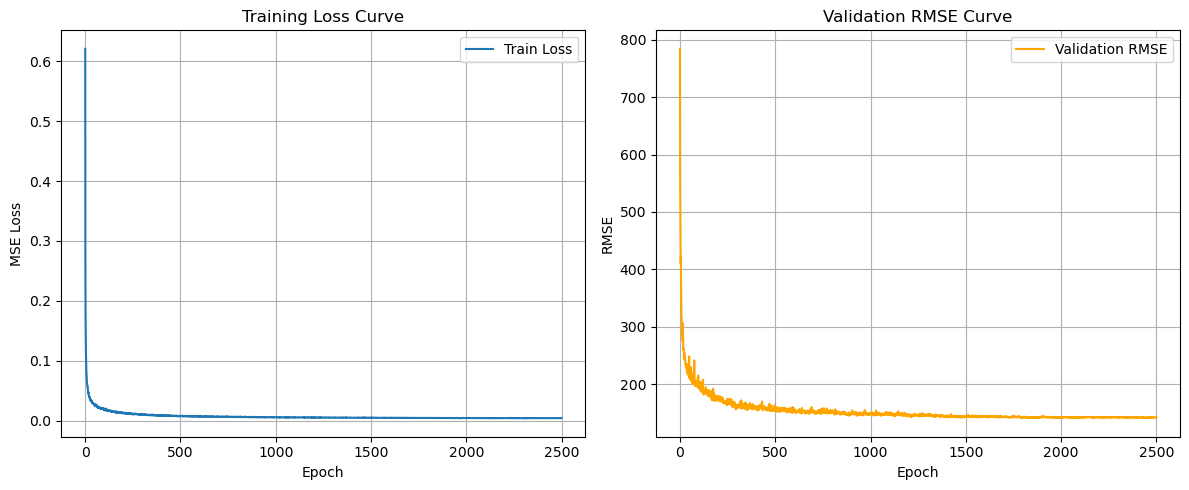

In [10]:
# plot the training loss and validation RMSE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_rmses, label='Validation RMSE', color='orange')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE Curve")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("training_curve.png")